In [2]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import sys
# sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields, asdict
import itertools
from itertools import chain, product
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer, LlamaTokenizer
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
torch.set_grad_enabled(False);

In utils/hub.py: default_cache_path: /raid3/xd/.cache/torch/hub->/nas/xd/.cache/torch/transformers/


In [5]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils_wab import *
from child_utils import _str, _cxt2str, _item2str, _s, _be
from child_frames import *
with Timer('tasks'): from tasks import *
with Timer('model_utils_wab'): from model_utils_wab_v5 import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000025
utils ... done 0:00:00.001214
child_utils ... done 0:00:00.343928
tasks ... done 0:00:00.000209
model_utils_wab ... done 0:00:00.687772
weight_analysis ... done 0:00:00.000018


In [6]:
models = {}
cache_dir = '/home/xd/.cache/torch/transformers/'
proxies = {'http': '192.168.50.1:1081'} 

In [7]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-j-6B/int8', 'EleutherAI/gpt-j-6B',
                  ]#, 'EleutherAI/gpt-neox-20b/cpu', #'EleutherAI/gpt-neox-20b', 'gpt2-xl', 'gpt2']
llama_model_names = ['models/vicuna/vicuna-7b@int8', 'models/vicuna/vicuna-13b@int8',
                     'lmsys/vicuna-13b-v1.3@cpu', 'lmsys/vicuna-13b-v1.3@int8', 
                     'lmsys/vicuna-33b-v1.3@cpu', 'lmsys/vicuna-33b-v1.3@int8', 'lmsys/vicuna-33b-v1.3'
                    ]
name2device = {'gpt-j-6B': 0, #'models/vicuna/vicuna-7b': 8, 'models/vicuna/vicuna-13b': 8,  
               'vicuna': 1, 'vicuna-7b-v1.3': 0, 'vicuna-13b-v1.3': 0, 'vicuna-33b-v1.3': 0}
for model_name in llama_model_names[-1:] + gpt_model_names[:0]:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM #if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        _cache_dir = cache_dir# .replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        dst = model_name.split('@')[-1] if '@' in model_name else 'cuda'
        model_name = model_name.replace('/cpu', '').replace('/int8', '')
        _model_name = model_name.split('/')[-1]
        if _model_name.startswith('vicuna'): _model_name = 'vicuna'
        kwargs = dict(cache_dir=_cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if dst == 'cpu':
            model = model_cls.from_pretrained(model_name, **kwargs)
        else:  # fp16 or int8 on GPU
            device = name2device[_model_name]
            device_map = get_device_map(devices=device, **name2mapping[_model_name]) if isinstance(device, Iterable) else None
            dtype_kwargs = dict(load_in_8bit=True) if dst == 'int8' else dict(torch_dtype=torch.float16)
            revision_kwargs = dict(revision='float16') if _model_name == 'gpt-j-6B' else {}
            model = model_cls.from_pretrained(model_name, device_map=device_map, **dtype_kwargs, **revision_kwargs, **kwargs)
            if device_map is None: model = model.to(device)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # to avoid slow loading of AutoTokenizer->TokenizerFast
        tokenizer_cls = LlamaTokenizer if 'vicuna' in model_name else GPT2Tokenizer
        tokenizer = tokenizer_cls.from_pretrained(model_name, cache_dir=_cache_dir)
        unify(model); unify_tokenizer(tokenizer)
        models[model_name] = model, tokenizer

lmsys/vicuna-33b-v1.3 ... 

In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00001-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00002-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00003-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00004-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00005-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00006-of-00007.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pyto

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


done 0:00:54.765287


In [8]:
blocks = model.model.layers
for i, b in enumerate(blocks): b.layer = i
# ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].self_attn.num_heads, blocks[0].self_attn.embed_dim

In [9]:
embed_dim

6656

In [10]:
L, H #/ (28 * 16)

(60, 52)

In [11]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 6656, padding_idx=0)
    (layers): ModuleList(
      (0-59): 60 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=6656, out_features=6656, bias=False)
          (k_proj): Linear(in_features=6656, out_features=6656, bias=False)
          (v_proj): Linear(in_features=6656, out_features=6656, bias=False)
          (o_proj): Linear(in_features=6656, out_features=6656, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
          (attn_dropout): Dropout(p=0, inplace=False)
          (resid_dropout): Dropout(p=0, inplace=False)
          (out_proj): Linear(in_features=6656, out_features=6656, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=6656, out_features=17920, bias=False)
          (up_proj): Linear(in_features=6656, out_features=17920, bias=False)
          (down_proj): Linear(in_features=17920, out_features=6656, b

# winograd beacuse 合并

In [9]:
winograd = Winograd('wino_sentences.json', 'wino_word_idx.json')

In [79]:
r1 = None
result = {}

Options: [ small or large ] the trophy doesn't fit into the suitcase because the trophy is large
2.6747639995301142 0.7916666666666666 0.734


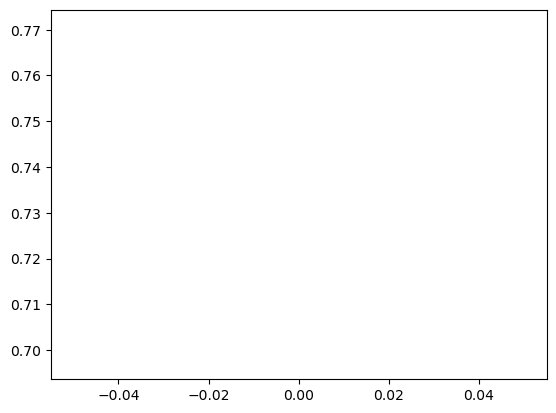

gx []
rx []


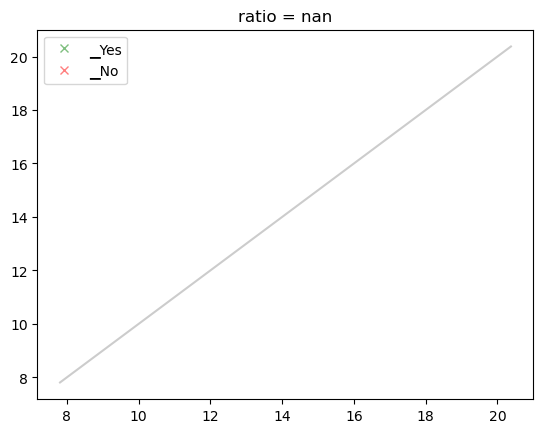

In [80]:
r1 = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=24,dataset = winograd,
                                        trim=False, result=r1, verbose=False)#8tiao

In [43]:
def filter_fn(p, c):  #合并版
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1  and c.topi == 6 or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and (c.topi in [2,6,13]) or  #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and ((p.label_type == None and c.topi in [2,5,7,10,12]) ) or #or p.label_type == 'attn_labels'
       p.step == 2 and p.attn_pattern in ['bos->bos']  or
    p.step == 3 and c.topi in [2,3,7,8,9,11,12] or
            p.step == 4 and c.top_score>0.5 or
            p.step == 5 and c.top_score>0.7#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [162]:
def filter_fn(p, c):  #合并版
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1  and c.topi == 1 or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and (c.topi in [2]) or  #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and ((p.label_type == None and c.topi in [0,3,6,7,8,12,13,14]) ) or #or p.label_type == 'attn_labels'
       p.step == 2 and p.attn_pattern in ['bos->bos']  or
    p.step == 3 and c.topi in [2,3,7,8,9,11,12] or
            p.step == 4 and c.top_score>0.5 or
            p.step == 5 and c.top_score>0.7#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [74]:
def filter_fn(p, c):  #合并版
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1  and c.topi == 1 or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and (c.topi in [2]) or  #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and ((p.label_type == None and c.topi in [0,3,6,7,8,12,13,14]) ) or #or p.label_type == 'attn_labels'
       p.step == 2 and p.attn_pattern in ['bos->bos']  or
    p.step == 3 and c.topi in [2,3,7,8,9,11,12] or
            p.step == 4 and c.top_score>0.5 or
            p.step == 5 and c.top_score>0.7#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [81]:
if True or r1.root is None: r1.root = add_node(None, layer=L, label_type='labels')
r1.root = attribute_tree_on(r1.data_tuples, model, r1.root, -1, filter_fn, topk=15, k_shot=0, threshold_score=0.1, attributed_top_mlps=5,mix=True, device=None, verbose=True)

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:00.904226
In attribute_tree: attribute_step stage2  ... In attribute_tree: mlpneuron.topk =
[((36, 52),
  torch.return_types.topk(
values=tensor([0.0233, 0.0083, 0.0078, 0.0076, 0.0062, 0.0052, 0.0039, 0.0026]),
indices=tensor([ 9022,  5262, 11629,  8120,  9029,  2939,  4959, 12884]))),
 ((39, 52),
  torch.return_types.topk(
values=tensor([0.0187, 0.0185, 0.0056, 0.0045, 0.0040, 0.0014, 0.0013, 0.0013]),
indices=tensor([ 5853, 11776, 11910,  5117,  8270,  9079, 15365,  7837]))),
 ((29, 52),
  torch.return_types.topk(
values=tensor([0.0274, 0.0035, 0.0032, 0.0023, 0.0018, 0.0018, 0.0018, 0.0018]),
indices=tensor([ 2002,  3244,  9197,  8691,  8502,  7443, 10693, 10977]))),
 ((24, 52),
  torch.return_types.topk(
values=tensor([0.0153, 0.0116, 0.0070, 0.0054, 0.0040, 0.0033, 0.0023, 0.0023]),
indices=tensor([  693,  3786,  9139,  9761, 11160,  4333, 11588, 16105]))),
 ((37, 52),
  torch.return_types.topk(
values=tensor([0.

In [82]:
mask_neurons={36: 9022, 39:[5853, 11776, 11910,  5117,  8270,  9079], 20: 5080, 21: 8322, 12: 9483, 19: [6387, 5351]}

average_activations(r1.data_tuples, 39, 'B', neuron_idx=mask_neurons[39])

In [164]:
print_tree(r1.root)

 ┌@[0,1,2,3,5,7,8,9,10,11,12,14] 36-m,39-m,29-m,24-m,37-m,22-m,33-m,23-m,32-47,27-m,25-m,28-m B->B 77
 ├@[4,6,13] 40-4,43-20,33-25 unk 0
 ├@0 36-m 100
 ├@1 39-m 94
 ├@2 29-m 77
 ├@3 24-m 73
 ├@5 37-m 61
 ├@7 22-m 57
 ├@8 33-m 57
 ├@9 23-m 54
 ├@10 32-47 49 B->B 28/10
 ├@11 27-m 48
 ├@12 25-m 47
 ├@14 28-m 43
 ├@4 40-4 68 B->A0 20/4 attn
 ├@6 43-20 58 B->s1 27/13 attn
 ├@13 33-25 45 B->A0 16/5 attn
 ┤
 │         ┌@[0,6,7,8,13,14] 36-m,38-m,31-m,32-m,28-m,20-m B->B 43
 │         ├@[1,3,12] 33-11,27-29,21-38 B->nA0 9
 │         ├@[4,11] 34-31,19-24 B->Ration 9
 │         ├@[9] 35-29 B->A0 8
 │         ├@[2,5,10] 32-1,29-3,25-33 B->s1 8
 │         ├@0 36-m 100
 │         ├@6 38-m 70
 │         ├@7 31-m 67
 │         ├@8 32-m 56
 │         ├@13 28-m 44
 │         ├@14 20-m 44
 │         ├@1 33-11 94 B->nA0 19/5 attn
 │         ├@3 27-29 81 B->nA0 23/14 attn
 │         ├@12 21-38 47 B->nA0 29/18 attn
 │         ├@4 34-31 75 B->Ration 26/14
 │         ├@4 34-31 75 B->Ration 26/14 attn attr_k


In [14]:
node = r1.root
node.name

''

In [109]:
node.data.mask_patterns = {(32,1):'B->s1]'}

In [86]:
node.data.attr_groups = {'G1': [(32,1),(19,24),(33,11)]}

39-52
gx []
rx []


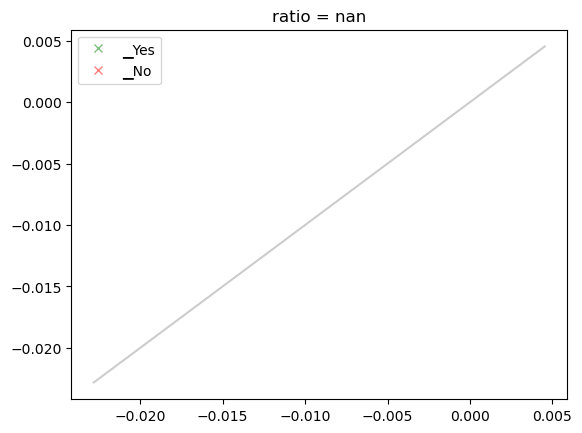

acc: 0.5 12 24
reduced_ap_scores = tensor([0.6934], device='cuda:1', dtype=torch.float16) tensor(0.6934, device='cuda:1', dtype=torch.float16)


In [84]:
#44-30 12     33-11 12   26-52 13  24-52 13  17-52 12  8-37 12
#43-52 12     28-52 12   27-52 17  16-52 13  8-52 12   8-52 12
#39-52 19     31-52 12   25-52 15  23-52 9   13-52 12  9-42 12
#36-52 13     32-1 13    29-52 13  12-52 12            12-4 13  
#27-52 14      29-52 13   13-52 14 18-52 13            14-6 12
#47-52 14     29-3 13     24-52 14 15-52 12            5-52 13
#37-52 15    27-29 13     17-52 12 14-52 12            9-29 13
#22-52 16    34-31 13     21-23 12 10-52 12            7-18 12
#24-52 17     20-52 11    19-52 12 21-38 12            5-31 12
#33-52 17     32-52 11    21-0 13  4-52 12             12-18 12  0,8,4,11,9,2,10
#30-43 11     35-29 12    2-52 12  9-52 11
#23-52 16     36-52 12    9-52 11  21-0 12
#45-52 13     32-9 16     15-24 14 24-33 12
#55-52 16                 20-13 12  20-14 12
#                          4-52 13 25-33 12
plot_attn_attrs(r1.data_tuples, model, tokenizer, node, topi=[1], attn_patterns=['B->s1'], k_shot=0, mix=True)     #47-32:12  55-52:15  39-52:19 56-24:15 51-52:13 42-30:9/24 28-34:17/24 43-20:16/24 27-29:13/24 39-25:15/24 step1:42-30 -> 43-20:12/24  28-34 -> 43-20 15/24   27-29 -> 43-20:11/24  25-33 -> 43-20: 20/24

### winograd because before

In [12]:
winograd_s2before = Winograd('wino_s2before_sentences.json', 'wino_s2before_word_idx.json')

In [13]:
winograd_s2before_new = Winograd('wino_s2before_sentences_new.json', 'wino_s2before_word_idx_new.json')

In [150]:
r1_before = None
result_before = {}

In [15]:
r1_before_new = None
result_before_new = {}

Options: [ small or large ] the trophy doesn't fit into the suitcase because the trophy is large
2.096352681517601 0.9166666666666666 0.8700833333333334


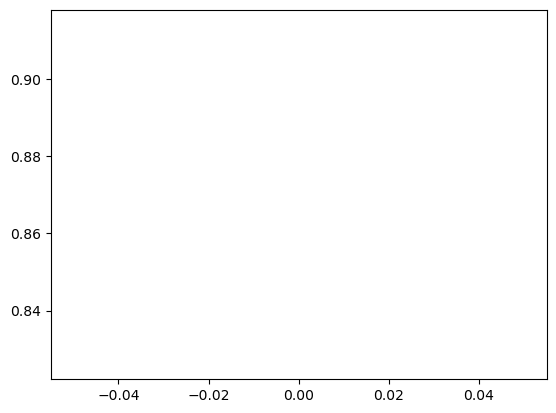

/home/xd/projects/transformers/notebooks/common_utils.py:266: RuntimeWarning: Mean of empty slice.
  m0 = y0.mean(0); m1 = y1.mean(0)
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


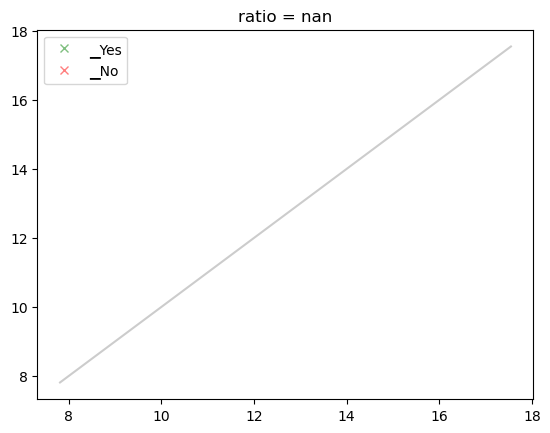

In [151]:
r1_before = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=12,dataset = winograd_s2before,
                                        trim=False, result=r1_before, verbose=False)#8tiao

Options: [ large or small ] the suitcase doesn't hold the trophy because the suitcase is small
2.9175357583832615 0.5833333333333334 0.57325


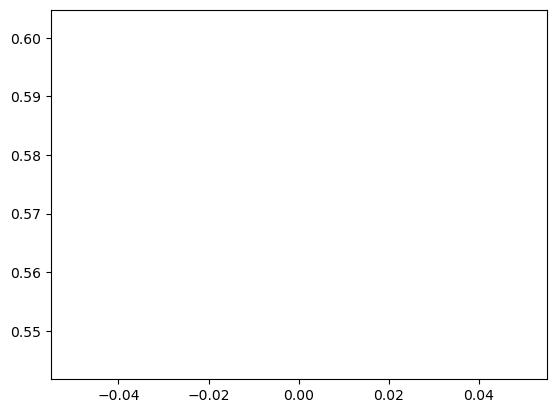

gx []
rx []


/home/xd/projects/transformers/notebooks/common_utils.py:266: RuntimeWarning: Mean of empty slice.
  m0 = y0.mean(0); m1 = y1.mean(0)
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


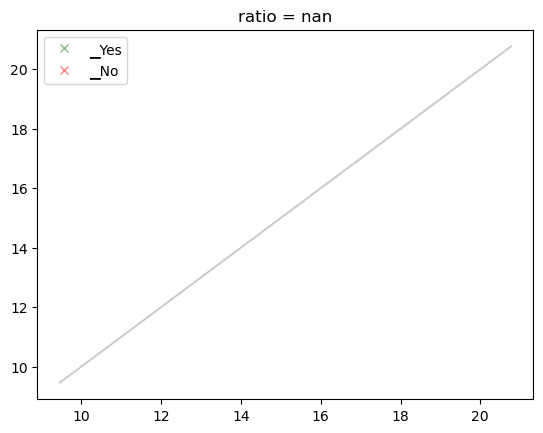

In [356]:
r1_before_new = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=12,dataset = winograd_s2before_new,
                                        trim=False, result=r1_before_new, verbose=False)#8tiao

In [17]:
def filter_fn_before(p, c):  #before
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1 and c.topi in [0,2] or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and c.topi in [1,8] or  #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and ((p.attn_pattern in ['bos->bos']) and c.topi in [2]) or
       p.step == 2 and (p.attn_pattern in ['bos->s1'] and c.topi in [0]) or
        p.step == 3 and (p.attn_pattern in ['bos->bos'] and c.topi in [0]) or 
        p.step == 4 and c.topi in [1,2,4,5,6,8]#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [176]:
def filter_fn_before(p, c):  #before
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1 and c.topi in [0] or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and c.topi in [1,3] or  #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and ((p.attn_pattern in ['bos->bos']) and c.topi in [2]) or
       p.step == 2 and (p.attn_pattern in ['bos->s1'] and c.topi in [0]) or
        p.step == 3 and (p.attn_pattern in ['bos->bos'] and c.topi in [0]) or 
        p.step == 4 and c.topi in [1,2,4,5,6,8]#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [18]:
if r1_before.root is None: r1_before.root = add_node(None, layer=L, label_type='labels')
r1_before.root = attribute_tree_on(r1_before.data_tuples, model, r1_before.root,-1, filter_fn_before, topk=15, k_shot=0, threshold_score=0,attributed_top_mlps=5, mix=True, device=None, verbose=True)

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:00.517677
In attribute_tree: attribute_step stage2  ... In attribute_tree: mlpneuron.topk =
[((29, 52),
  torch.return_types.topk(
values=tensor([0.0627, 0.0327, 0.0184, 0.0100, 0.0090, 0.0071, 0.0054, 0.0053]),
indices=tensor([ 8502,  2002, 15374,  5874,  9197, 10055, 10977,  5376]))),
 ((41, 52),
  torch.return_types.topk(
values=tensor([0.0674, 0.0207, 0.0187, 0.0070, 0.0069, 0.0057, 0.0052, 0.0050]),
indices=tensor([ 3299,  5873,  5175,  6184, 16208,  5141,  2383,  8085]))),
 ((28, 52),
  torch.return_types.topk(
values=tensor([0.0253, 0.0128, 0.0126, 0.0115, 0.0106, 0.0053, 0.0050, 0.0035]),
indices=tensor([ 9447,  3463, 13476,  7372,   307, 14233,  5933, 12739]))),
 ((37, 52),
  torch.return_types.topk(
values=tensor([0.0455, 0.0401, 0.0305, 0.0063, 0.0057, 0.0040, 0.0039, 0.0034]),
indices=tensor([11619,  7626, 10303,  7144,  9092,  7466,  7502, 17878]))),
 ((36, 52),
  torch.return_types.topk(
values=tensor([0.

In [19]:
print_tree(r1_before.root)

 ┌@[0,2,3,4,5,6,8,11,12,13] 29-m,41-m,28-m,37-m,36-m,59-m,57-m,39-m,23-m,44-m B->B 68
 ├@[1,7,9,10,14] 39-25,57-36,28-34,29-34,35-10 B->A0 13
 ├@0 29-m 100
 ├@2 41-m 78
 ├@3 28-m 73
 ├@4 37-m 73
 ├@5 36-m 71
 ├@6 59-m 69
 ┤
 ├@8 57-m 61
 ├@11 39-m 50
 ├@12 23-m 49
 ├@13 44-m 45
 ├@1 39-25 85 B->A0 43/12 attn
 ├@7 57-36 69 B->A0 42/12 attn
 ├@9 28-34 60 B->A0 44/13 attn
 ├@10 29-34 52 B->A0 49/18 attn
 └@14 35-10 45 B->A0 23/4 attn


In [155]:
mask_neurons={29: [2002], 41:[3299,  5873], 20: 5080, 21: 8322, 12: 9483, 19: [6387, 5351]}
average_activations(r1_before.data_tuples, 29, 'B', neuron_idx=mask_neurons[29])

In [134]:
node = r1_before.root
node.name

''

In [94]:
tokenizer.convert_ids_to_tokens( [1, 25186, 29901,   518,  8261,   470,  6460,  4514,  2259,  4846,
            263,  3287,   310,  6909,   304, 25914,  1363,  2259,   471,  8261])

['<s>',
 '▁Options',
 ':',
 '▁[',
 '▁rich',
 '▁or',
 '▁poor',
 '▁]',
 '▁John',
 '▁gave',
 '▁a',
 '▁lot',
 '▁of',
 '▁money',
 '▁to',
 '▁Susan',
 '▁because',
 '▁John',
 '▁was',
 '▁rich']

In [32]:
r1_before.data_tuples[1][-1].mlp_pre_acts[29][0].size()

torch.Size([20, 17920])

In [139]:
r1_before.data_tuples[1][-1].avg_mlp_gates[29][0].size()

torch.Size([20, 17920])

In [114]:
def heatmap(a, figsize=(10, 5), cbar=False):
    _ = plt.figure(figsize=figsize)
    _ = sns.heatmap(numpy(a, decimals=None),yticklabels=token,xticklabels=xlabel, cbar=cbar)
    plt.show()

In [148]:
token = ['<s>','Options', ':','[', 'rich', 'or', 'poor', ']', 'John', 'gave', 'a', 'lot', 'of', 'money', 'to', 'Susan', 'because', 'John', 'was', 'rich']
xlabel = [0,1,2,3,4,5,6,7,8,9,10,'...','...','...',2000,2001,2002,2003,2004,2005,'...','...','...',17918,17919,17920]

In [156]:
data = r1_before.data_tuples[1][-1].avg_mlp_gates[29][0]
value = torch.cat((data[:,0:14],data[:,2000:2006],data[:,17914:]),1)

torch.Size([20, 14])

In [127]:
value.size()

torch.Size([20, 25])

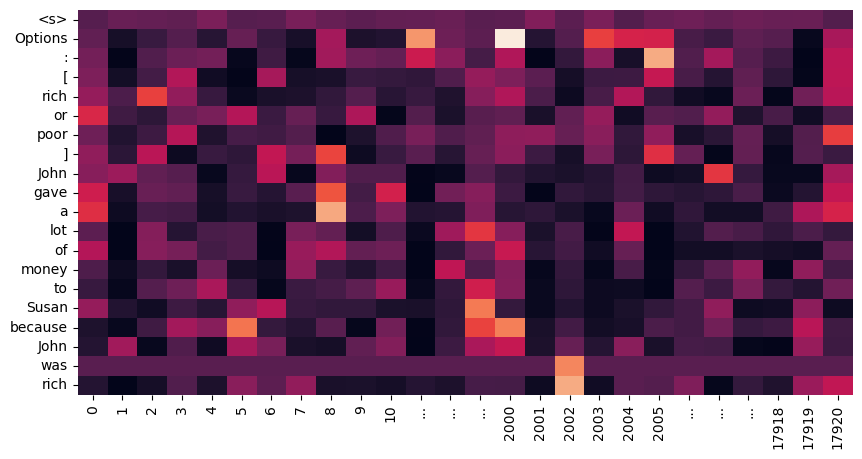

In [157]:
heatmap(value)

In [45]:
node.data.mask_patterns = {(25,42):'B->s1]'}

NameError: name 'node' is not defined

In [161]:
node.data.attr_groups = {'G1': [(25,42),(18,1)]}

29-52


/home/xd/projects/transformers/notebooks/common_utils.py:266: RuntimeWarning: Mean of empty slice.
  m0 = y0.mean(0); m1 = y1.mean(0)
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


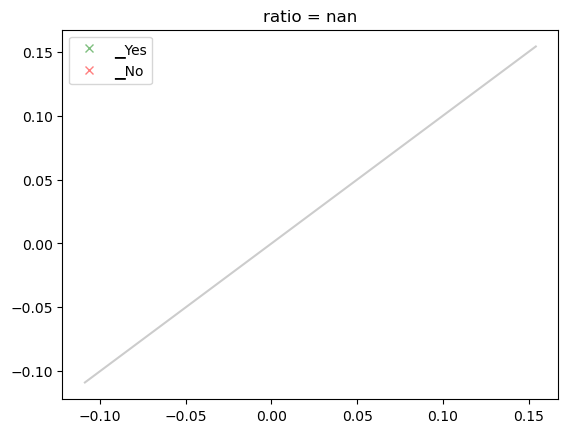

acc: 0.833 10 12
reduced_ap_scores = tensor([0.6631], device='cuda:1', dtype=torch.float16) tensor(0.6631, device='cuda:1', dtype=torch.float16)


In [135]:
#30-52 7  #22-22 10      14-2 : 10-52 8  11-52 8 9-52 8 7-52 8
#26-52 9  #9-11 9       9-11,15-24,14-44: 8-52 10  11-52 8 3-52 8
#33-25 7  #14-2 11       18-1: 13-52 8 10-52 9  12-23 9-24 10 12-31 10 17-46 10
#28-7 5   #18-18 10
#34-52 6  #14-44 9
#32-47 6  # 15-24 9
#38-13 7  
#18-1 11   13-52 8
#23-22 10  1-52 9
#26-29     16-39 9
#27-25 9   12-23 9
#22-48 10   \9-24 10
#18-1 + 23-22 12  12-31 10
#             17-46 10     1,   ###6,7,10,11,12,13,14
#              17-28 10
#            6-52 9             10
#            15-24
#7 8
## 0 1 6 11
# 1 4 12 13
plot_attn_attrs(r1_before.data_tuples, model, tokenizer, node, topi=[0], attn_patterns=['B->s1'], k_shot=0, mix=True)

In [26]:
r1_before.data_tuples[0][-1].mlp_pre_acts[29]

AttributeError: 'tuple' object has no attribute 'shape'

In [359]:
layer = 29
YNs, hiddens = [], []
for text, input_ids, labels, ranges, *_, o in r1_before_new.data_tuples:
#     YN = 'g' if text.strip().endswith('Yes') else 'r'
#     gate = o.mlp_gates[layer][0, ranges[1].ans[1] + 1 - 1]
    pre_act = o.mlp_pre_acts[layer][0, ranges[0].bos[1] - 1, mask_neurons[29]]
#     YNs.append(YN)
    hiddens.append(pre_act.numpy())
hiddens = np.array(hiddens)
# fisher_discriminant_ratio(YNs, hiddens, labels=['g', 'r'], plot=False)
# visualize_by_pca(hiddens, YNs)

In [28]:
text, input_ids, labels, ranges, *_, o = r1_before.data_tuples[0]
o.mlp_pre_acts[29][0, ranges[0].bos[1] - 1].shape

torch.Size([17920])

In [358]:
hiddens_old = hiddens

In [388]:
winograd_s2after.sentences

["Options: [ large or small ] the trophy doesn't fit into the suitcase because the suitcase is small",
 'Options: [ rich or poor ] John gave a lot of money to Susan because Susan was poor',
 'Options: [ fast or slow ] the truck overtook the bus because the bus was going slow',
 'Options: [ soft or hard ] the ball crashed right through the board because the board was soft',
 "Options: [ short or tall ] John couldn't see the stage behind Susan because Susan is tall",
 'Options: [ first or later ] the bag of potatoes had been placed above the bag of flour so the bag of flour had to be moved later',
 'Options: [ empty or full ] the bottle was filled with water from the cup after the cup was full',
 'Options: [ younger or older ] Jack always takes care of Betty because Betty is younger',
 'Options: [ majority or minority ] the sponsors were less in number than the opponents so the opponents were in the majority',
 'Options: [ wide or narrow ] the table will fit through the doorway because t

In [340]:
winograd.sentences

["Options: [ small or large ] the trophy doesn't fit into the suitcase because the trophy is large",
 "Options: [ large or small ] the trophy doesn't fit into the suitcase because the suitcase is small",
 'Options: [ rich or poor ] John gave a lot of money to Susan because John was rich',
 'Options: [ rich or poor ] John gave a lot of money to Susan because Susan was poor',
 'Options: [ fast or slow ] the truck overtook the bus because the truck was going fast',
 'Options: [ fast or slow ] the truck overtook the bus because the bus was going slow',
 'Options: [ hard or soft ] the ball crashed right through the board because the ball was hard',
 'Options: [ soft or hard ] the ball crashed right through the board because the board was soft',
 "Options: [ tall or short ] John couldn't see the stage behind Susan because John is short",
 "Options: [ short or tall ] John couldn't see the stage behind Susan because Susan is tall",
 'Options: [ later or first ] the bag of potatoes had been pla

In [384]:
list(zip(r1_before_new.eval_results, r1_before.eval_results))[11]#2,3,7,8,9

([1.6652350425720215,
  [True],
  [0.66],
  [[0.33982759714126587, 0.6601723432540894]]],
 [2.1220831871032715,
  [True],
  [0.994],
  [[0.9939963817596436, 0.0060035958886146545]]])

In [389]:
winograd_s2after.sentences

["Options: [ large or small ] the trophy doesn't fit into the suitcase because the suitcase is small",
 'Options: [ rich or poor ] John gave a lot of money to Susan because Susan was poor',
 'Options: [ fast or slow ] the truck overtook the bus because the bus was going slow',
 'Options: [ soft or hard ] the ball crashed right through the board because the board was soft',
 "Options: [ short or tall ] John couldn't see the stage behind Susan because Susan is tall",
 'Options: [ first or later ] the bag of potatoes had been placed above the bag of flour so the bag of flour had to be moved later',
 'Options: [ empty or full ] the bottle was filled with water from the cup after the cup was full',
 'Options: [ younger or older ] Jack always takes care of Betty because Betty is younger',
 'Options: [ majority or minority ] the sponsors were less in number than the opponents so the opponents were in the majority',
 'Options: [ wide or narrow ] the table will fit through the doorway because t

In [361]:
list(zip(hiddens[:, 0], winograd_s2before_new.sentences))

[(-0.3383789,
  "Options: [ large or small ] the suitcase doesn't hold the trophy because the suitcase is small"),
 (0.34985352,
  'Options: [ rich or poor ] Susan accepted a lot of money from John because Susan was poor'),
 (-1.5820312,
  'Options: [ fast or slow ] the bus was overtaken by the truck because the bus was going slow'),
 (0.5214844,
  'Options: [ soft or hard ] the board was crashed right through by the ball because the board was soft'),
 (1.0478516,
  "Options: [ short or tall ] Susan blocked John's view of the stage because Susan is tall"),
 (0.69873047,
  'Options: [ first or later ] the bag of flour had been placed under the bag of potatoes so the bag of flour had to be moved later'),
 (0.8046875,
  'Options: [ empty or full ] the cup filled the bottle with water after the cup was full'),
 (-0.71728516,
  'Options: [ younger or older ] Betty is always taken care of by Jack because Betty is younger'),
 (0.65234375,
  'Options: [ majority or minority ] the opponents wer

In [364]:
list(zip(hiddens_old[:, 0], winograd_s2before.sentences))

[(3.1816406,
  "Options: [ small or large ] the trophy doesn't fit into the suitcase because the trophy is large"),
 (1.3271484,
  'Options: [ rich or poor ] John gave a lot of money to Susan because John was rich'),
 (1.3134766,
  'Options: [ fast or slow ] the truck overtook the bus because the truck was going fast'),
 (1.0527344,
  'Options: [ hard or soft ] the ball crashed right through the board because the ball was hard'),
 (-0.1628418,
  "Options: [ tall or short ] John couldn't see the stage behind Susan because John is short"),
 (-1.6689453,
  'Options: [ later or first ] the bag of potatoes had been placed above the bag of flour so the bag of potatoes had to be moved first'),
 (0.57373047,
  'Options: [ full or empty ] the bottle was filled with water from the cup after the bottle was empty'),
 (0.5361328,
  'Options: [ older or younger ] Jack always takes care of Betty because Jack is older'),
 (-1.8320312,
  'Options: [ minority or majority ] the sponsors were less in numb

In [ ]:
the bottle was filled with water from the cup after the bottle was empty
the bottle was filled with water from the cup after the cup was full
the cup filled the bottle with water after the cup was full

the table will fit through the doorway because the table is narrow
the table will fit through the doorway because the doorway is wide
the doorway can fit the table through because the doorway is wide

In [249]:
import torch
torch.set_printoptions(threshold=np.inf)

In [284]:
r1_before.data_tuples[0][-1].mlp_pre_acts[29][0,24]

tensor([ 2.2290e-01,  6.0254e-01,  2.2815e-01, -3.0579e-02,  3.9600e-01,
        -4.8120e-01,  7.5537e-01,  5.6982e-01, -3.5791e-01,  2.7612e-01,
         8.3069e-02, -1.2939e-01,  3.7750e-02,  2.3743e-01, -1.0168e-01,
         1.0977e+00, -4.6777e-01,  2.6025e-01, -5.2881e-01, -3.3252e-01,
         8.9062e-01,  5.4199e-01,  3.3740e-01,  4.0234e-01, -3.1714e-01,
        -3.4326e-01,  2.4963e-01,  4.1306e-05,  2.4561e-01,  2.7515e-01,
        -3.4119e-02,  2.4646e-01, -3.9380e-01, -2.0264e-01, -8.6230e-01,
         1.6321e-01,  3.1152e-01, -9.8572e-02,  6.0303e-01,  5.7324e-01,
        -1.5332e-01, -2.5977e-01,  1.4600e-01,  3.0518e-01, -1.2021e+00,
        -3.1885e-01,  4.3481e-01, -1.8494e-02,  3.0957e-01, -5.7812e-01,
        -2.7026e-01, -1.9971e-01, -4.3872e-01,  2.6880e-01, -2.9883e-01,
        -1.5366e-02, -4.9878e-01,  4.4165e-01, -3.5474e-01, -4.4800e-01,
        -1.3403e-01,  4.5483e-01,  6.7334e-01, -2.5464e-01, -5.2930e-01,
         4.1895e-01, -6.1475e-01, -7.4280e-02,  4.0

In [256]:
r1_before.data_tuples[2][3][0].bos[1]

22

In [275]:
num_zheng = []
for hidden in hiddens:
    zheng = 0 
    for i in hidden:
            zheng+=i
    num_zheng.append(zheng)
    

In [276]:
num_zheng

[-66.9833944439888,
 -47.29197669029236,
 -81.68023282289505,
 -53.711309254169464,
 -28.60725027322769,
 -46.0110319852829,
 32.842163026332855,
 -50.163758277893066,
 30.889025330543518,
 -68.12530130147934,
 -55.9569411277771,
 -17.054705560207367]

In [277]:
import matplotlib.pyplot as plt

In [288]:
hi = [i for i,num in enumerate(hiddens[0])]

Text(0.5, 1.0, 'Example')

Text(0.5, 0, 'x')

Text(0, 0.5, 'Y')

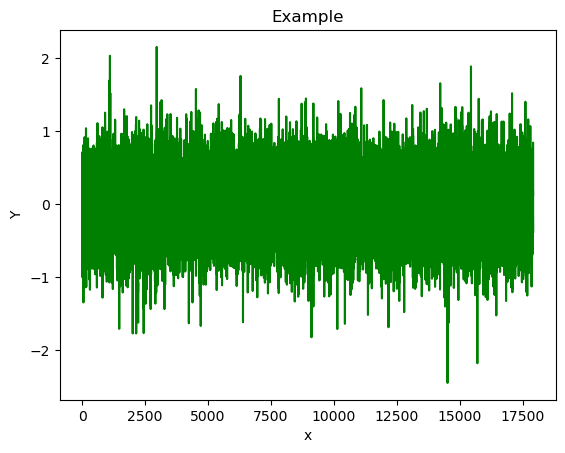

In [322]:
plt.plot(hi,hiddens[9]  , color="g")
plt.title("Example")
plt.xlabel("x")
plt.ylabel ("Y")
plt.show()

In [196]:
winograd_s2before.sentences

["Options: [ small or large ] the trophy doesn't fit into the suitcase because the trophy is large",
 'Options: [ rich or poor ] John gave a lot of money to Susan because John was rich',
 'Options: [ fast or slow ] the truck overtook the bus because the truck was going fast',
 'Options: [ hard or soft ] the ball crashed right through the board because the ball was hard',
 "Options: [ tall or short ] John couldn't see the stage behind Susan because John is short",
 'Options: [ later or first ] the bag of potatoes had been placed above the bag of flour so the bag of potatoes had to be moved first',
 'Options: [ full or empty ] the bottle was filled with water from the cup after the bottle was empty',
 'Options: [ older or younger ] Jack always takes care of Betty because Jack is older',
 'Options: [ minority or majority ] the sponsors were less in number than the opponents so the sponsors were in the minority',
 'Options: [ wide or narrow ] the table will fit through the doorway because 

In [217]:
a = (2,3,4,5,6,7,8,9)

In [218]:
a[0,3]

TypeError: tuple indices must be integers or slices, not tuple

# winograd because after

In [386]:
winograd_s2after = Winograd('wino_s2after_sentences.json', 'wino_s2after_word_idx.json')

In [104]:

r1_after = None
result_after = {}

Options: [ large or small ] the trophy doesn't fit into the suitcase because the suitcase is small
3.2531753175426275 0.6666666666666666 0.5979166666666668


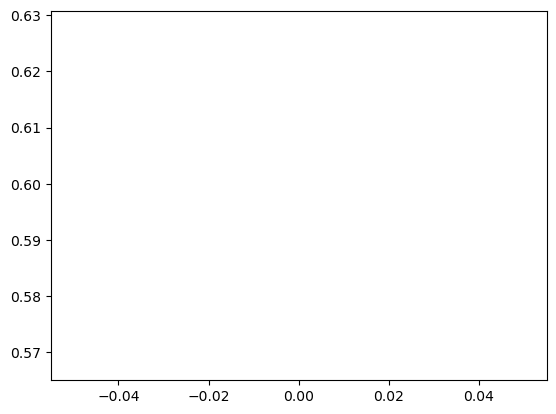

gx []
rx []


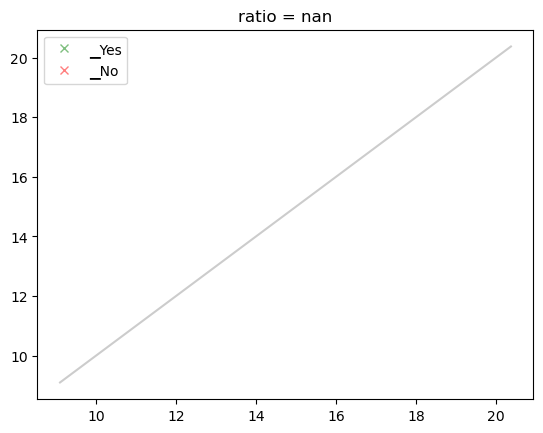

In [105]:
r1_after = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=12,dataset = winograd_s2after,
                                        trim=False, result=r1_after, verbose=False)#8tiao

In [215]:
def filter_fn_after(p, c):  #before
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1 and c.topi in [6,7] or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and c.topi in [0] or  #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and p.attn_pattern =='bos->s1' and p.label_type == None and c.topi in [0] 
#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [216]:
if True or r1_after.root is None: r1_after.root = add_node(None, layer=L, label_type='labels')
r1_after.root = attribute_tree_on(r1_after.data_tuples, model, r1_after.root, 2, filter_fn_after, topk=15, k_shot=0, threshold_score=0, mix=True, device=None, verbose=True)

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:00.465858
In attribute_tree: attribute_step stage2  ... done 0:00:00.057509
In attribute_tree: topk bos->ans0 heads =
(array([53, 26, 24, 28, 21, 53, 26, 30, 21, 10]),
 array([17, 51, 20, 47, 38, 14, 29, 19, 12, 13]),
 array([0.34602356, 0.31046805, 0.25294432, 0.21002133, 0.20903523,
       0.20329411, 0.20090564, 0.19978873, 0.19204967, 0.18000777],
      dtype=float32))
In _add_node: add @0 43-m 100
In _add_node: add @1 45-m 100
In _add_node: add @6 32-m 67
In _add_node: add @7 24-m 64
In _add_node: add @9 49-m 60
In _add_node: add @10 26-m 55
In _add_node: add @11 39-m 49
In _add_node: add @12 47-m 46
In _add_node: add @2 44-30 86 B->A0 24/10 attn
In _add_node: add @3 40-4 85 B->A0 28/6 attn
In _add_node: add @4 33-25 82 B->A0 19/7 attn
In _add_node: add @5 35-29 69 B->A0 52/10 attn
In _add_node: add @8 42-30 62 B->A0 47/10 attn
In _add_node: add @13 45-30 43 B->A0 42/8 attn
In _add_node: add @14 59-46 43 B->Ration

In [217]:
print_tree(r1_after.root)

 ┌@[0,1,6,7,9,10,11,12] 43-m,45-m,32-m,24-m,49-m,26-m,39-m,47-m B->B 56
 ├@[2,3,4,5,8,13] 44-30,40-4,33-25,35-29,42-30,45-30 B->A0 15
 ├@[14] 59-46 unk 0
 ├@0 43-m 100
 ├@1 45-m 100
 ├@6 32-m 67
 ├@7 24-m 64
 ├@9 49-m 60
 ├@10 26-m 55
 ├@11 39-m 49
 ├@12 47-m 46
 ├@2 44-30 86 B->A0 24/10 attn
 ├@3 40-4 85 B->A0 28/6 attn
 ├@4 33-25 82 B->A0 19/7 attn
 ├@5 35-29 69 B->A0 52/10 attn
 ├@8 42-30 62 B->A0 47/10 attn
 ├@13 45-30 43 B->A0 42/8 attn
 ├@14 59-46 43 B->Ration 19/37 attn
 ┤
 │              ┌@[4,6,8,11,13] 26-m,29-m,27-m,30-m,28-m B->B 37
 │              ├@[0,1,3] 22-22,32-1,24-35 B->s1 14
 │              ├@[2,10,12,14] 18-28,18-1,19-24,22-48 B->Ration 12
 │              ├@[9] 21-0 B->inter 11
 │              ├@[5,7] 21-22,25-33 B->s2 8
 │              ├@4 26-m 65
 │              ├@6 29-m 50
 │              ├@8 27-m 46
 │              ├@11 30-m 44
 │              ├@13 28-m 41
 │              ├@0 22-22 100 B->s1 75/62 attn
 │              ├@0 22-22 100 B->s1 75/62
 │              ├

In [218]:
node = r1_after.root.children[-1].children[-2].children[-1]
node.name

'8-m s1->s1'

In [159]:
node.data.mask_patterns = {(22,22):'B->s1]'}

32-m,24-m B->B -> 22-22 B->s1 -> 8-m s1->s1 -> 8-14
*▁small 0.547 {'▁small': 0.547, '▁large': 0.453, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ large or small ] the trophy doesn't fit into the suitcase because the suitcase is small *▁small:0.152 ▁large:-0.036
ap_scores = tensor([0.1483]) tensor(0.1483)


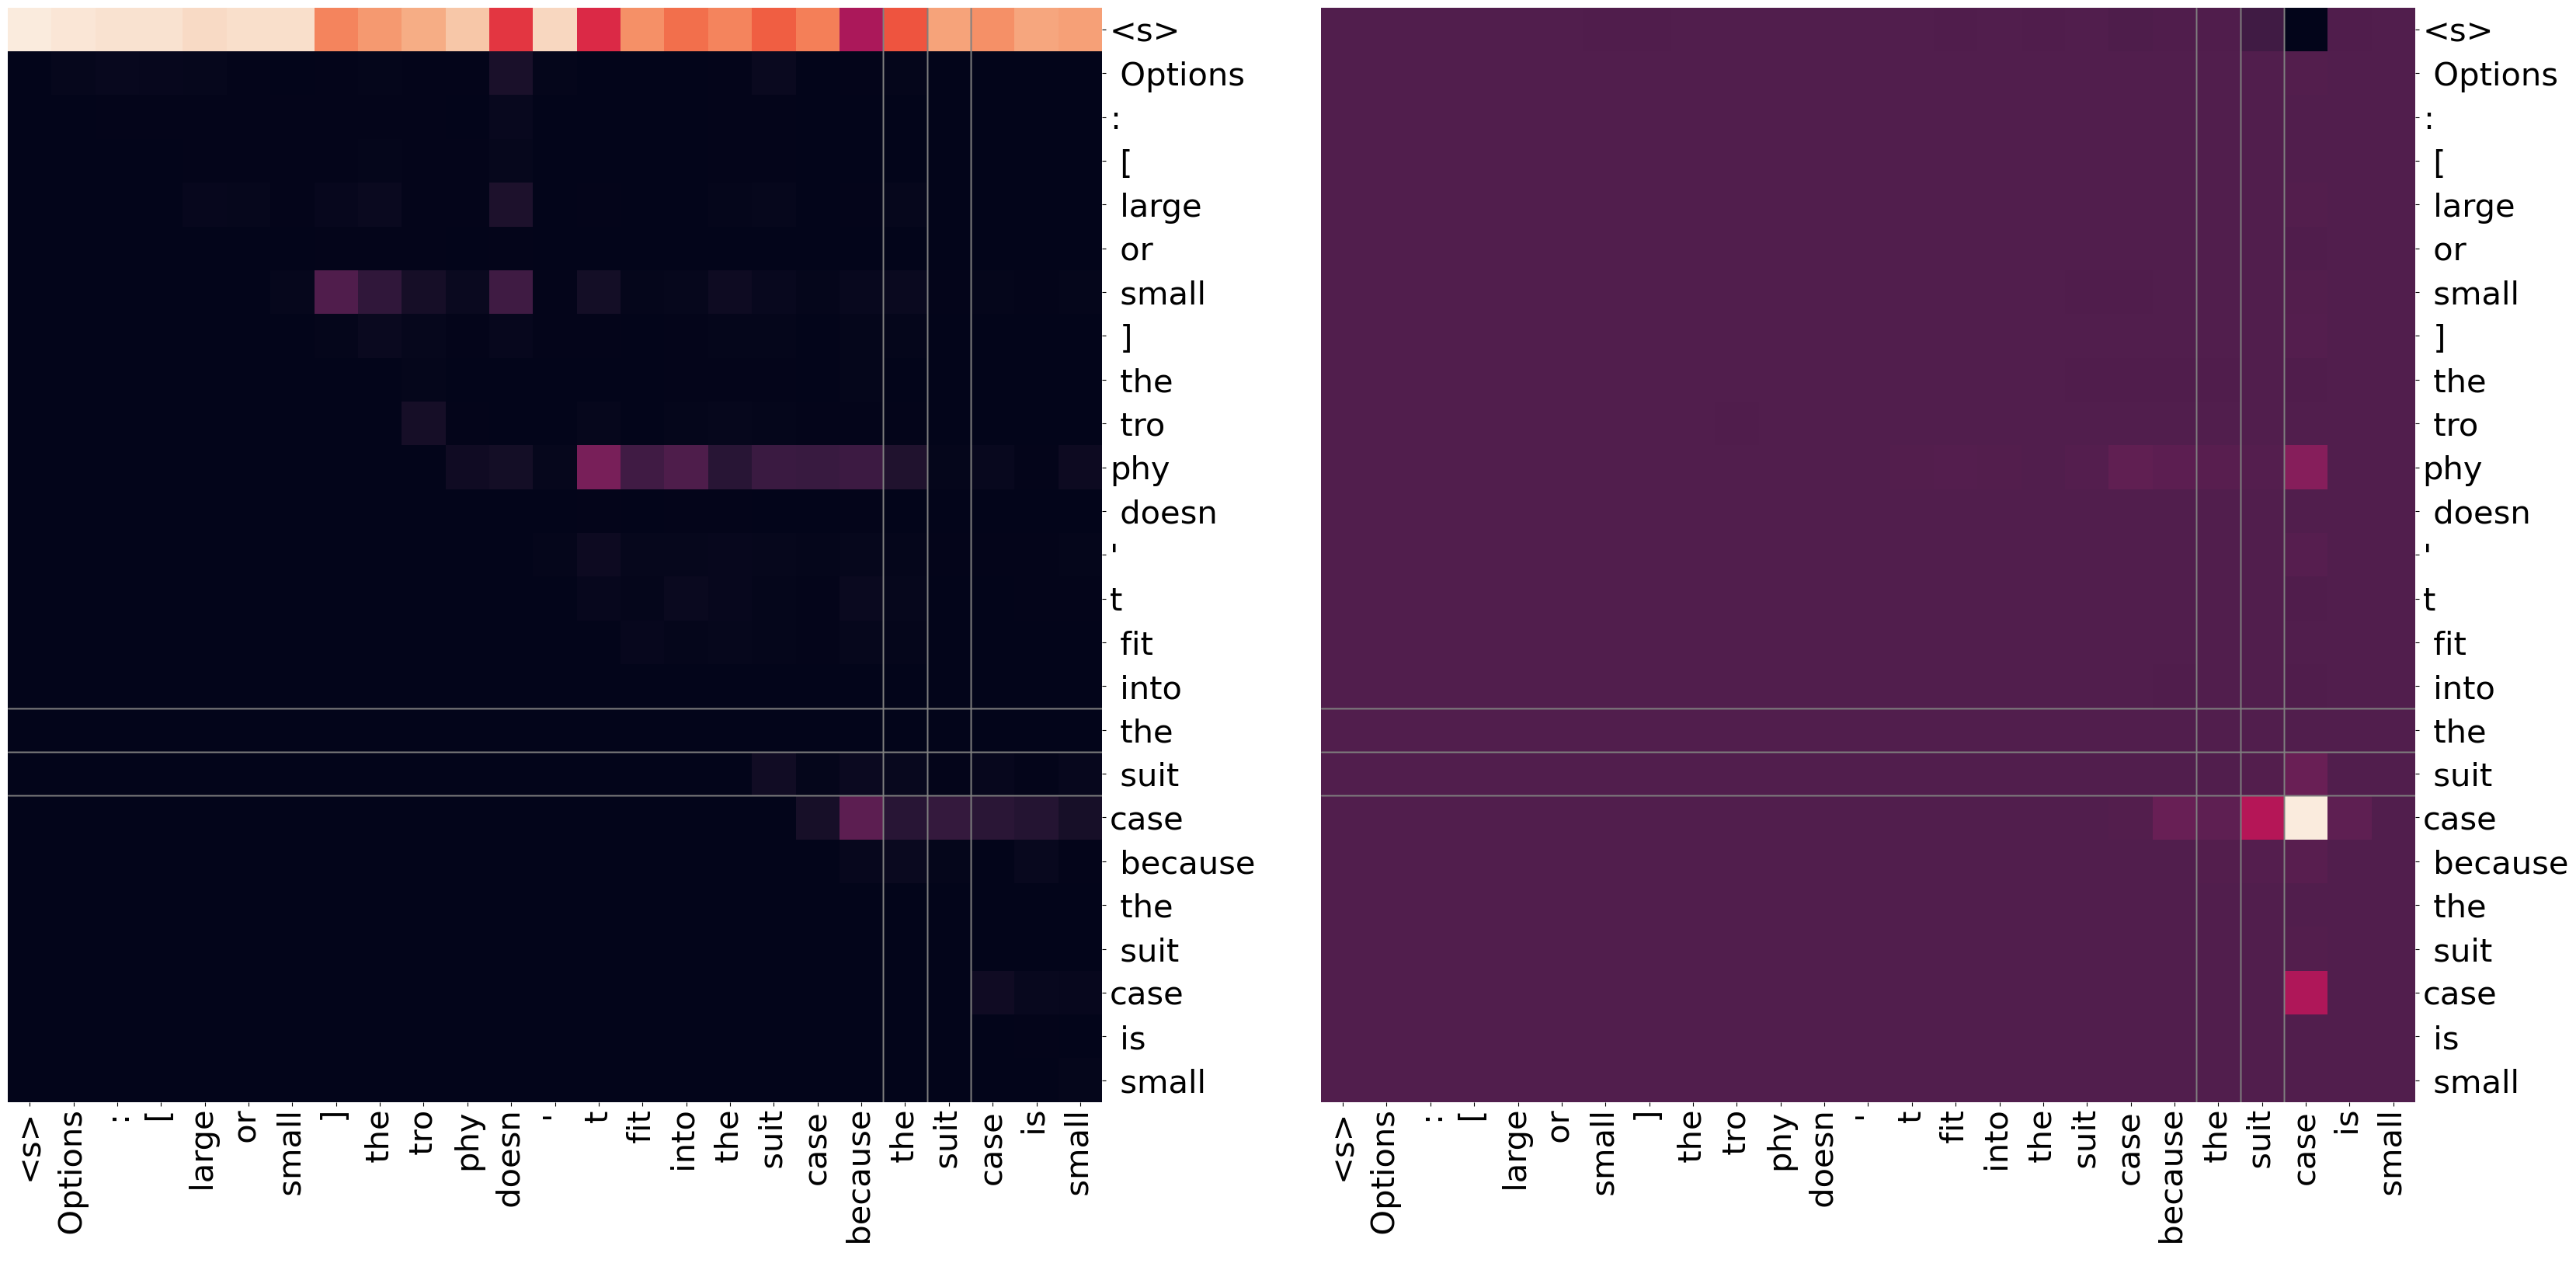

*▁poor 0.661 {'▁poor': 0.661, '▁rich': 0.338, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ rich or poor ] John gave a lot of money to Susan because Susan was poor *▁poor:0.190 ▁rich:-0.479
ap_scores = tensor([0.0583]) tensor(0.0583)


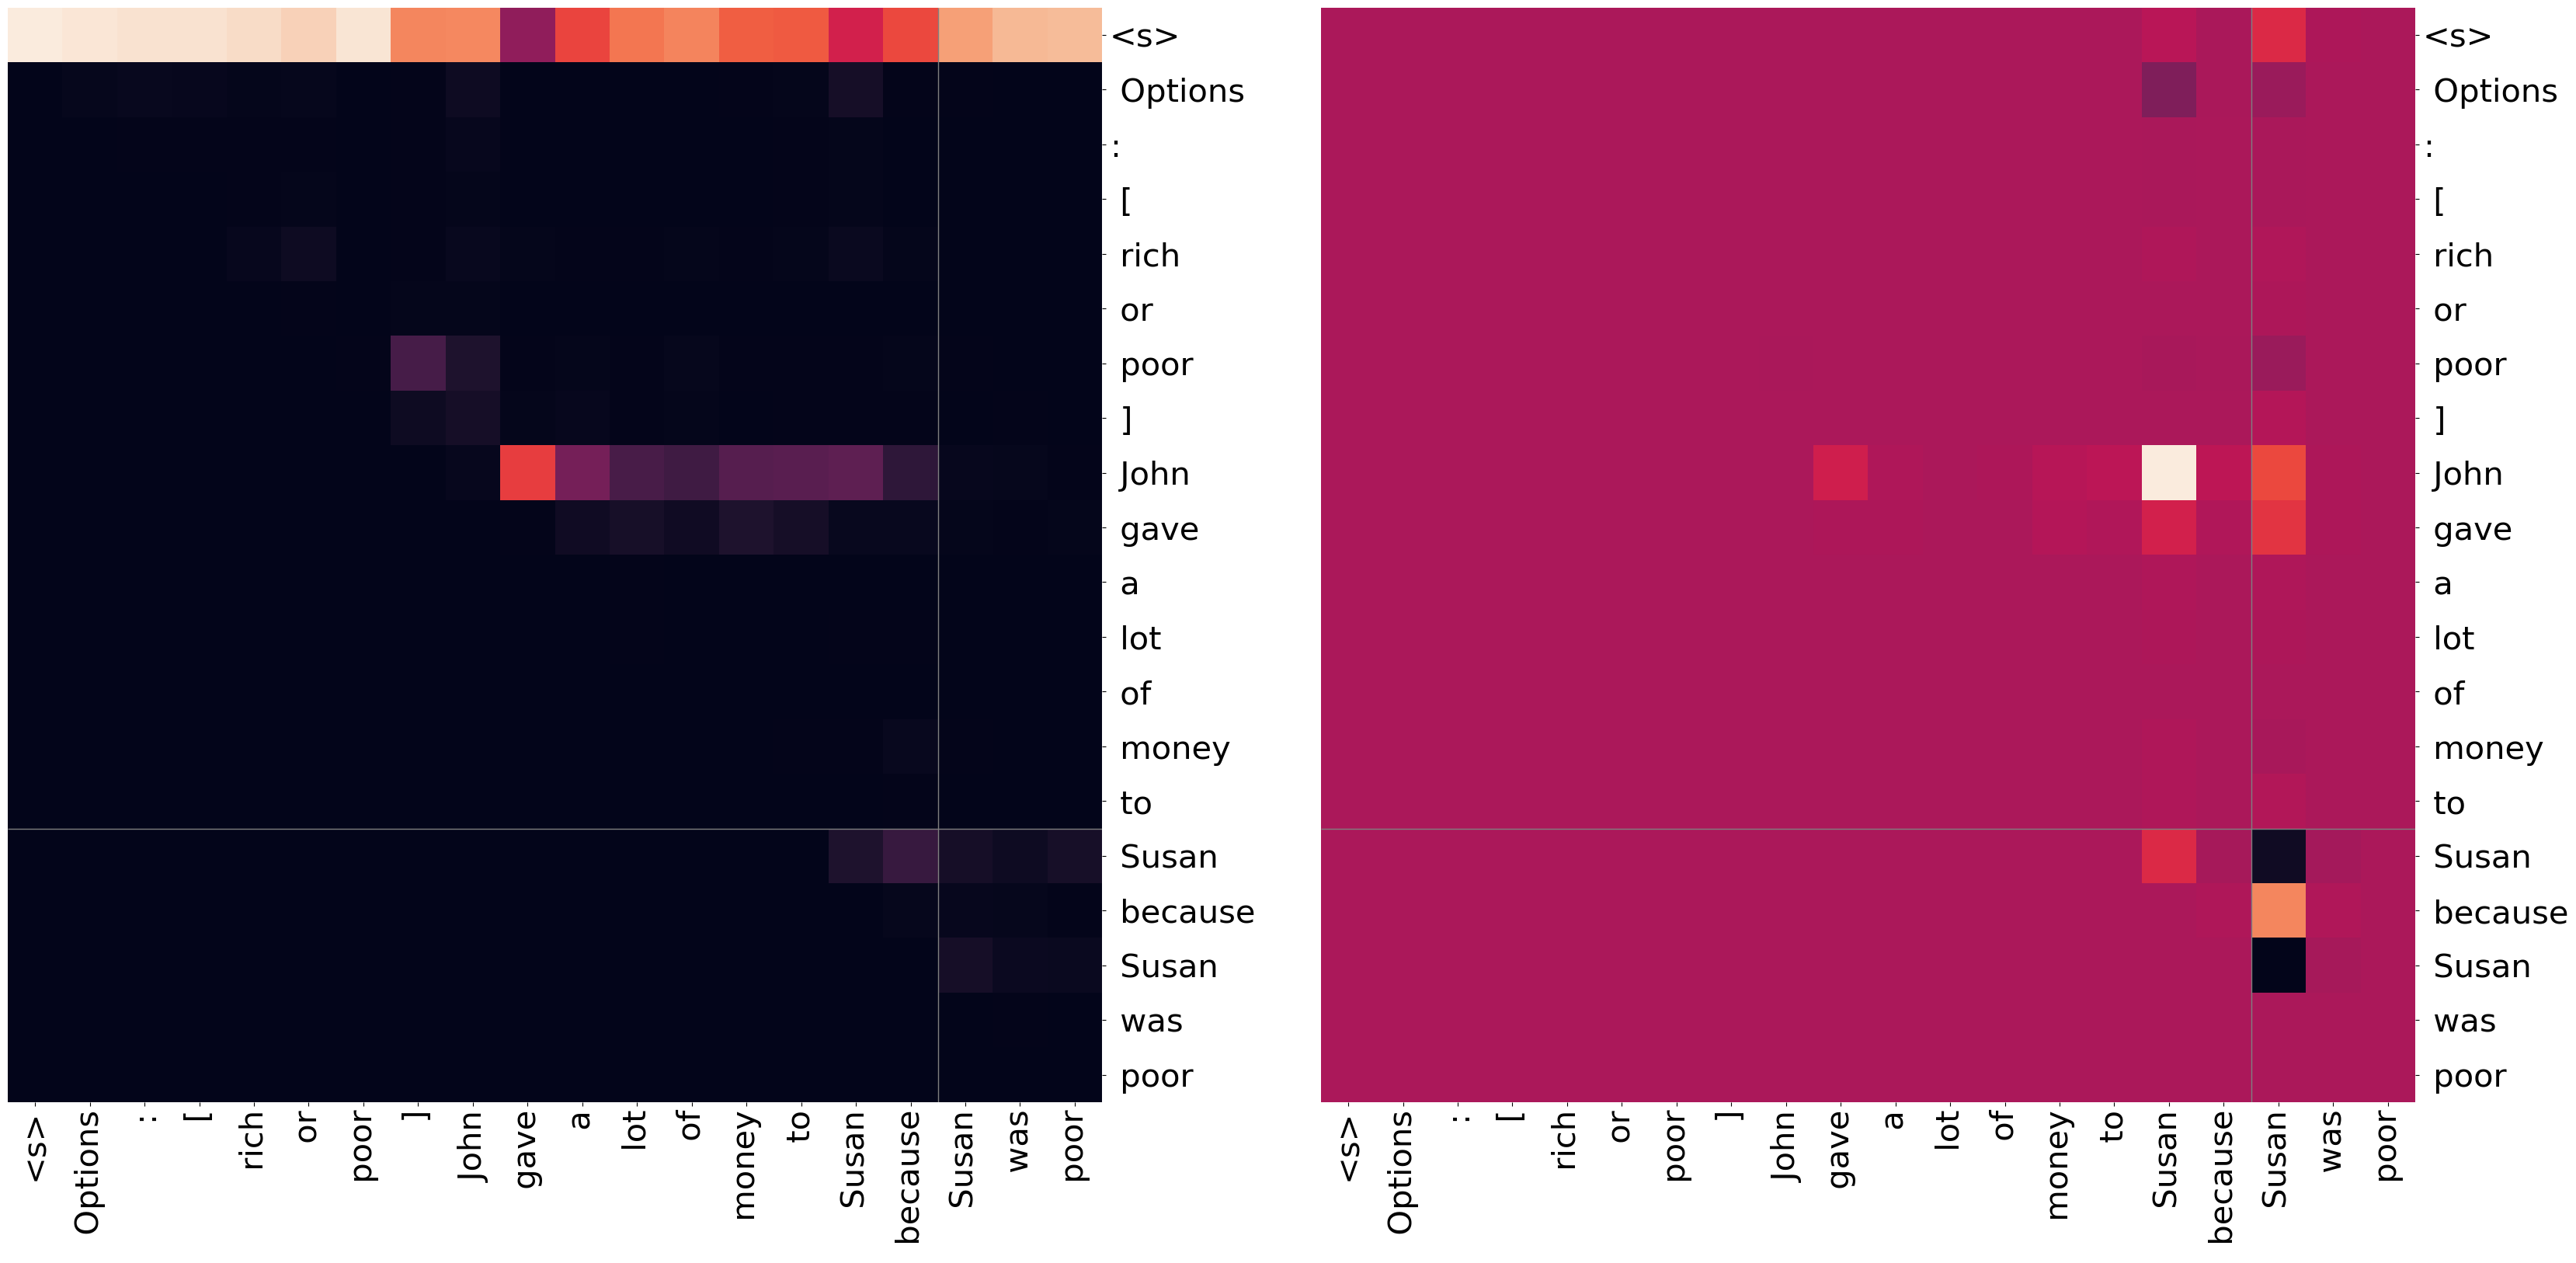

*▁slow 0.573 {'▁slow': 0.573, '▁fast': 0.427, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ fast or slow ] the truck overtook the bus because the bus was going slow *▁slow:-0.007 ▁fast:-0.302
ap_scores = tensor([0.1112]) tensor(0.1112)


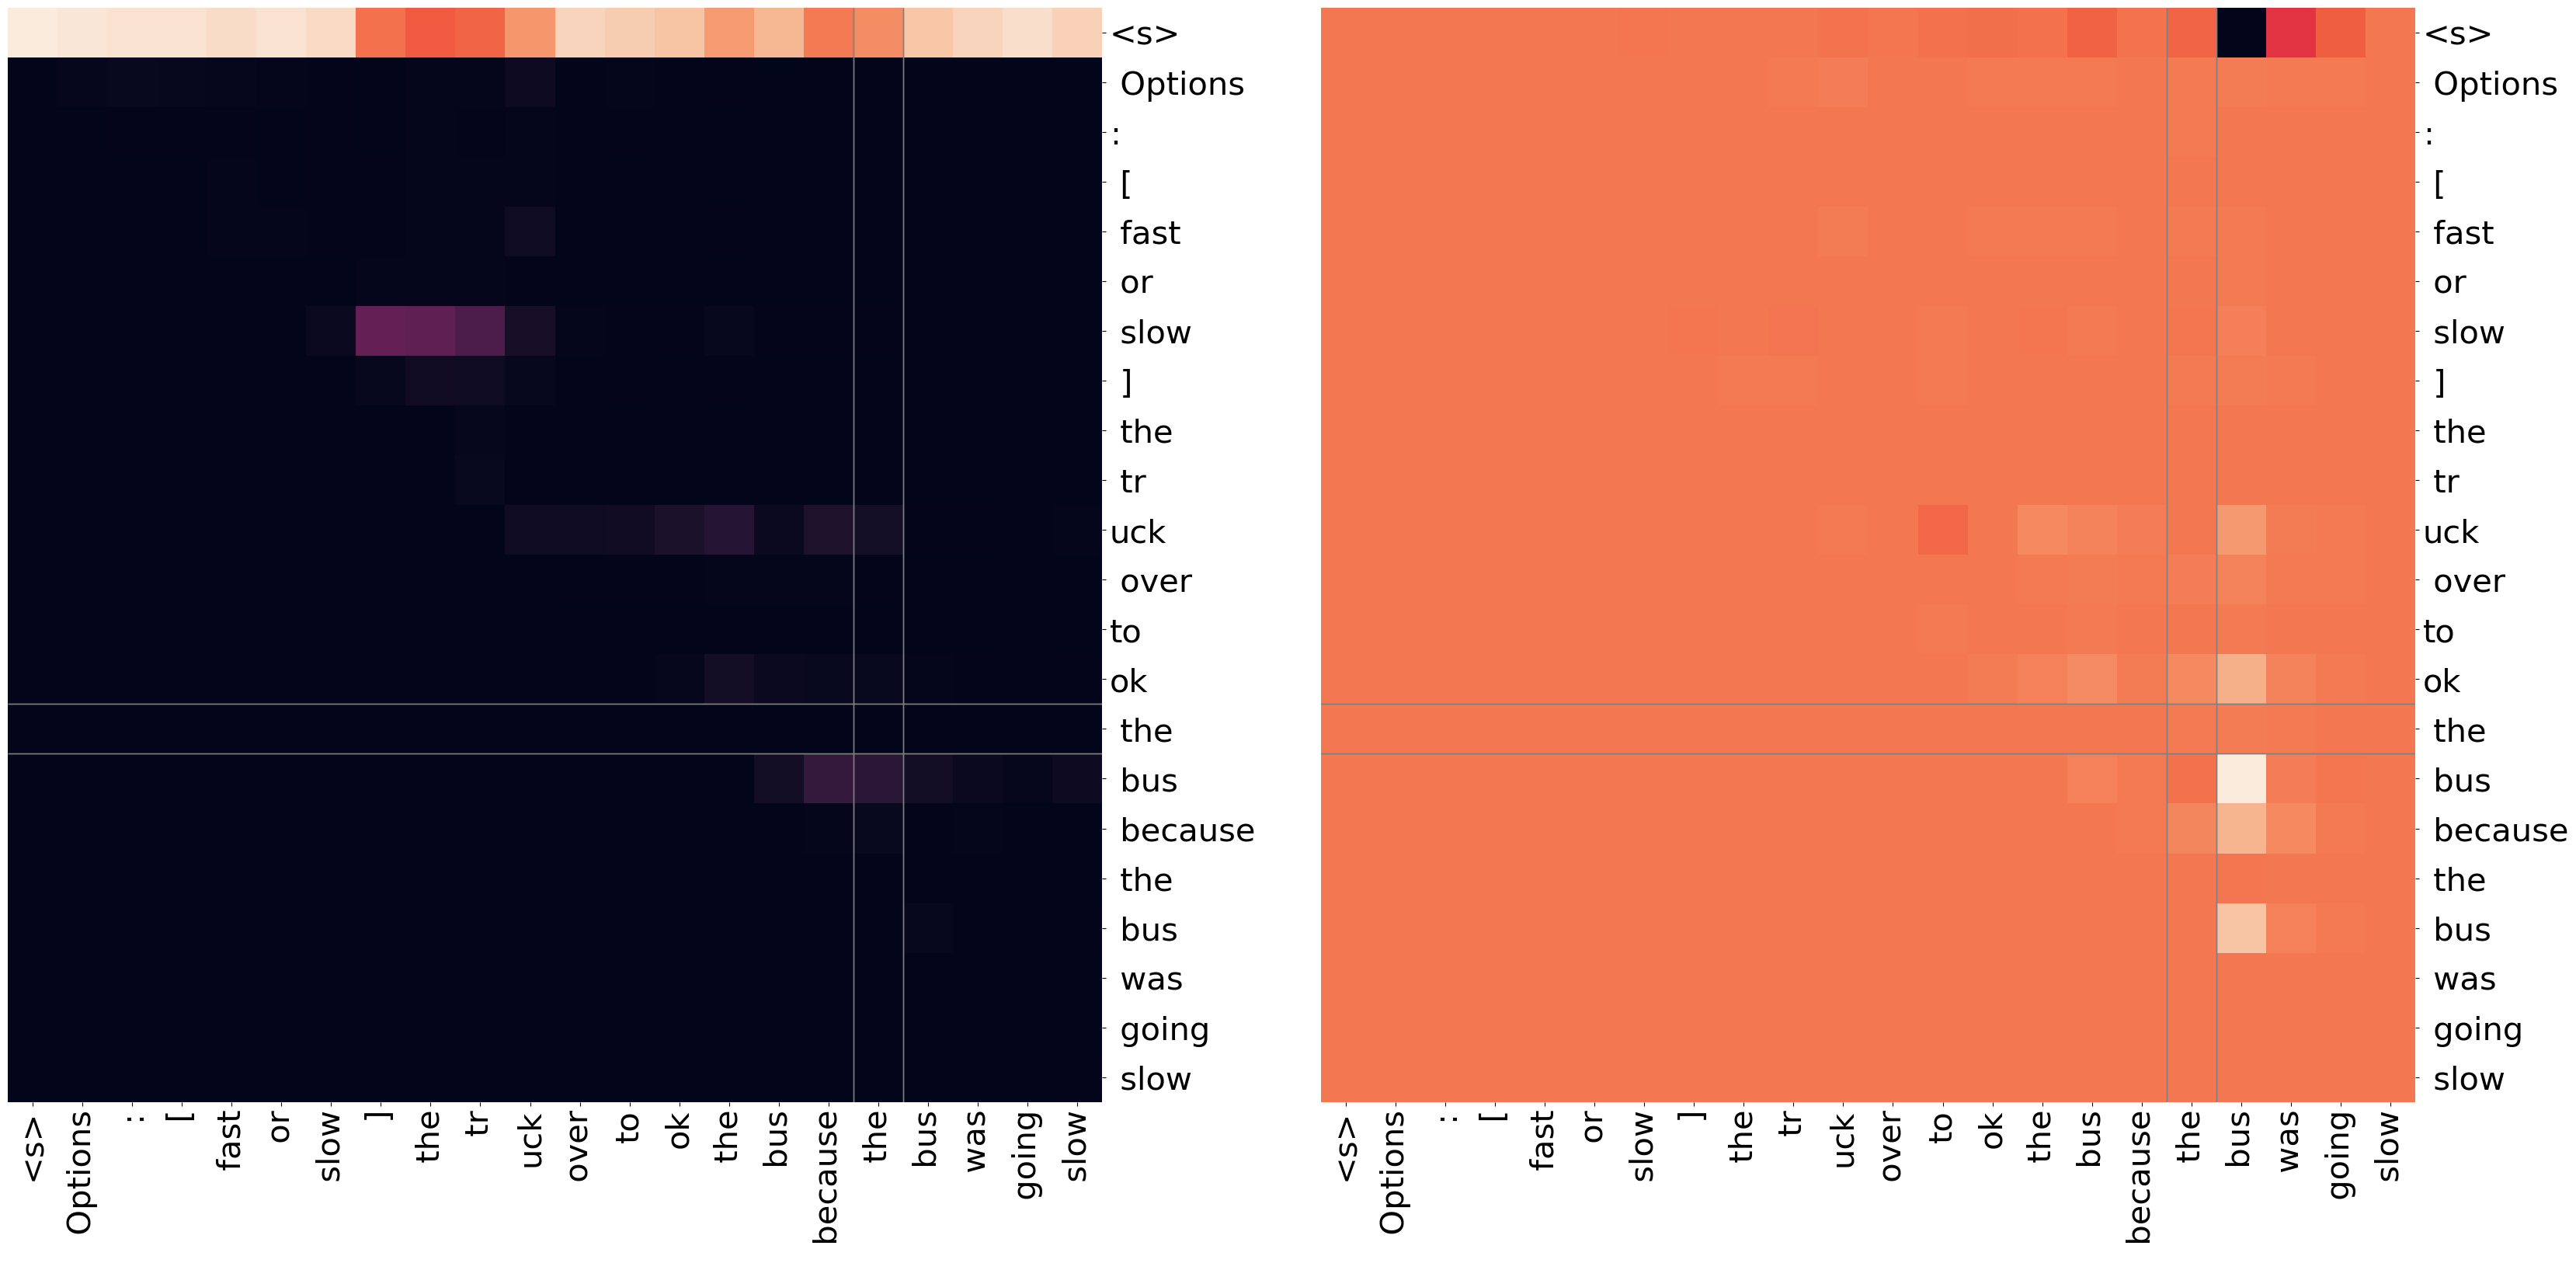

*▁soft 0.527 {'▁soft': 0.527, '▁hard': 0.473, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ soft or hard ] the ball crashed right through the board because the board was soft ▁hard:0.065 *▁soft:0.174
ap_scores = tensor([0.1229]) tensor(0.1229)


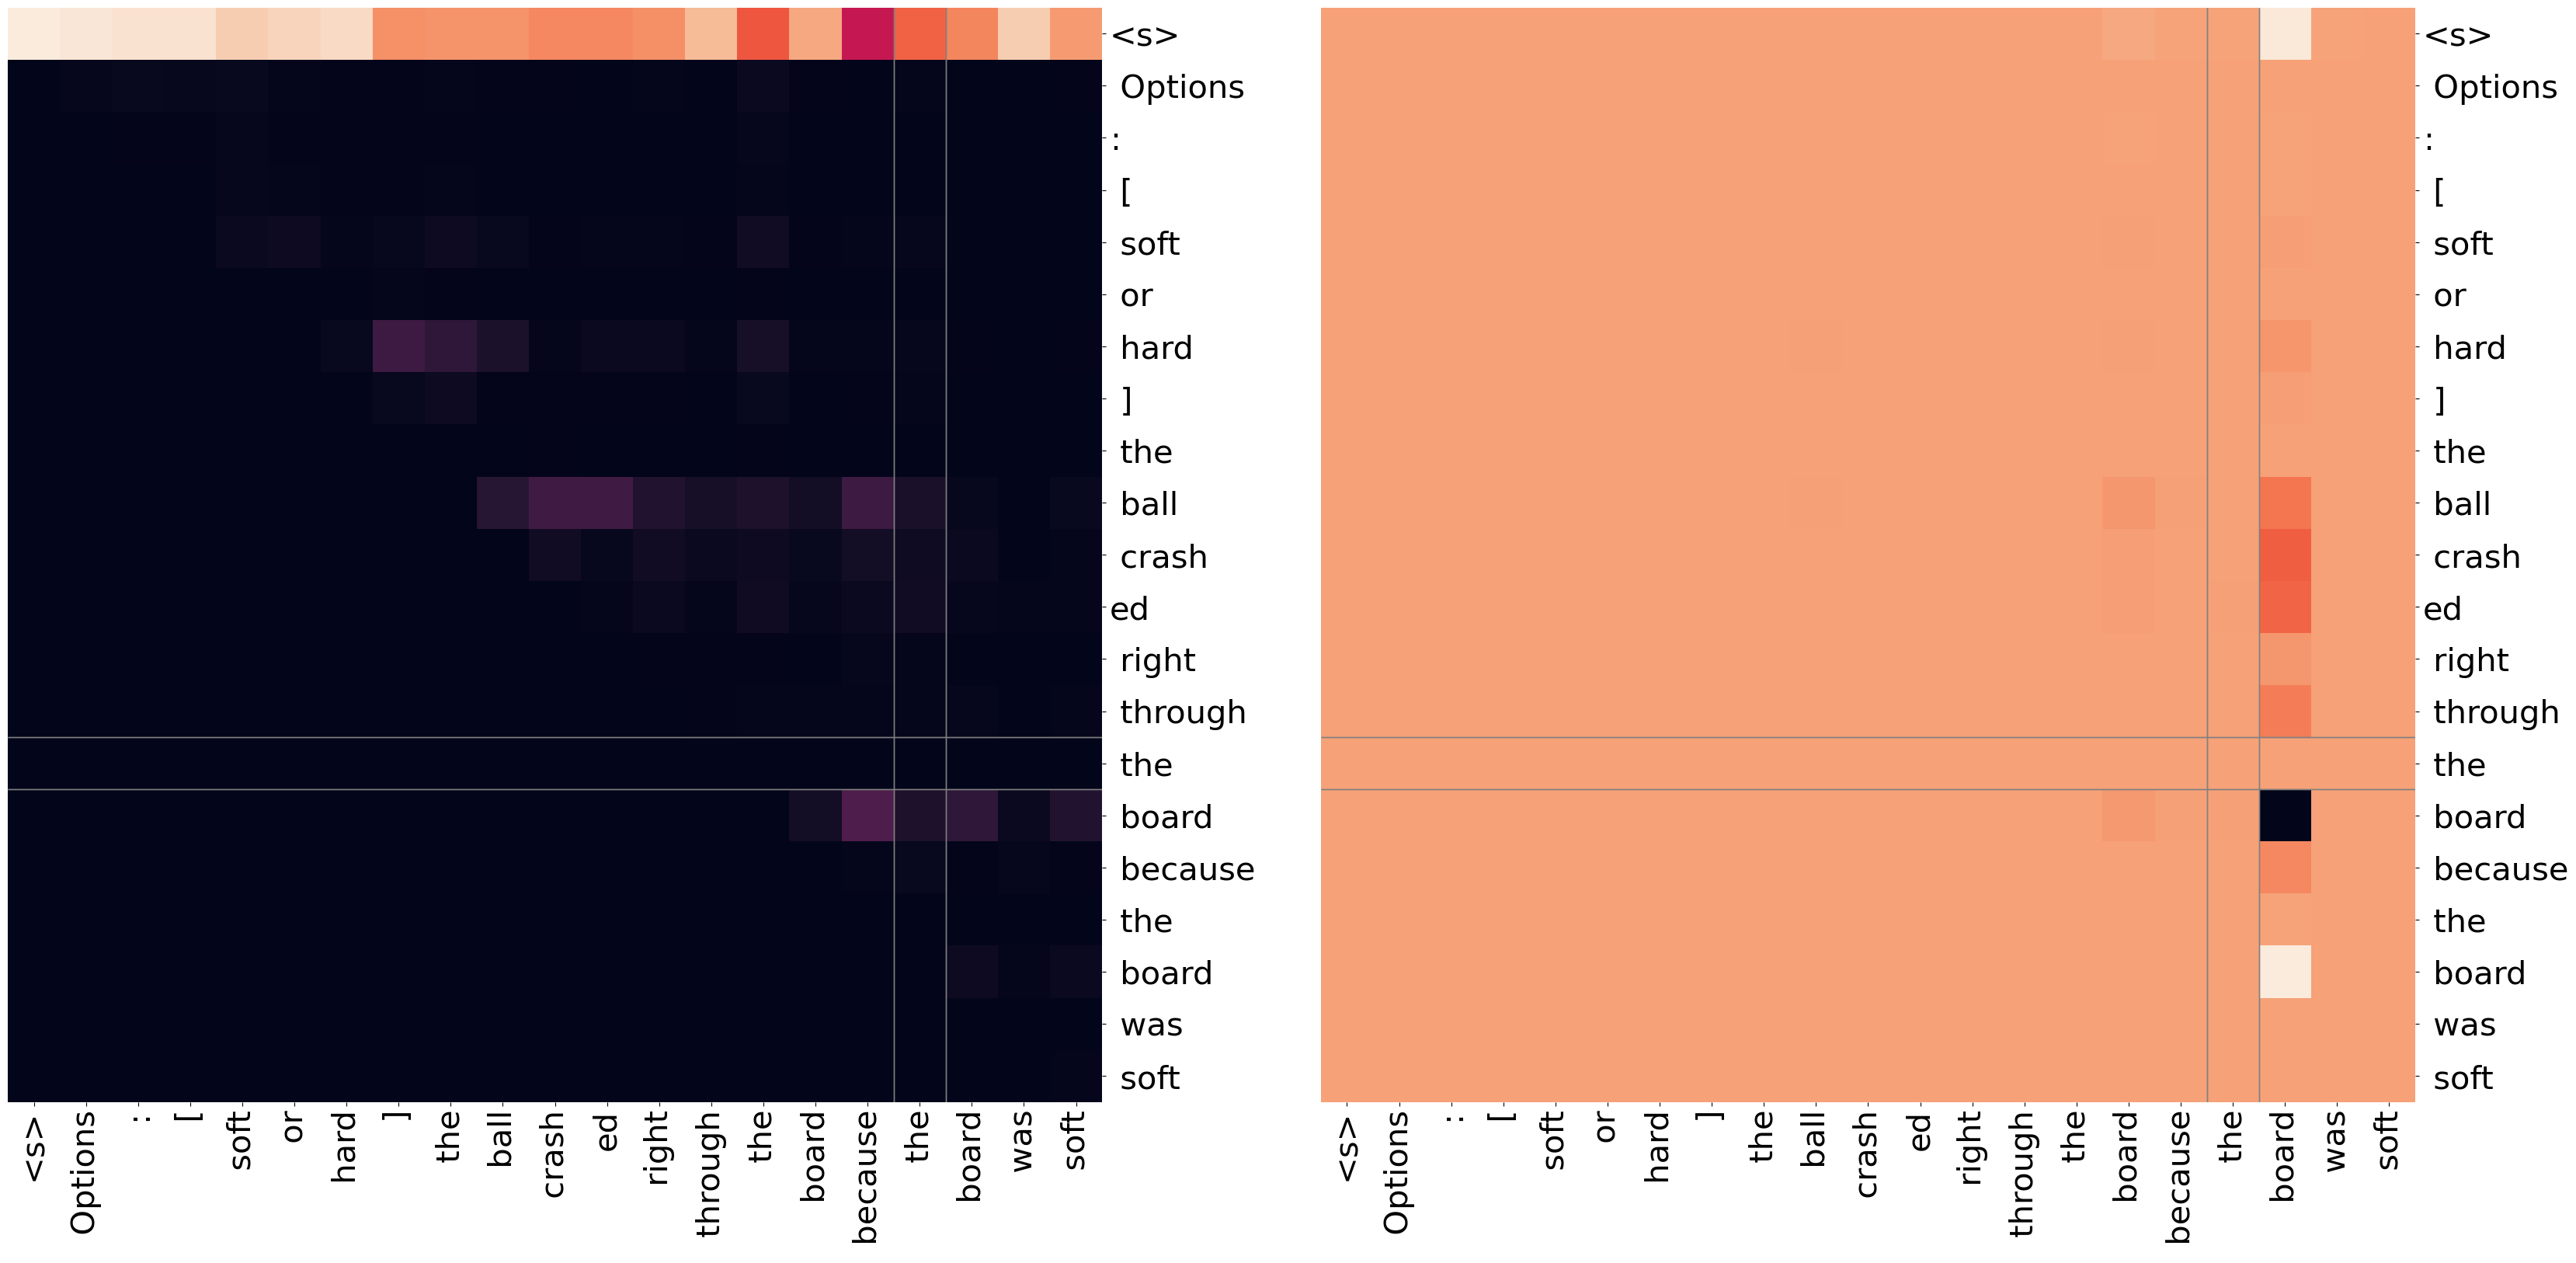

*▁tall 0.51 {'▁tall': 0.51, '▁short': 0.49, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ short or tall ] John couldn't see the stage behind Susan because Susan is tall ▁short:-0.175 *▁tall:-0.136
ap_scores = tensor([0.1064]) tensor(0.1064)


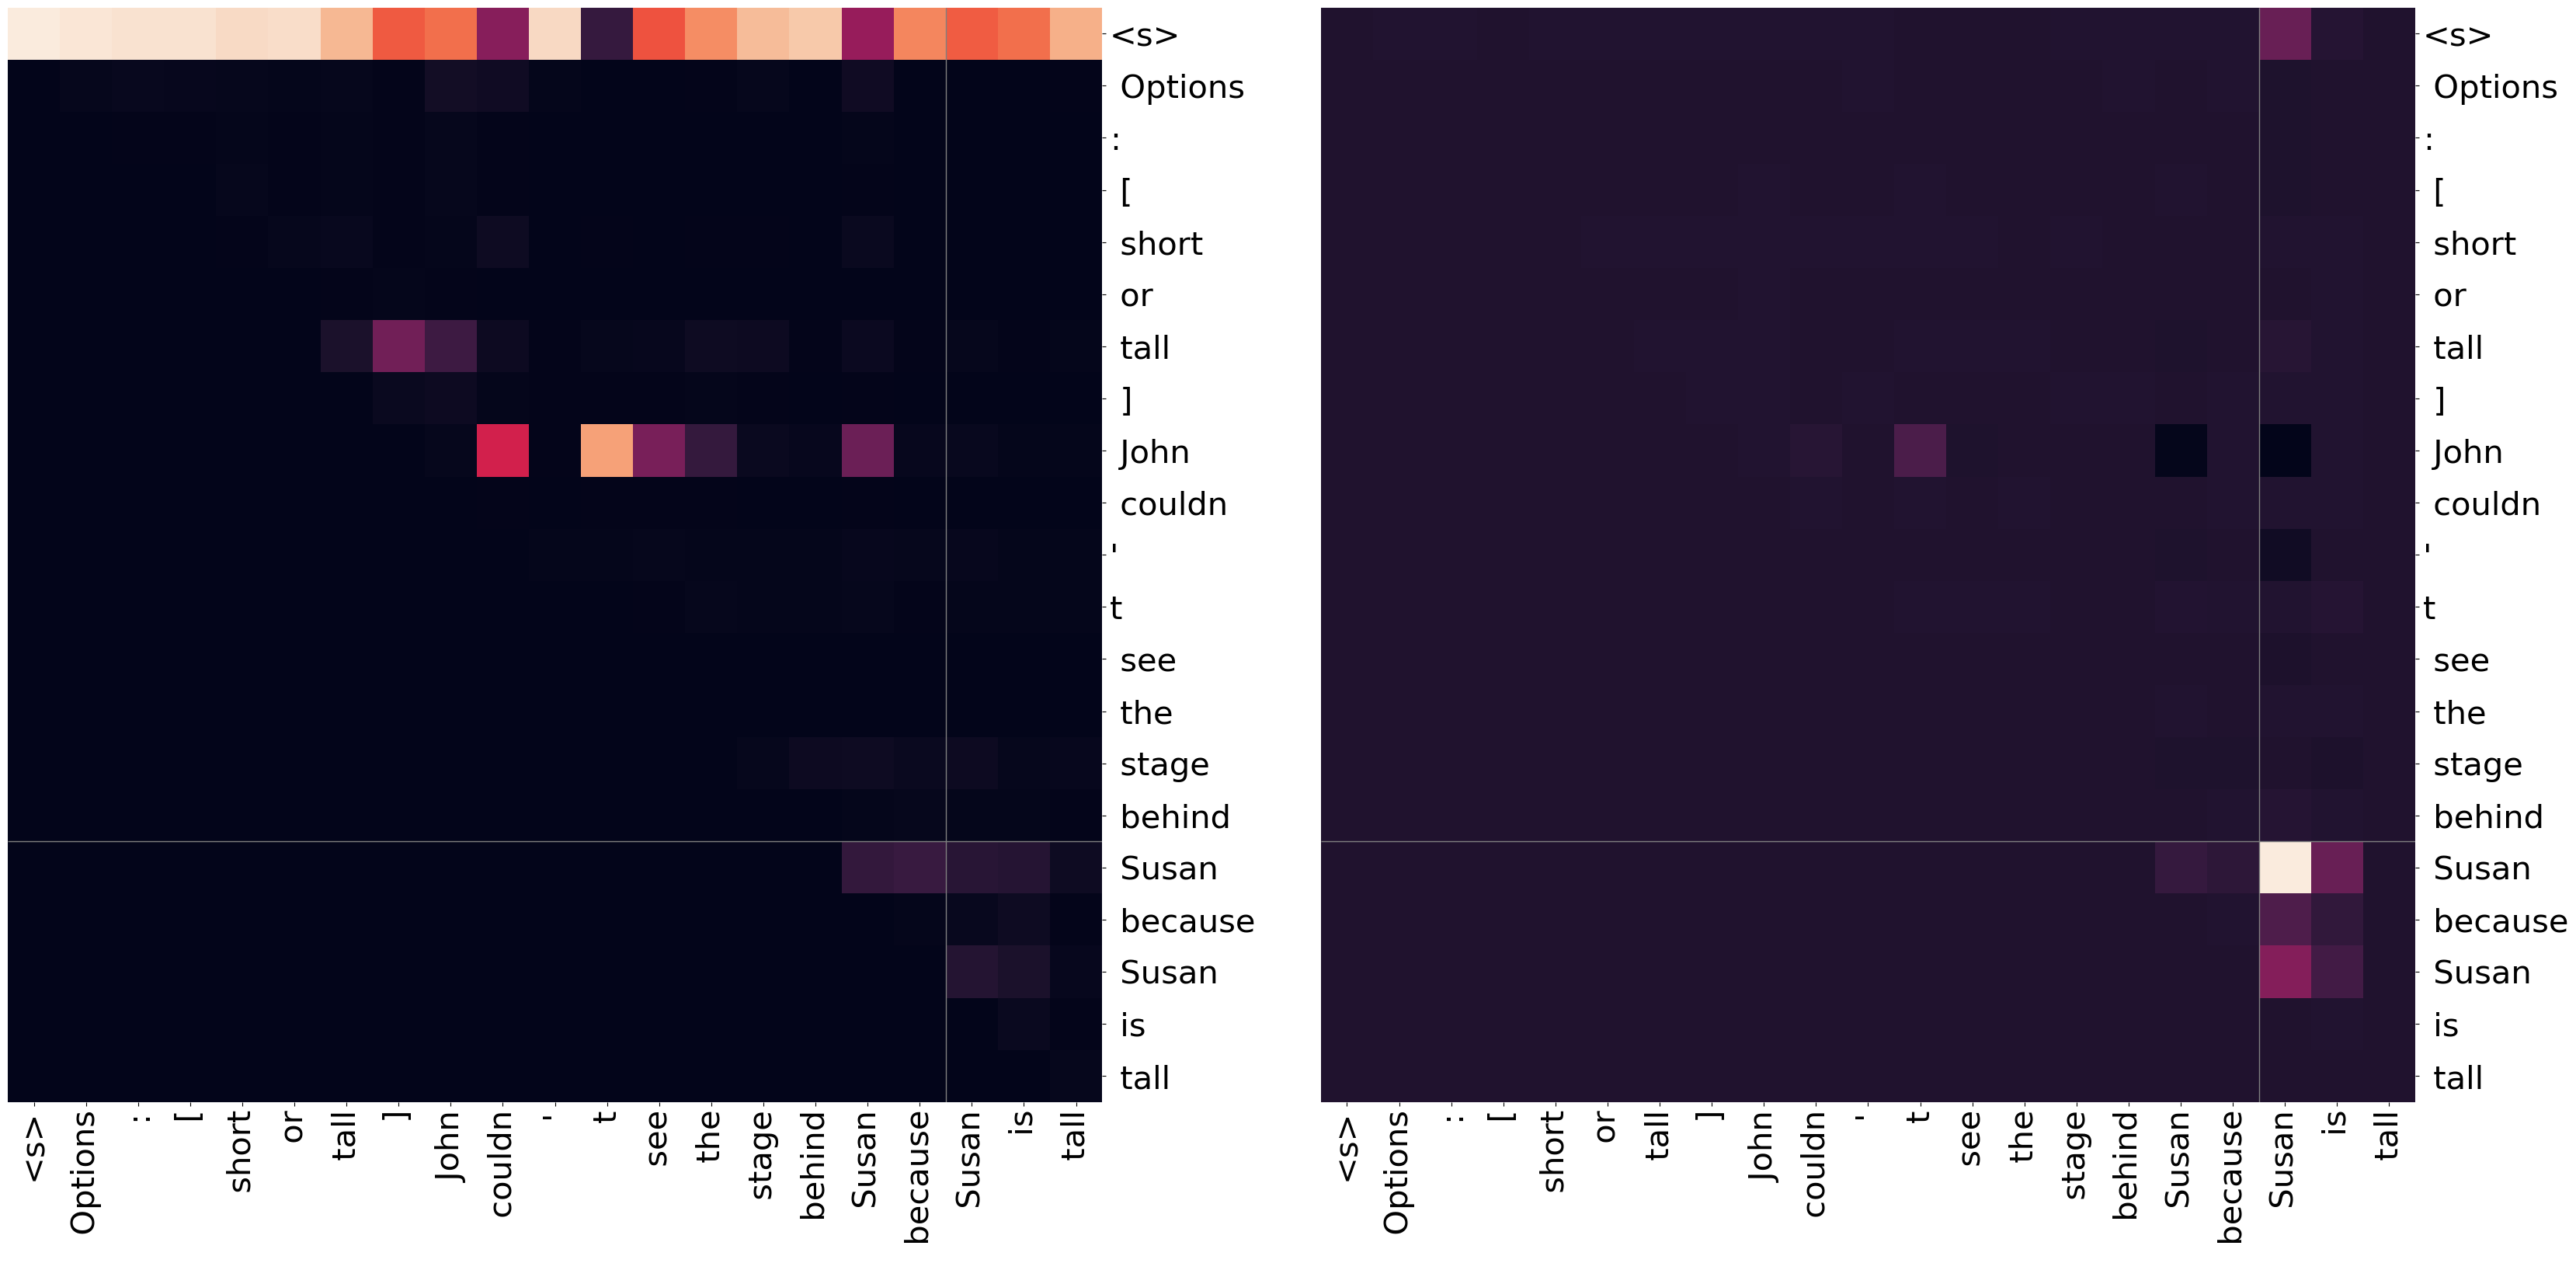

 ▁later 0.453 {'▁first': 0.547, '▁later': 0.453, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ first or later ] the bag of potatoes had been placed above the bag of flour so the bag of flour had to be moved later ▁first:0.111 *▁later:-0.078
ap_scores = tensor([0.2703]) tensor(0.2703)


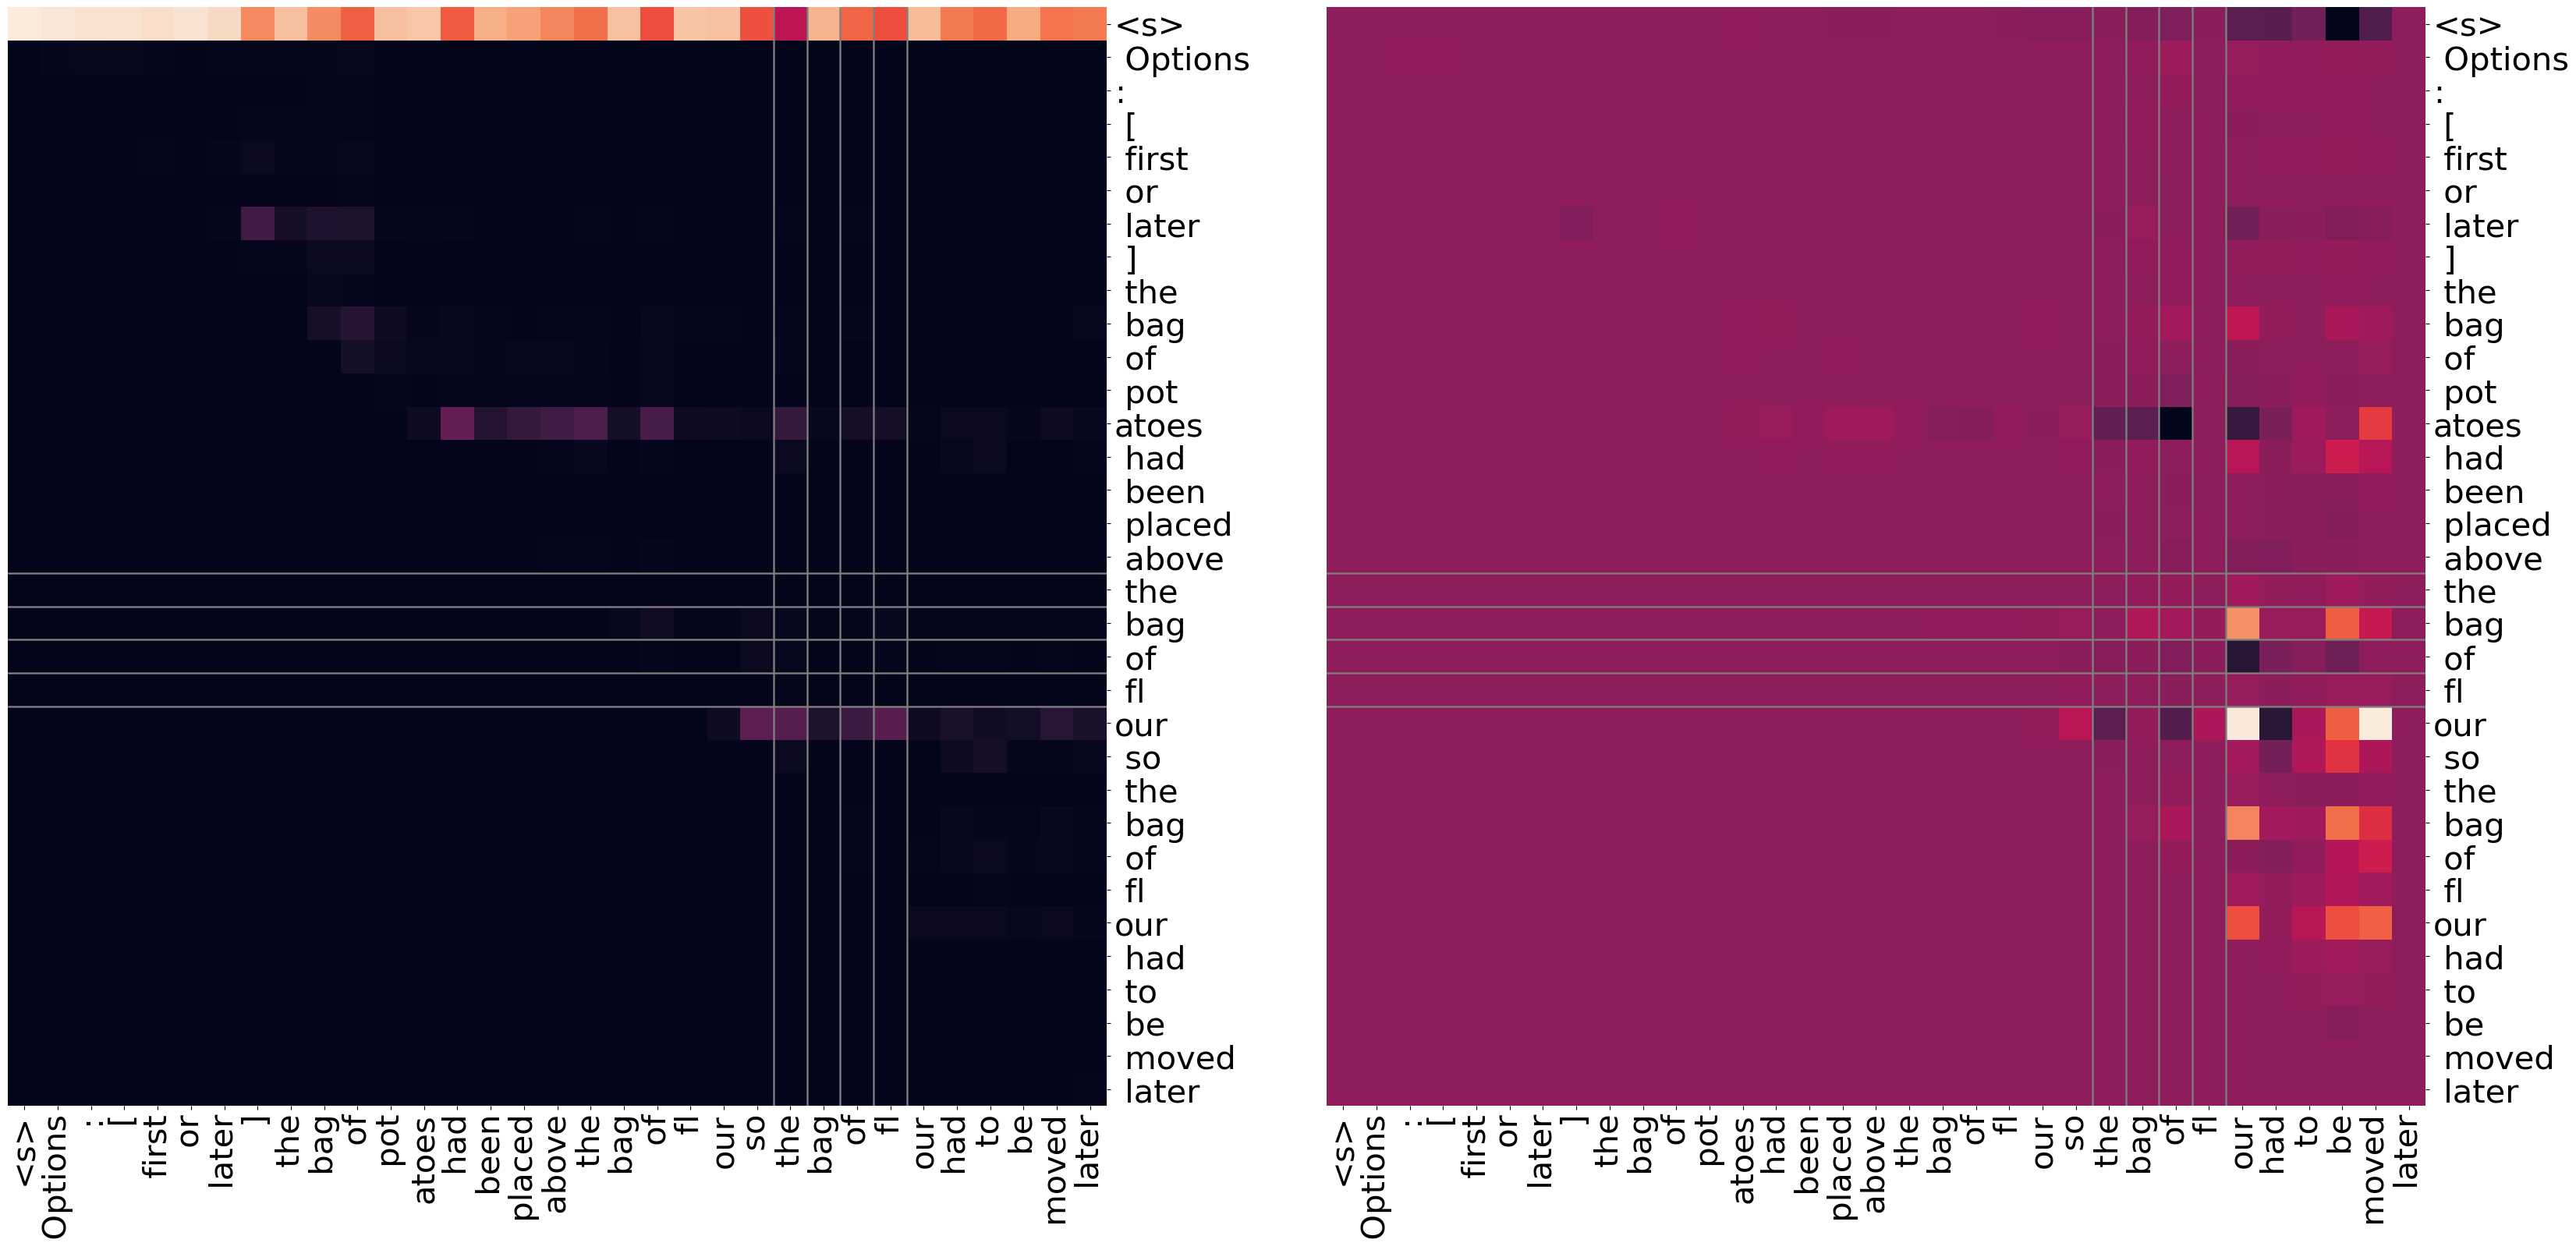

 ▁full 0.385 {'▁empty': 0.614, '▁full': 0.386, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ empty or full ] the bottle was filled with water from the cup after the cup was full ▁empty:0.753 *▁full:0.287
ap_scores = tensor([0.1684]) tensor(0.1684)


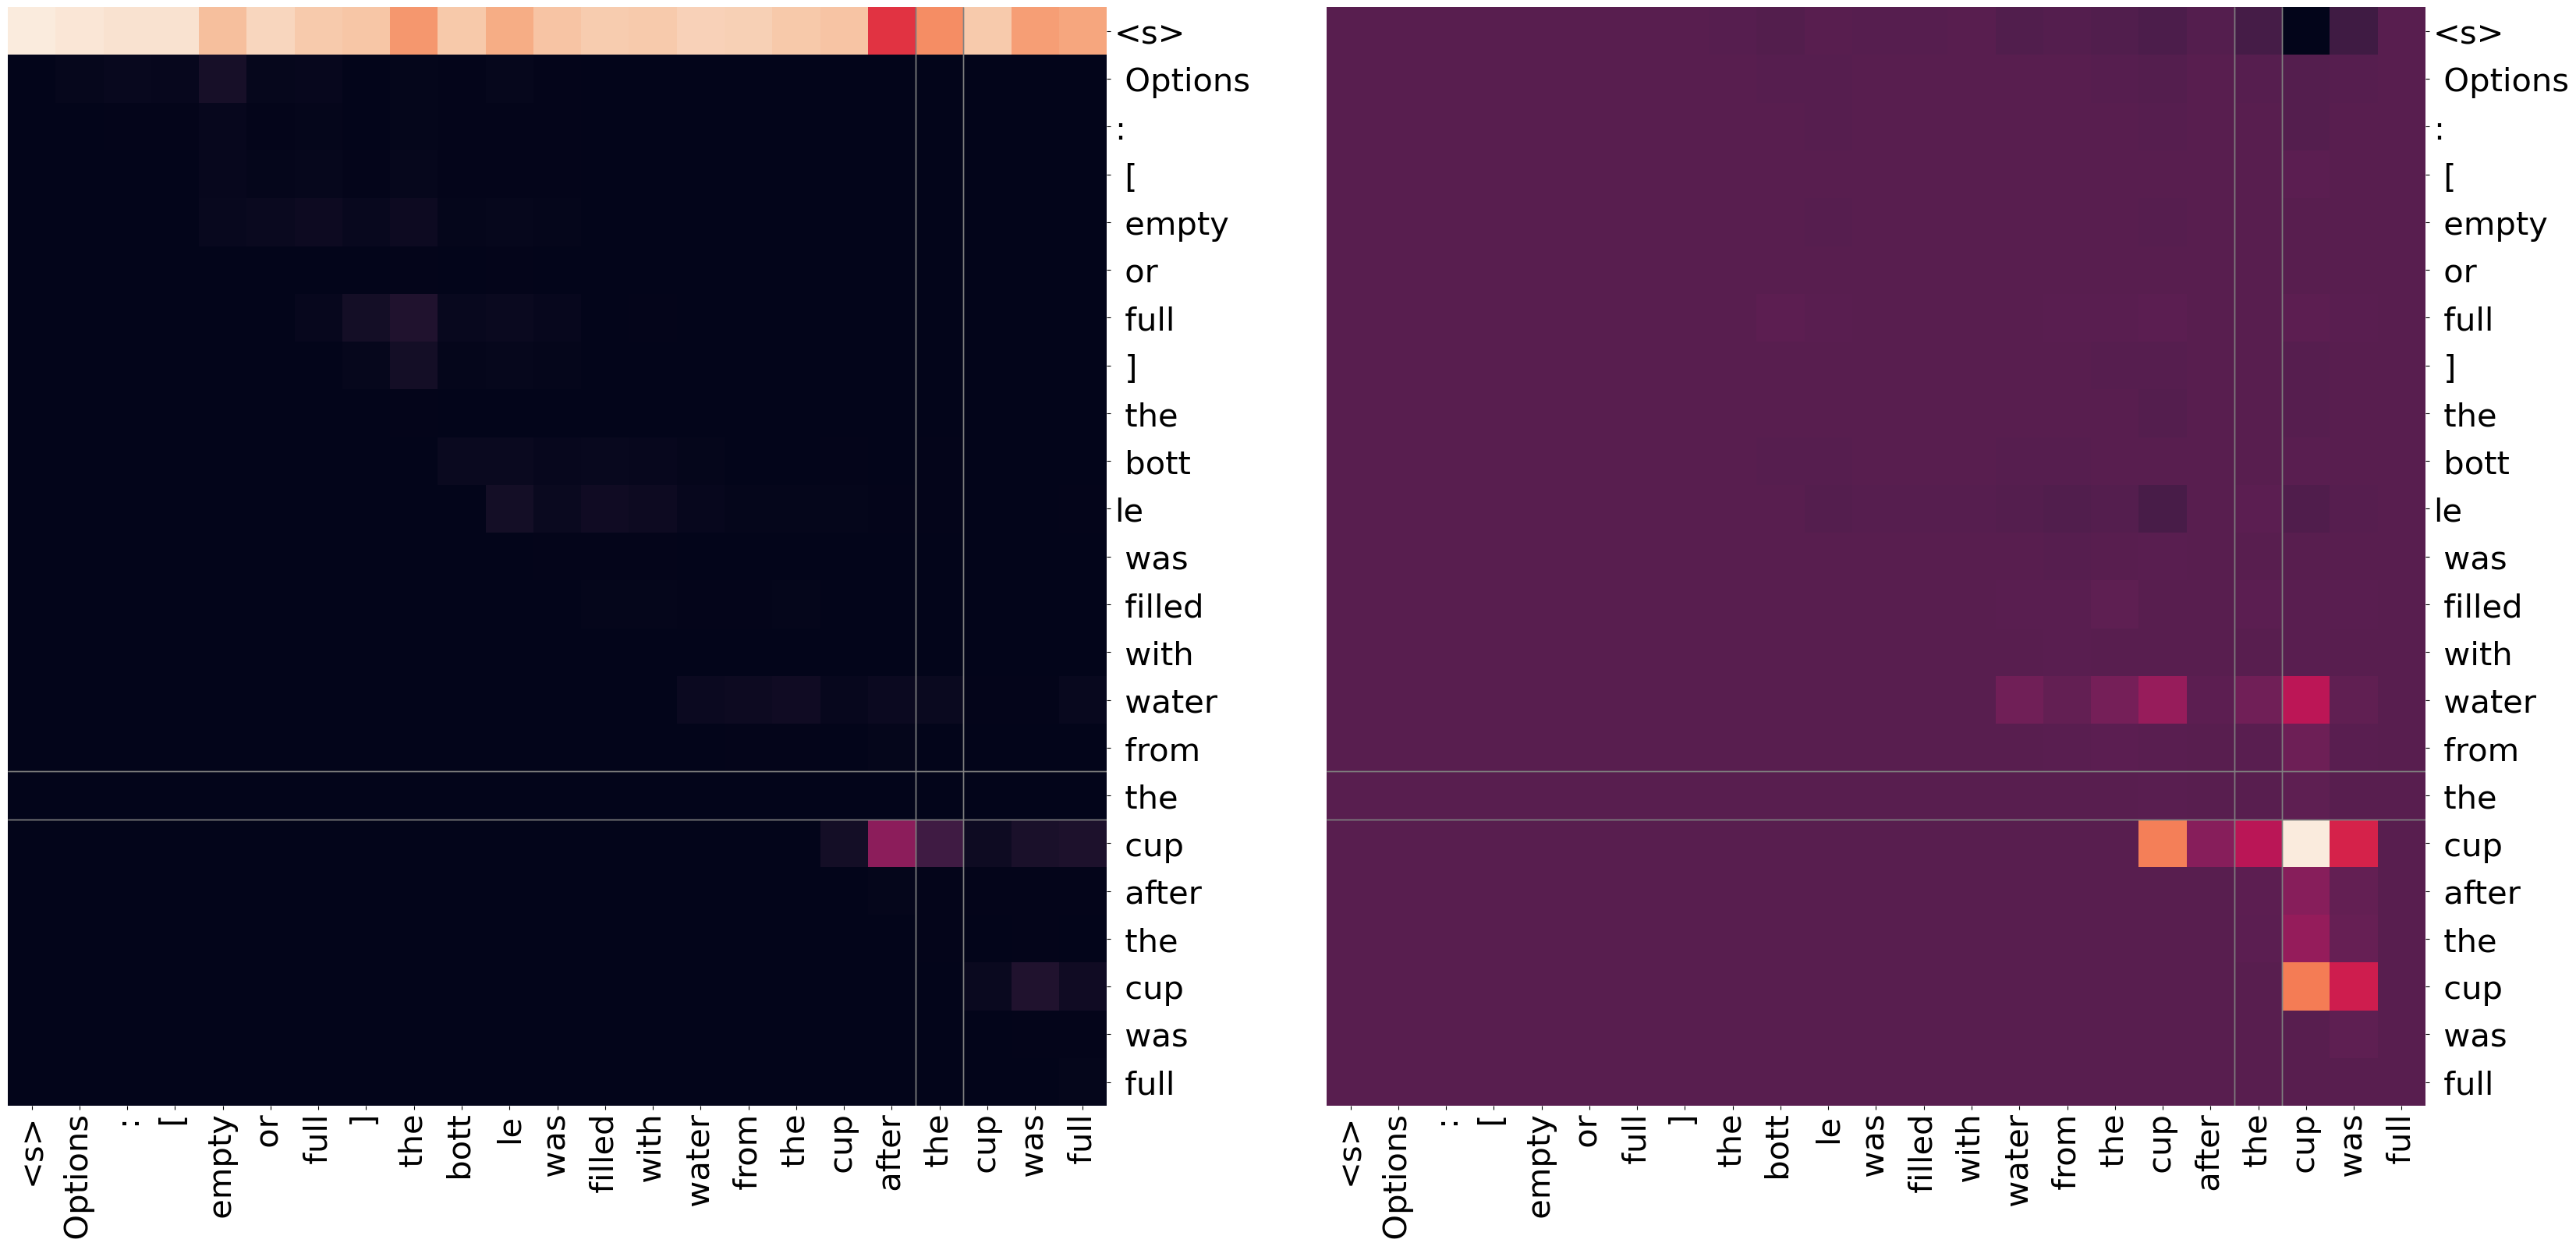

 ▁younger 0.426 {'▁older': 0.574, '▁younger': 0.426, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ younger or older ] Jack always takes care of Betty because Betty is younger ▁older:0.249 *▁younger:-0.050
ap_scores = tensor([0.1475]) tensor(0.1475)


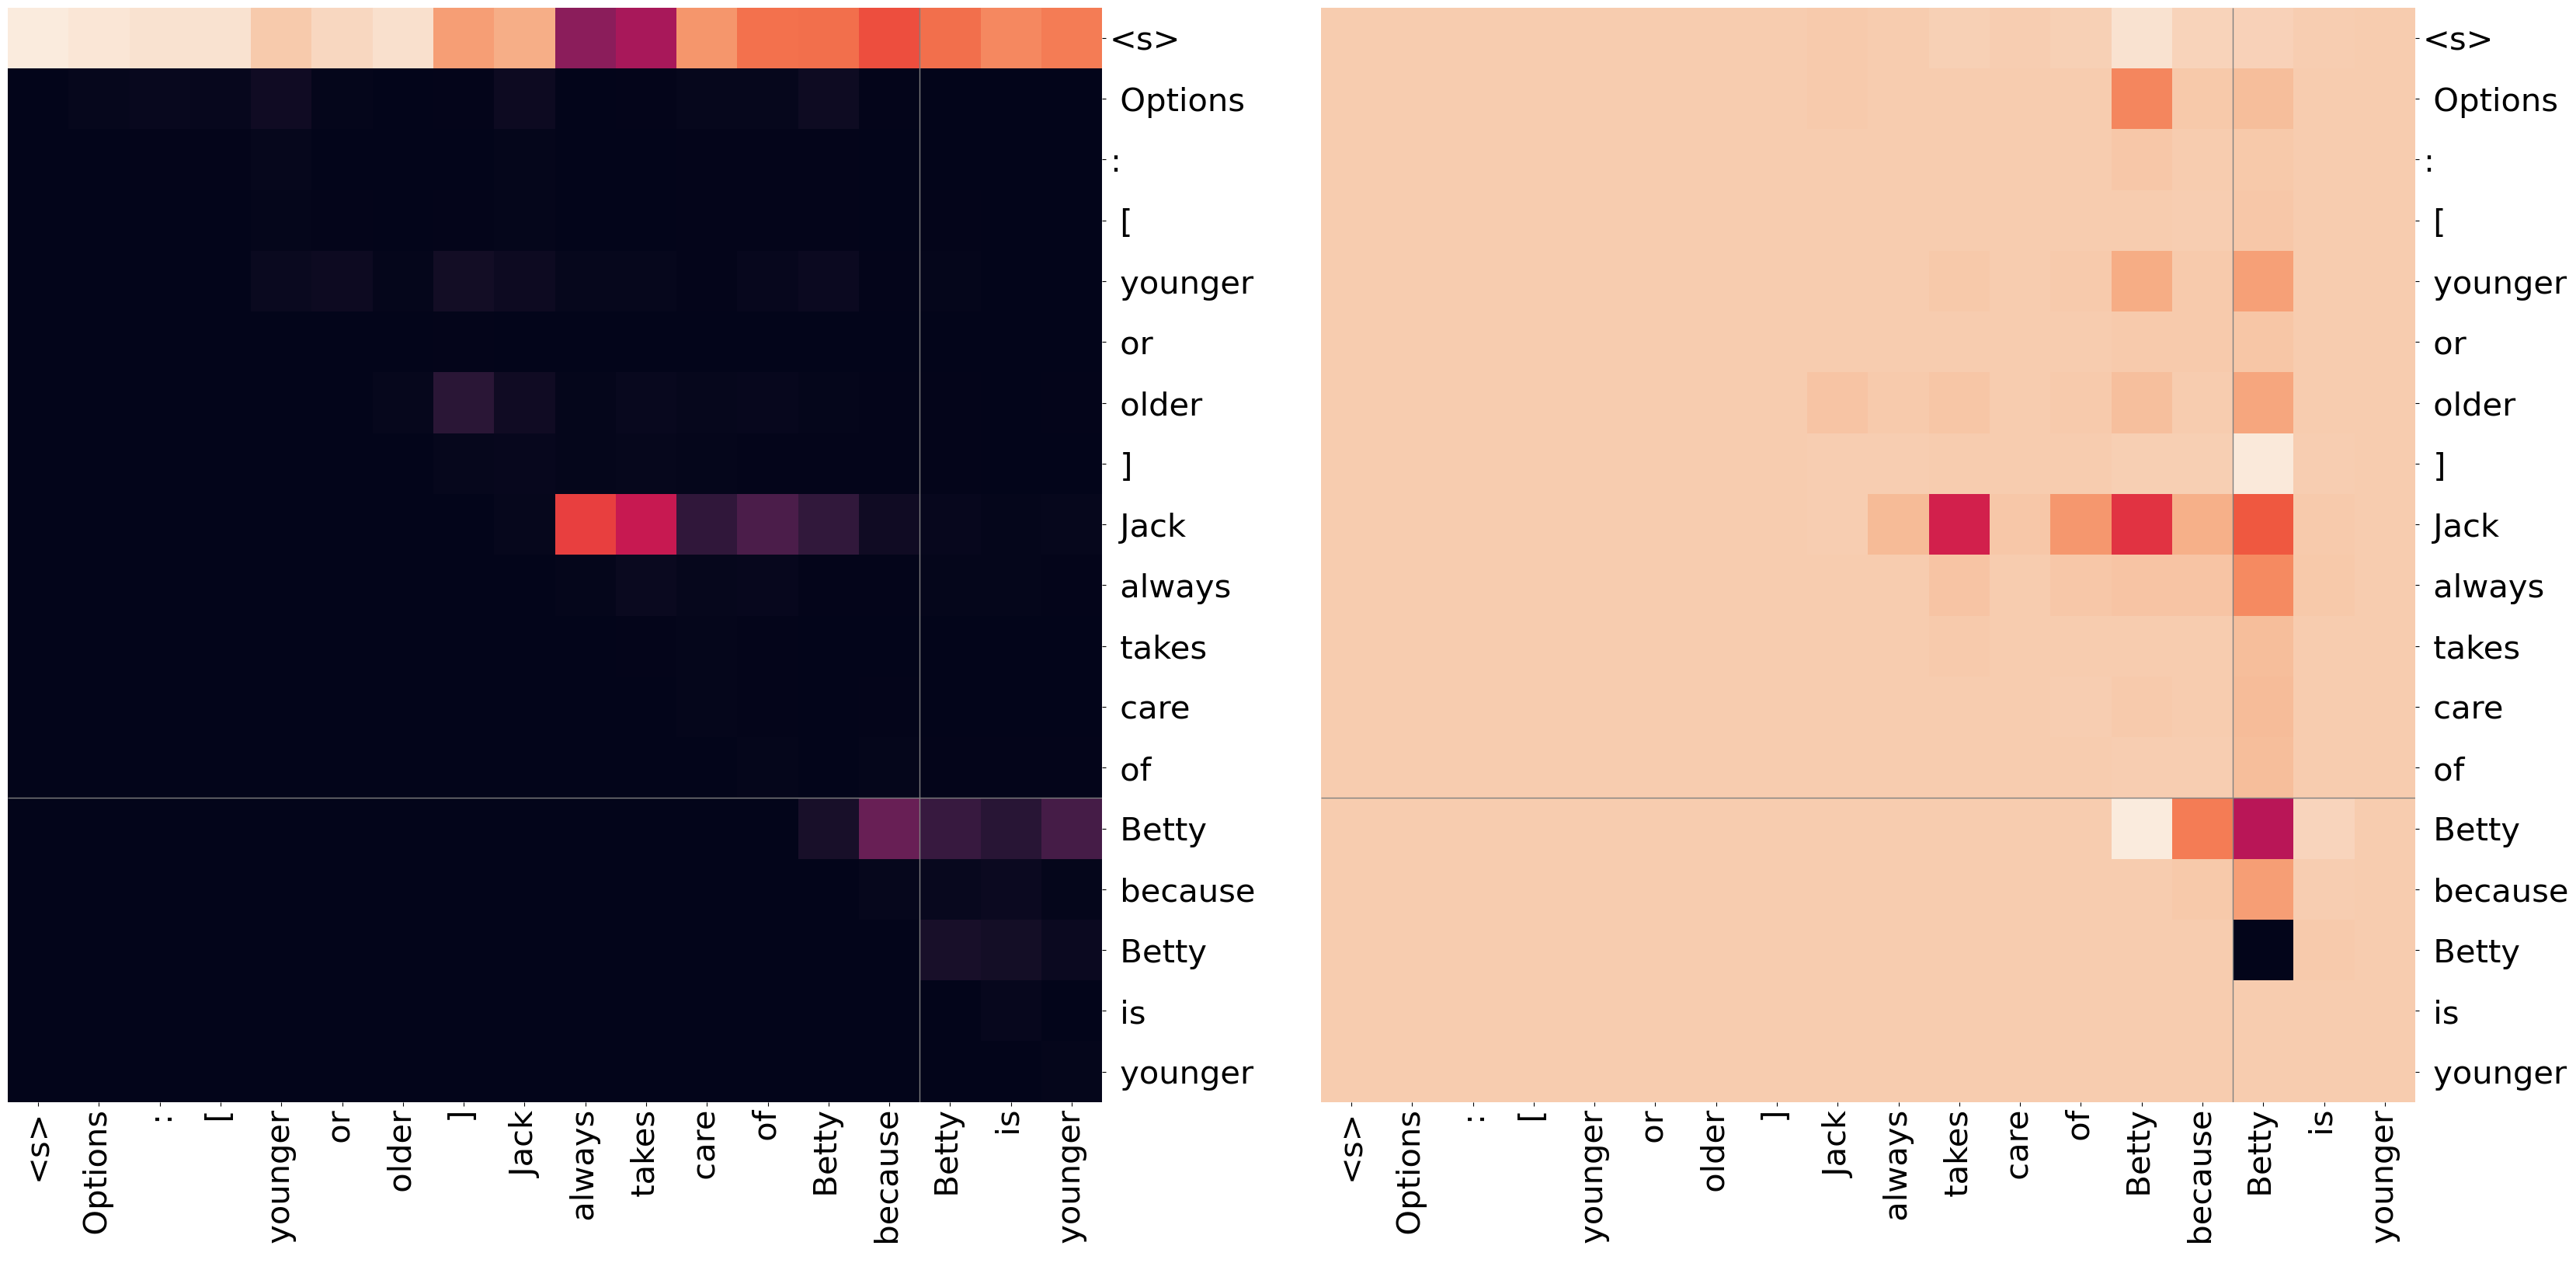

 ▁majority 0.486 {'▁minor': 0.514, '▁majority': 0.486, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ majority or minority ] the sponsors were less in number than the opponents so the opponents were in the majority ▁minor:0.044 *▁majority:-0.010
ap_scores = tensor([0.1207]) tensor(0.1207)


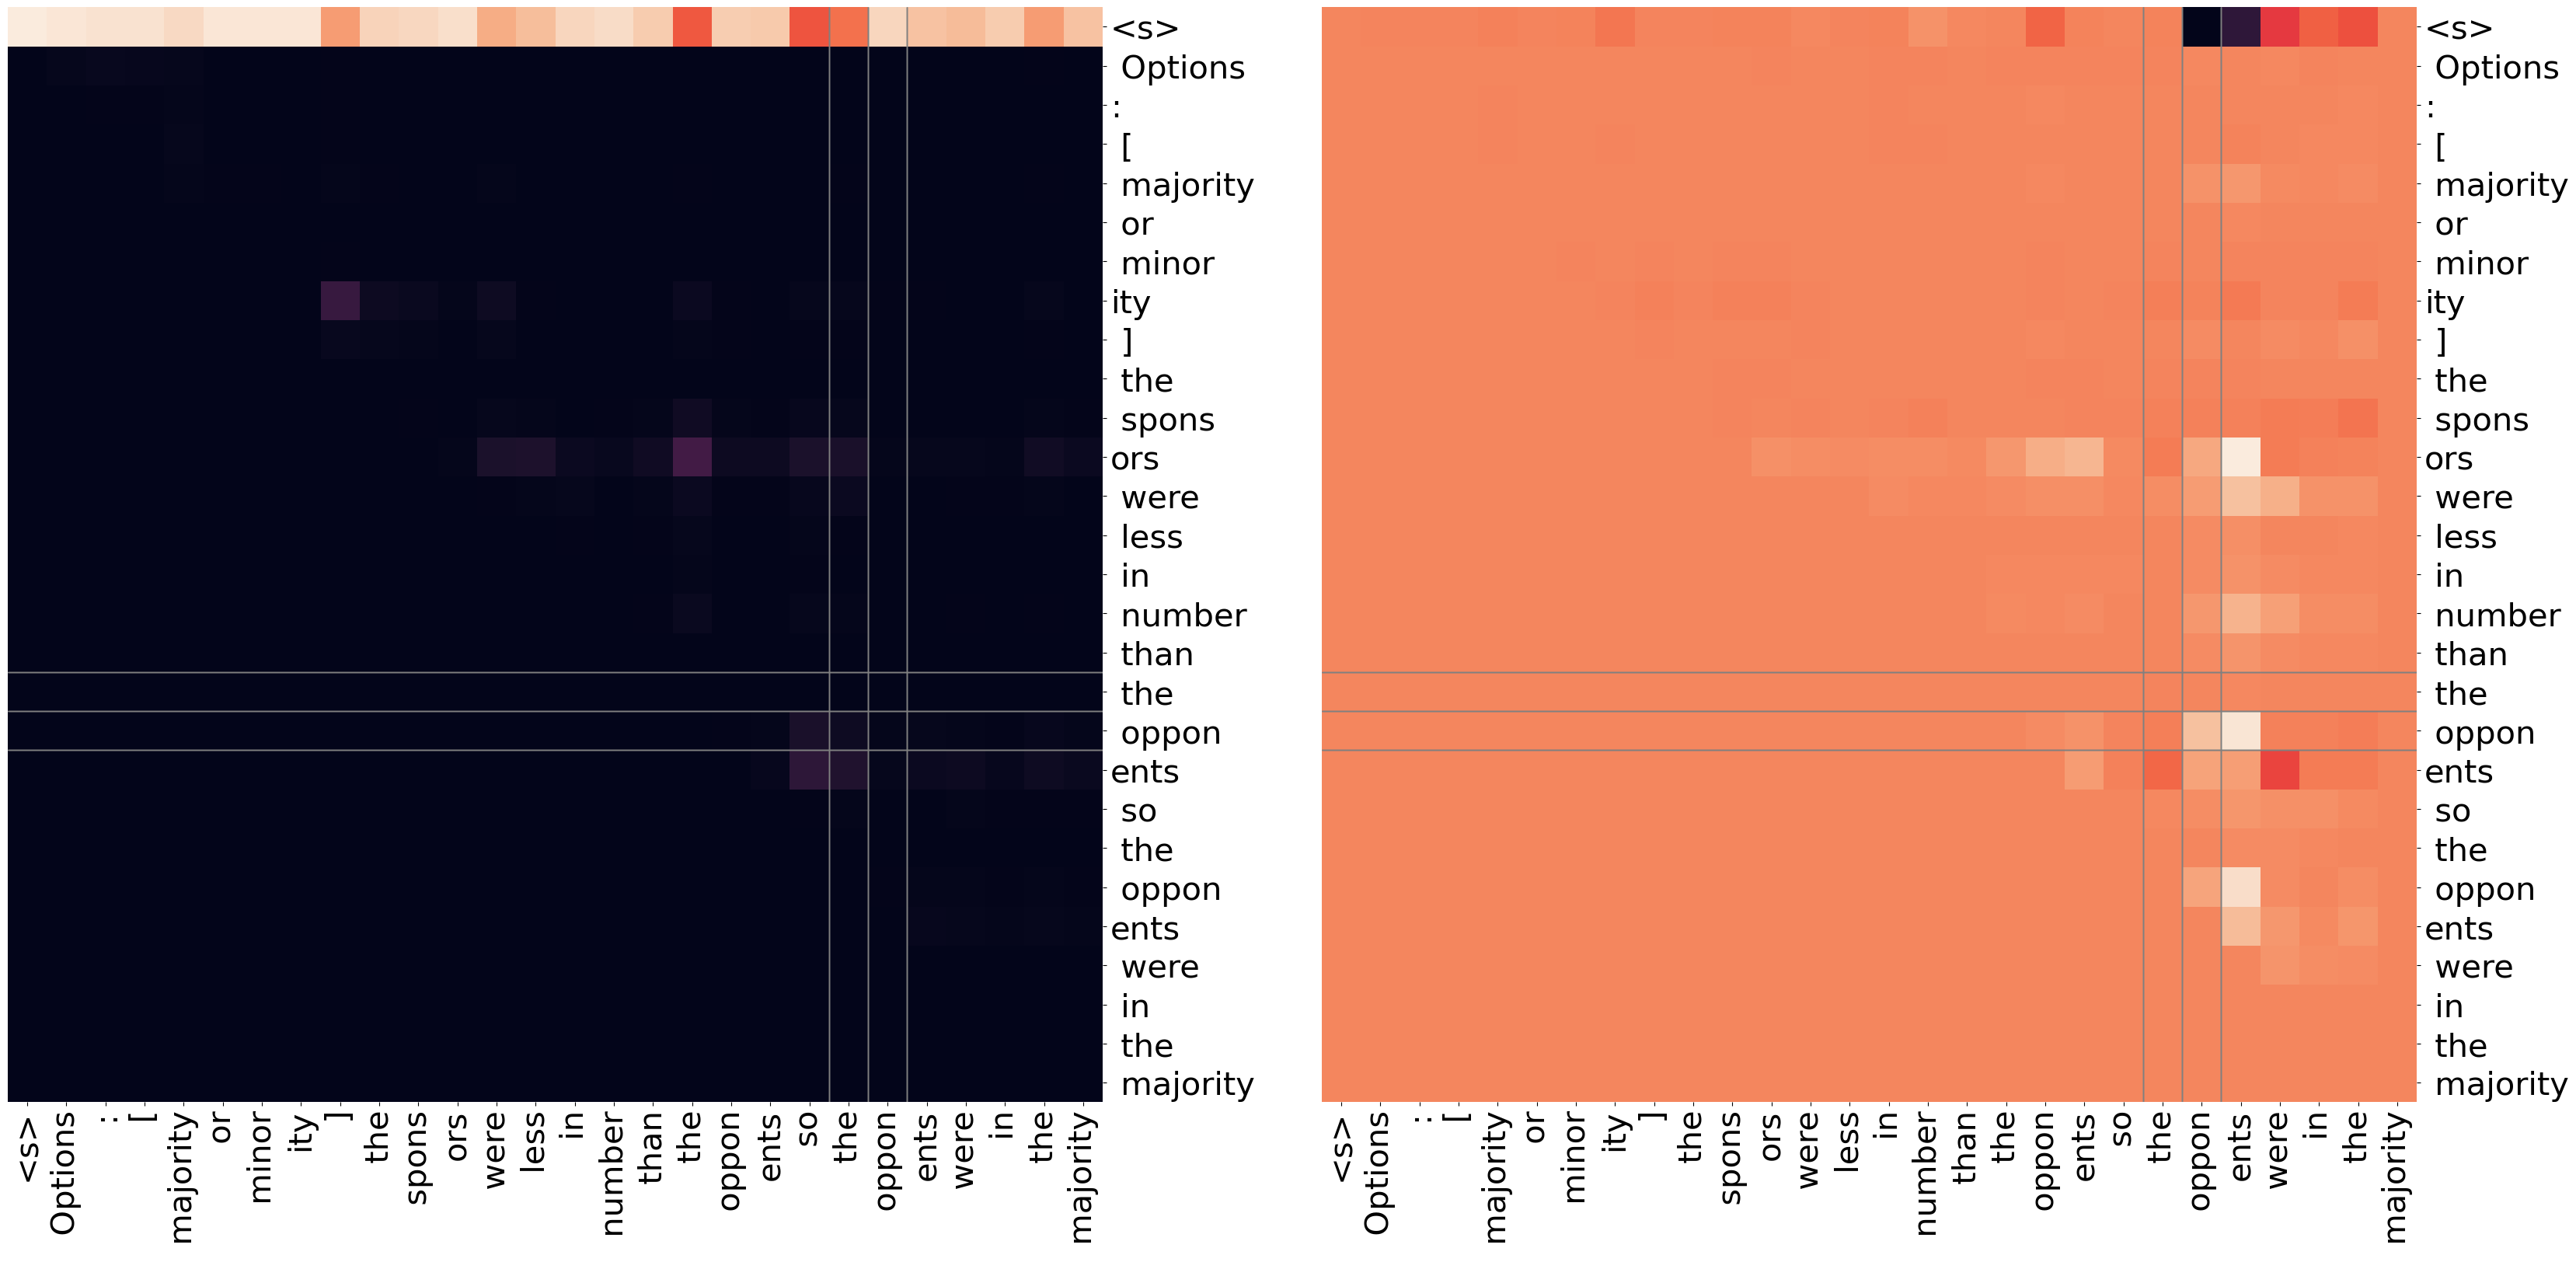

*▁wide 0.544 {'▁wide': 0.544, '▁narrow': 0.455, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ wide or narrow ] the table will fit through the doorway because the doorway is wide *▁wide:0.098 ▁narrow:-0.080
ap_scores = tensor([0.0990]) tensor(0.0990)


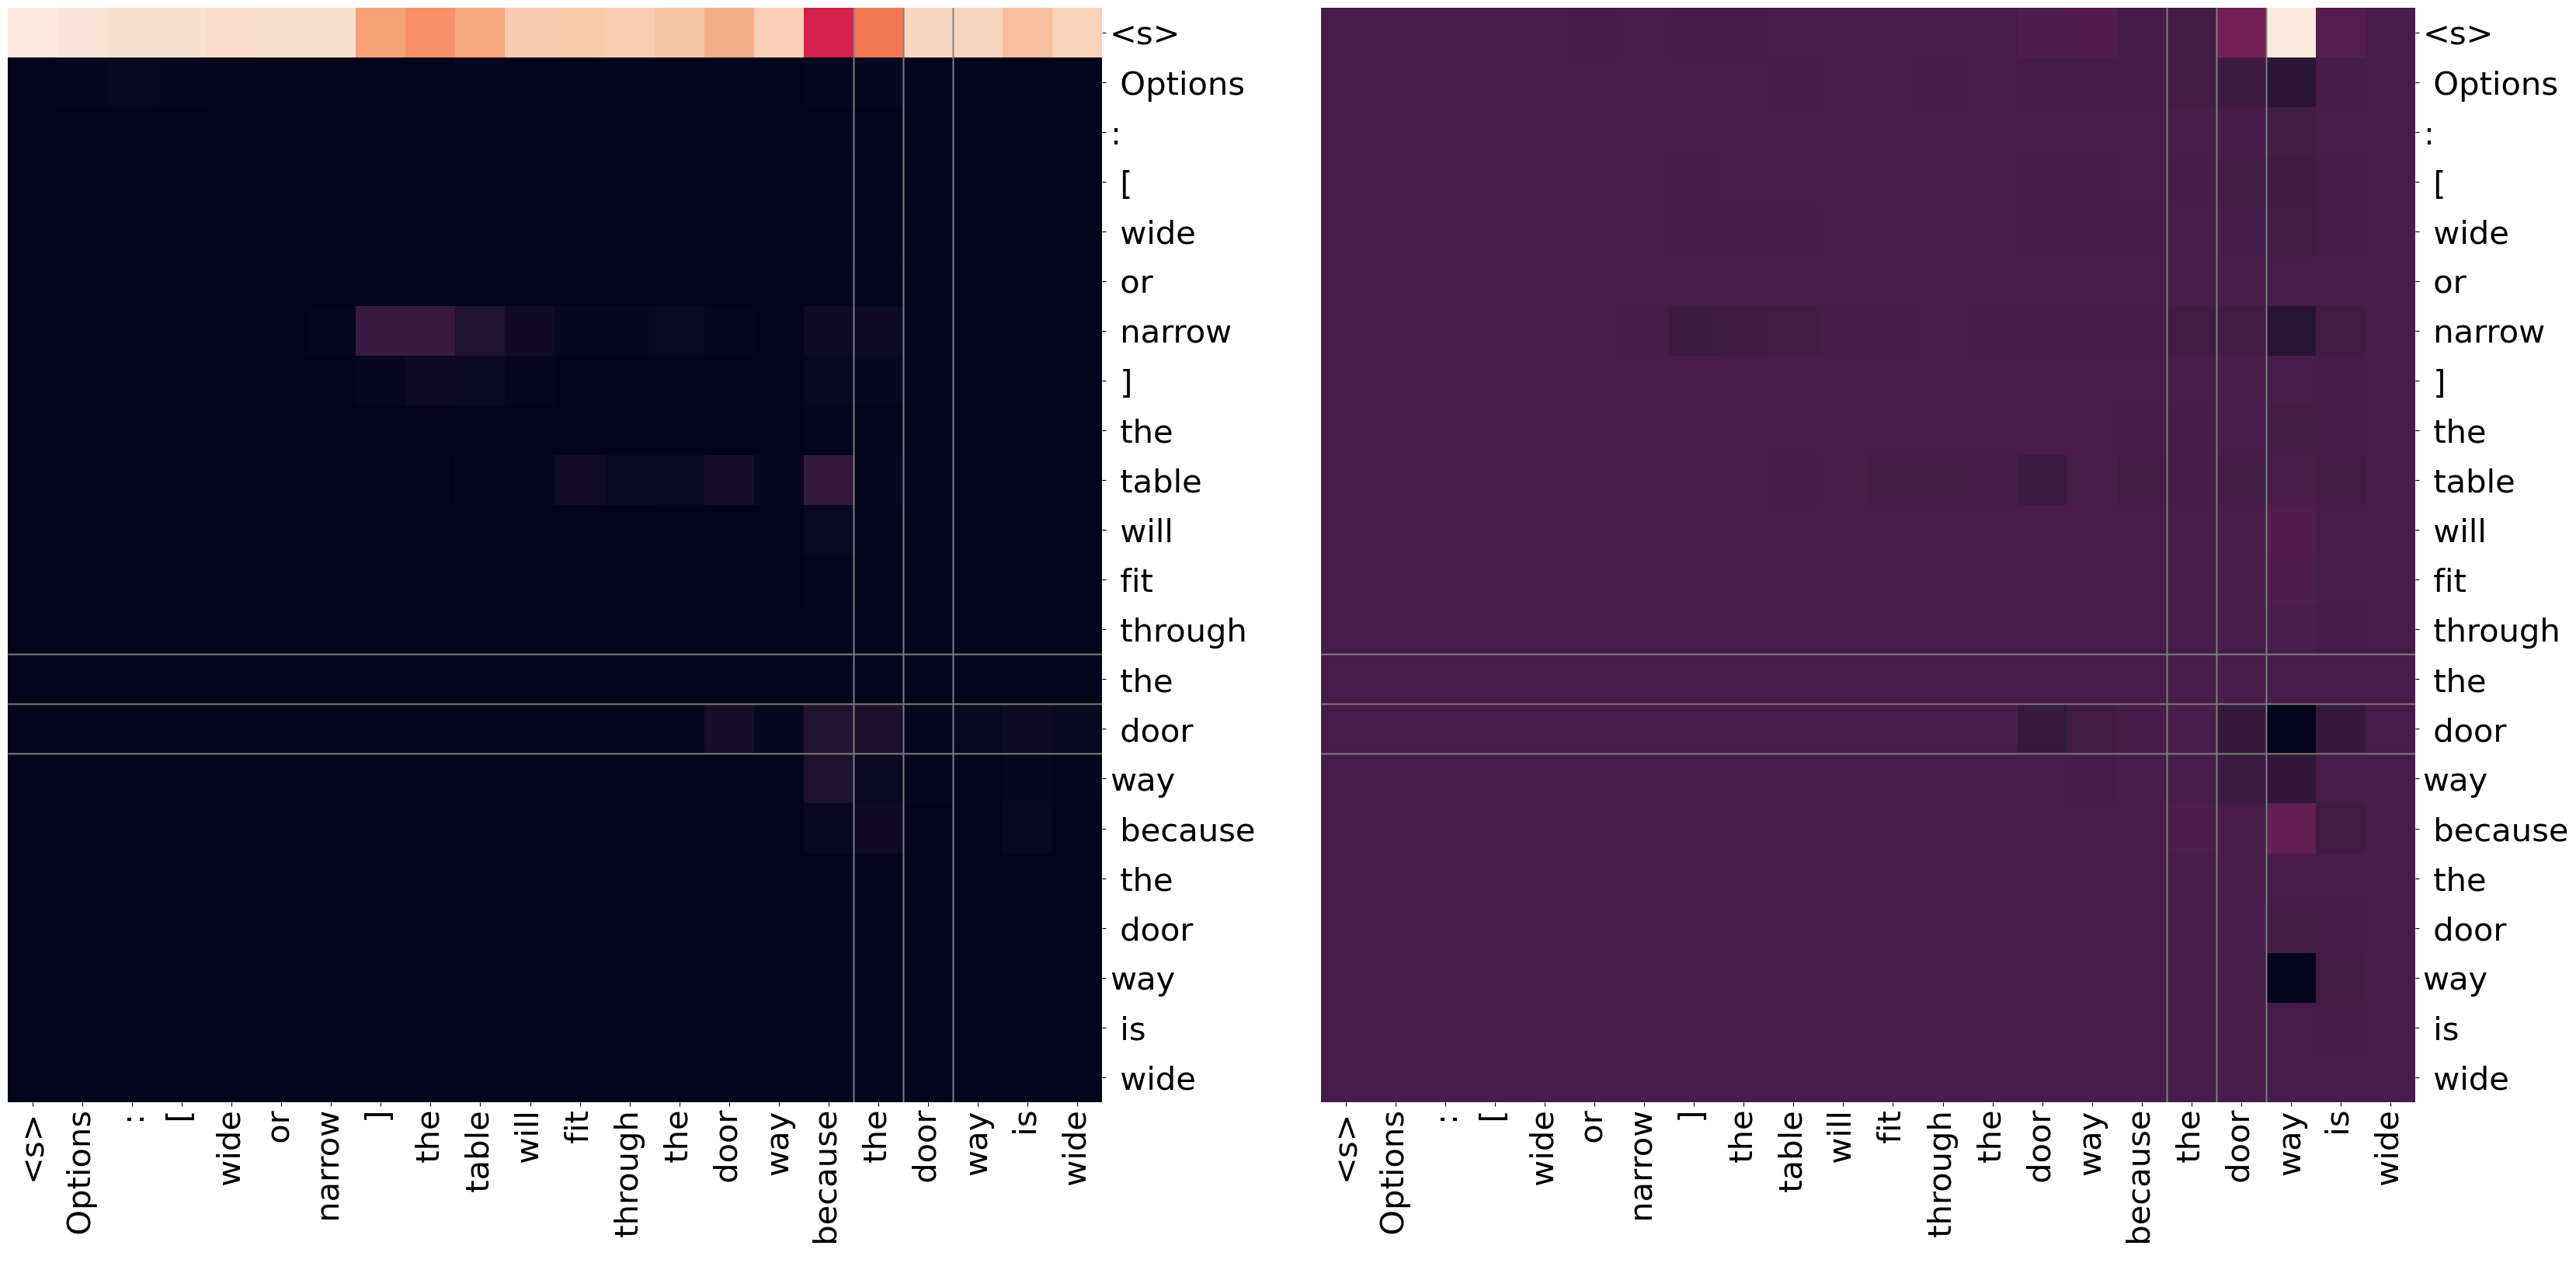

*▁hun 0.611 {'▁hun': 0.611, '▁full': 0.389, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ full or hungry ] Bill passed the half-empty plate to Amy because Amy was hungry *▁hun:0.315 ▁full:-0.136
ap_scores = tensor([0.1043]) tensor(0.1043)


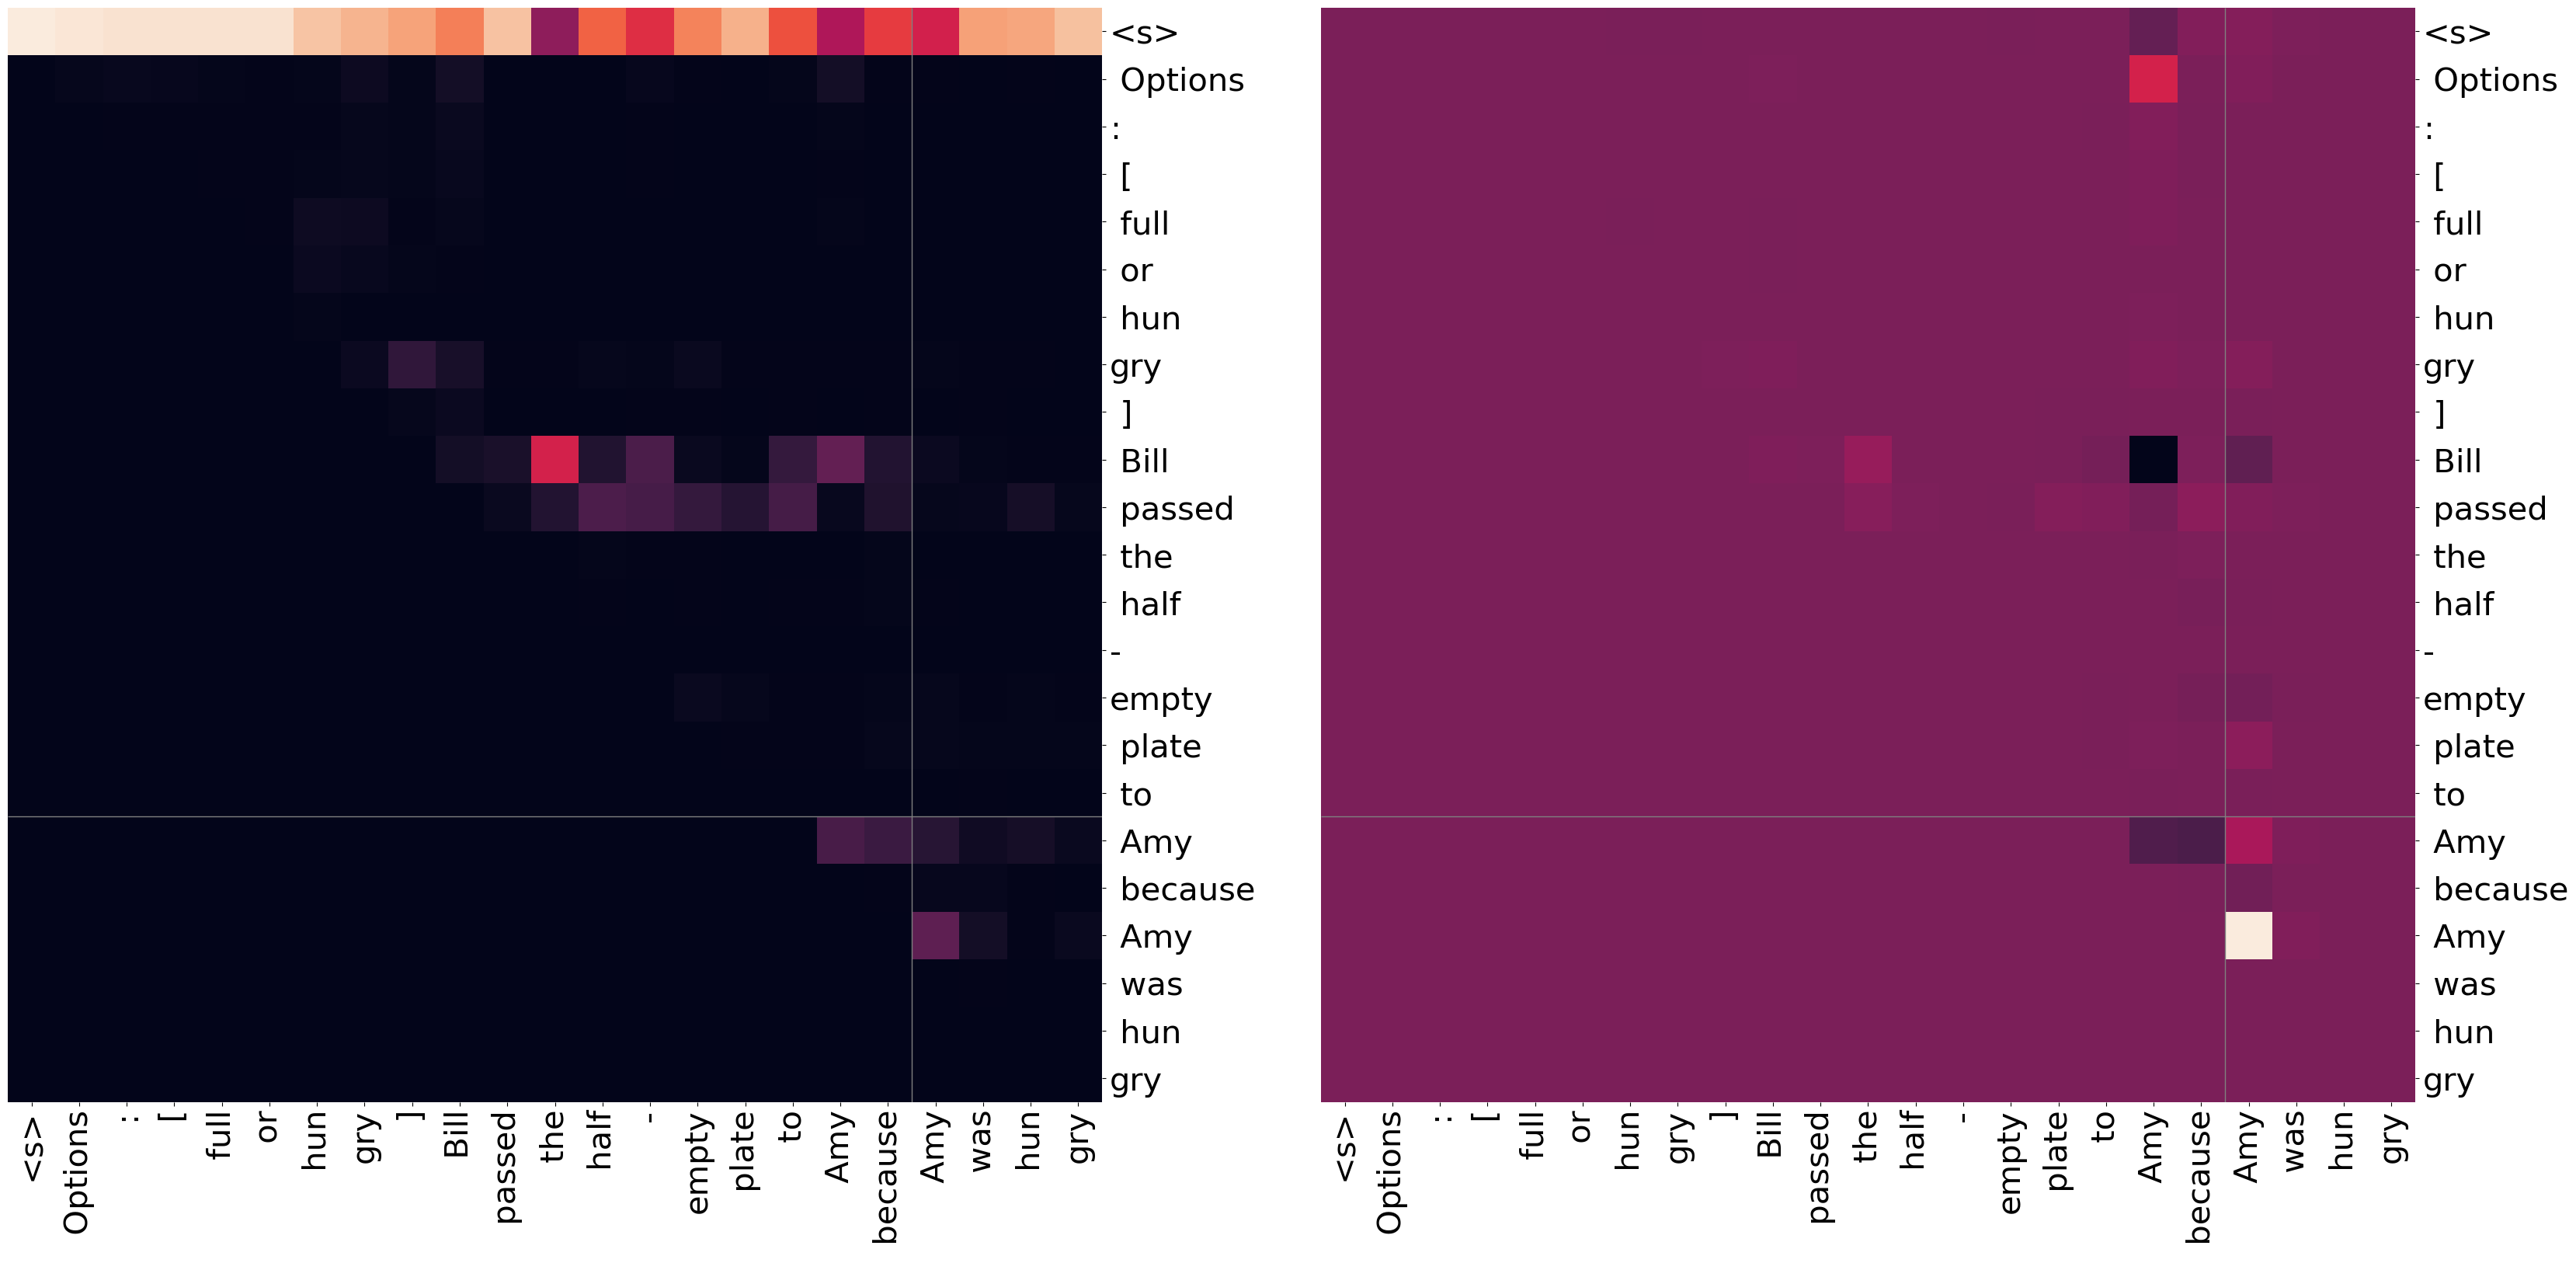

*▁popular 0.767 {'▁popular': 0.767, '▁not': 0.233, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ popular or notorious ] James ceded the presidency to Amy because Amy was popular ▁not:-0.274 *▁popular:0.919
ap_scores = tensor([0.1879]) tensor(0.1879)


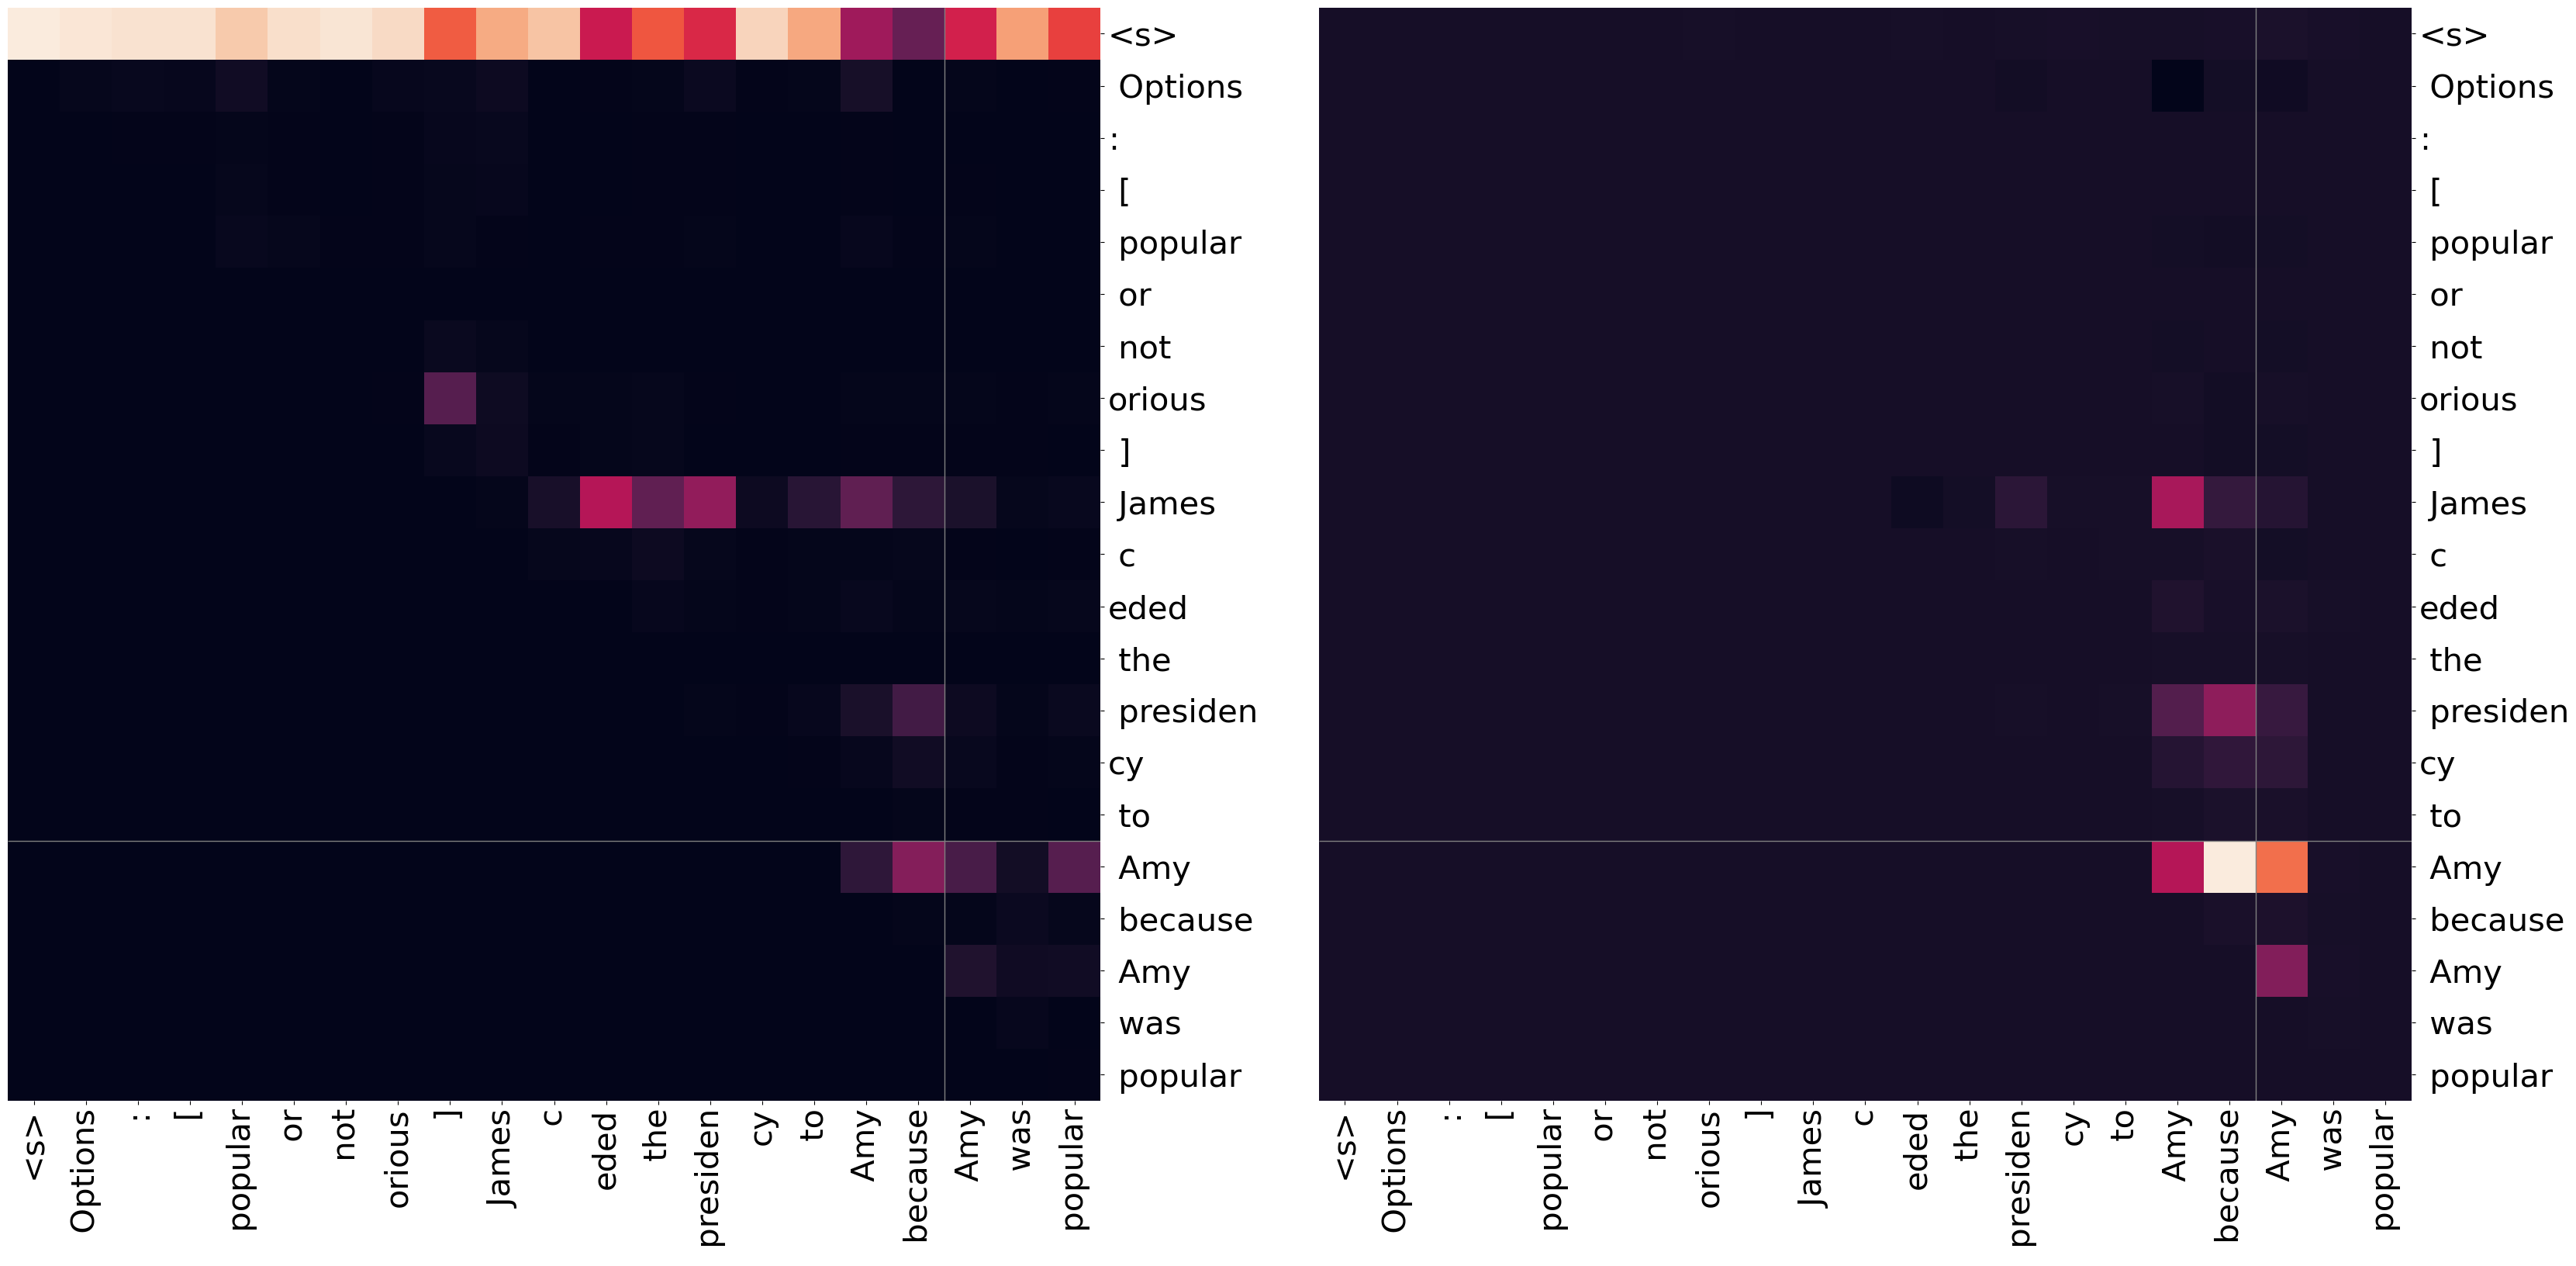

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_312124/3438373505.py", line 13, in <module>
    plot_attn_attrs(r1_after.data_tuples, model, tokenizer, node, topi=[5] ,attn_patterns=['s1->s2'], k_shot=0, mix=False)
  File "/home/xd/projects/transformers/notebooks/model_utils_wab_v5.py", line 2919, in plot_attn_attrs
    pred_logits, pred_labels, ap_scores,corrects = tuple(zip(*[plot_attn_attr(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: not enough values to unpack (expected 4, got 3)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^

In [246]:
#43-52 7   31-52 8  22-52 7    20-52 9   16-1 9 19-38 8 4-52 8 16-17 7 
#44-30 7   33-11 5  27-29 
#49-52 6   28-52 8  21-38
#45-52 7   32-52 6  3-m
#47-52 8   32-1 6
#32-52 9   34-31 7     0 2 5
#24-52 9   36-52 4     3 8 9 12 13 14
#39-52 8   7-52 8
#27-52 8   29-52 7
#22-52 9   22-52 8   0,1 4 7 10 11 13 14
#          27-29 8           
#          11-52 9
plot_attn_attrs(r1_after.data_tuples, model, tokenizer, node, topi=[5,12,10] ,attn_patterns=['bos->s1'], k_shot=0, mix=True)

In [57]:
#44-30 12     33-11 12   26-52 13  24-52 13  17-52 12  8-37 12
#43-52 12     28-52 12   27-52 17  16-52 13  8-52 12   8-52 12
#39-52 19     31-52 12   25-52 15  23-52 9   13-52 12  9-42 12
#36-52 13     32-1 13    29-52 13  12-52 12            12-4 13  
#27-52 14      29-52 13   13-52 14 18-52 13            14-6 12
#47-52 14     29-3 13     24-52 14 15-52 12            5-52 13
#37-52 15    27-29 13     17-52 12 14-52 12            9-29 13
#22-52 16    34-31 13     21-23 12 10-52 12            7-18 12
#24-52 17     20-52 11    19-52 12 21-38 12            5-31 12
#33-52 17     32-52 11    21-0 13  4-52 12             12-18 12
#30-43 11     35-29 12    2-52 12  9-52 11
#23-52 16     36-52 12    9-52 11  21-0 12
#45-52 13     32-9 16     15-24 14 24-33 12
#55-52 16                 20-13 12  20-14 12
#                          4-52 13 25-33 12
plot_attn_attrs(r1_before.data_tuples, model, tokenizer, node, topi=[1], attn_patterns=['s1->Ration'], k_shot=0, mix=True)     #47-32:12  55-52:15  39-52:19 56-24:15 51-52:13 42-30:9/24 28-34:17/24 43-20:16/24 27-29:13/24 39-25:15/24 step1:42-30 -> 43-20:12/24  28-34 -> 43-20 15/24   27-29 -> 43-20:11/24  25-33 -> 43-20: 20/24

NameError: name 'r1_before' is not defined

## although 合并

In [247]:
winograd_al = Winograd('wino_al_sentences.json', 'wino_al_word_idx.json')

In [248]:
r1_al = None
result_al = {}

Options: [ small or large ] the trophy doesn't fit into the suitcase although the trophy is small
2.188961294091617 0.7083333333333334 0.672


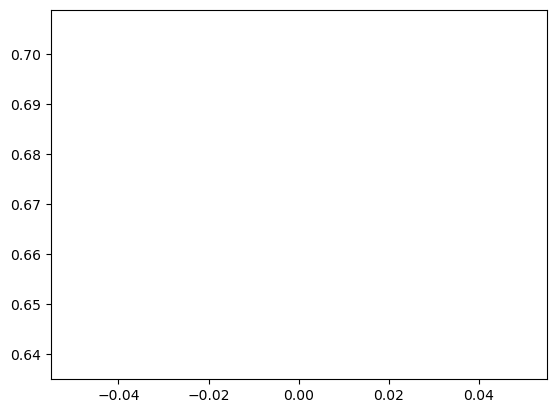

gx []
rx []


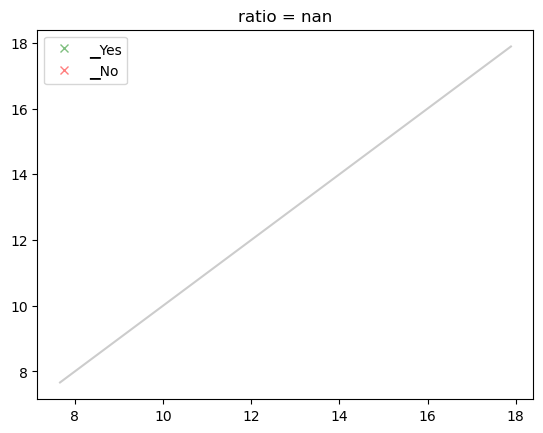

In [250]:
r1_al = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=24,dataset = winograd_al,
                                        trim=False, result=r1_al, verbose=False)#8tiao

In [366]:
def filter_fn_al(p, c):  #合并版
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1  and c.topi in [0,4,5,6,8] or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and c.topi in [4,5]  or #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1  and p.attn_pattern =='bos->s1' and p.label_type == 'attn_labels' and c.topi in [1]or
       p.step == 2 and p.attn_pattern =='s1->s1' and c.topi in [0,1,2,4,5,6,7,9,10] or
    p.step == 3 and c.topi in [2,3,7,8,9,11,12] or
            p.step == 4 and c.top_score>0.5 or
            p.step == 5 and c.top_score>0.7#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [367]:
if r1_al.root is None: r1_al.root = add_node(None, layer=L, label_type='labels')
r1_al.root = attribute_tree_on(r1_al.data_tuples, model, r1_al.root, 2, filter_fn_al, topk=15, k_shot=0, threshold_score=0.1, mix=True, device=None, verbose=True)

attribute_tree ... In get_attr_groups: node_group, attr_groups = [(59, 52), (35, 52), (31, 52), (57, 52), (30, 52)] []
In get_attr_groups: node_group, attr_groups = [(25, 42)] [('G1', [(25, 42), (25, 33)])]
In get_attr_groups: node_group, attr_groups = [(25, 42)] [('G1', [(25, 42), (25, 33)])]
In get_attr_groups: node_group, attr_groups = [(25, 42)] [('G1', [(25, 42), (25, 33)])]
In get_attr_groups: node_group, attr_groups = [(25, 33)] [('G1', [(25, 42), (25, 33)])]
In get_attr_groups: node_group, attr_groups = [(25, 33)] [('G1', [(25, 42), (25, 33)])]
In attribute_tree: already attributed, skip ('[25]', '[42]', 'bos->inter', 'attn_labels', False)
In attribute_tree: already attributed, skip ('[25]', '[42]', 'bos->inter', 'attn_labels', True)
In attribute_tree: already attributed, skip ('[25]', '[33]', 'bos->s1', 'attn_labels', False)
In get_attr_groups: node_group, attr_groups = [(22, 22)] []
In _add_node: add 22-22 B->s1
In get_attr_groups: node_group, attr_groups = [(22, 22)] []
In _

In [368]:
print_tree(r1_al.root)

 ┌@[0,1,2,3,4,5,6,7,8,9,11,12,13,14] 59-m,36-m,41-m,29-m,35-m,31-m,57-m,37-m,30-m,25-m,28-m,32-m,24-m,34-m B->B 93
 ├@[10] 29-34 unk 0
 ├@0 59-m 100
 ├@1 36-m 80
 ├@2 41-m 73
 ├@3 29-m 69
 ├@4 35-m 65
 ├@5 31-m 58
 ├@6 57-m 51
 ├@7 37-m 51
 ├@8 30-m 46
 ├@9 25-m 44
 ├@11 28-m 41
 ├@12 32-m 36
 ├@13 24-m 36
 ├@14 34-m 35
 ├@10 29-34 43 B->nA0 38/12 attn
 ┤
 │                  ┌@[0,1,2,3,6,7,8,9,10,11,12,14] 43-m,24-m,22-m,26-m,56-m,30-m,40-m,25-m,52-m,55-m,58-m,45-m 30 B->B 82
 │                  ├@[4,5,13] 25-42,25-33,27-29 30 unk 0
 │                  ├@0 43-m 100
 │                  ├@1 24-m 79
 │                  ├@2 22-m 59
 │                  ├@3 26-m 54
 │                  ├@6 56-m 44
 │                  ├@7 30-m 42
 │                  ├@8 40-m 41
 │                  ├@9 25-m 39
 │                  ├@10 52-m 38
 │                  ├@11 55-m 33
 │                  ├@12 58-m 32
 │                  ├@14 45-m 30
 │                  ├@4 25-42 49 B->inter 29/20
 │                  ├@4 

In [363]:
node = r1_al.root.children[-1].children[-2]
node.name

'25-33 G1 B->s1'

In [335]:
node.data.attr_groups = {'G1': [(25,42),(25,33)]}

@[0,4,5,6,8]  B->B -> 25-33 G1 B->s1 -> 19-24
*▁small 0.768 {'▁small': 0.768, '▁large': 0.232, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ small or large ] the trophy doesn't fit into the suitcase although the trophy is small *▁small:9.961 ▁large:8.766
ap_scores = tensor([0.4727]) tensor(0.4727)


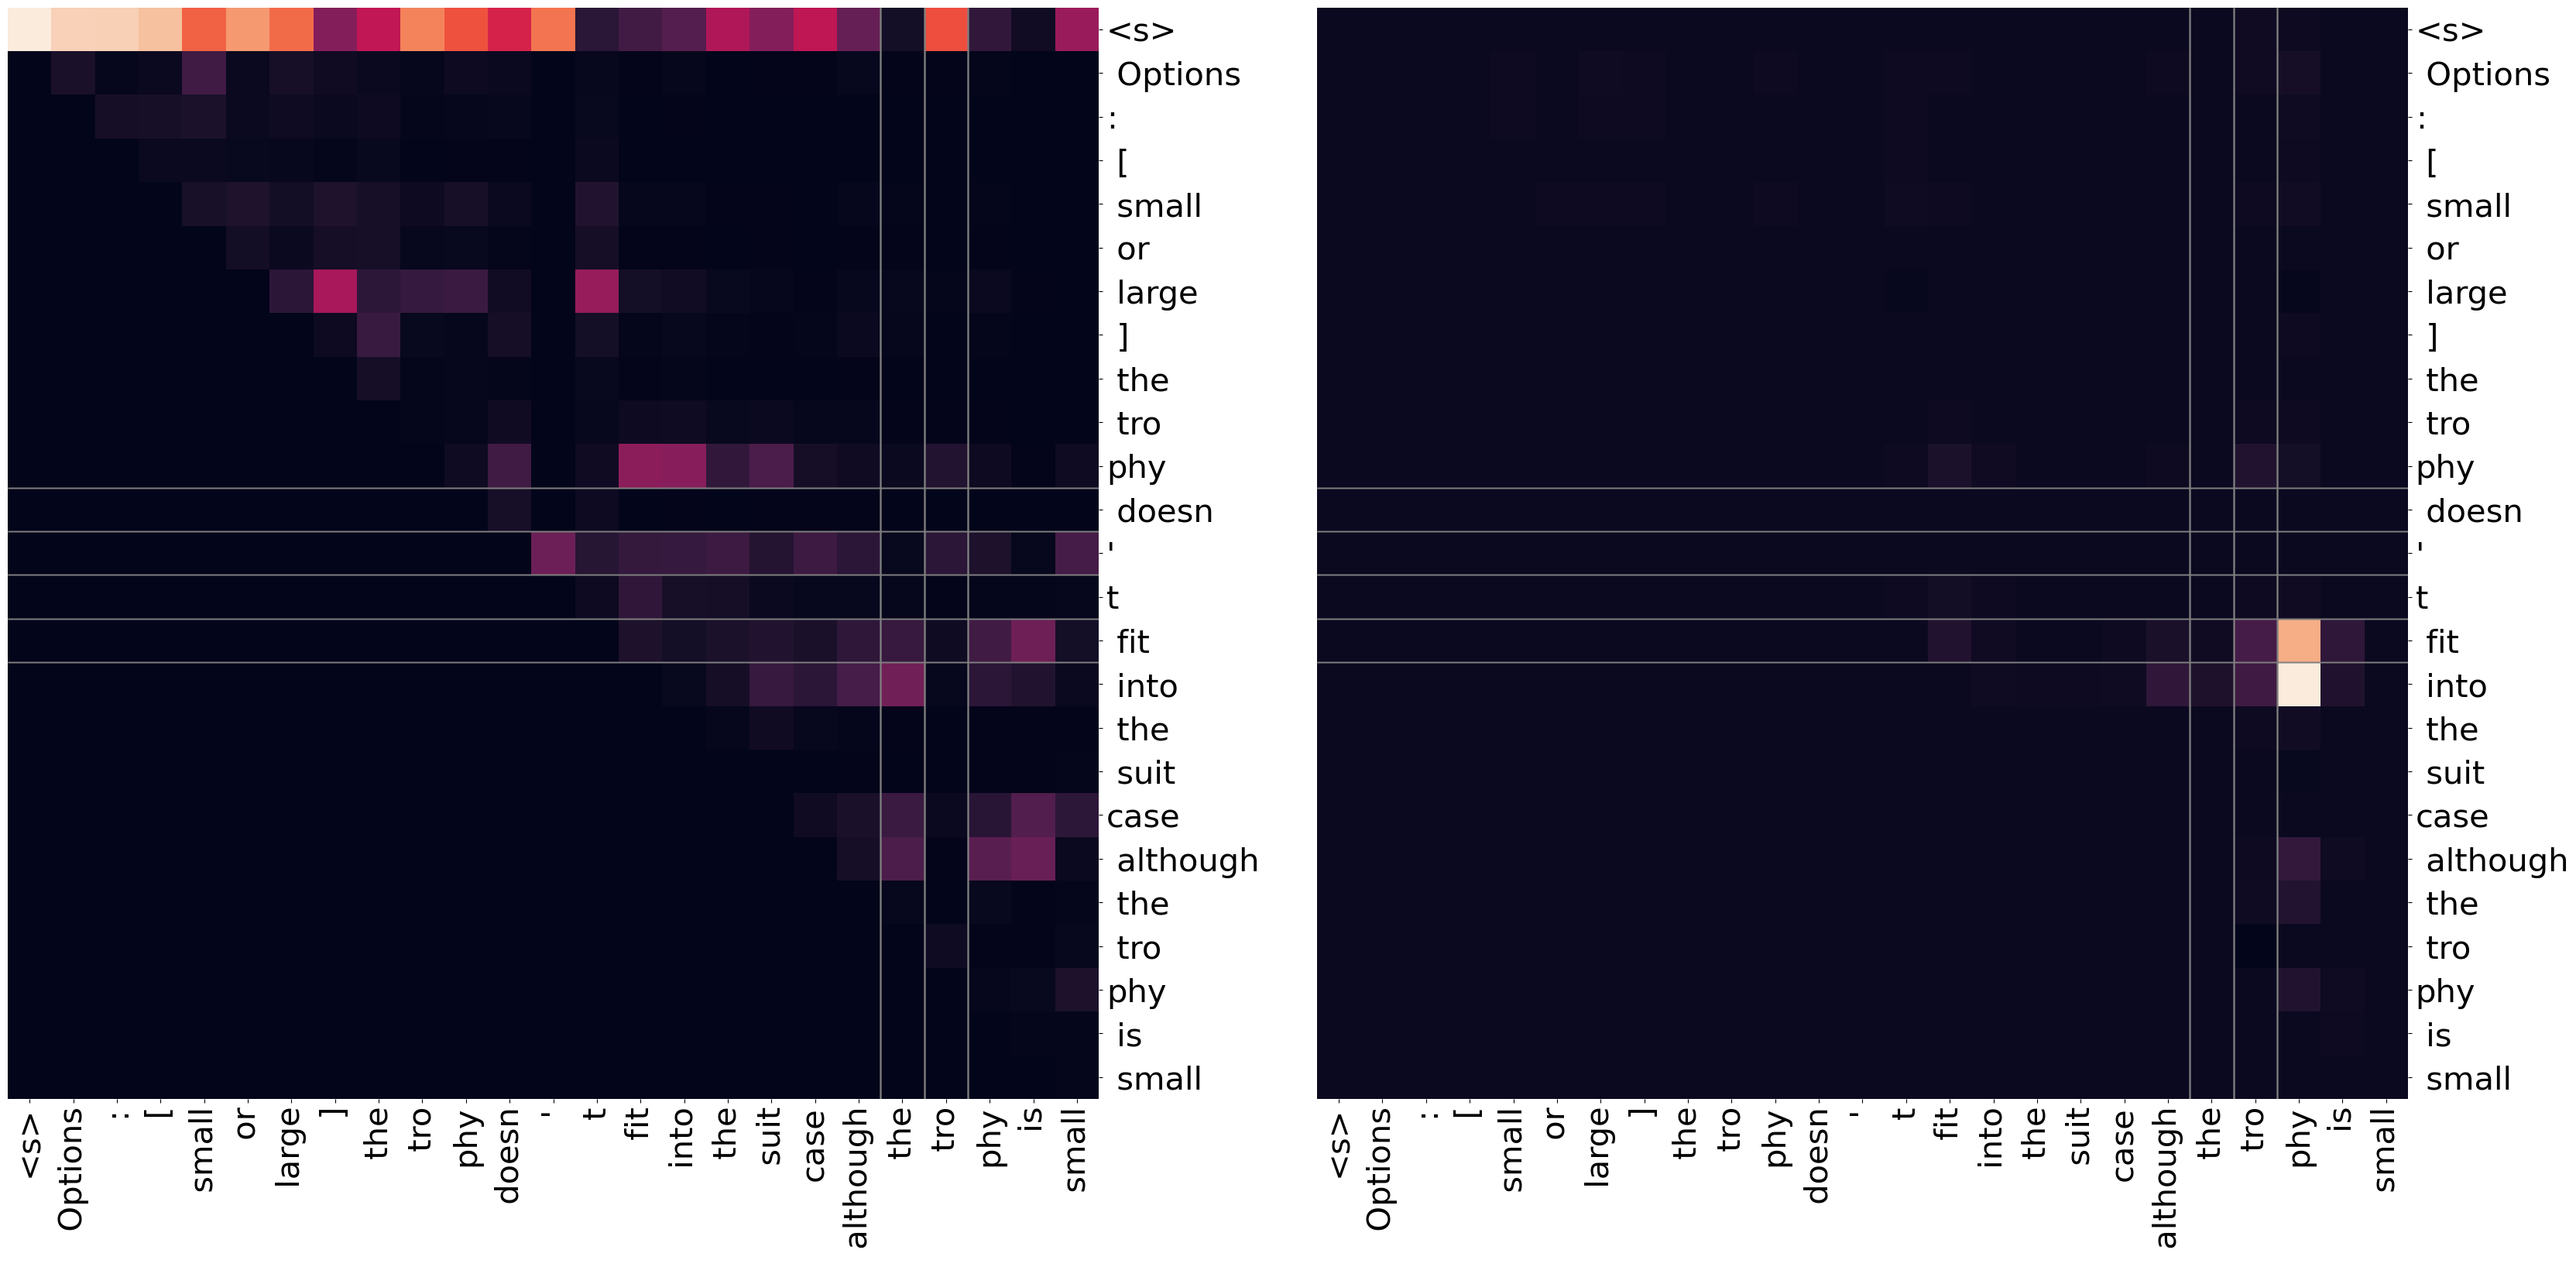

*▁large 0.639 {'▁large': 0.638, '▁small': 0.361, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ large or small ] the trophy doesn't fit into the suitcase although the suitcase is large ▁small:9.531 *▁large:10.102
ap_scores = tensor([0.4184]) tensor(0.4184)


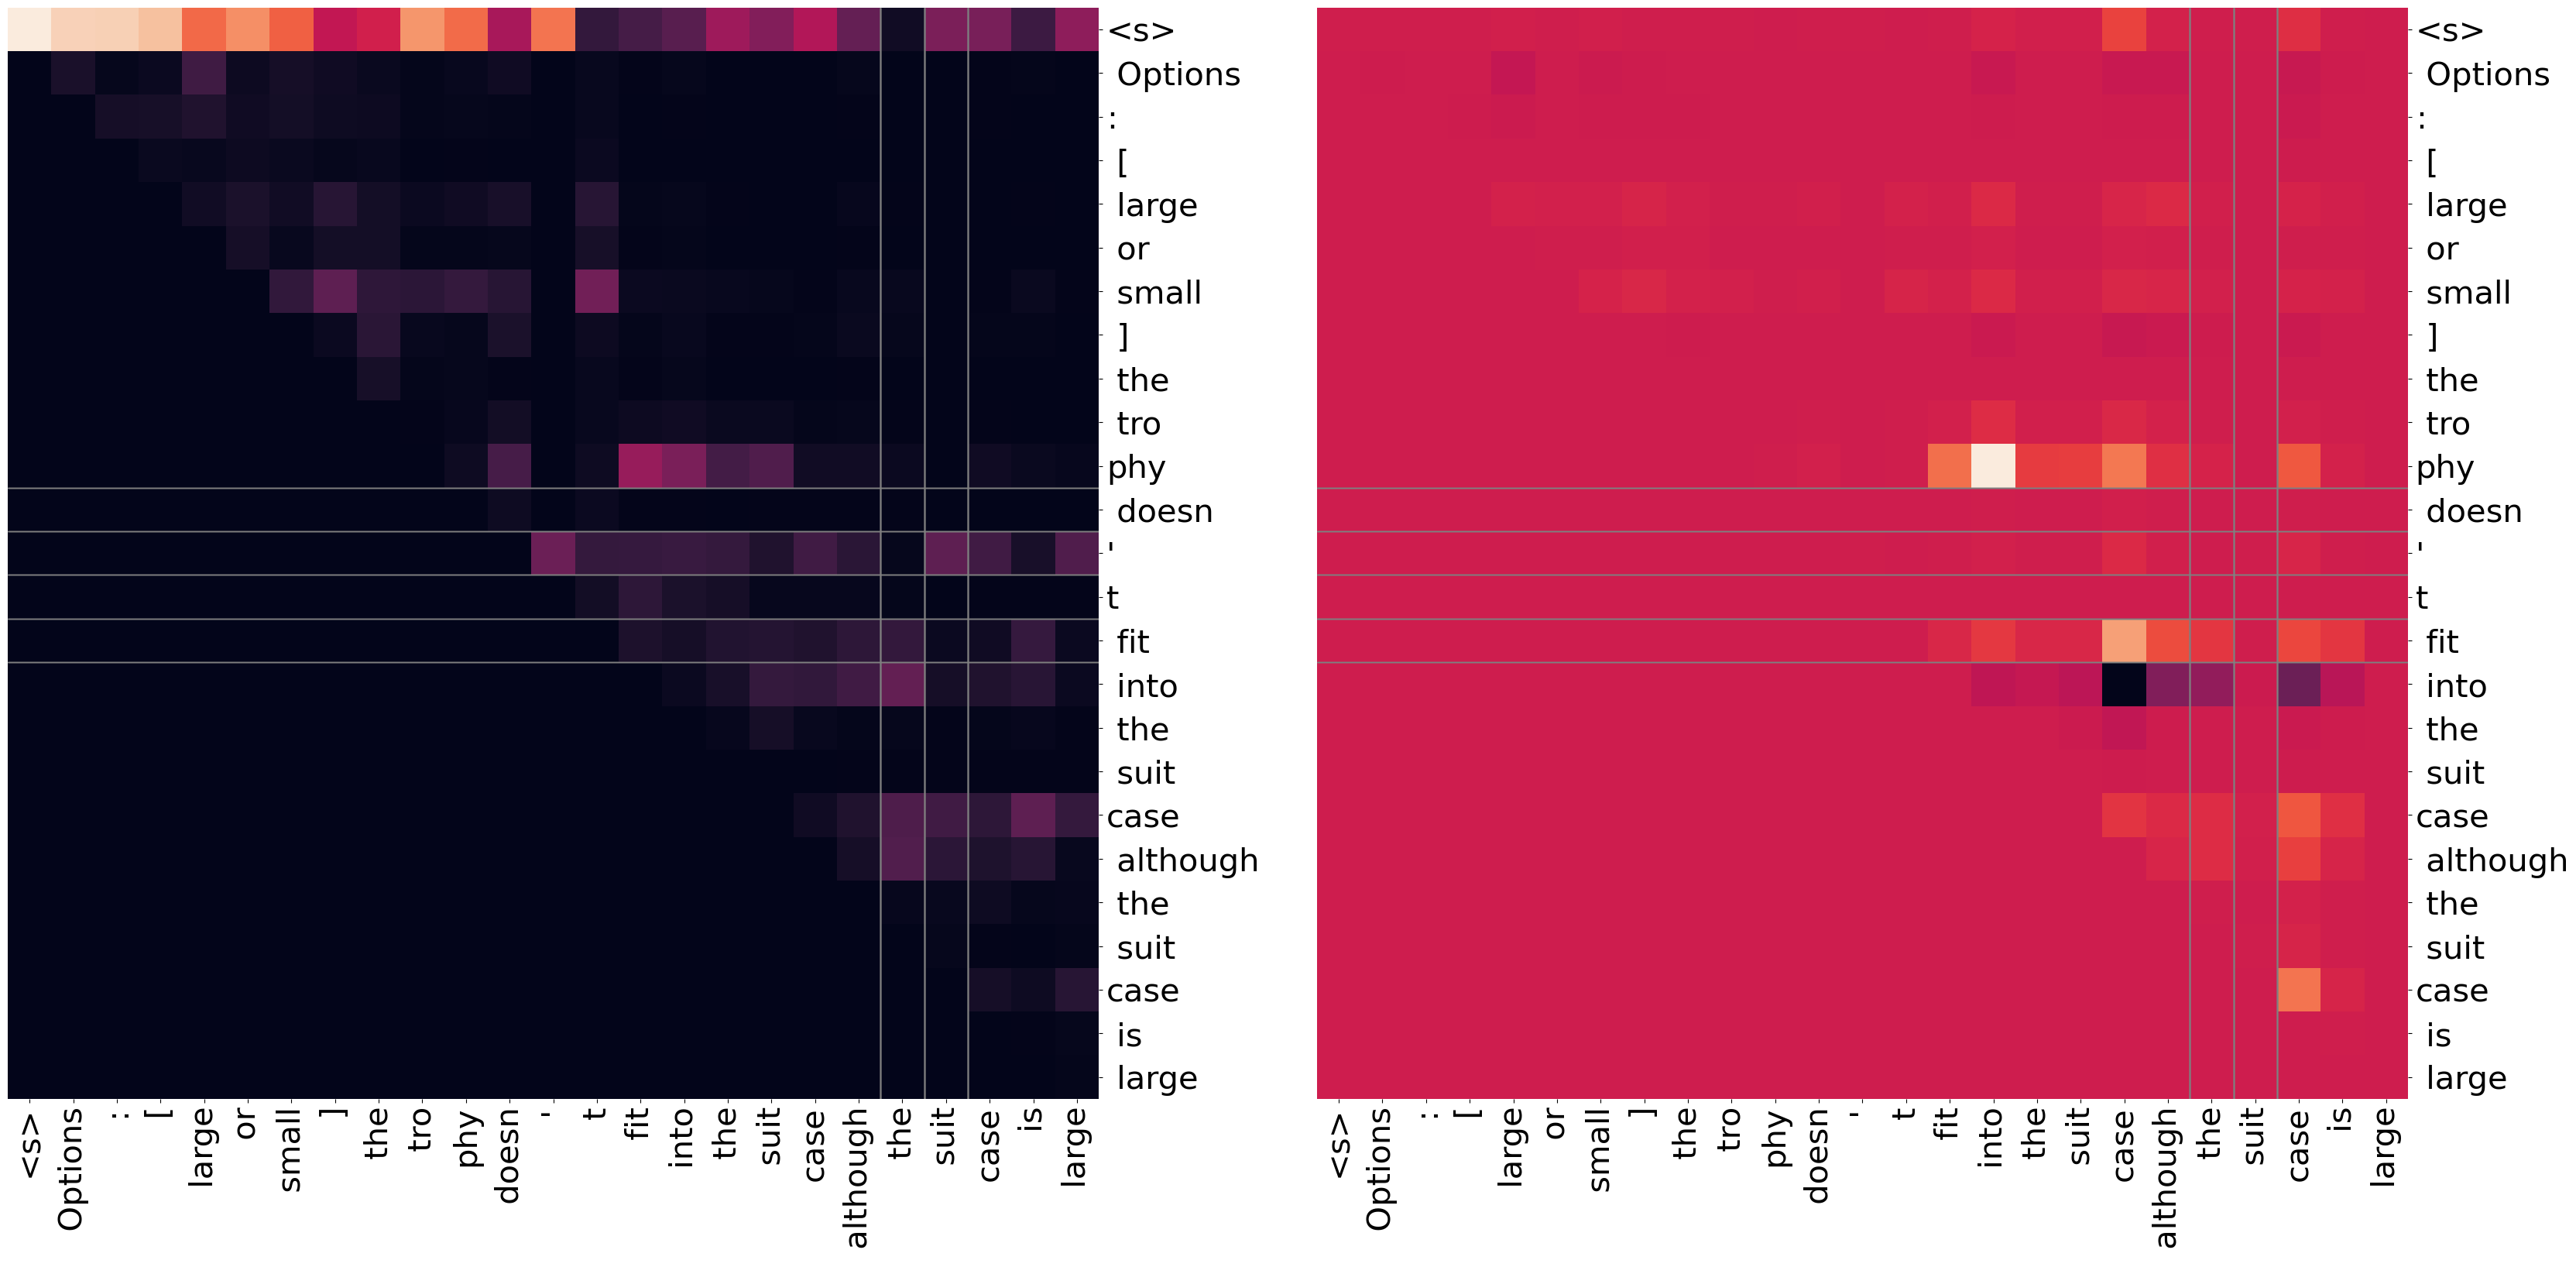

 ▁poor 0.152 {'▁rich': 0.848, '▁poor': 0.152, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ rich or poor ] John gave a lot of money to Susan although John was poor *▁poor:0.681 ▁rich:2.398
ap_scores = tensor([0.2634]) tensor(0.2634)


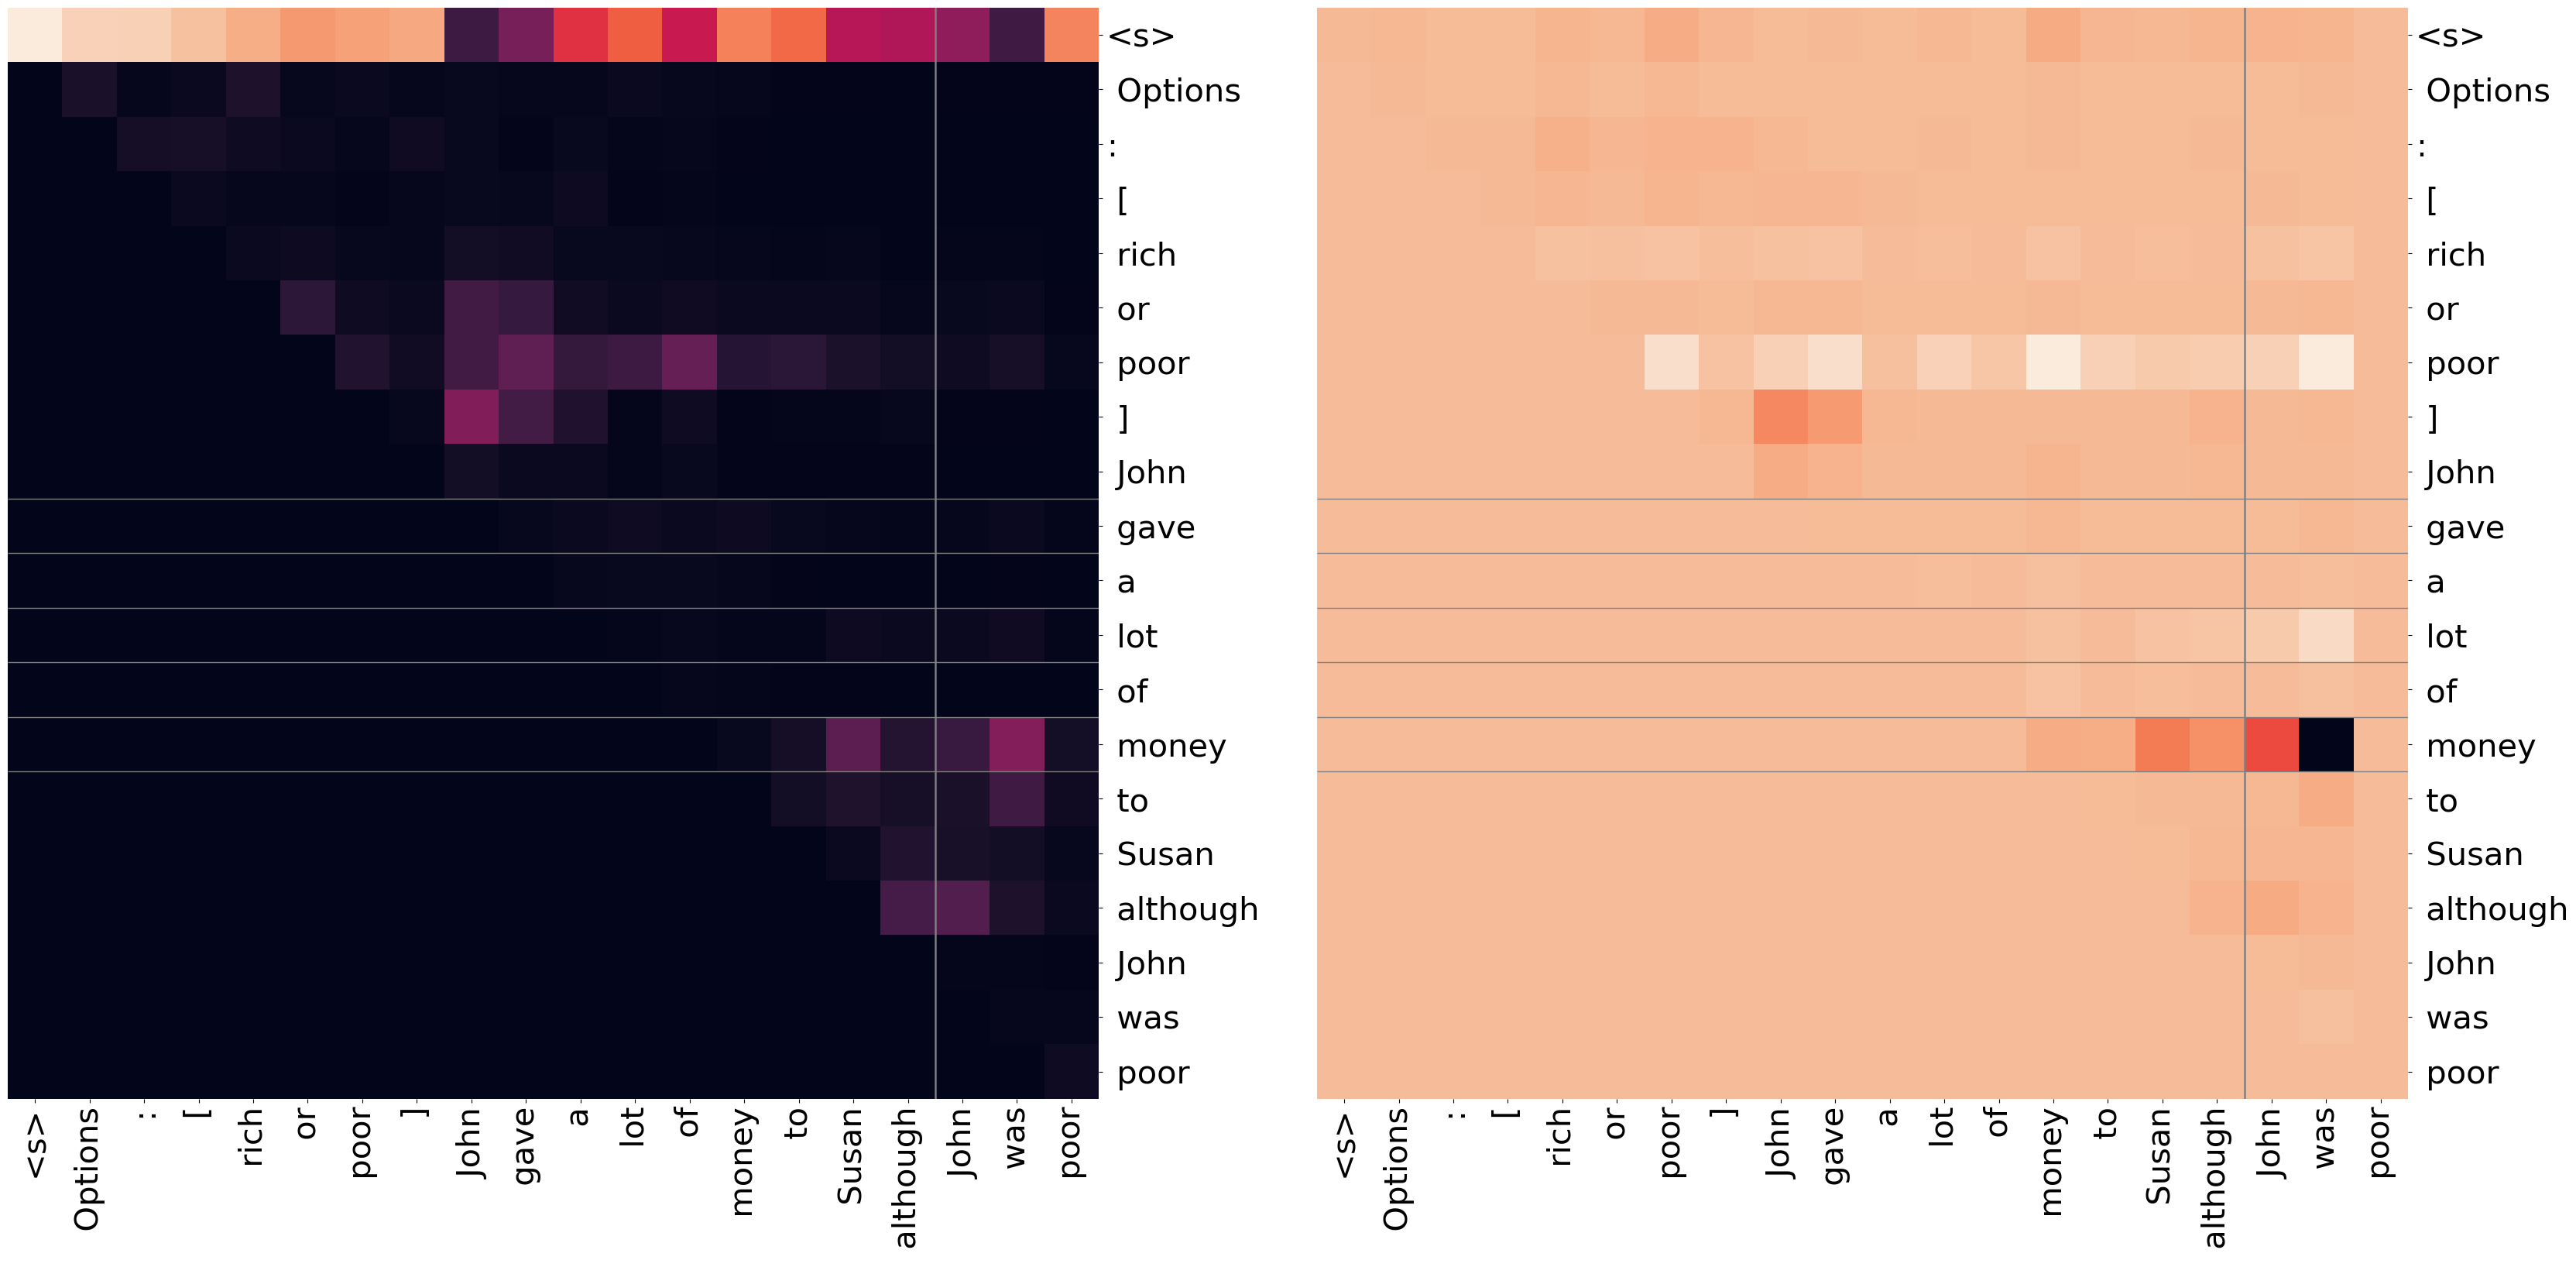

*▁rich 0.867 {'▁rich': 0.866, '▁poor': 0.133, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ rich or poor ] John gave a lot of money to Susan although Susan was rich ▁poor:0.657 *▁rich:2.527
ap_scores = tensor([0.4608]) tensor(0.4608)


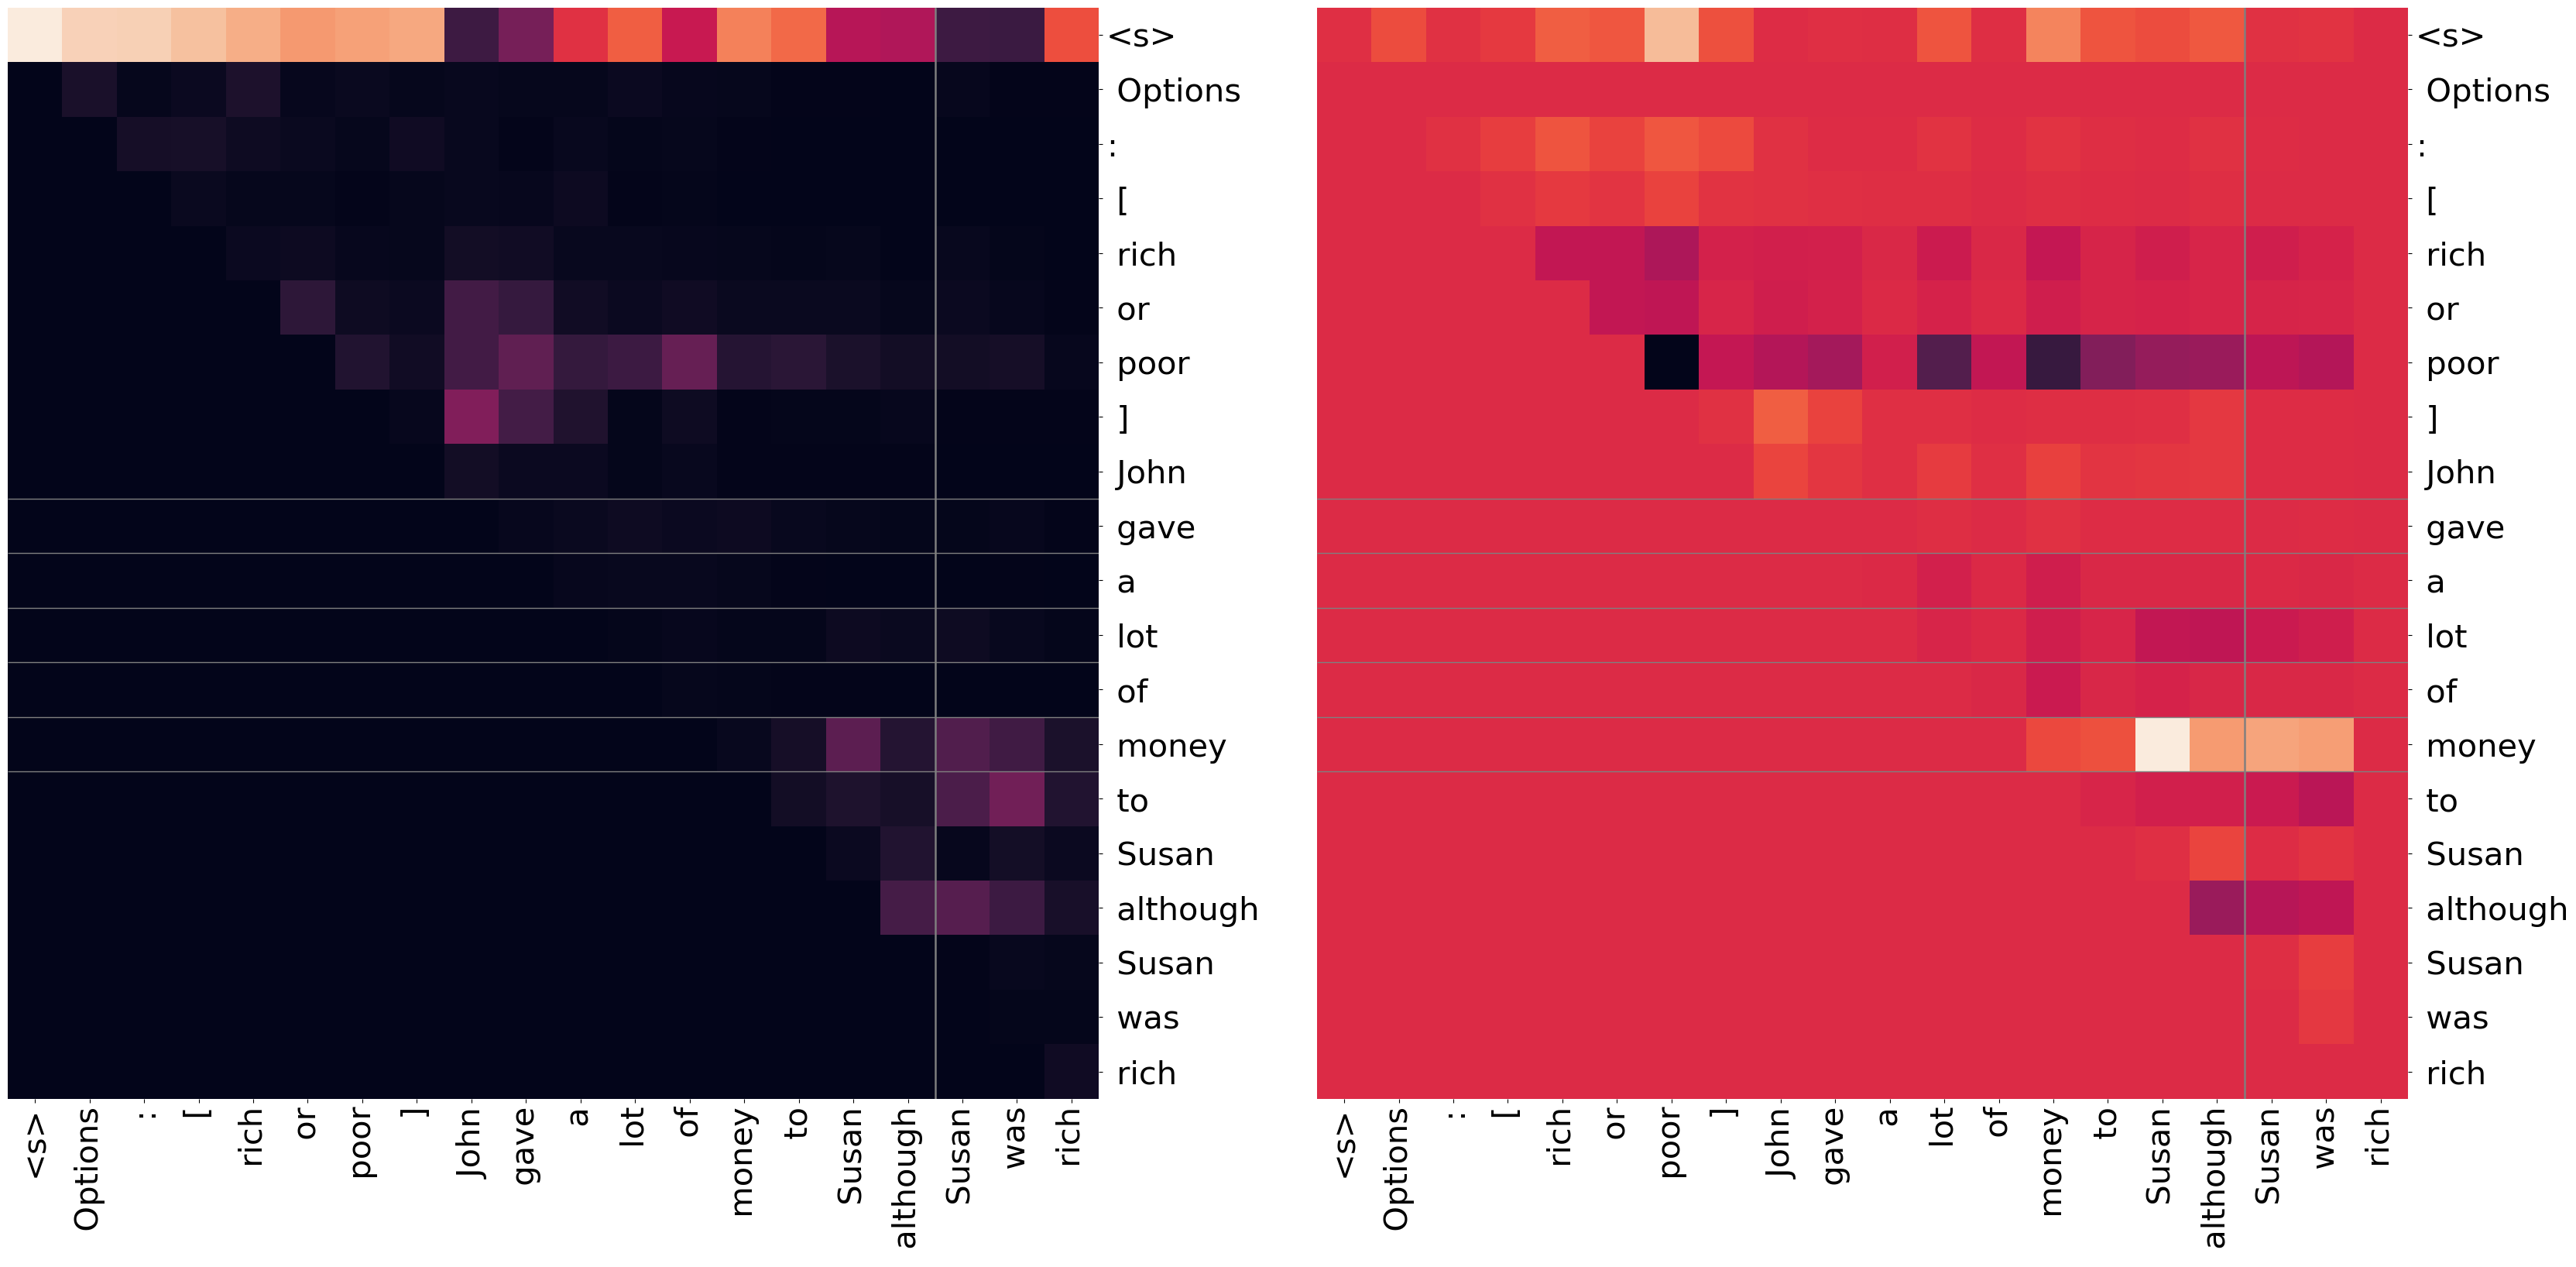

 ▁slow 0.069 {'▁fast': 0.931, '▁slow': 0.069, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ fast or slow ] the truck overtook the bus although the truck was going slow *▁slow:3.396 ▁fast:6.004
ap_scores = tensor([0.4711]) tensor(0.4711)


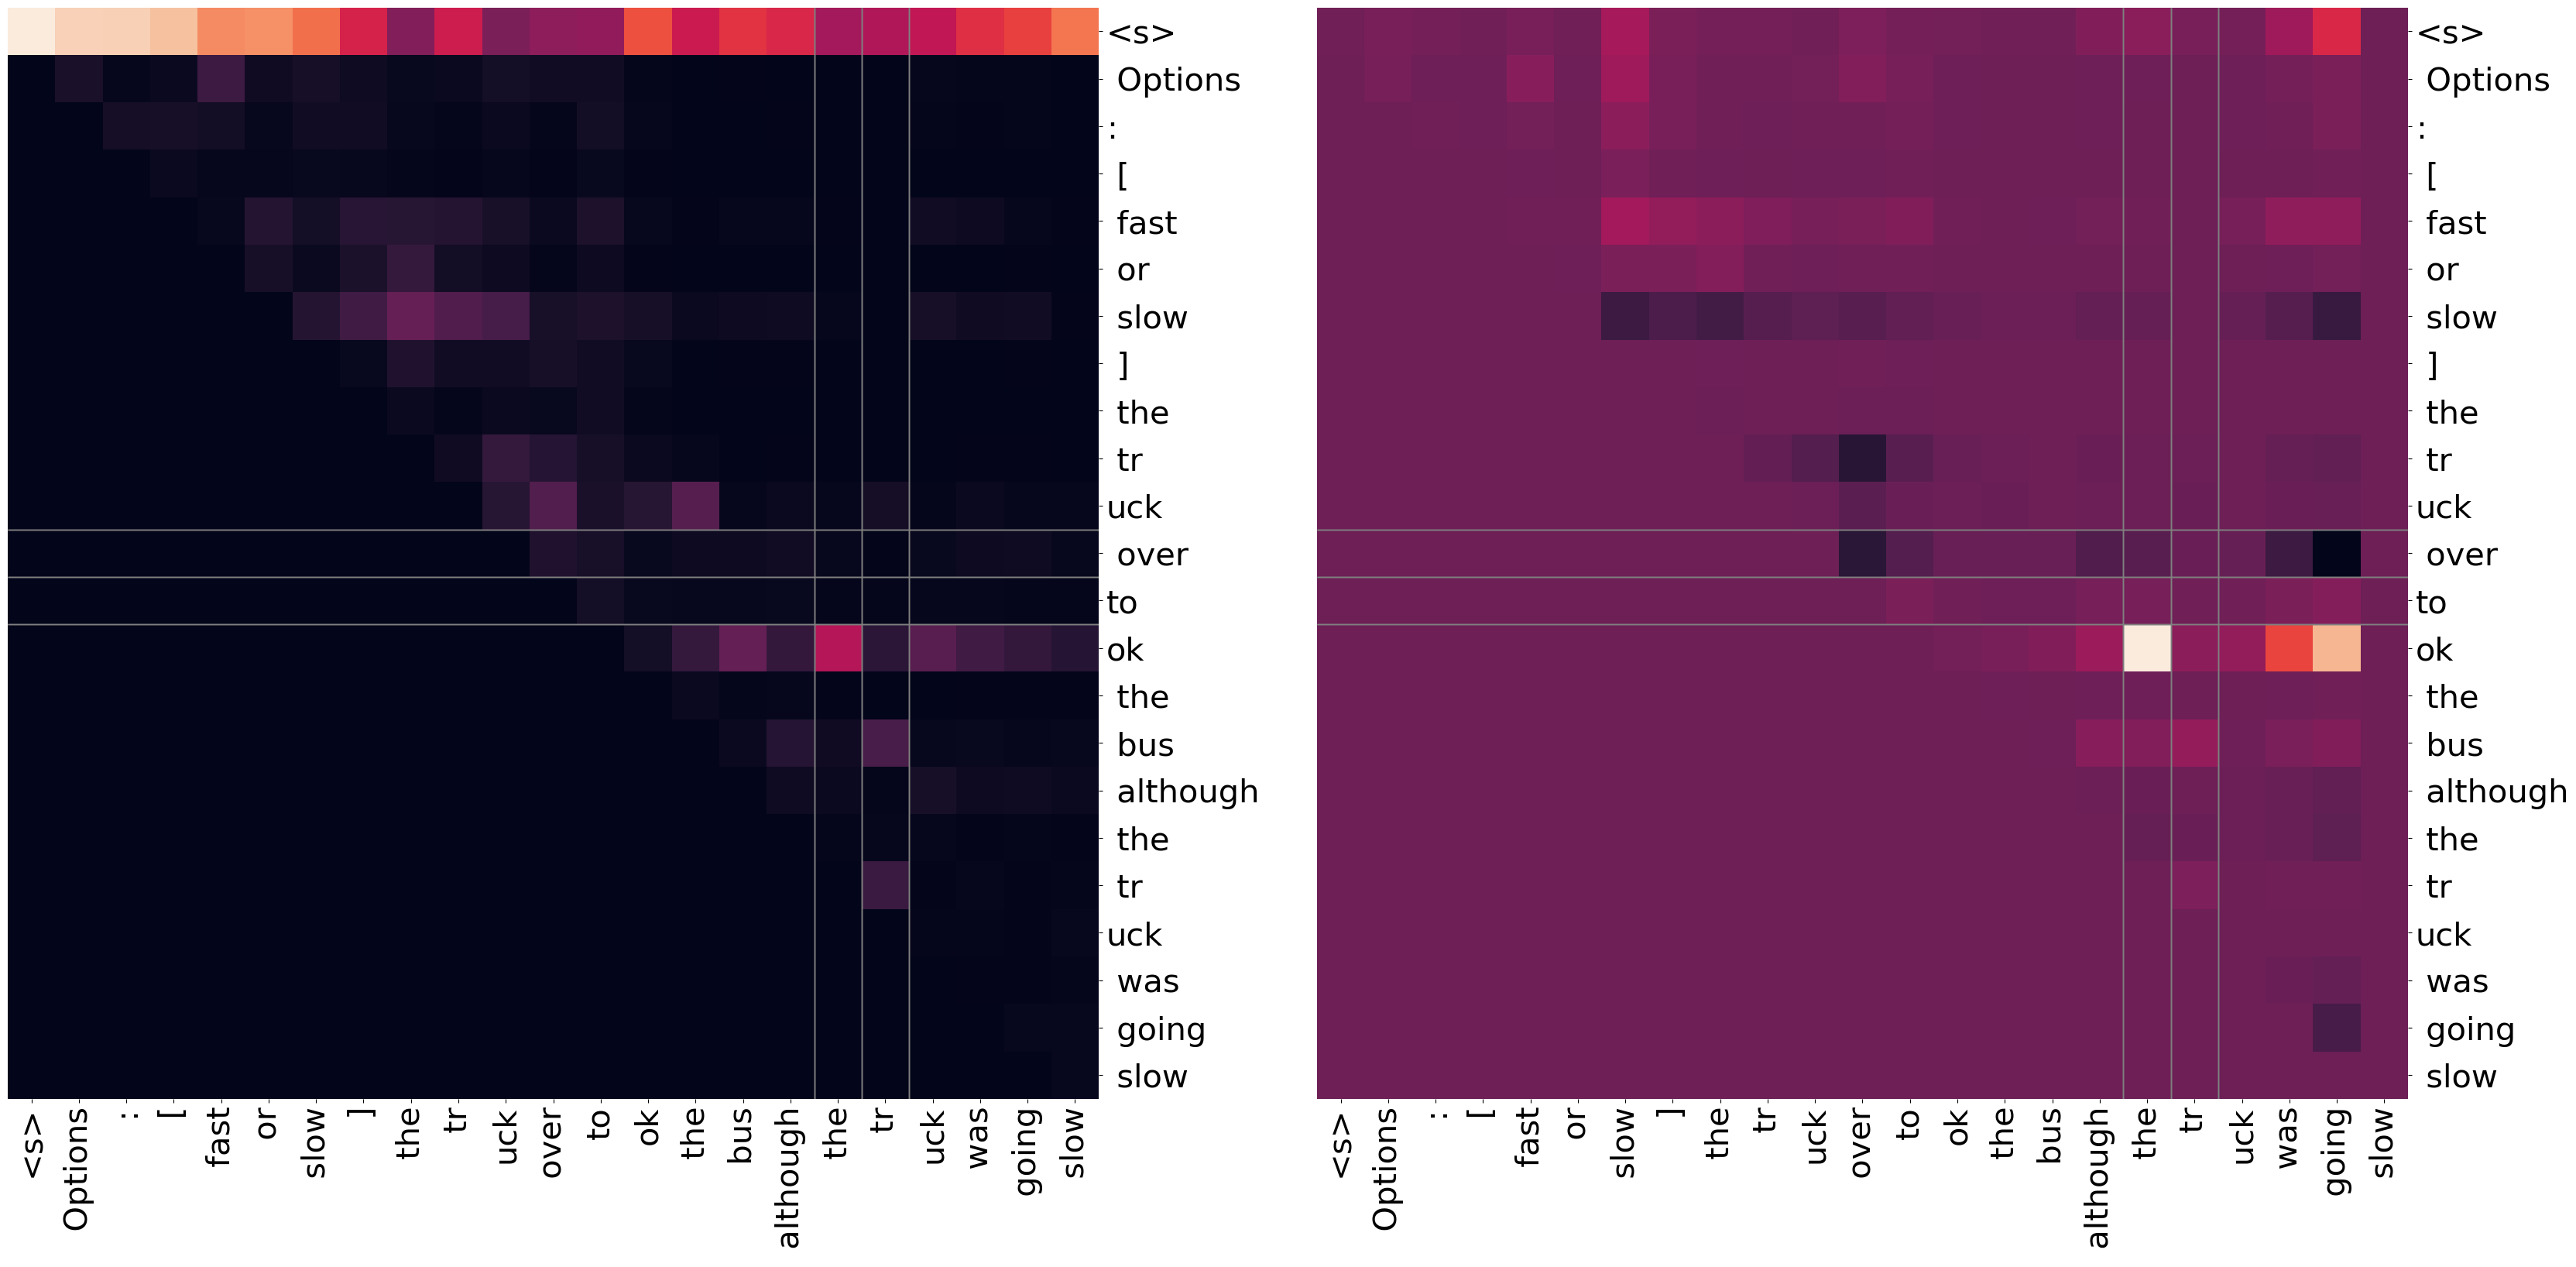

*▁fast 1.0 {'▁fast': 1.0, '▁slow': 0.0, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ fast or slow ] the truck overtook the bus although the bus was going fast ▁slow:0.320 *▁fast:8.352
ap_scores = tensor([0.4711]) tensor(0.4711)


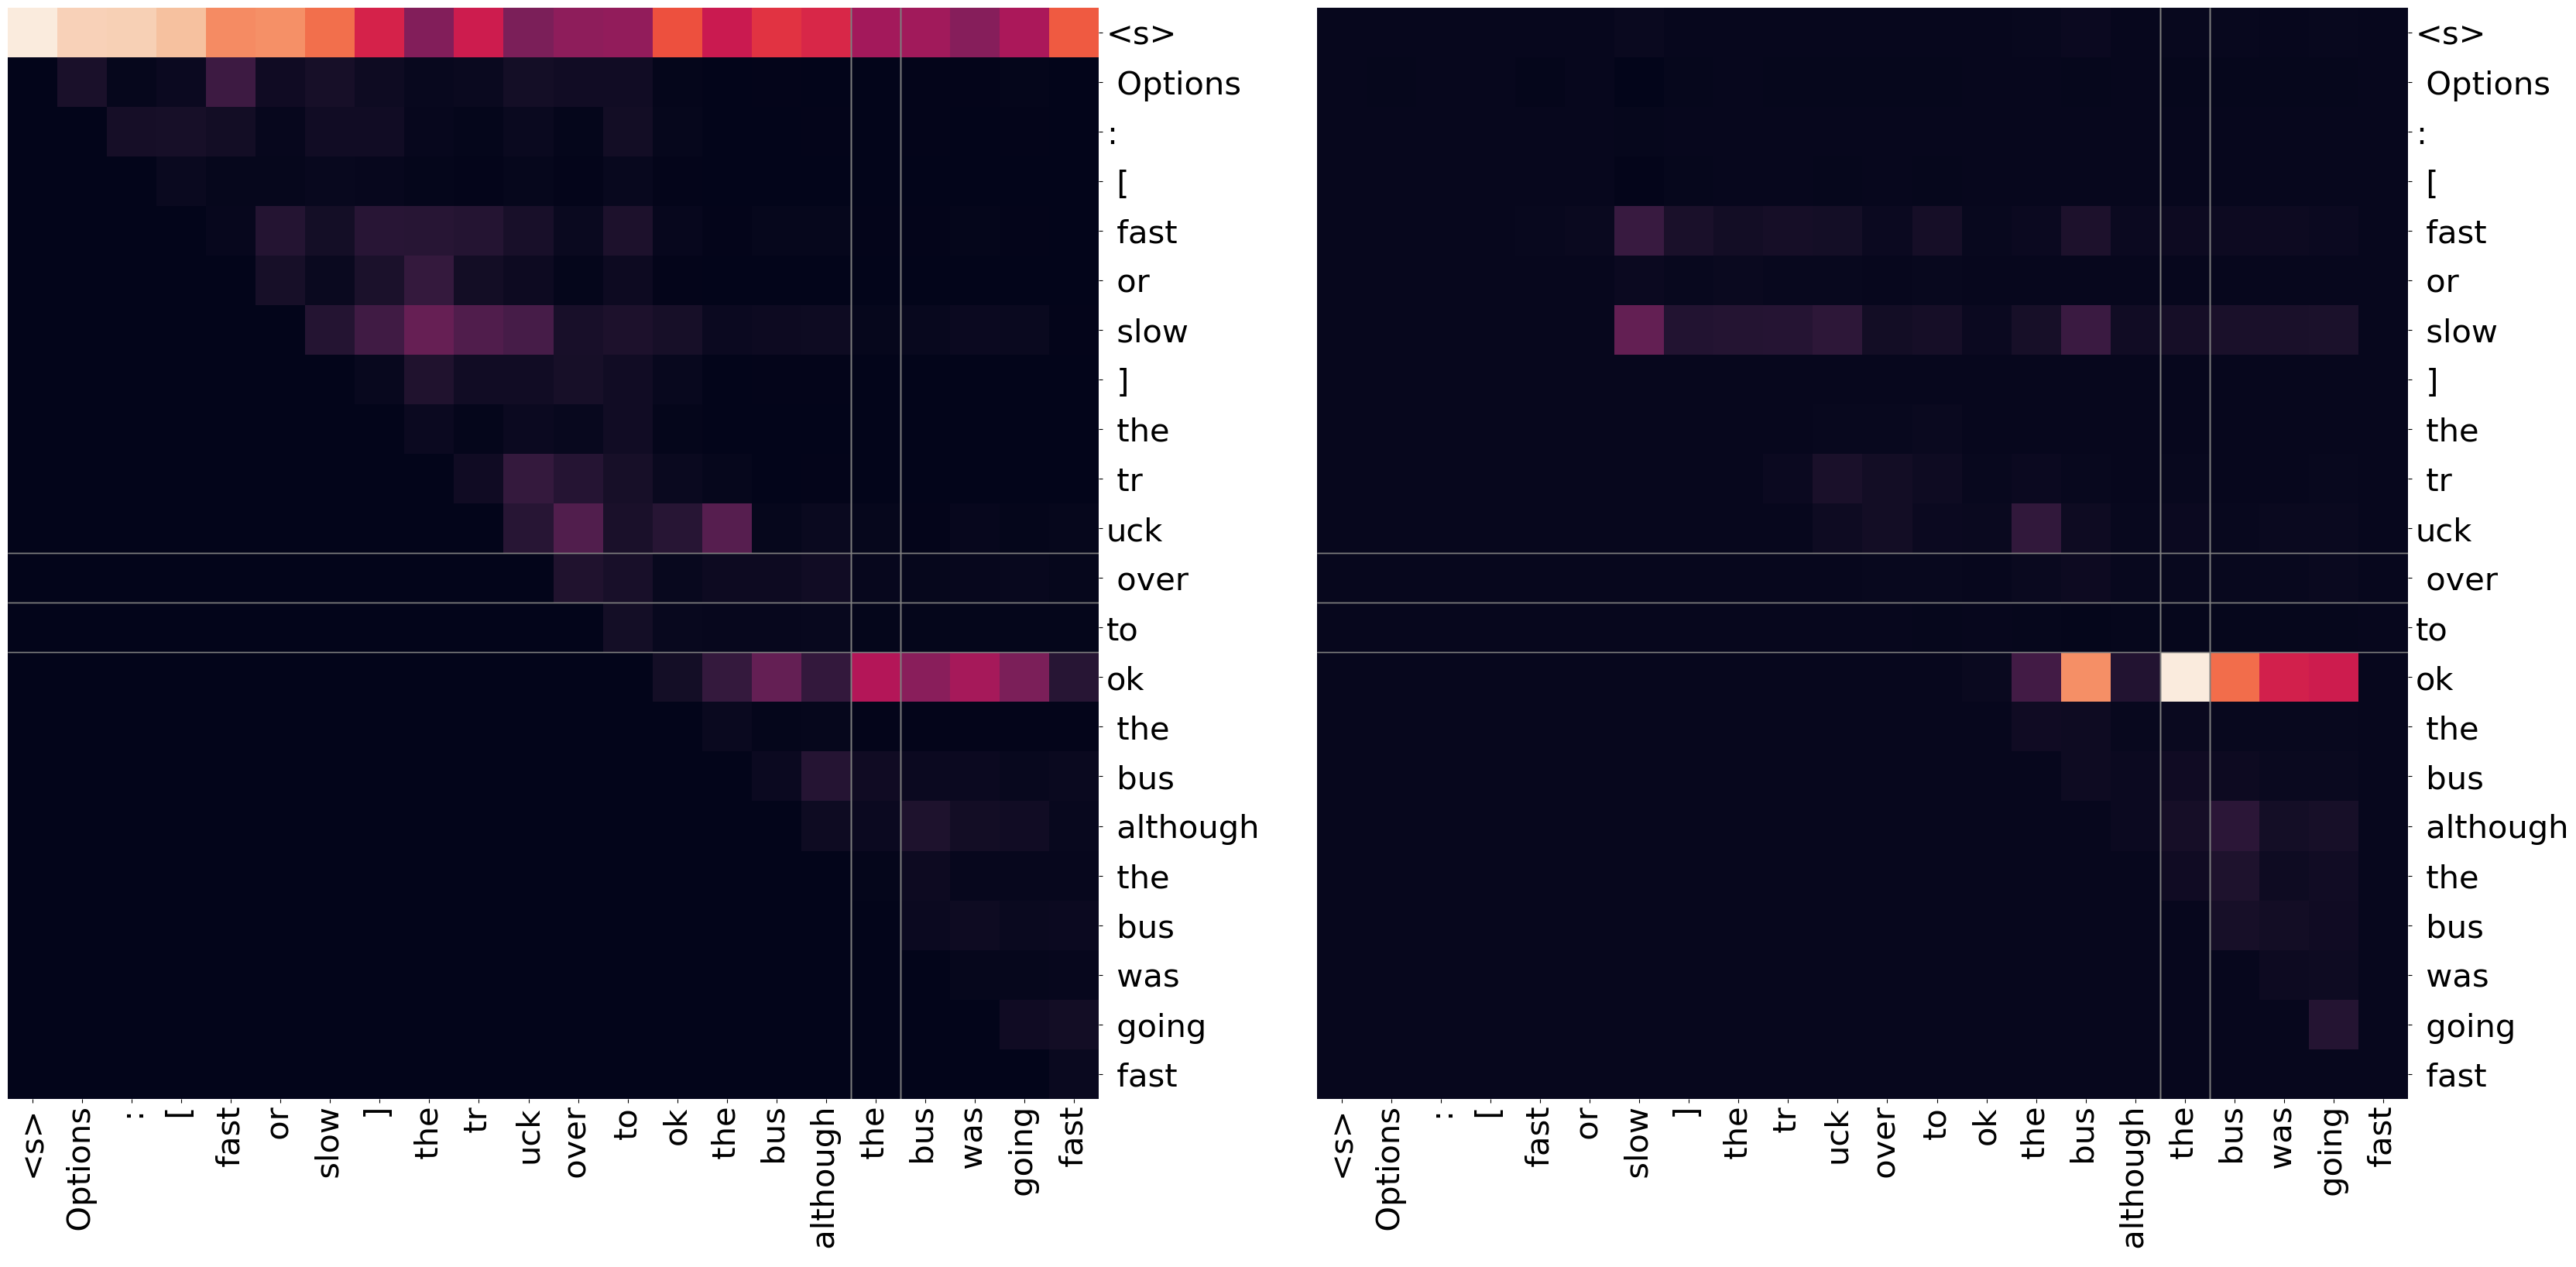

*▁soft 0.602 {'▁soft': 0.602, '▁hard': 0.398, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ hard or soft ] the ball crashed right through the board although the ball was soft ▁hard:0.131 *▁soft:0.543
ap_scores = tensor([0.3914]) tensor(0.3914)


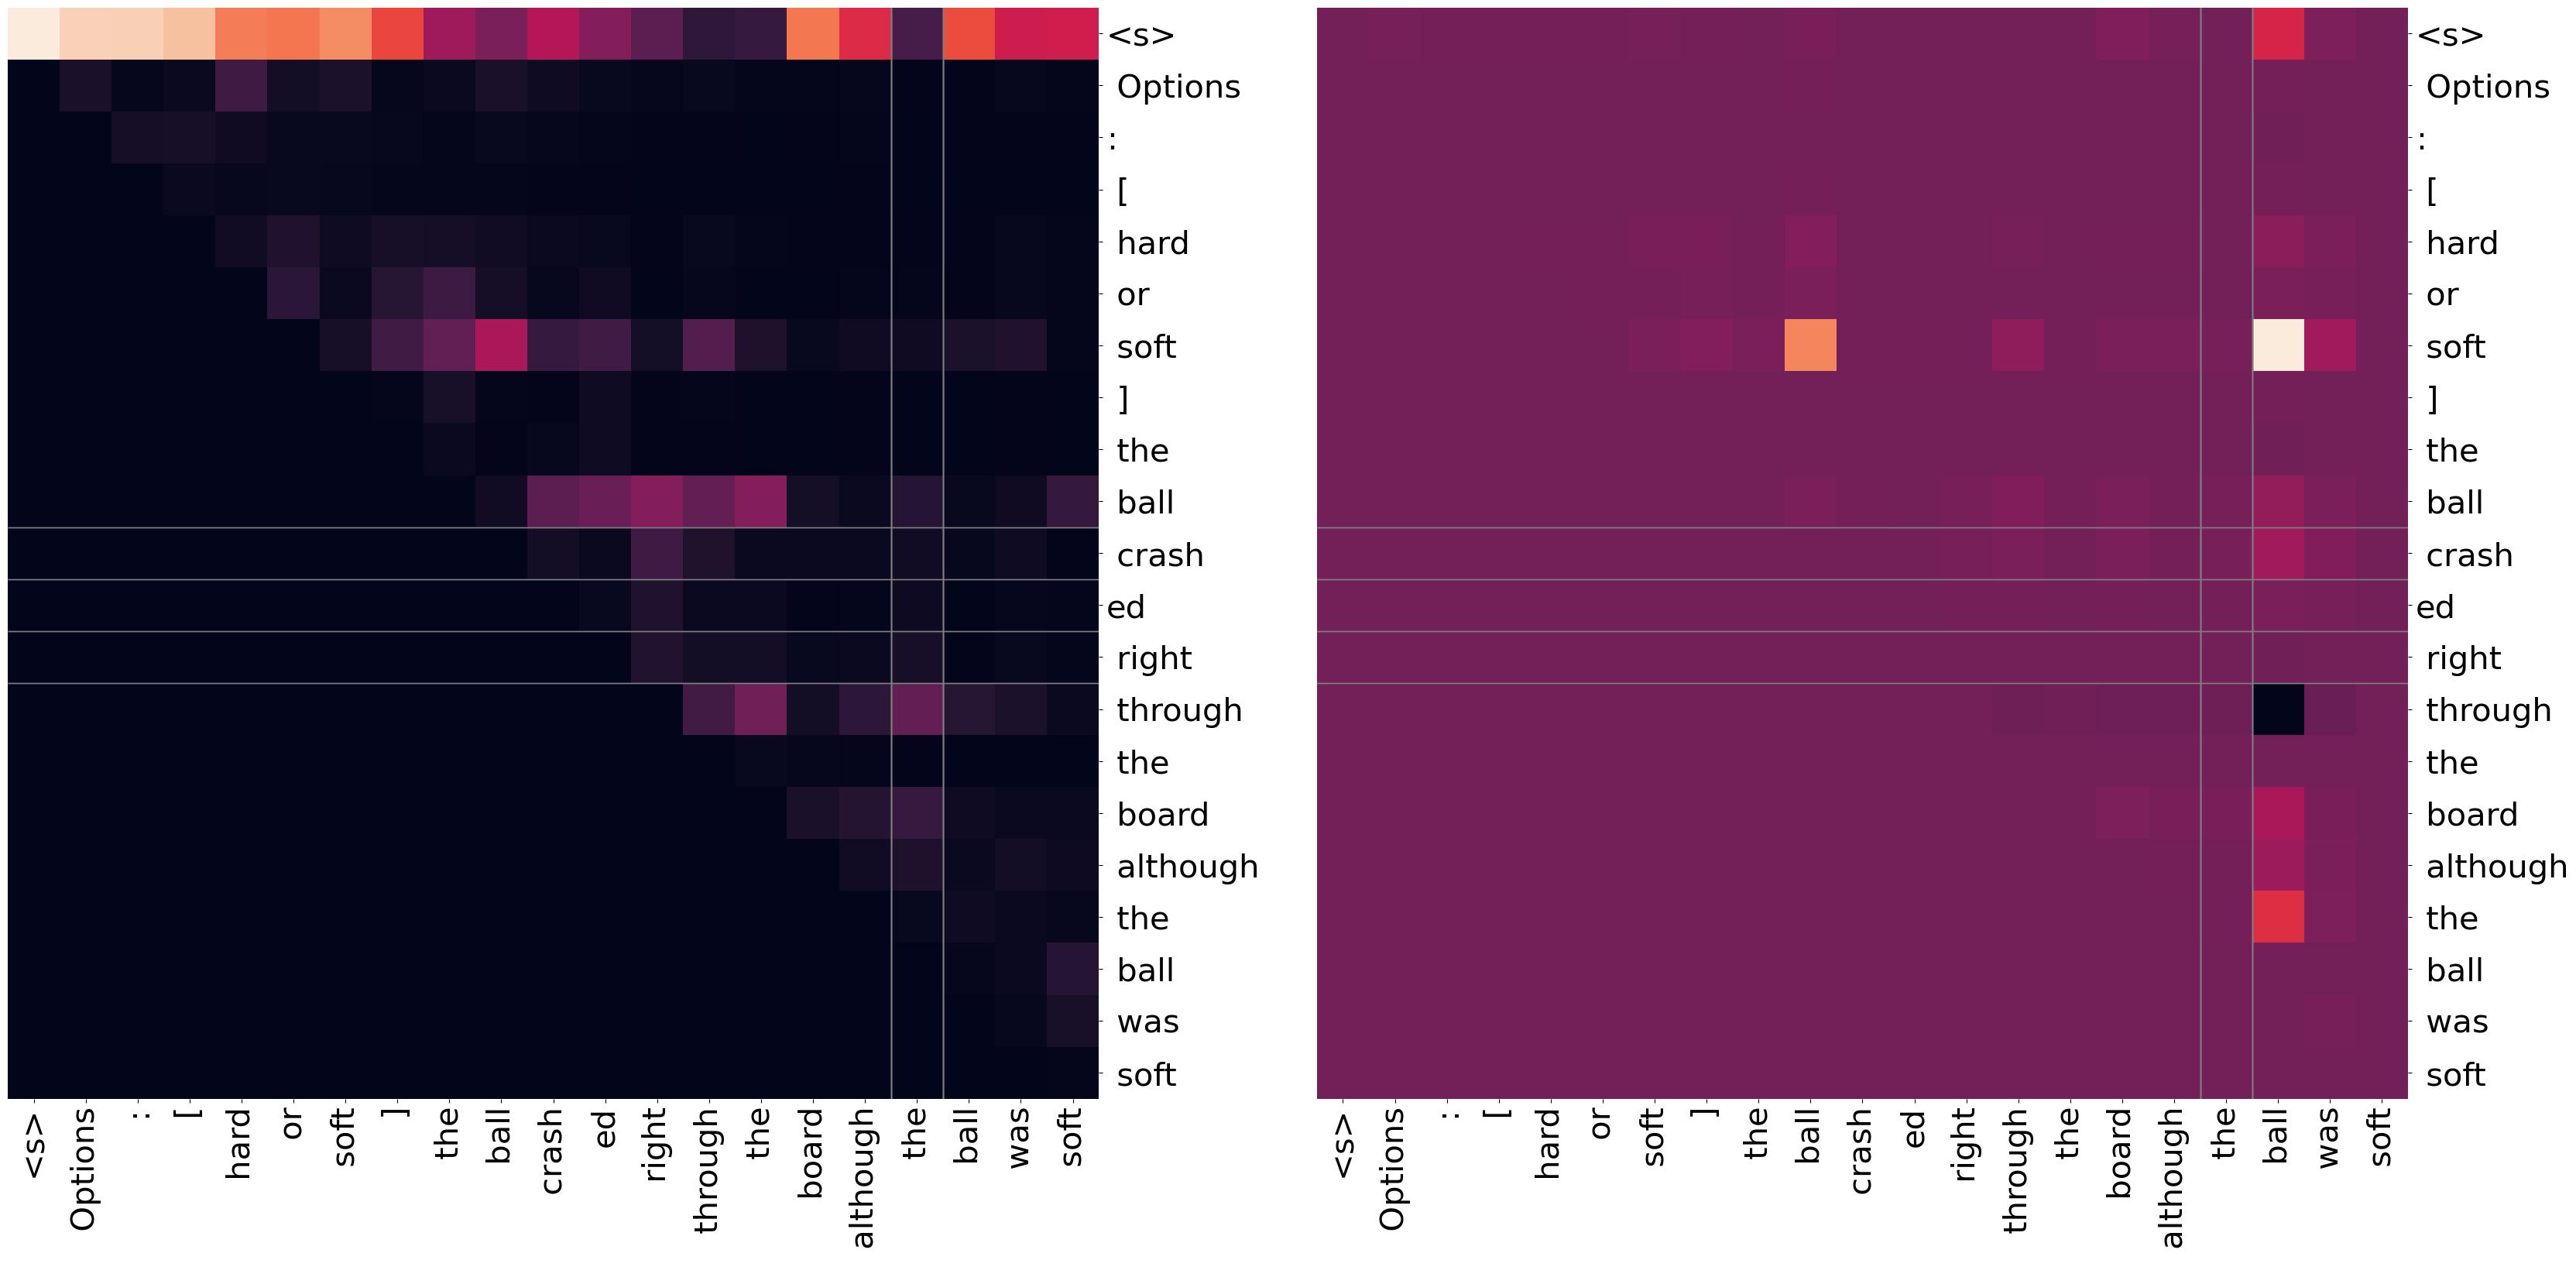

*▁hard 0.561 {'▁hard': 0.561, '▁soft': 0.439, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ soft or hard ] the ball crashed right through the board although the board was hard *▁hard:0.071 ▁soft:-0.173
ap_scores = tensor([0.4228]) tensor(0.4228)


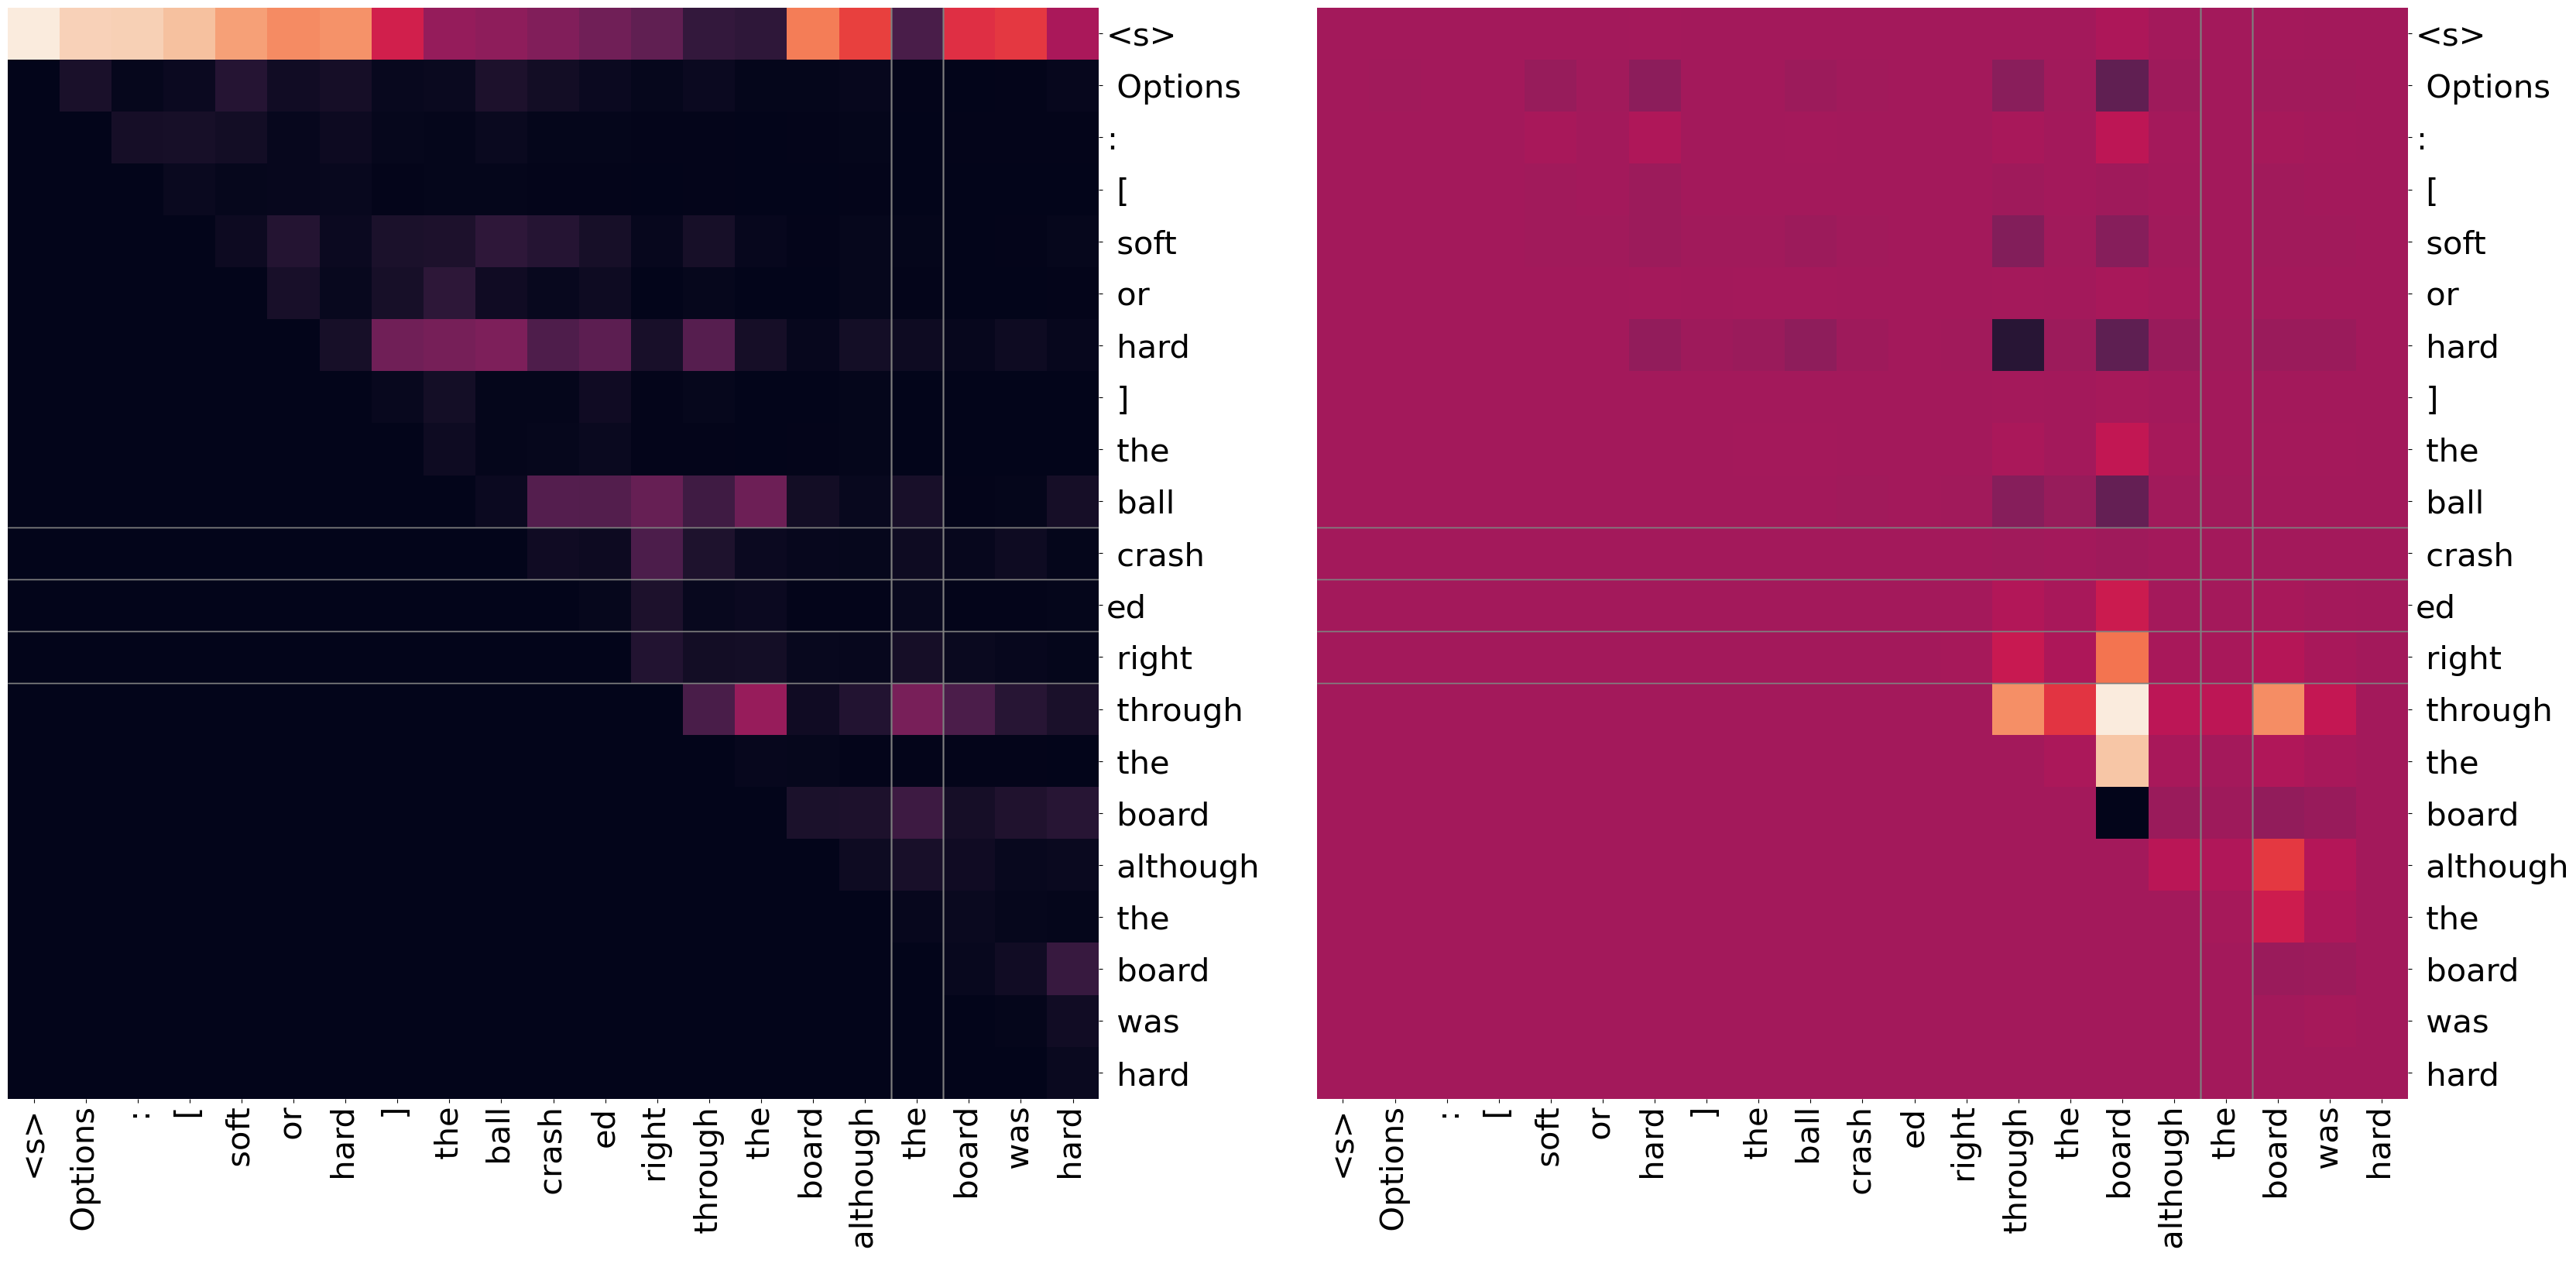

 ▁tall 0.004 {'▁short': 0.996, '▁tall': 0.004, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ tall or short ] John couldn't see the stage behind Susan although John is tall ▁short:6.266 *▁tall:0.646
ap_scores = tensor([0.2678]) tensor(0.2678)


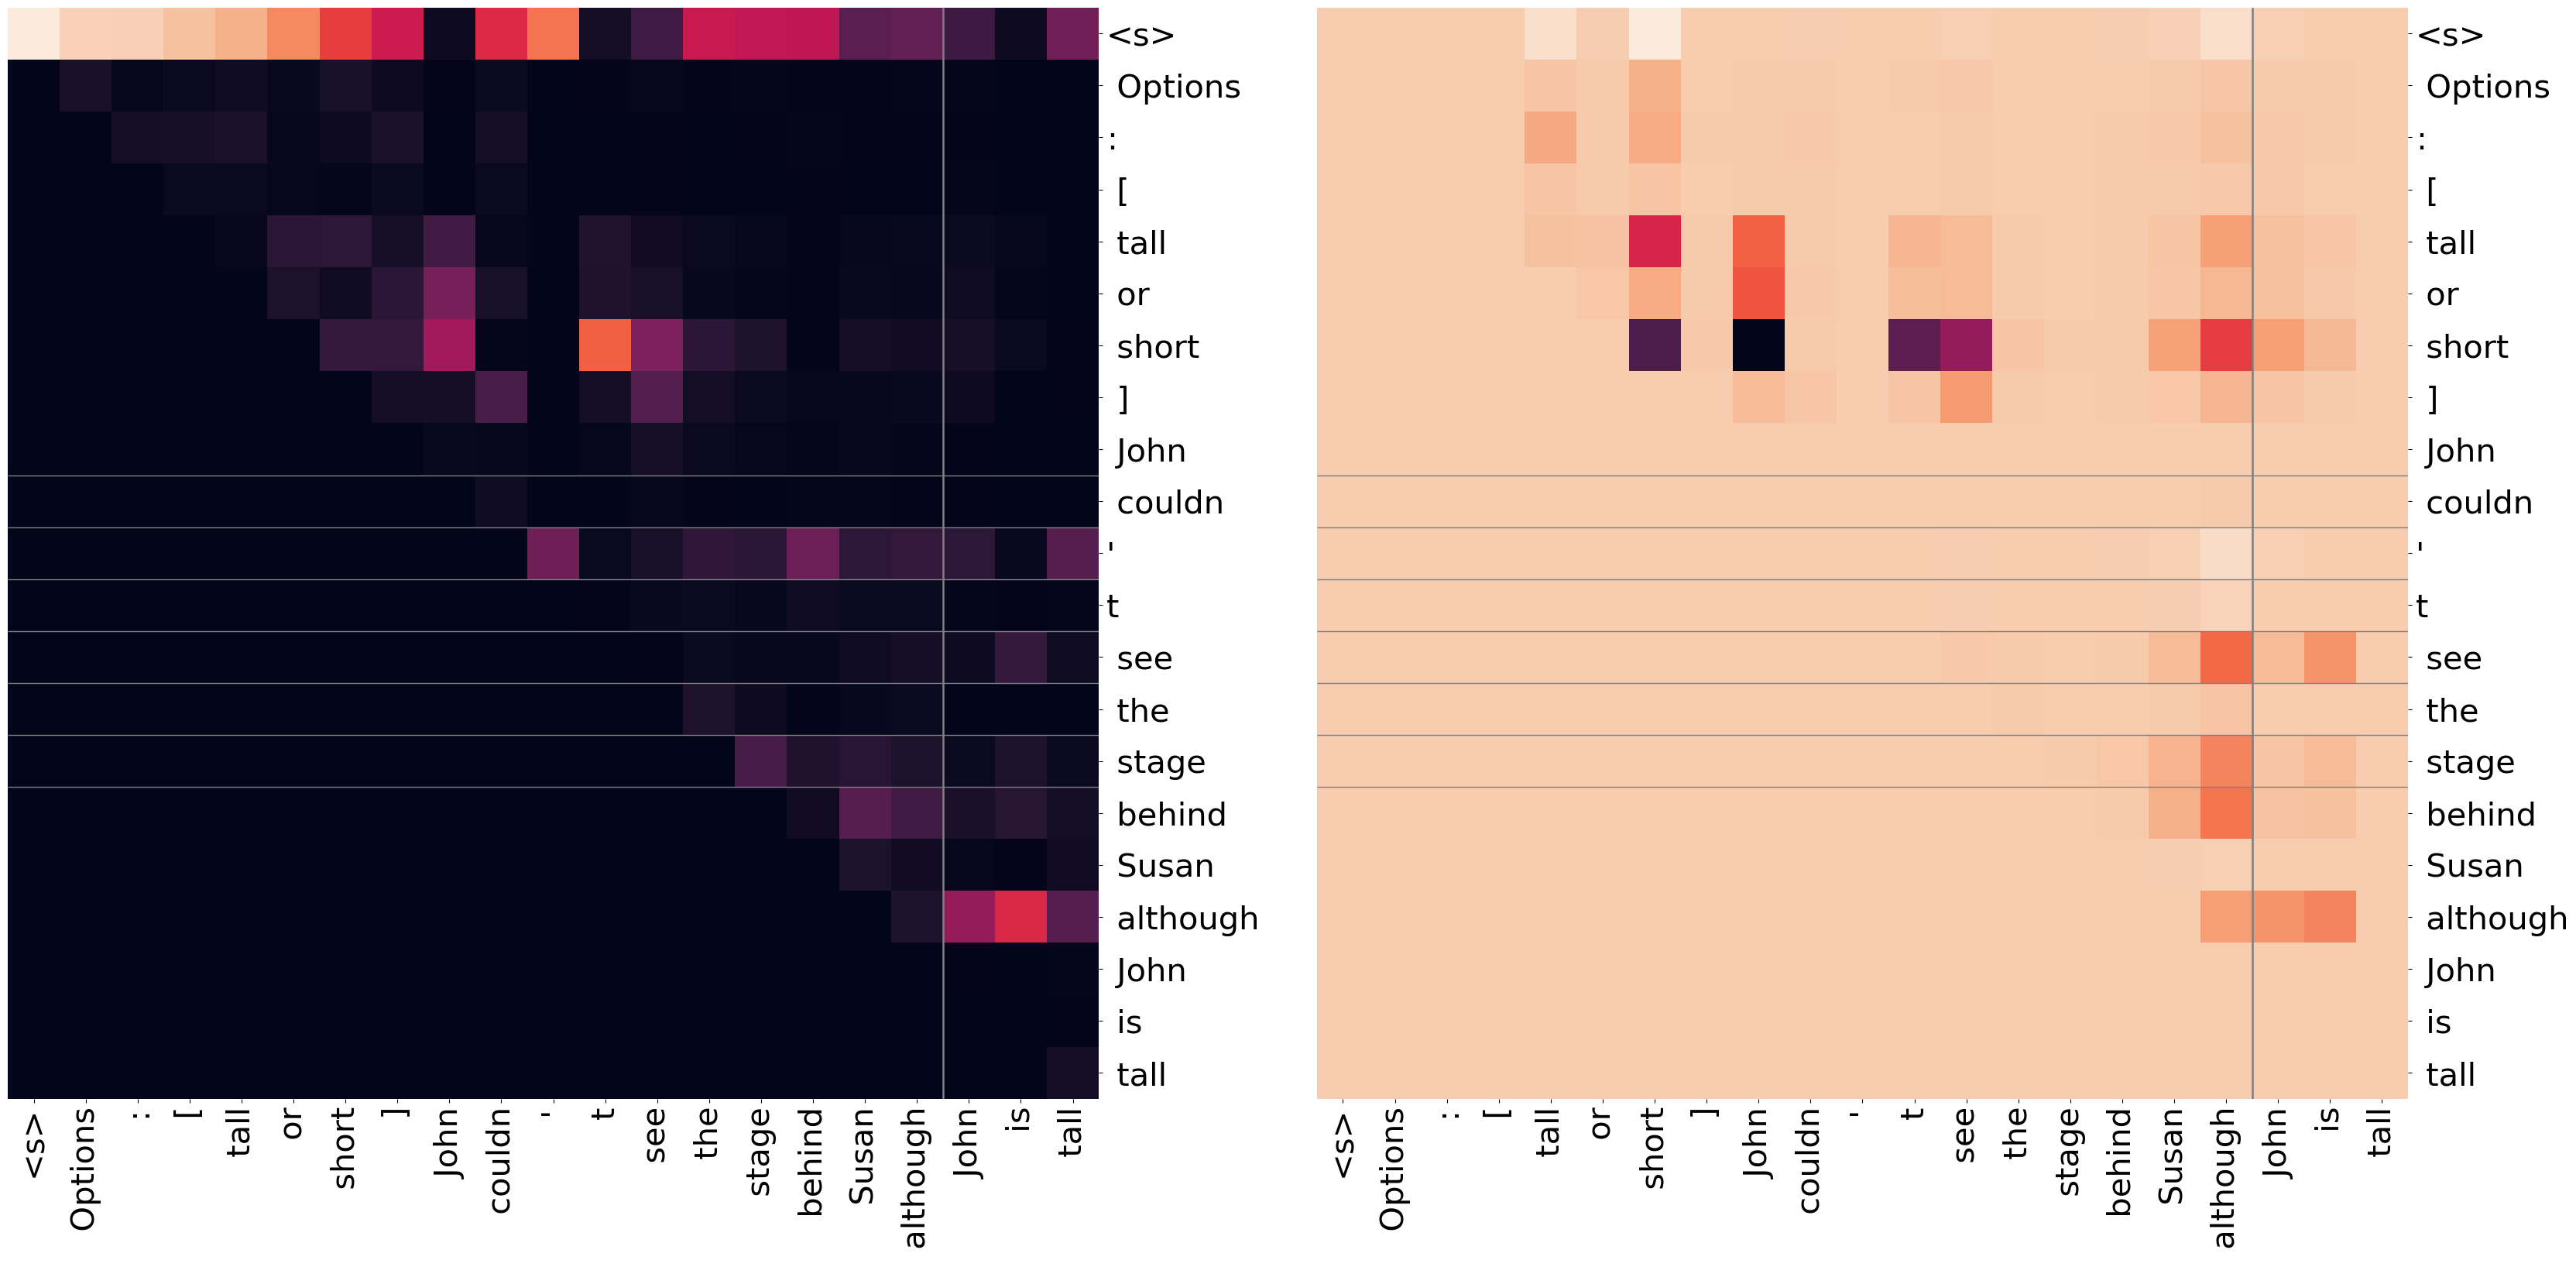

*▁short 0.998 {'▁short': 0.998, '▁tall': 0.002, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ short or tall ] John couldn't see the stage behind Susan although Susan is short *▁short:7.281 ▁tall:1.264
ap_scores = tensor([0.5726]) tensor(0.5726)


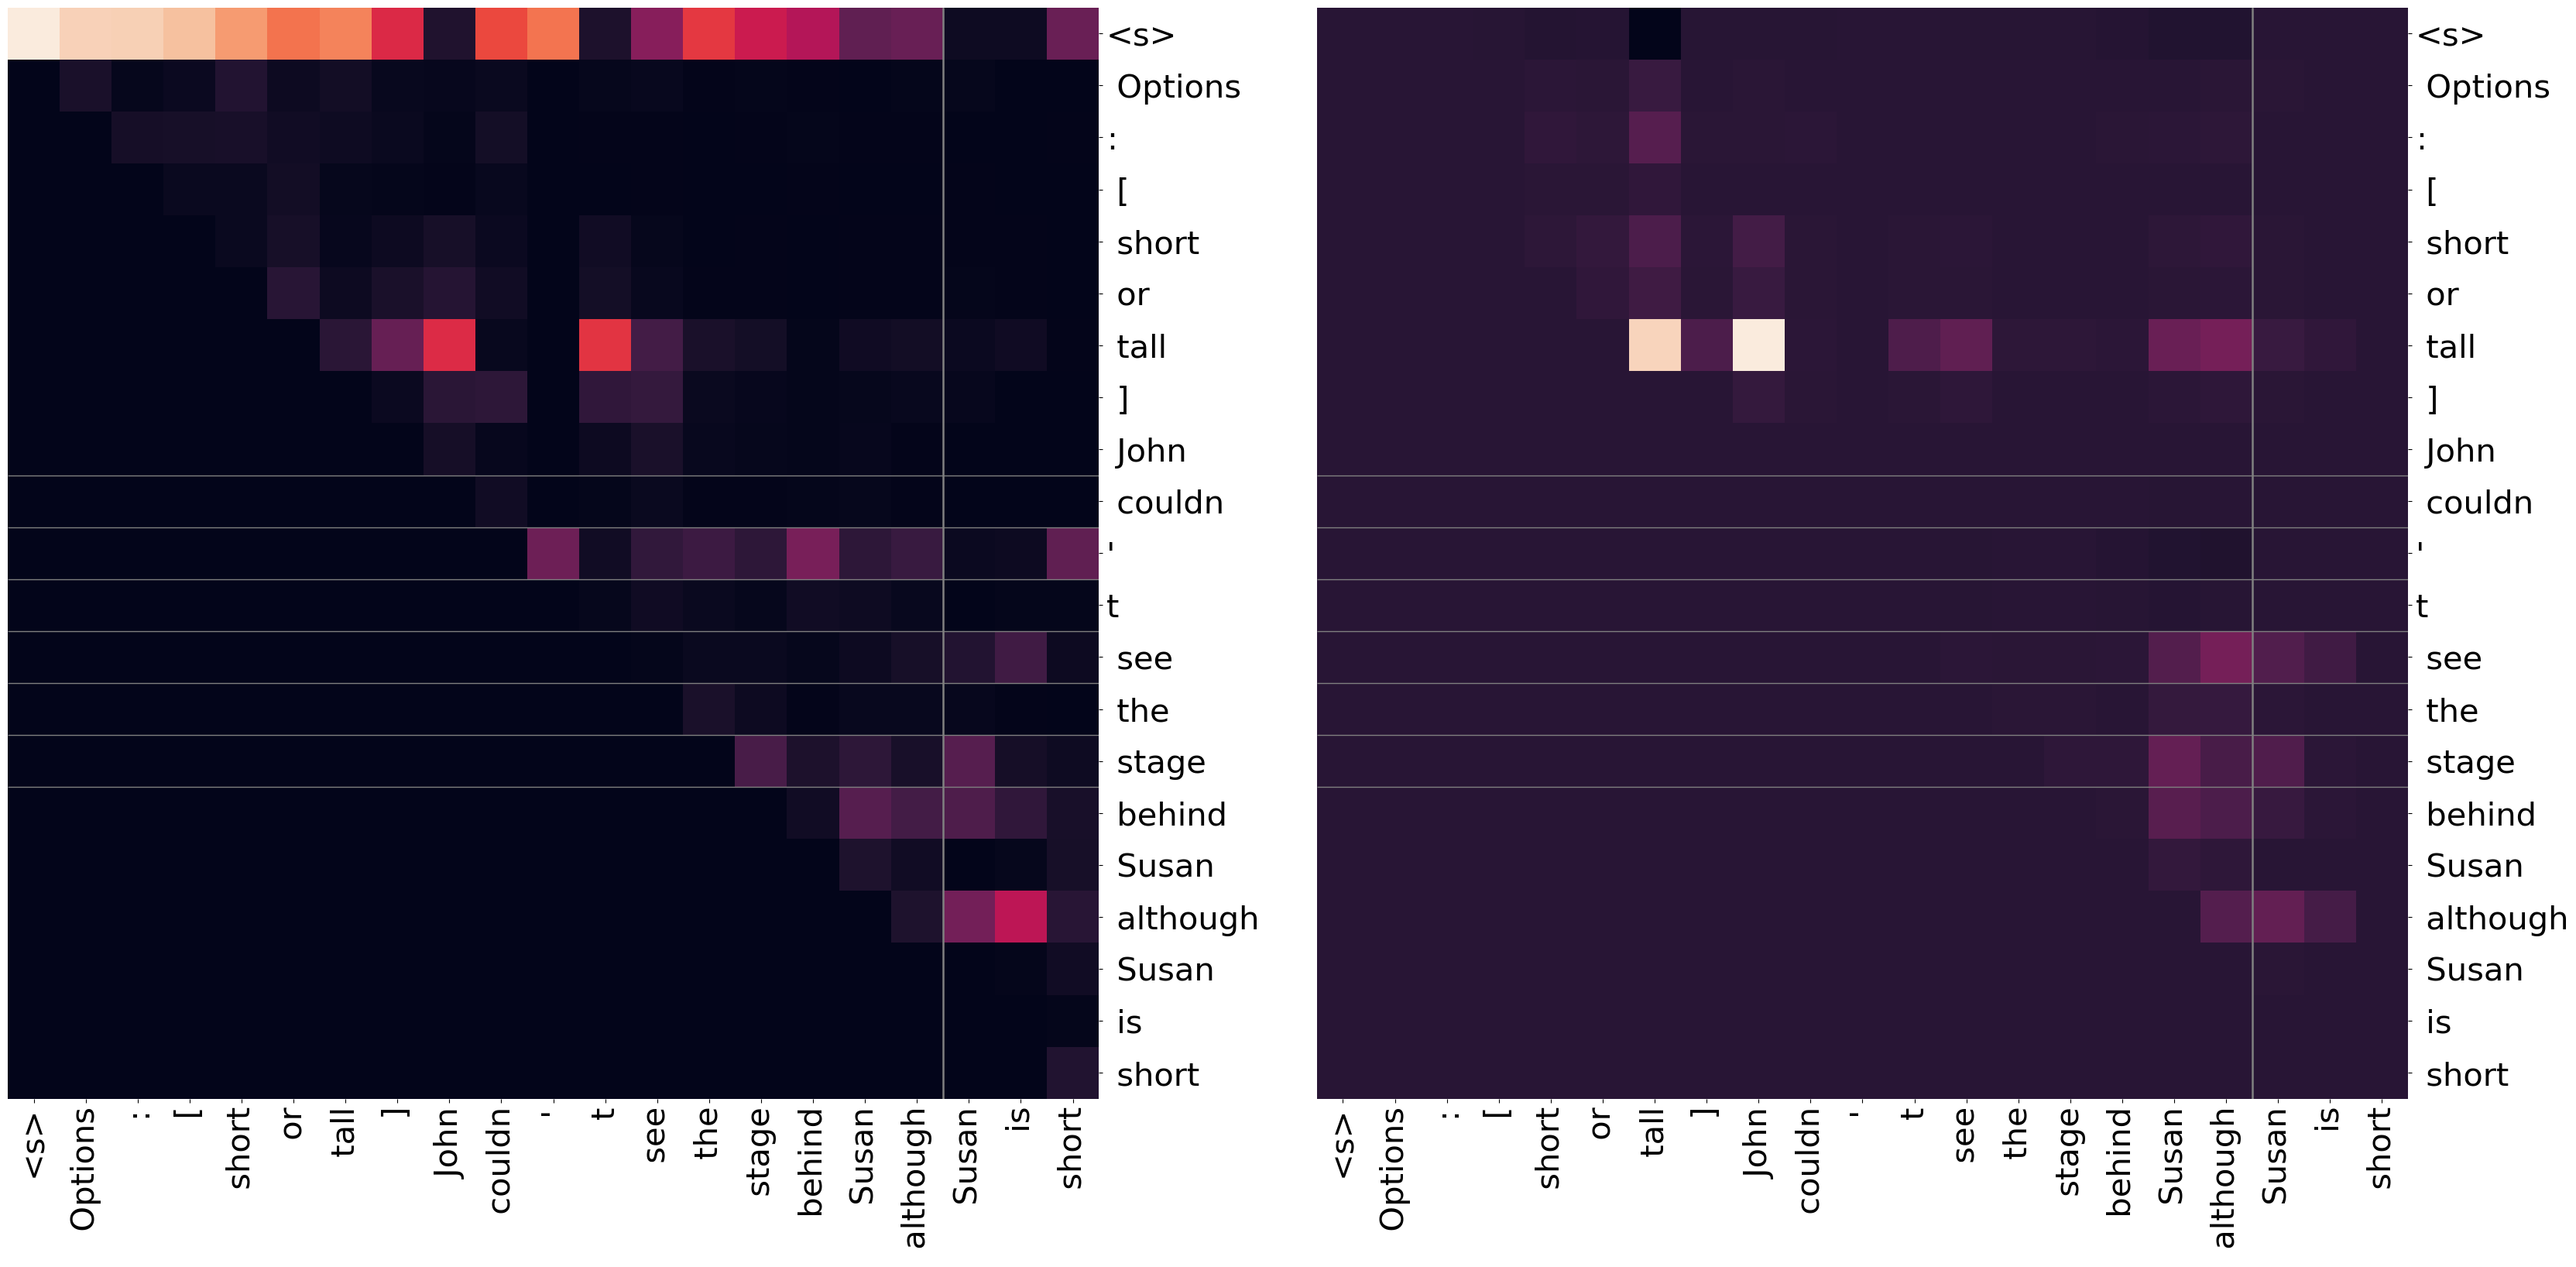

 ▁later 0.199 {'▁first': 0.801, '▁later': 0.2, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ later or first ] the bag of potatoes had been placed above the bag of flour although the bag of potatoes had to be moved later ▁first:1.455 *▁later:0.065
ap_scores = tensor([0.5477]) tensor(0.5477)


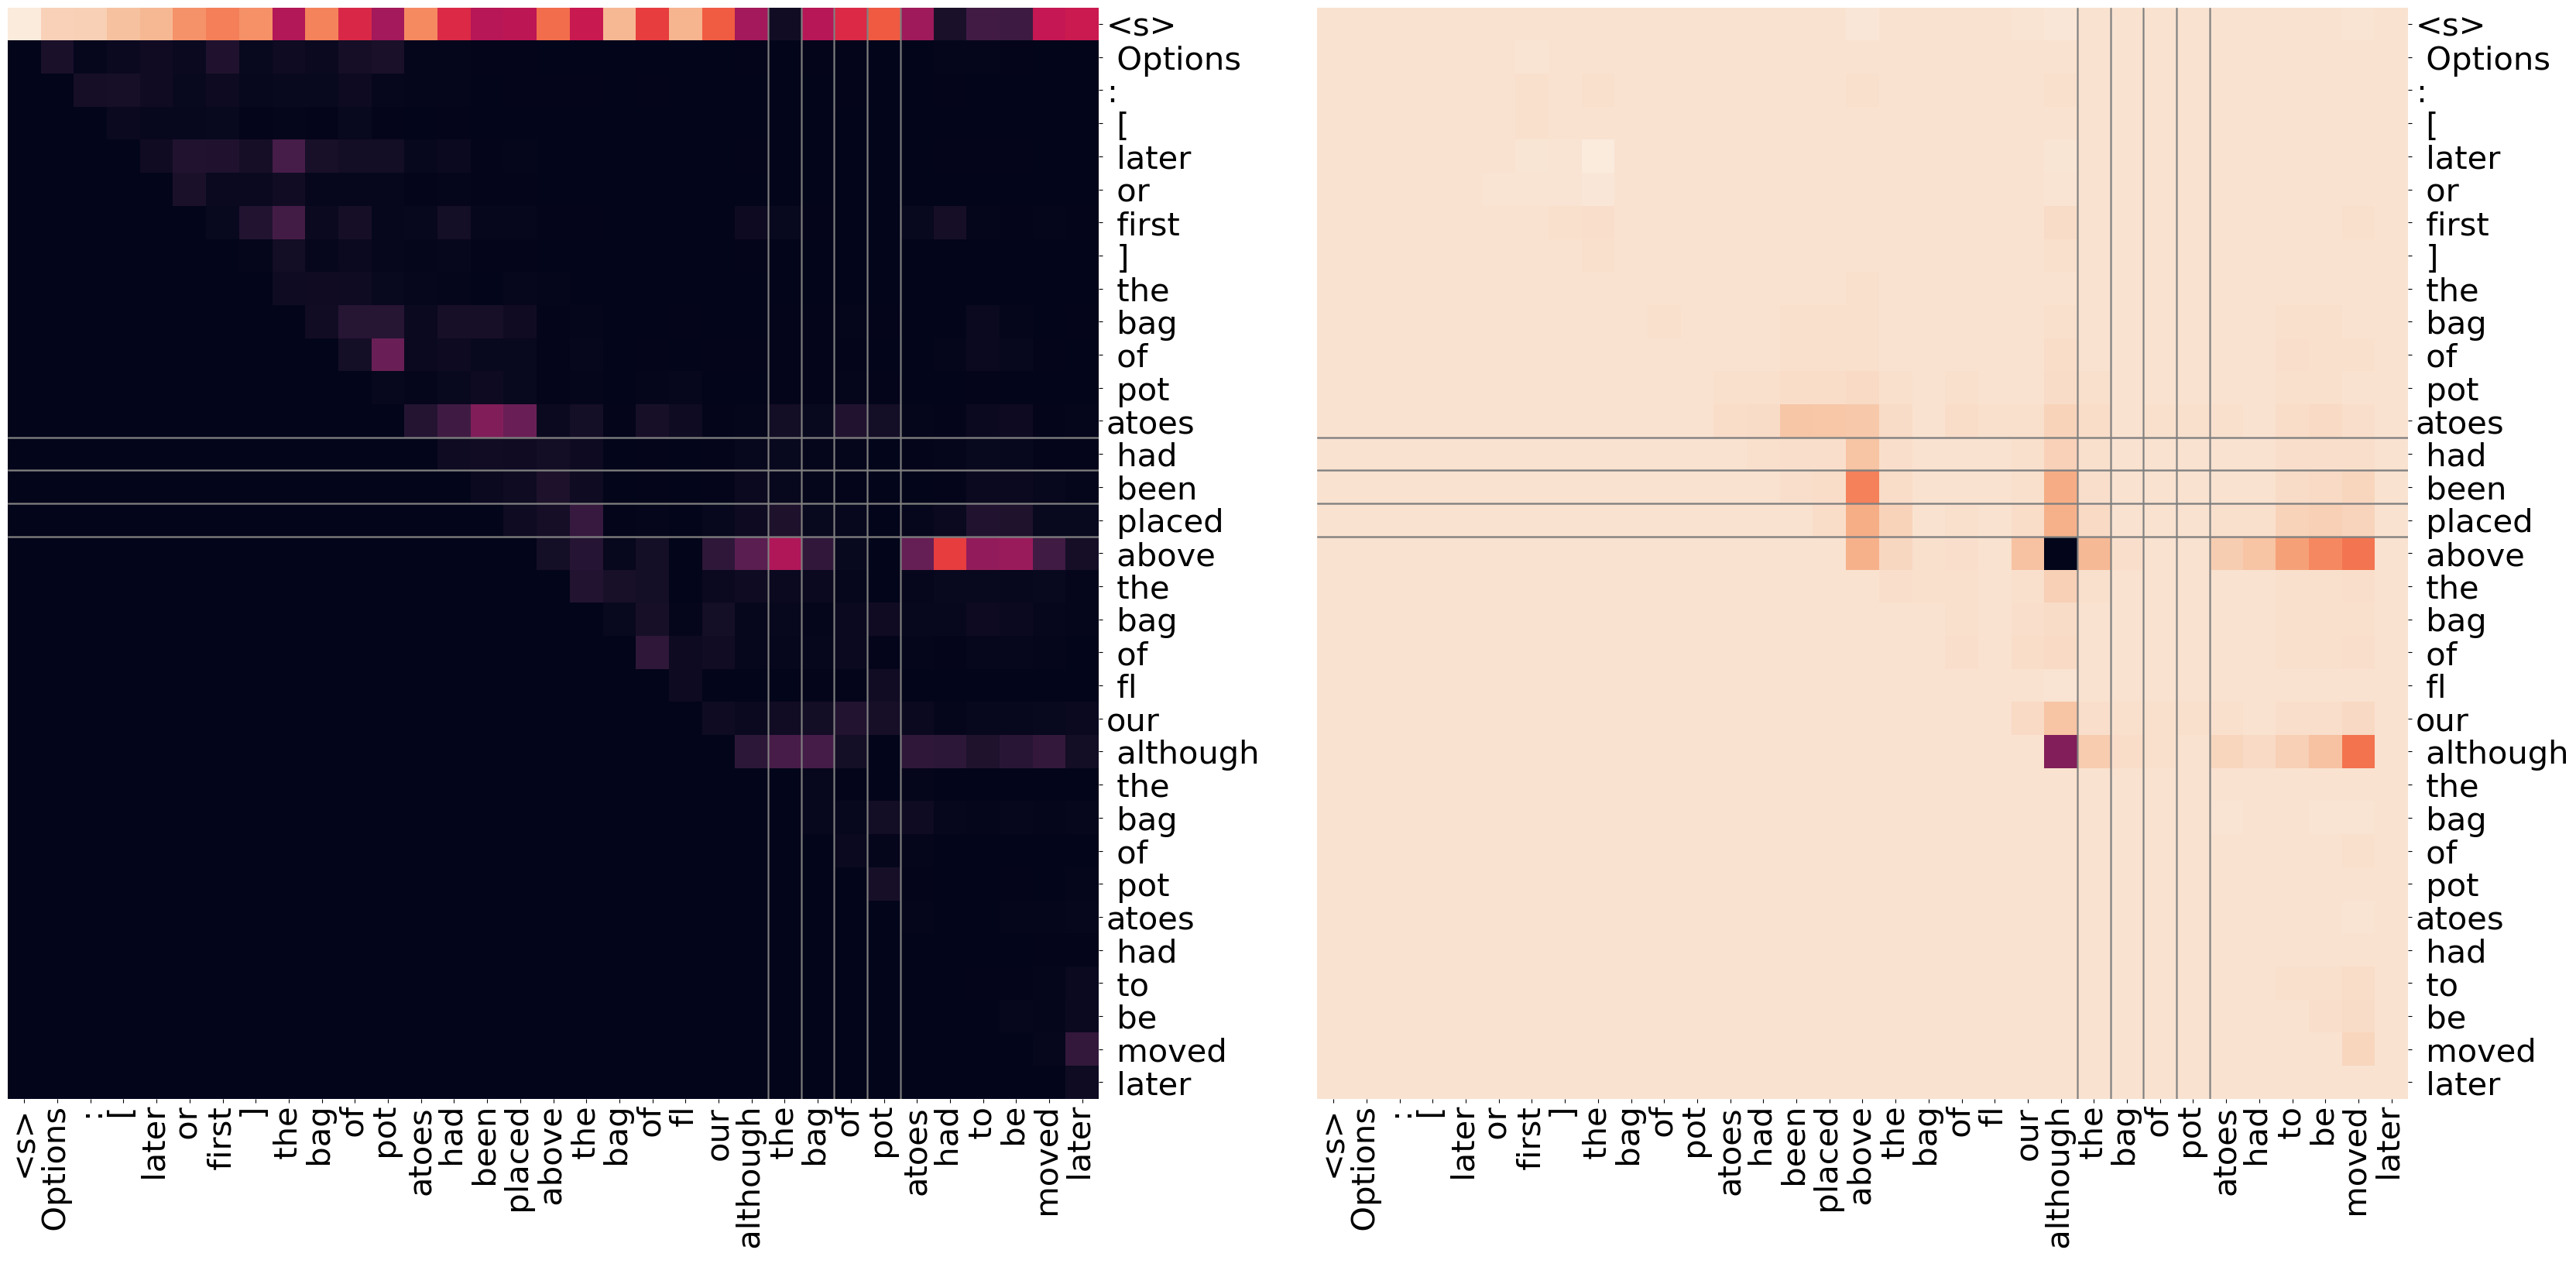

*▁first 0.839 {'▁first': 0.84, '▁later': 0.16, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ first or later ] the bag of potatoes had been placed above the bag of flour although the bag of flour had to be moved first *▁first:1.757 ▁later:0.102
ap_scores = tensor([0.5248]) tensor(0.5248)


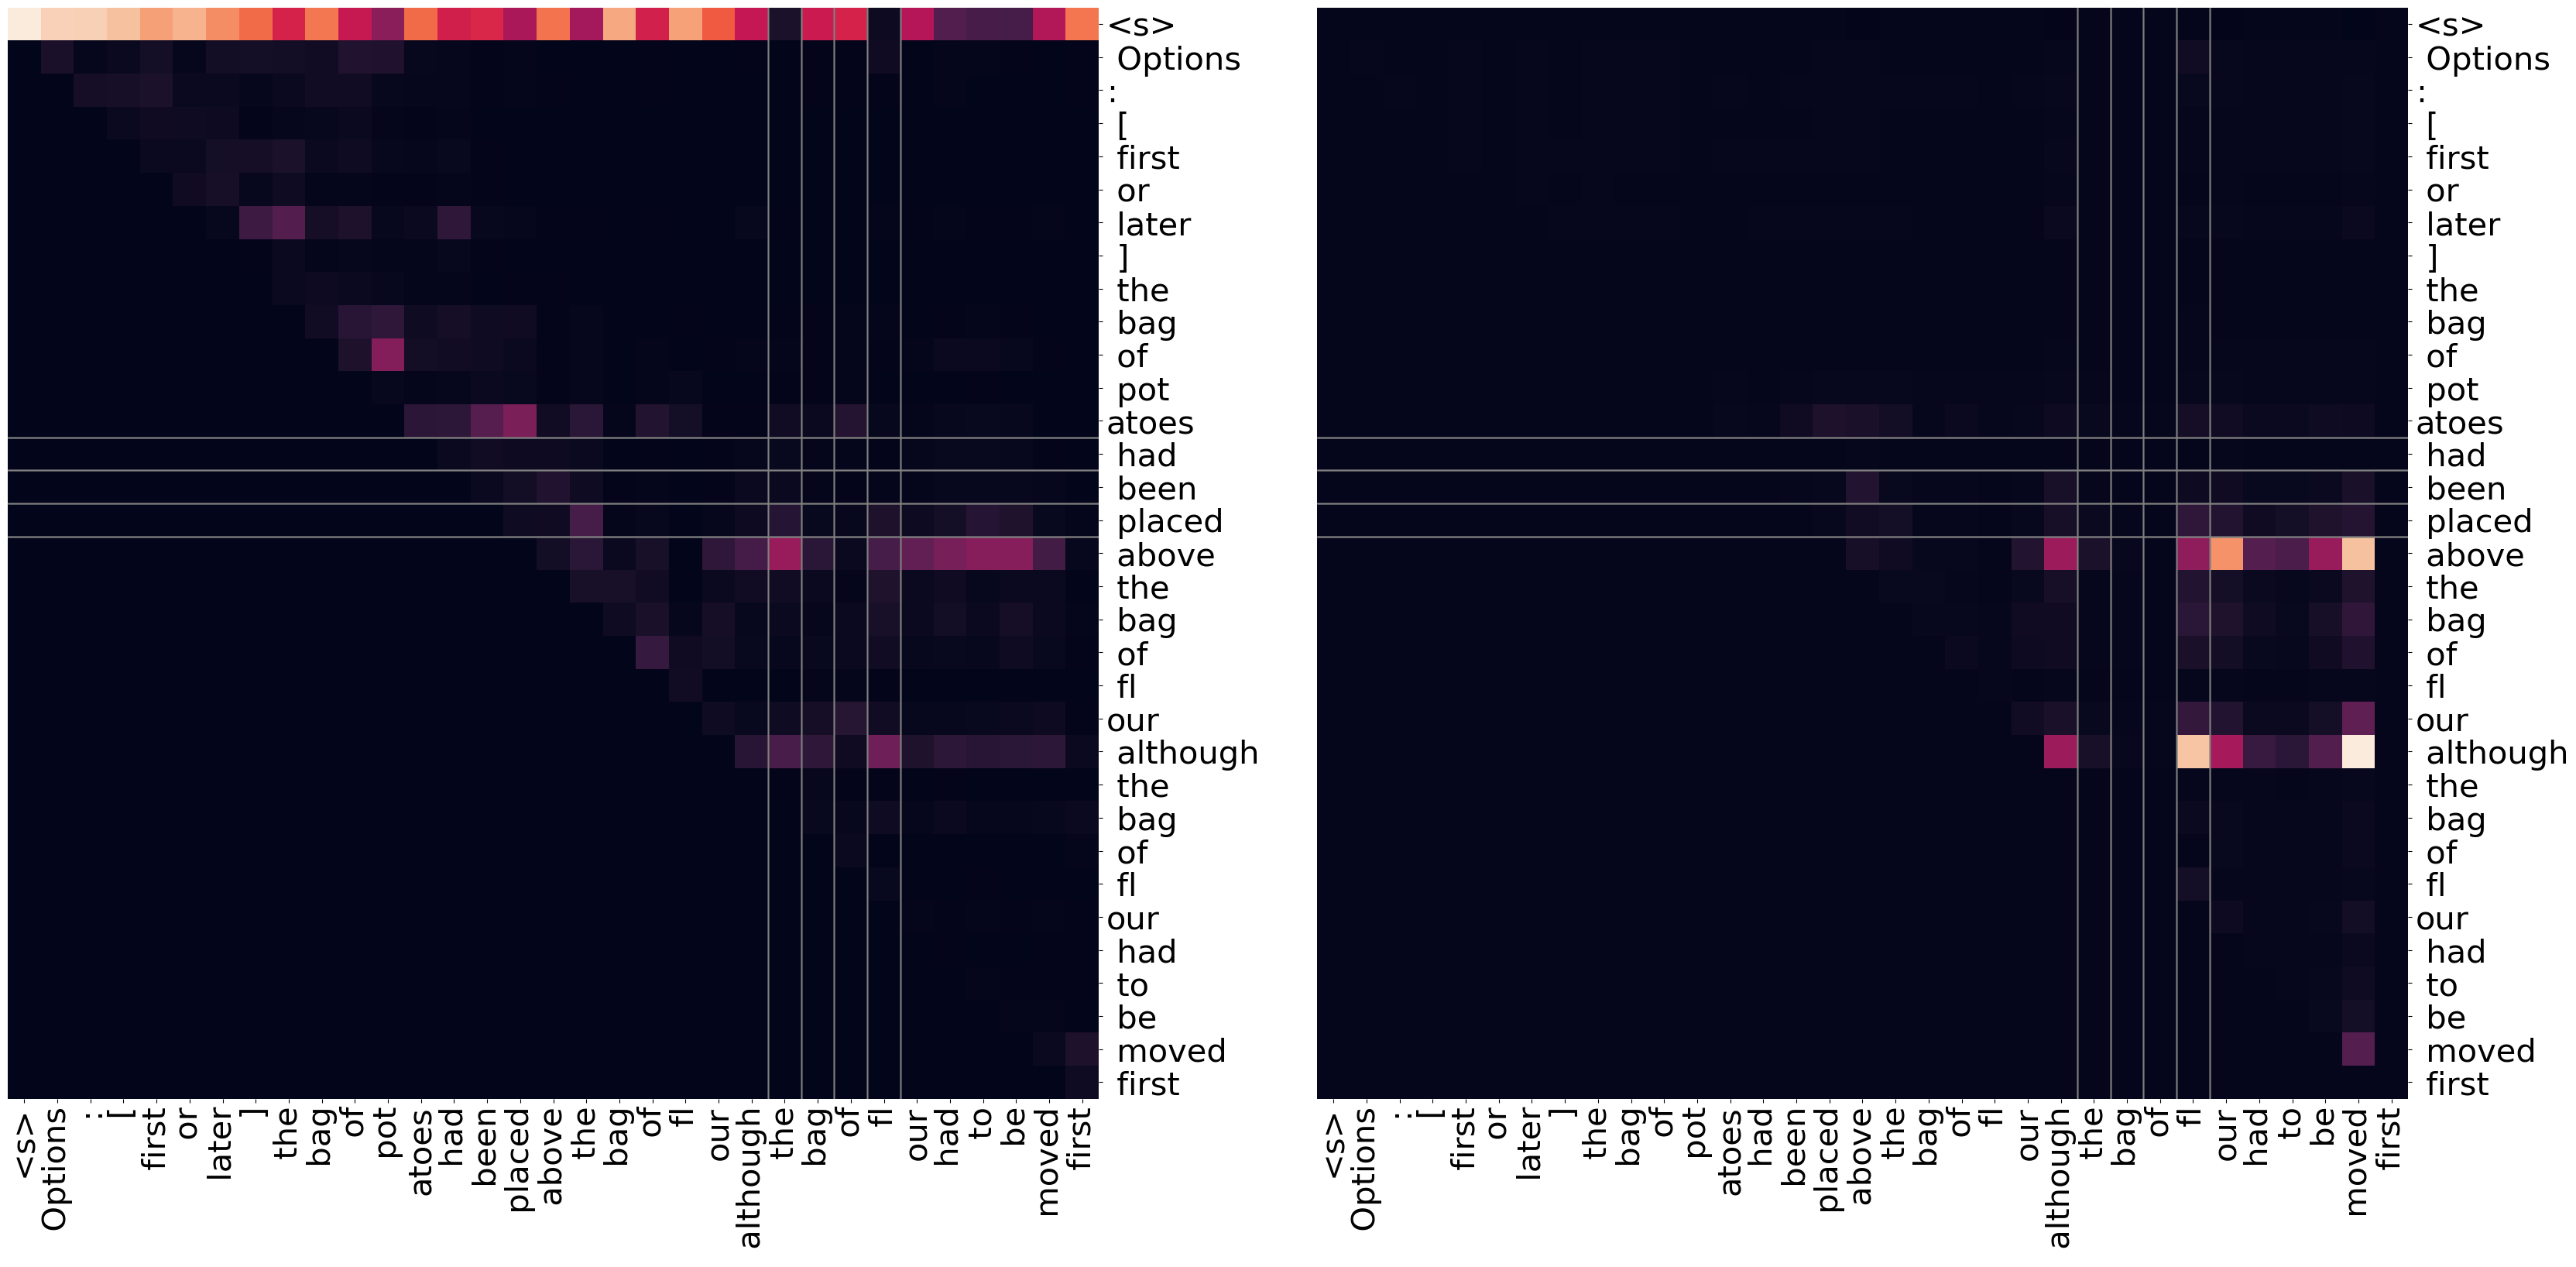

 ▁full 0.052 {'▁empty': 0.948, '▁full': 0.052, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ full or empty ] the bottle was filled with water from the cup although the bottle was full ▁empty:3.906 *▁full:1.010
ap_scores = tensor([0.5127]) tensor(0.5127)


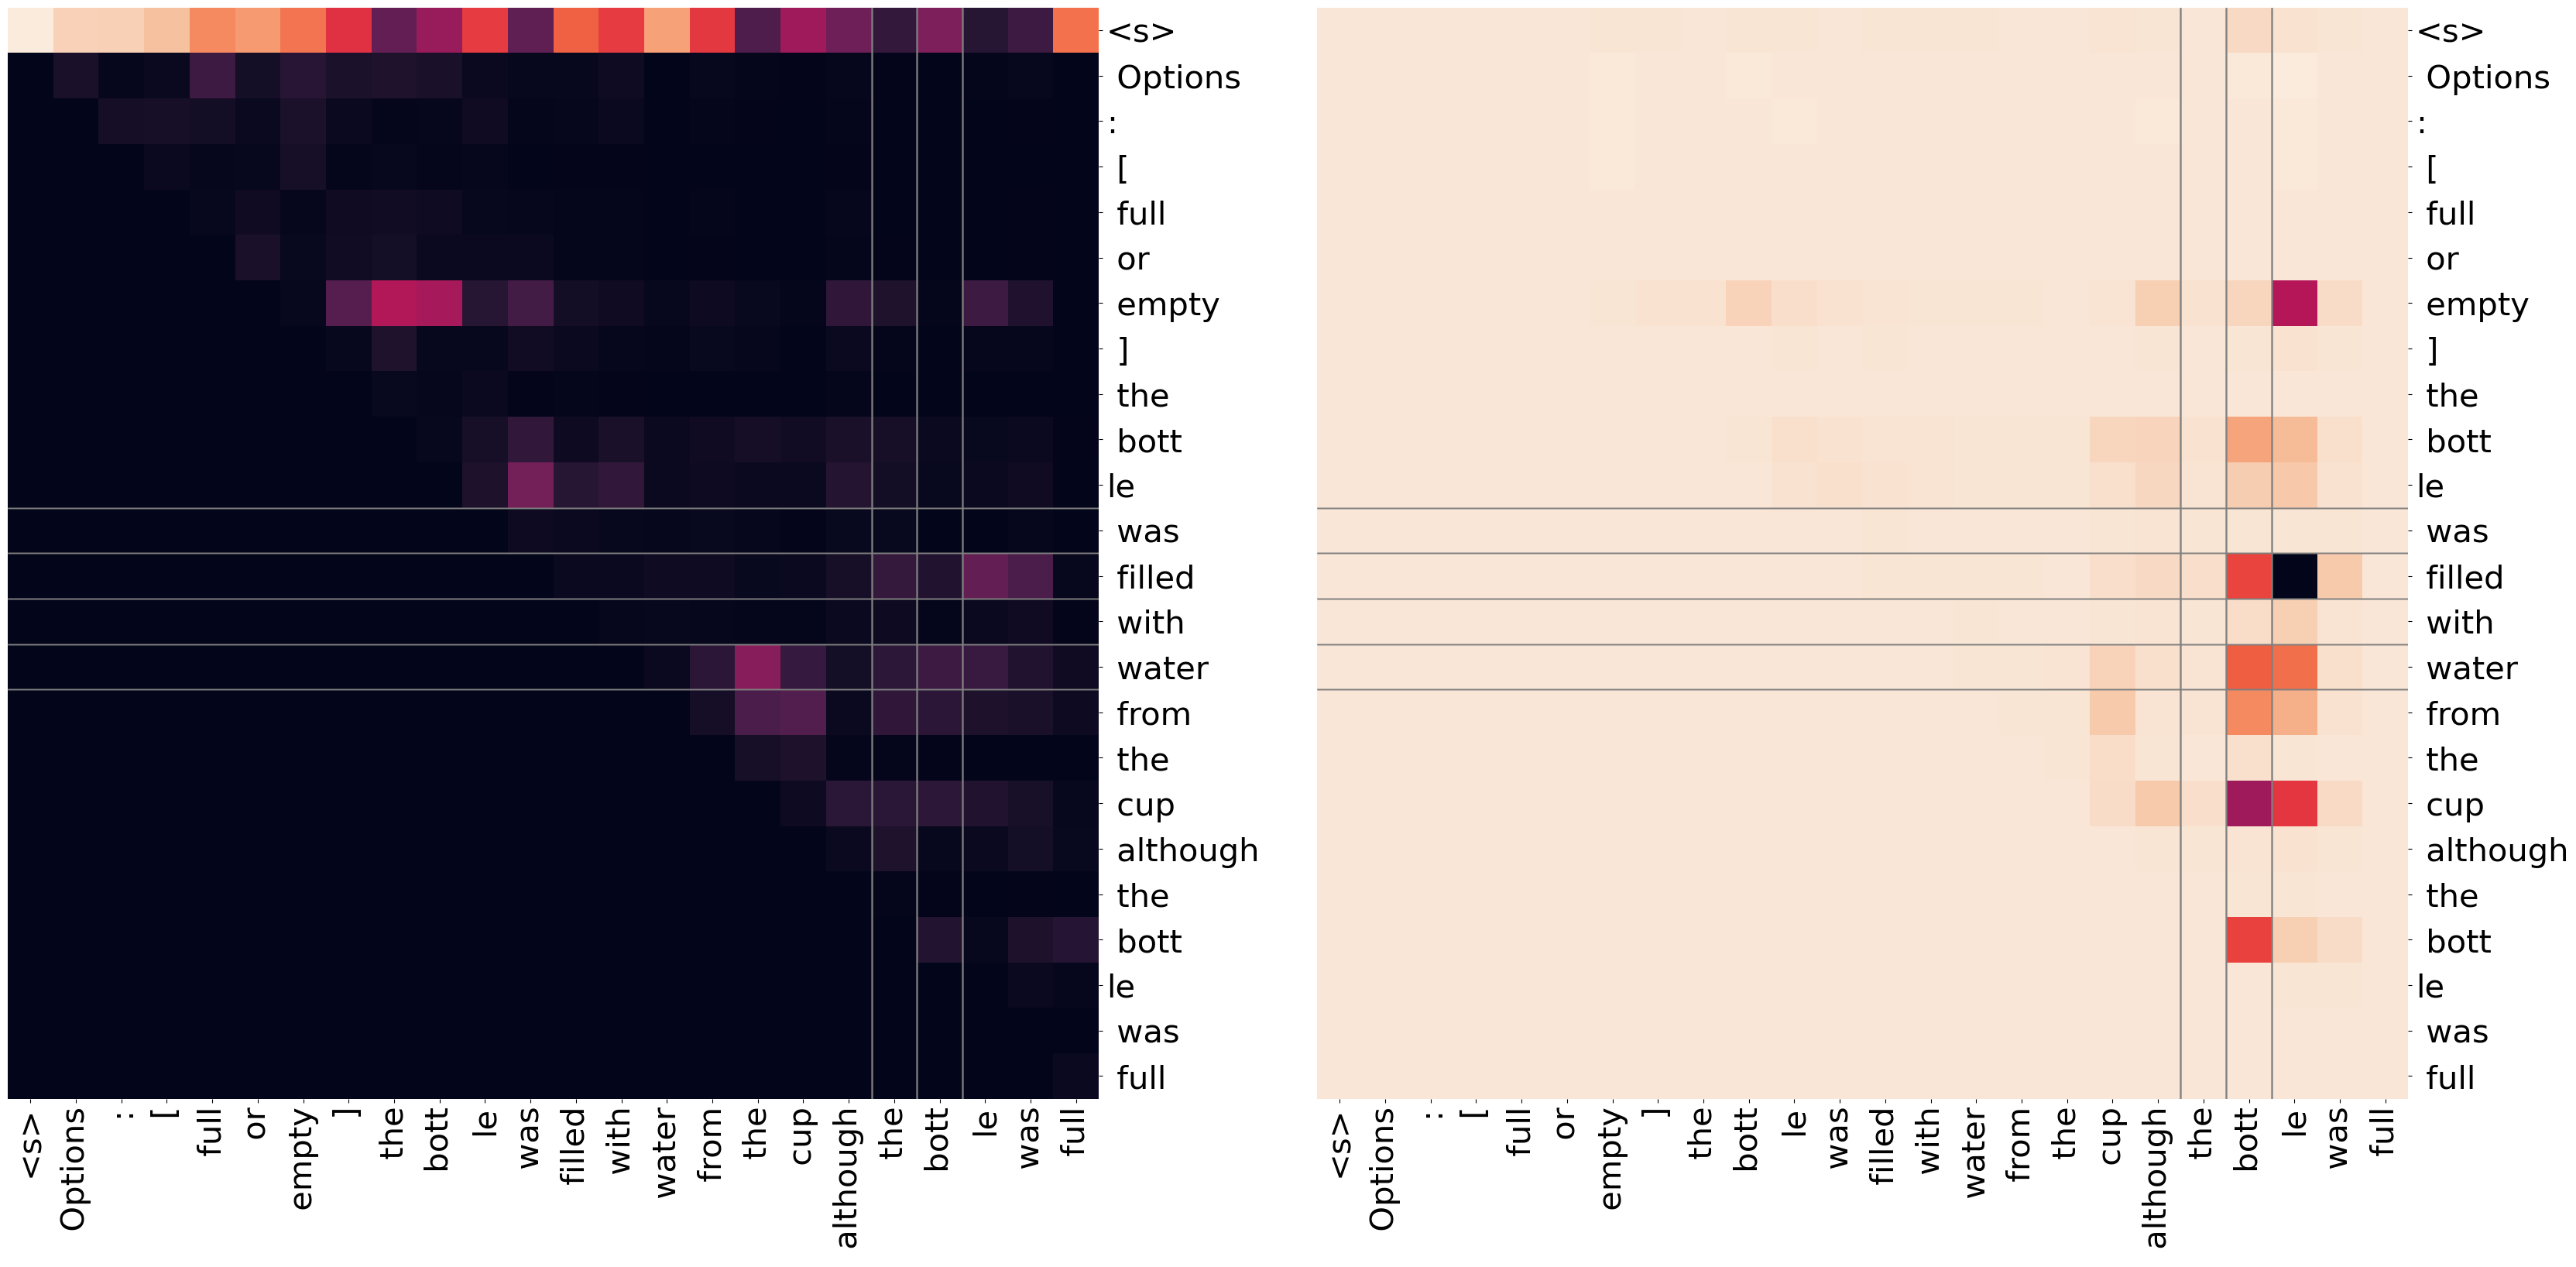

*▁empty 0.934 {'▁empty': 0.934, '▁full': 0.066, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ empty or full ] the bottle was filled with water from the cup although the cup was empty *▁empty:3.443 ▁full:0.802
ap_scores = tensor([0.4622]) tensor(0.4622)


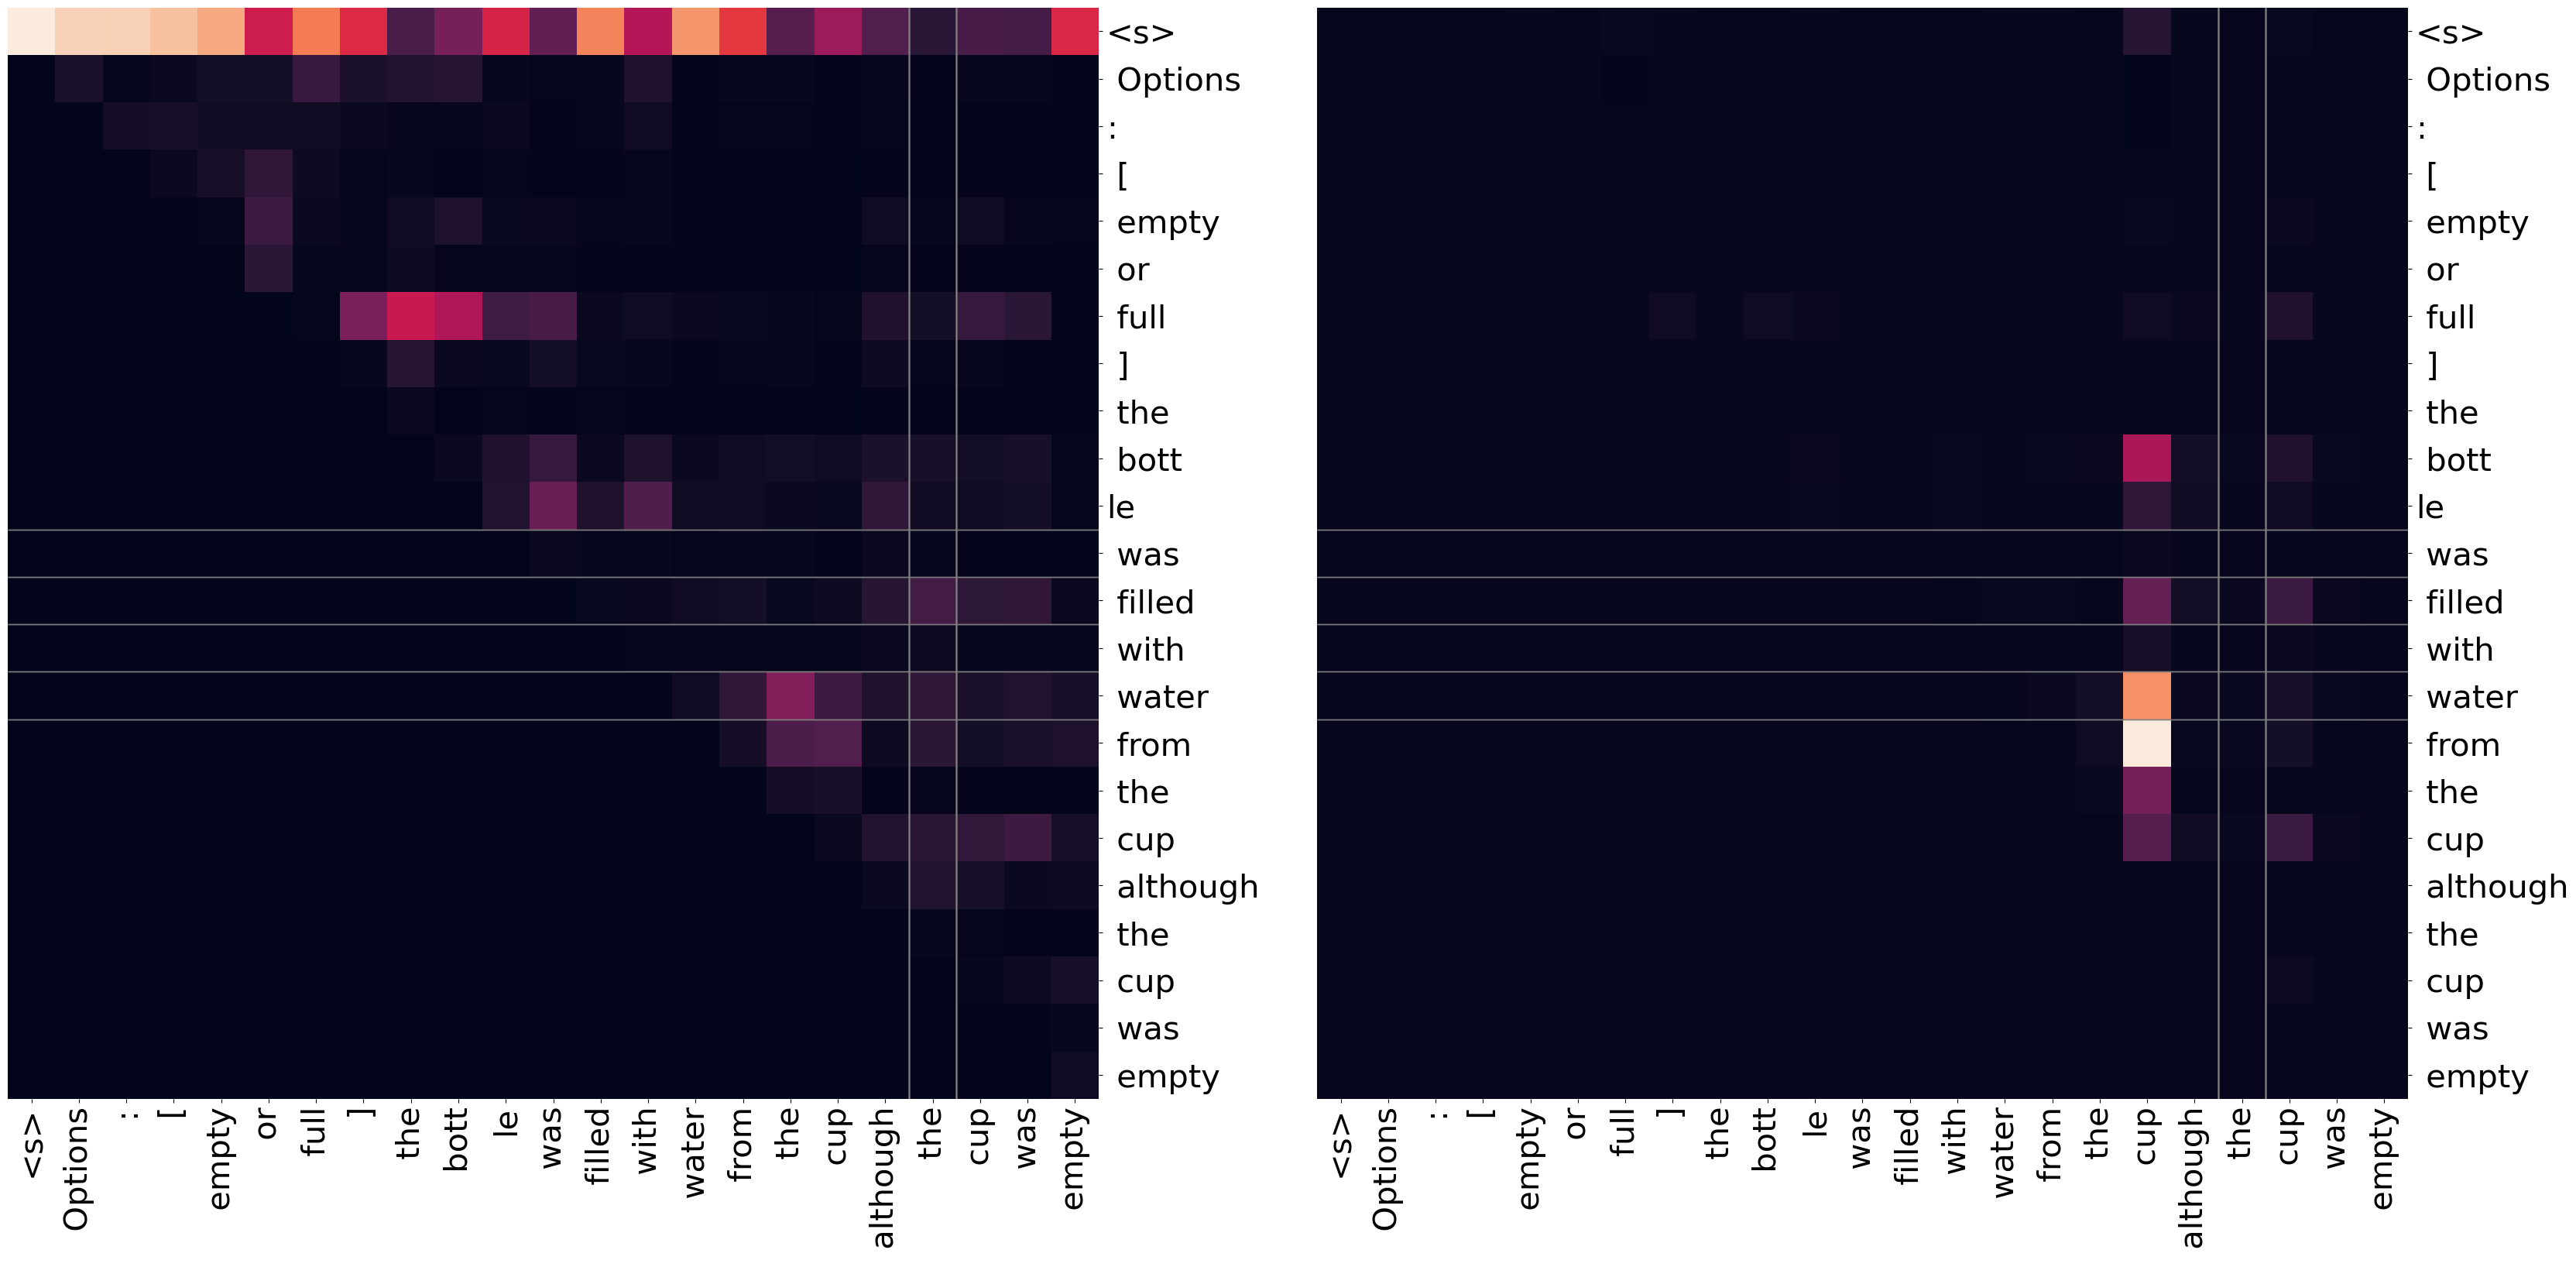

*▁younger 0.691 {'▁younger': 0.691, '▁older': 0.309, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ older or younger ] Jack always takes care of Betty although Jack is younger ▁older:-1.501 *▁younger:-0.697
ap_scores = tensor([0.0806]) tensor(0.0806)


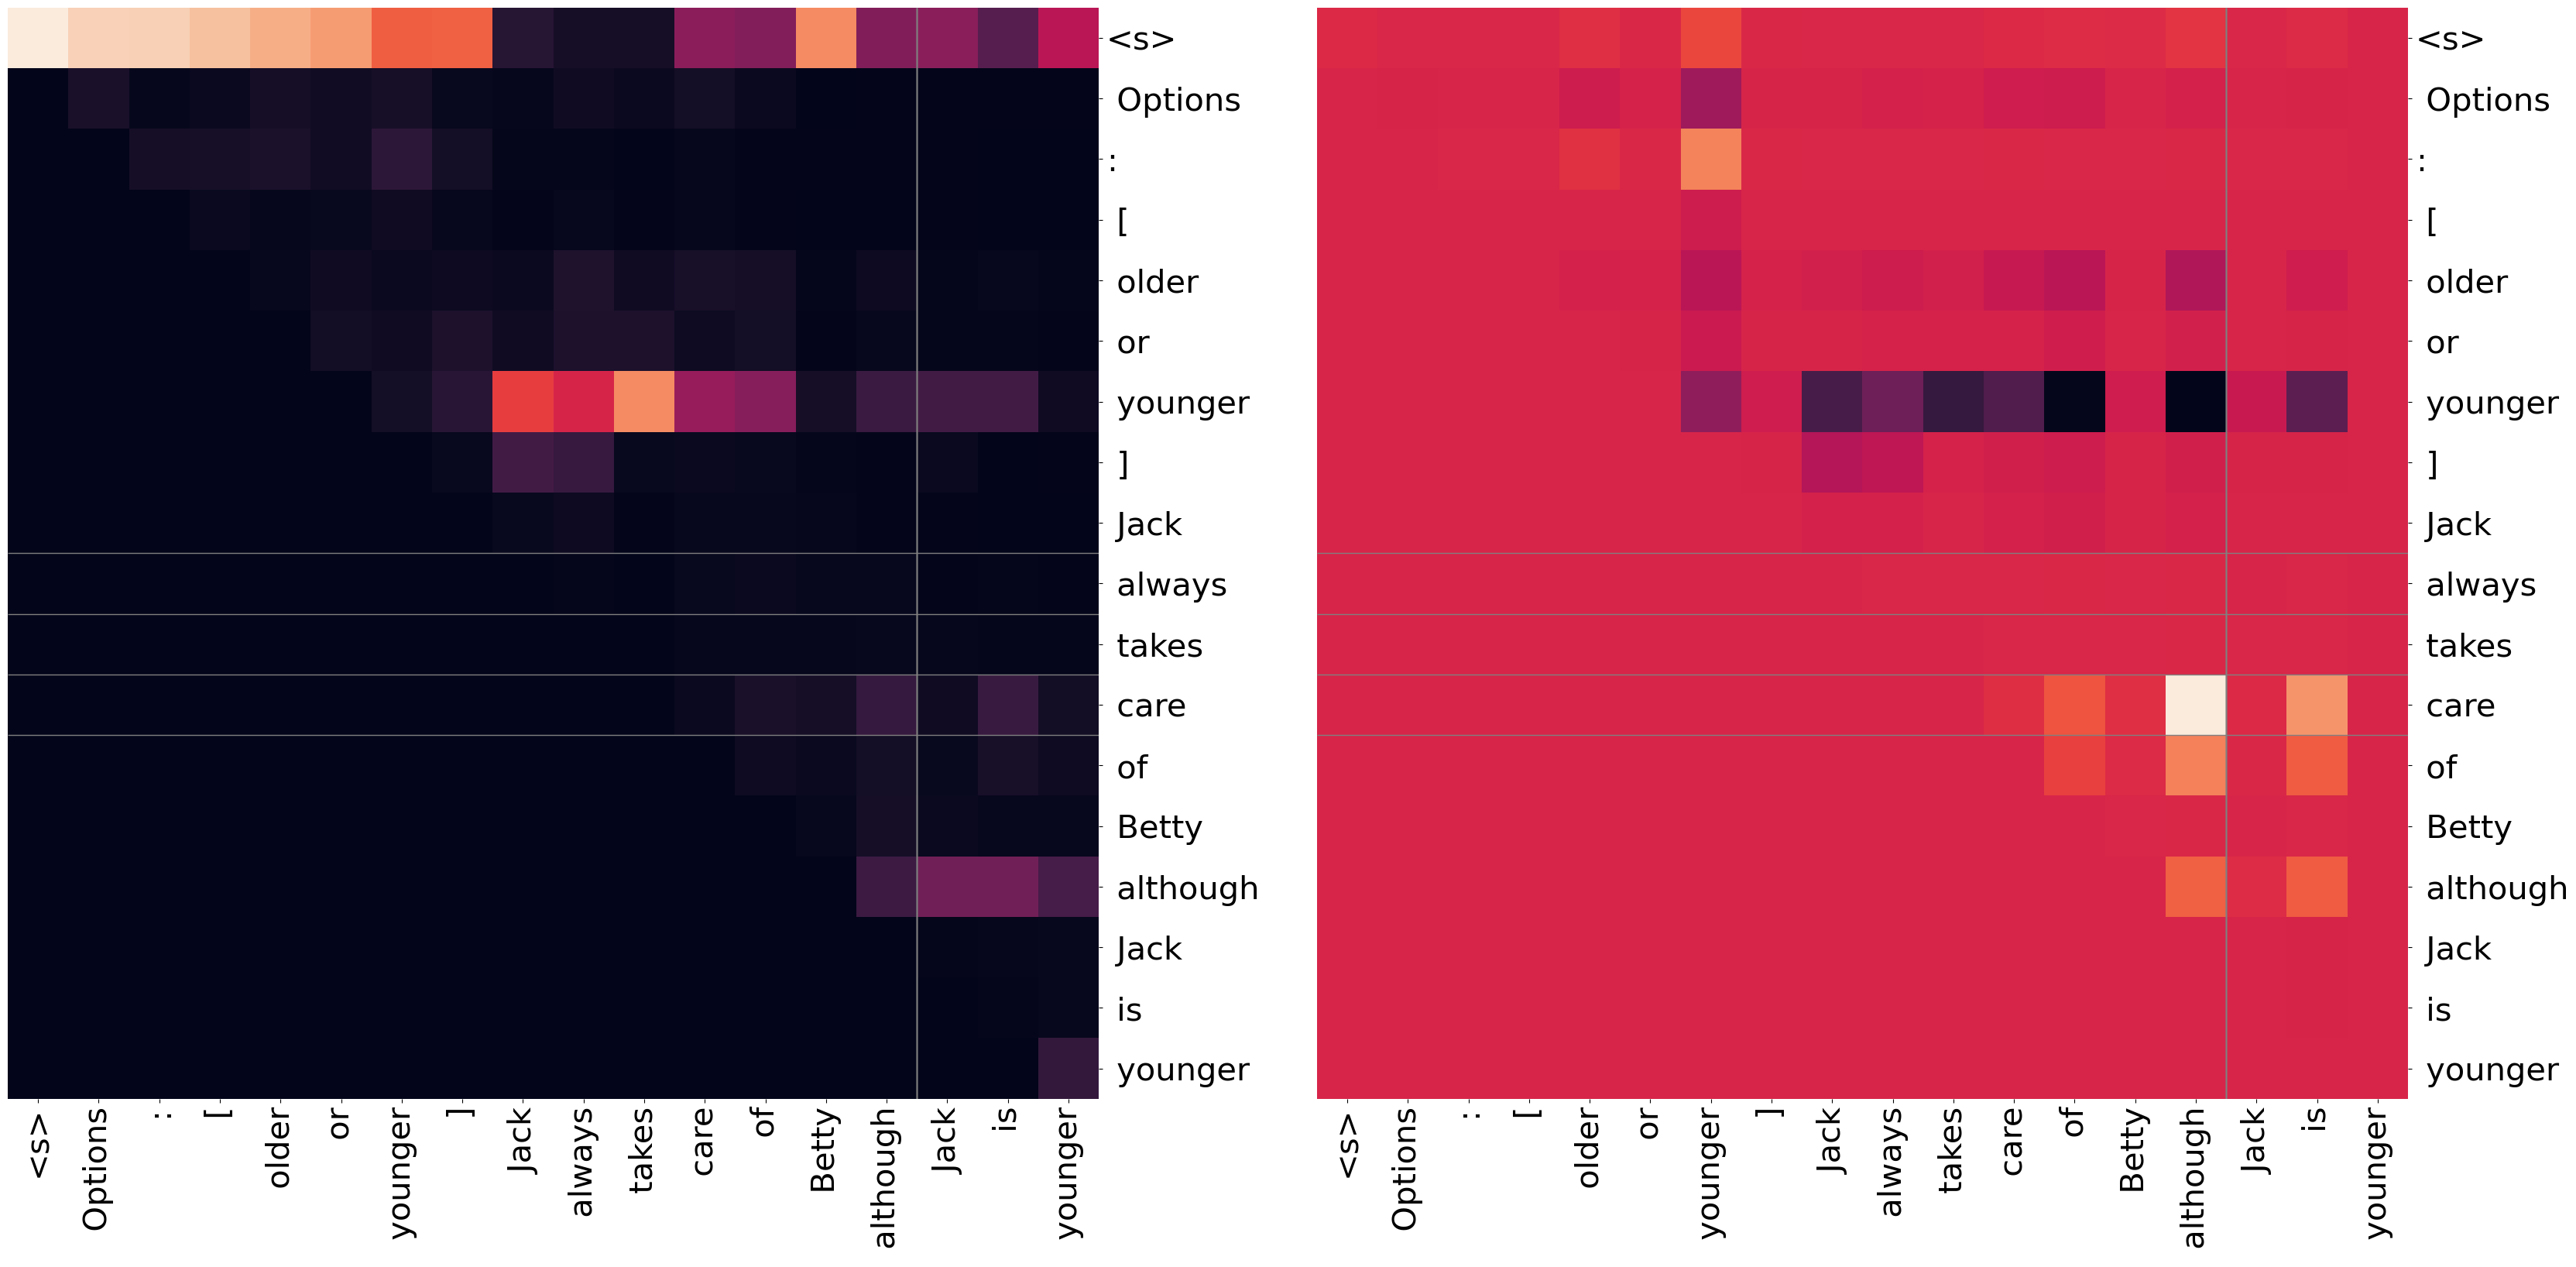

 ▁older 0.315 {'▁younger': 0.685, '▁older': 0.315, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ younger or older ] Jack always takes care of Betty although Betty is older *▁older:-1.187 ▁younger:-0.409
ap_scores = tensor([0.2601]) tensor(0.2601)


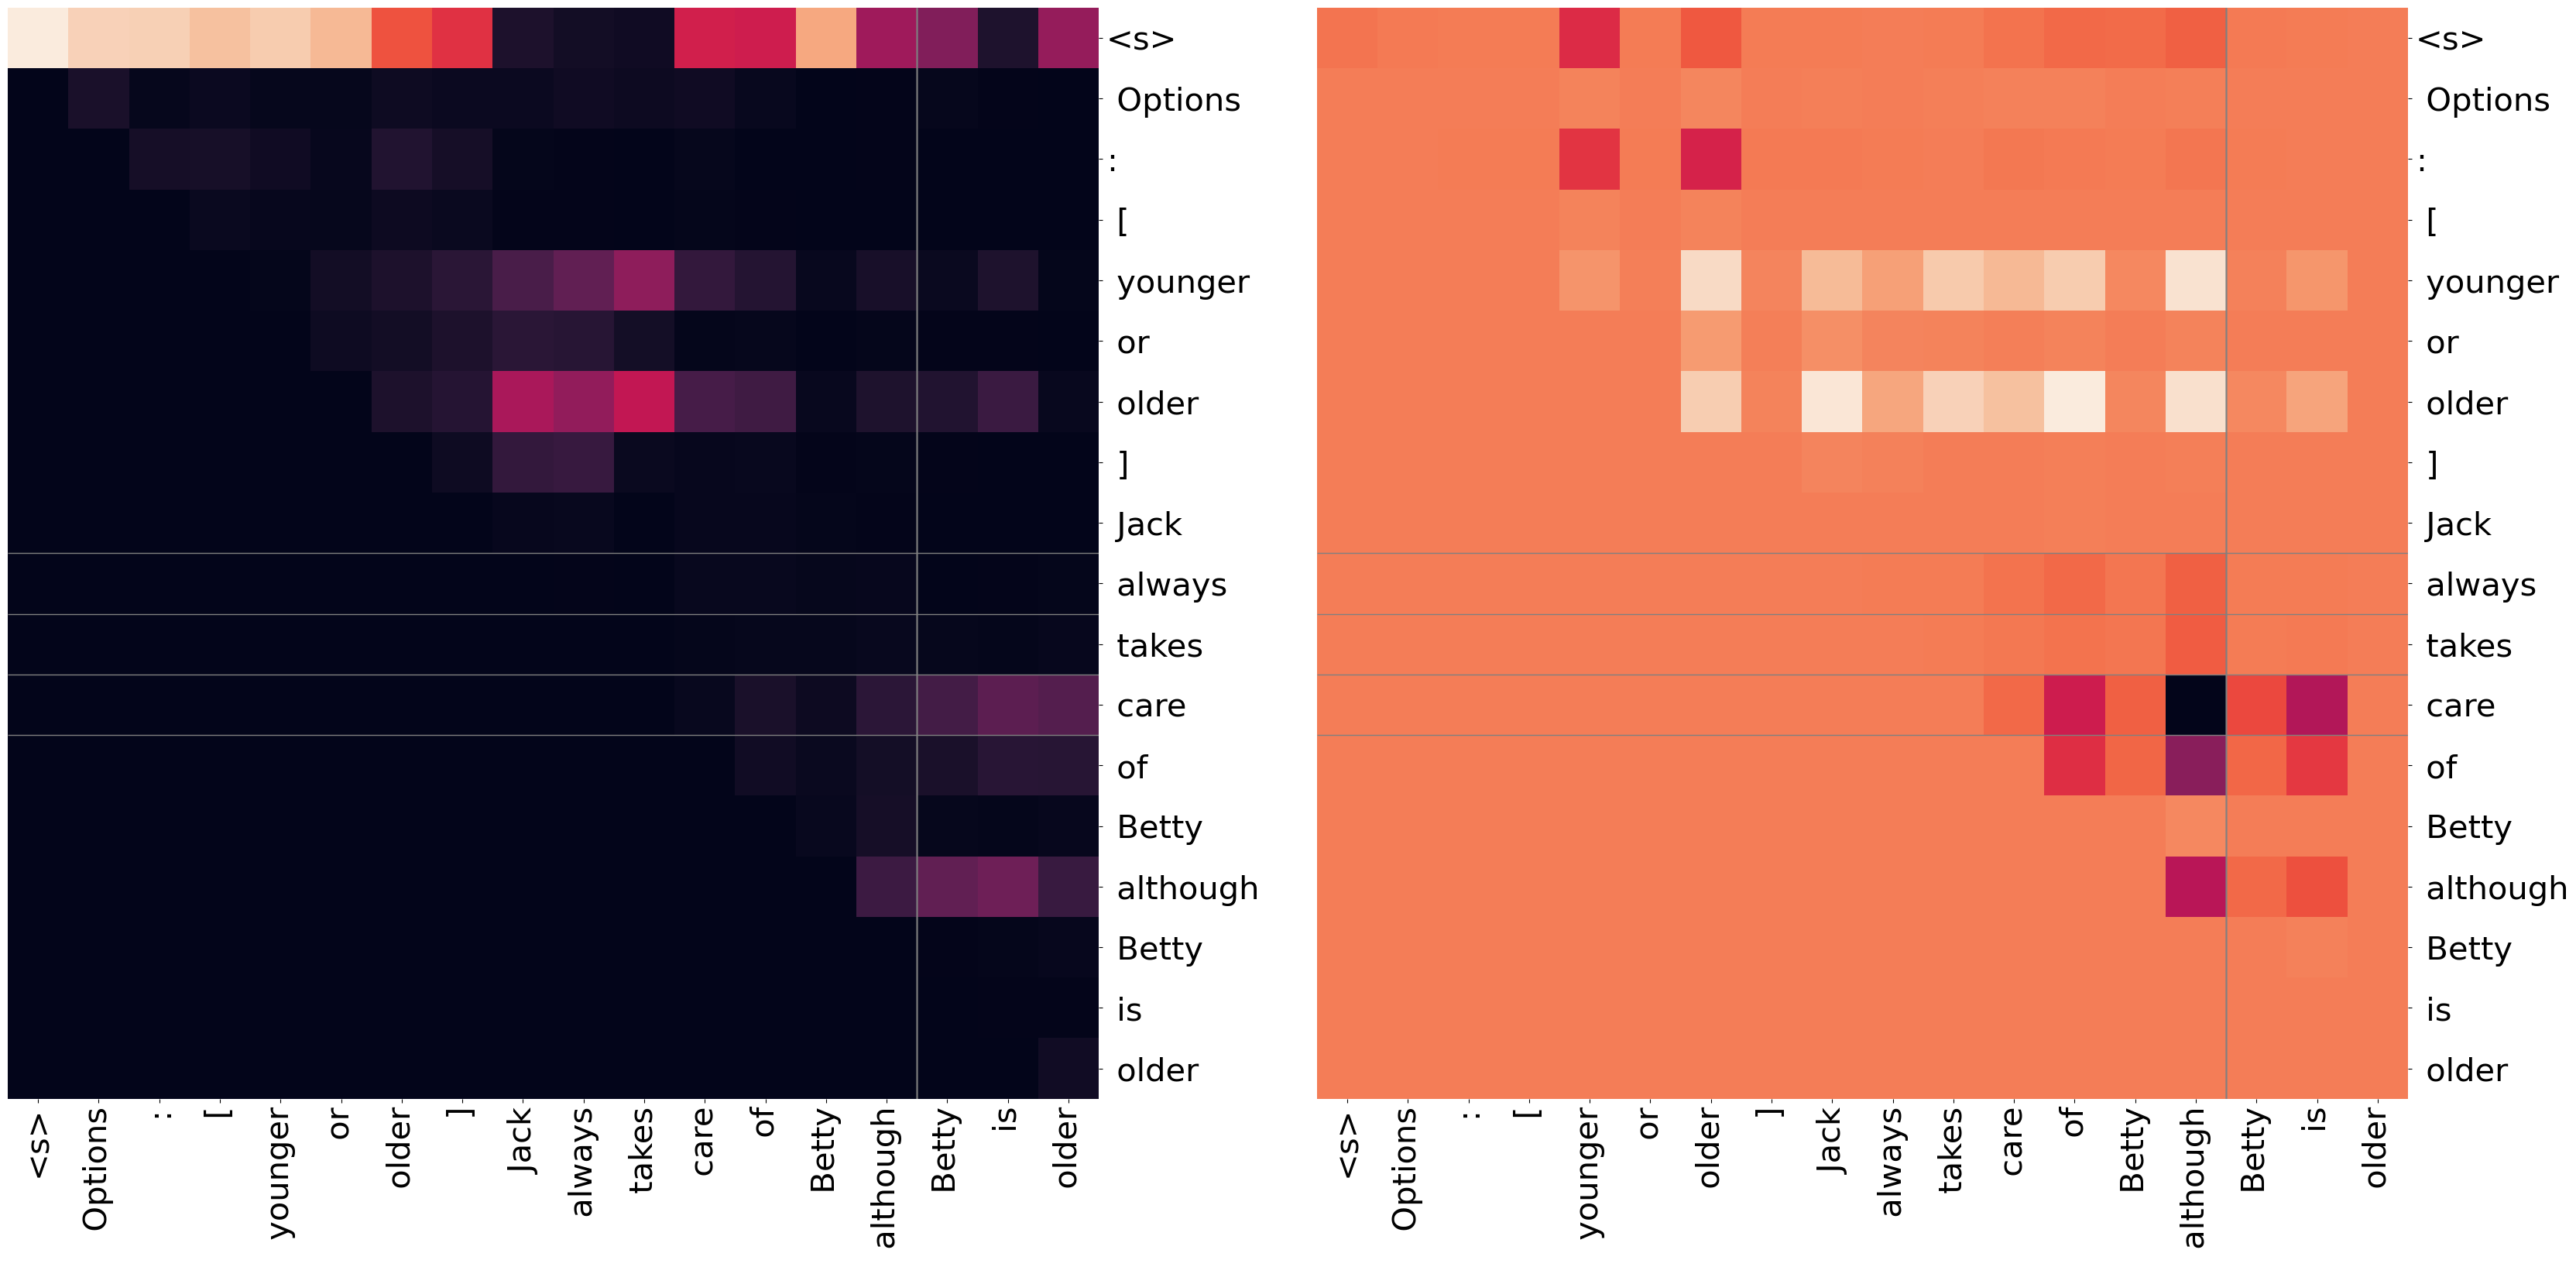

 ▁majority 0.306 {'▁minor': 0.694, '▁majority': 0.306, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ minority or majority ] the sponsors were less in number than the opponents although the sponsors were in the majority ▁minor:0.035 *▁majority:-0.785
ap_scores = tensor([0.4136]) tensor(0.4136)


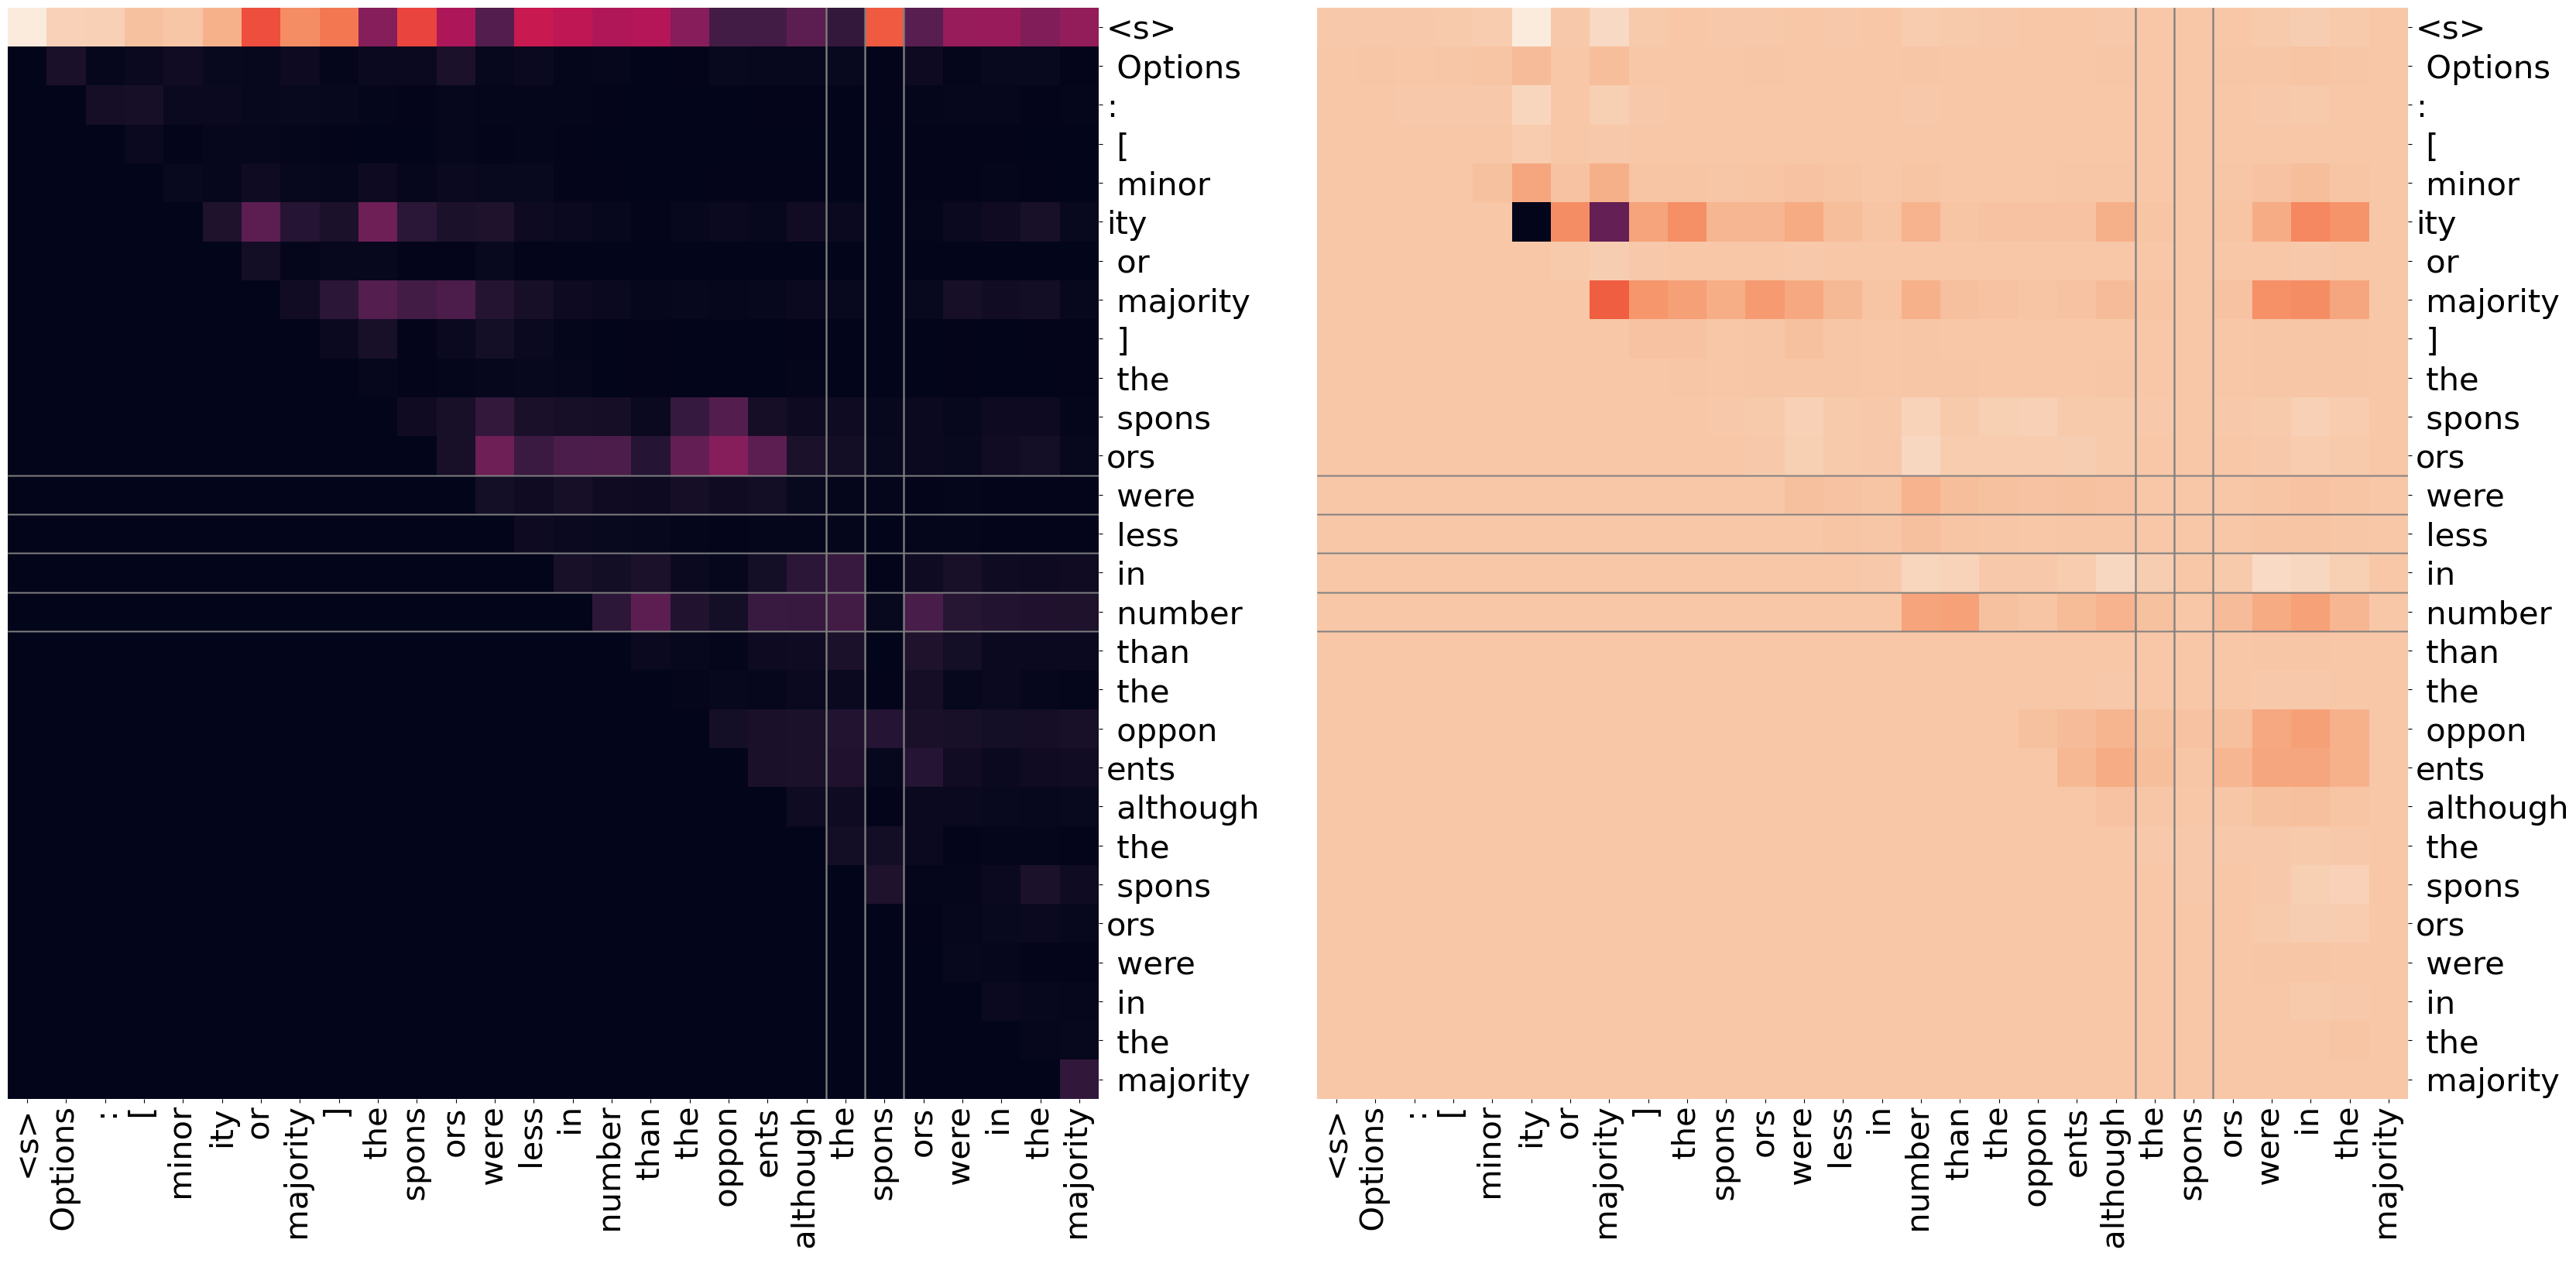

*▁minor 0.872 {'▁minor': 0.872, '▁majority': 0.129, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ majority or minority ] the sponsors were less in number than the opponents although the opponents were in the minority *▁minor:-0.380 ▁majority:-2.293
ap_scores = tensor([0.3917]) tensor(0.3917)


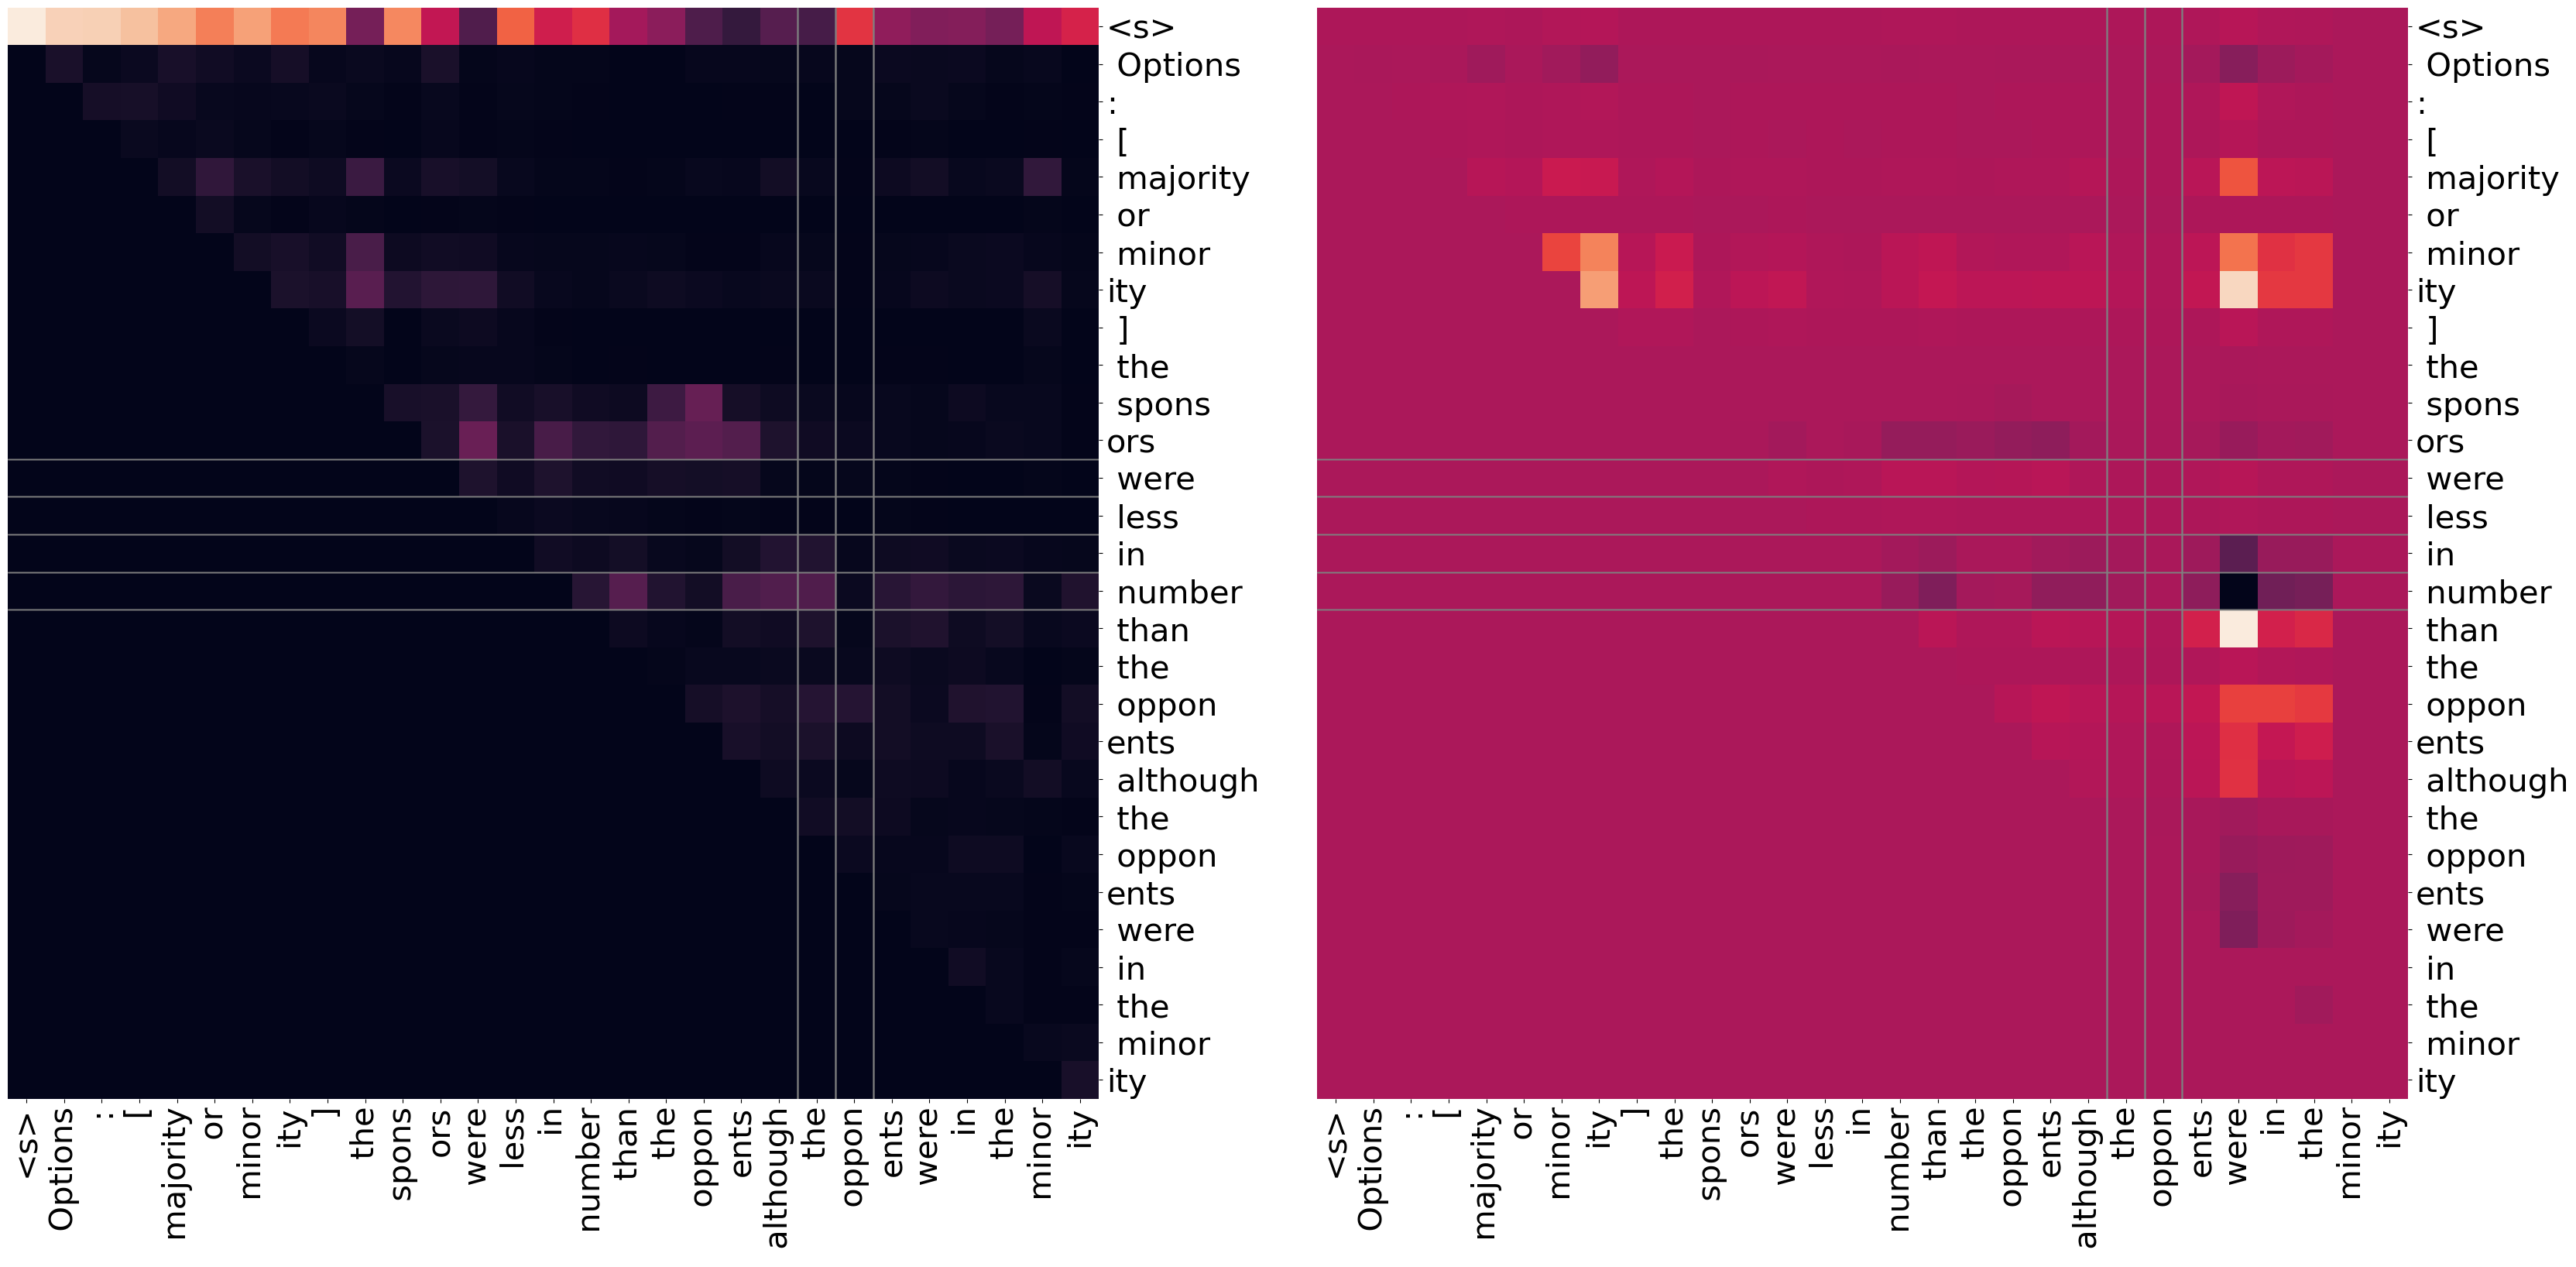

 ▁wide 0.179 {'▁narrow': 0.821, '▁wide': 0.179, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ wide or narrow ] the table will fit through the doorway although the table is wide *▁wide:-0.725 ▁narrow:0.797
ap_scores = tensor([0.3846]) tensor(0.3846)


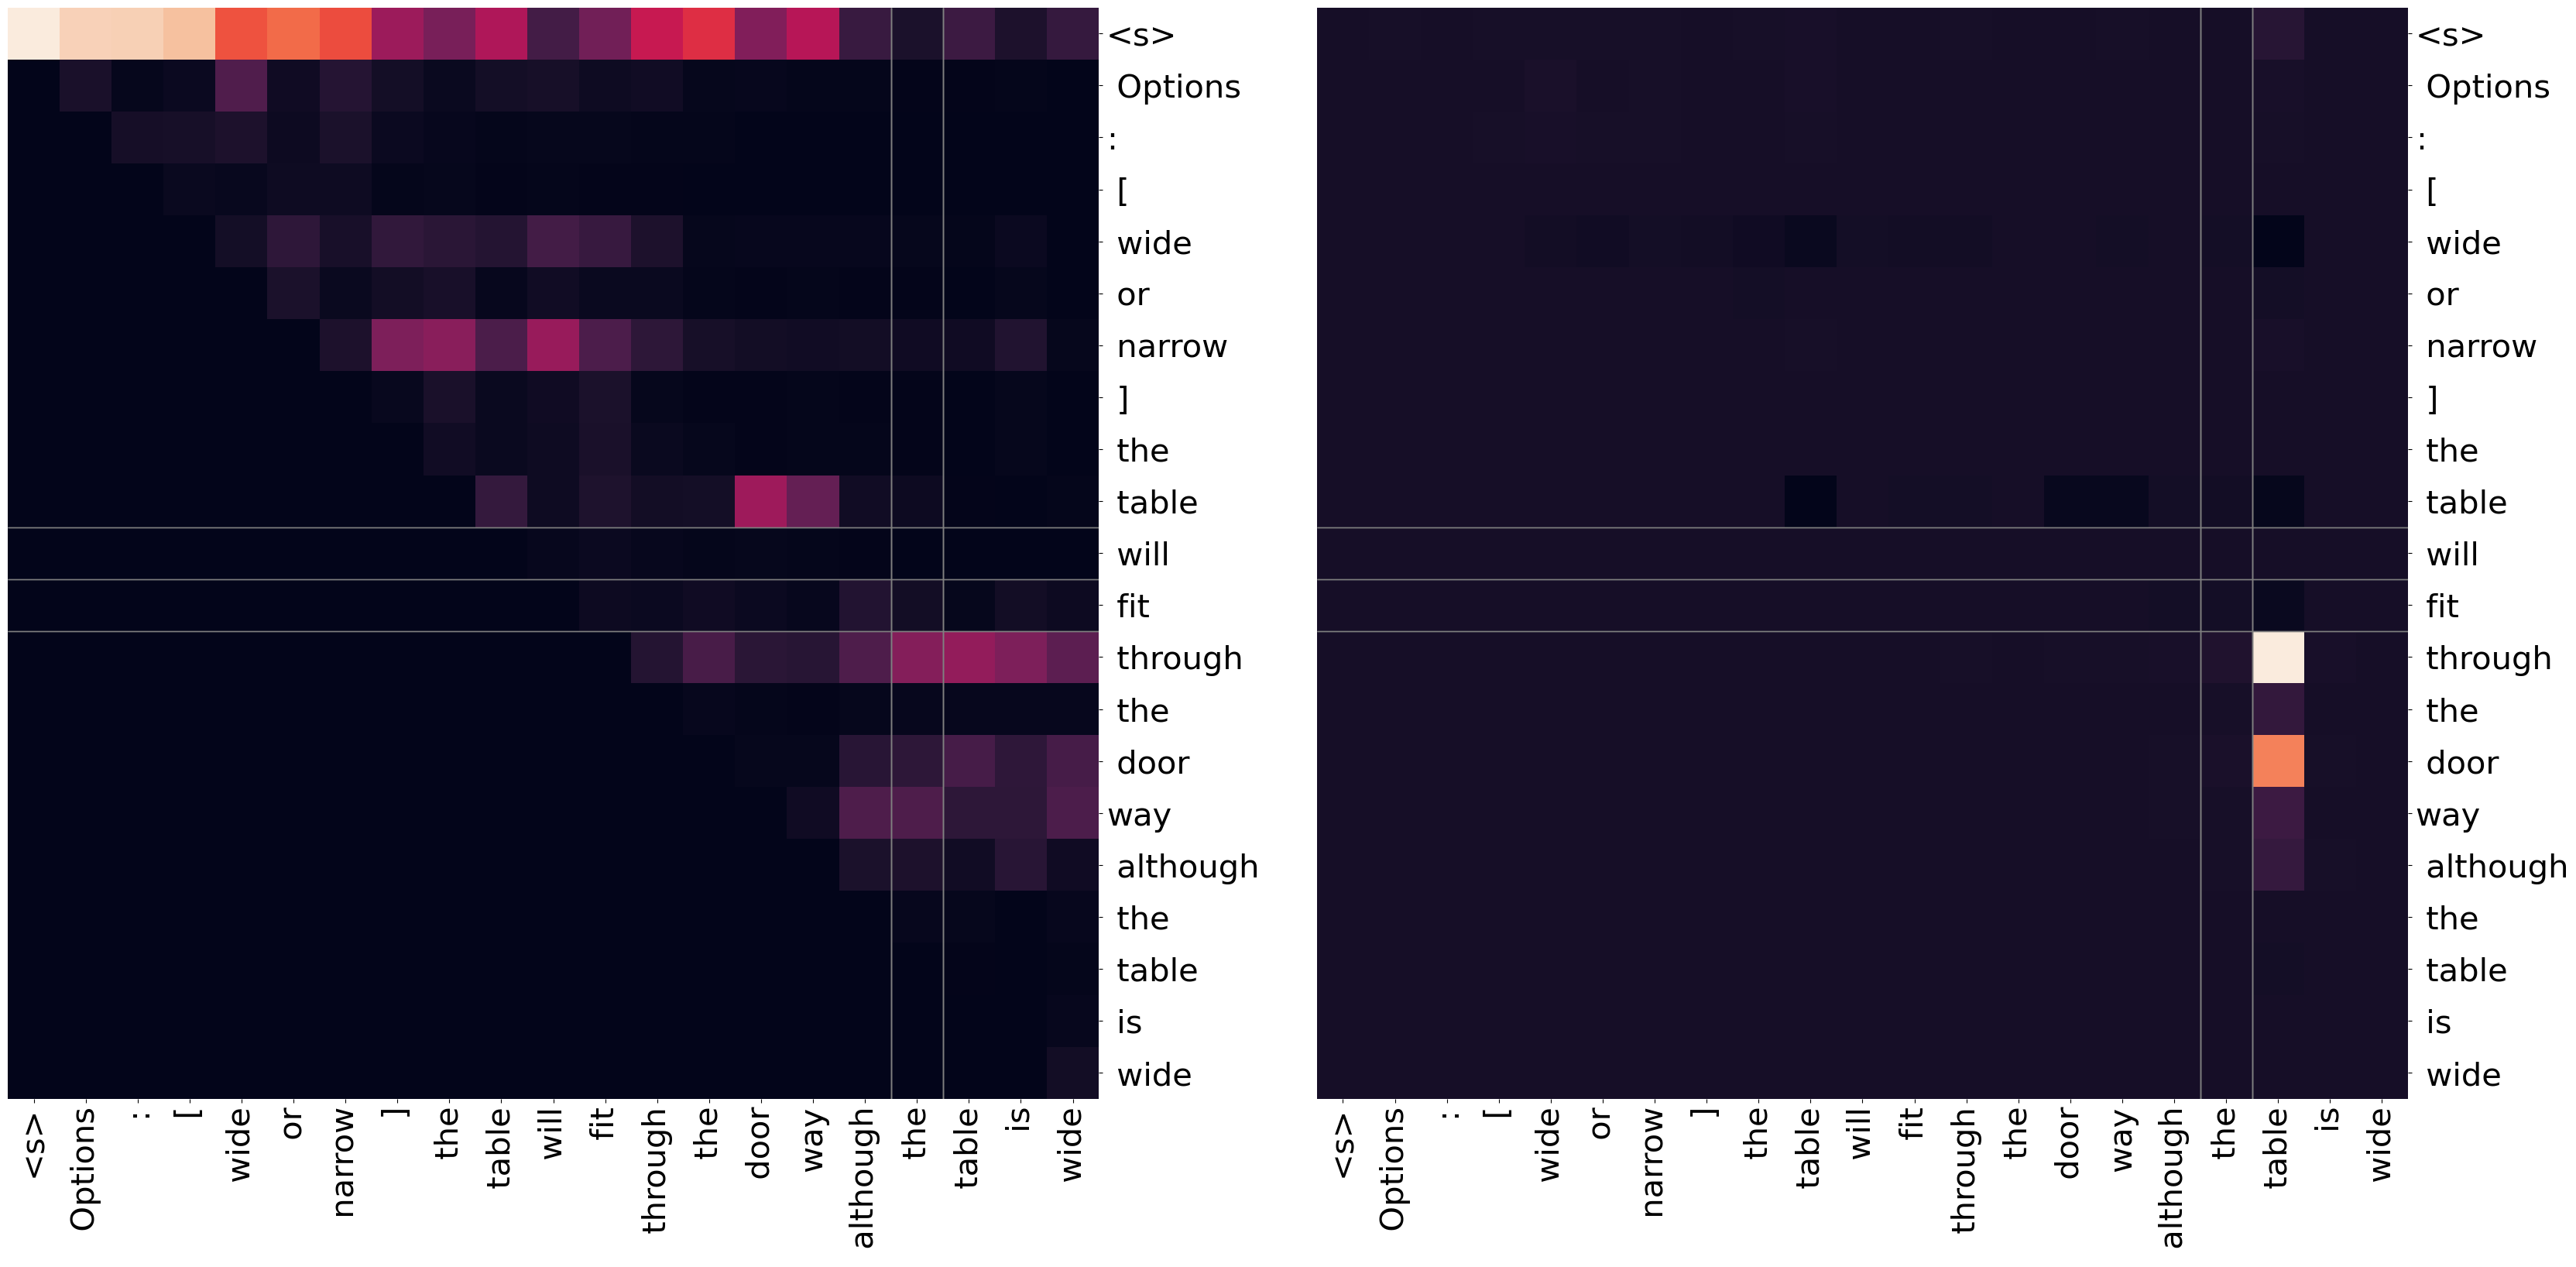

*▁narrow 0.979 {'▁narrow': 0.979, '▁wide': 0.021, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ wide or narrow ] the table will fit through the doorway although the doorway is narrow ▁wide:-1.942 *▁narrow:1.889
ap_scores = tensor([0.3834]) tensor(0.3834)


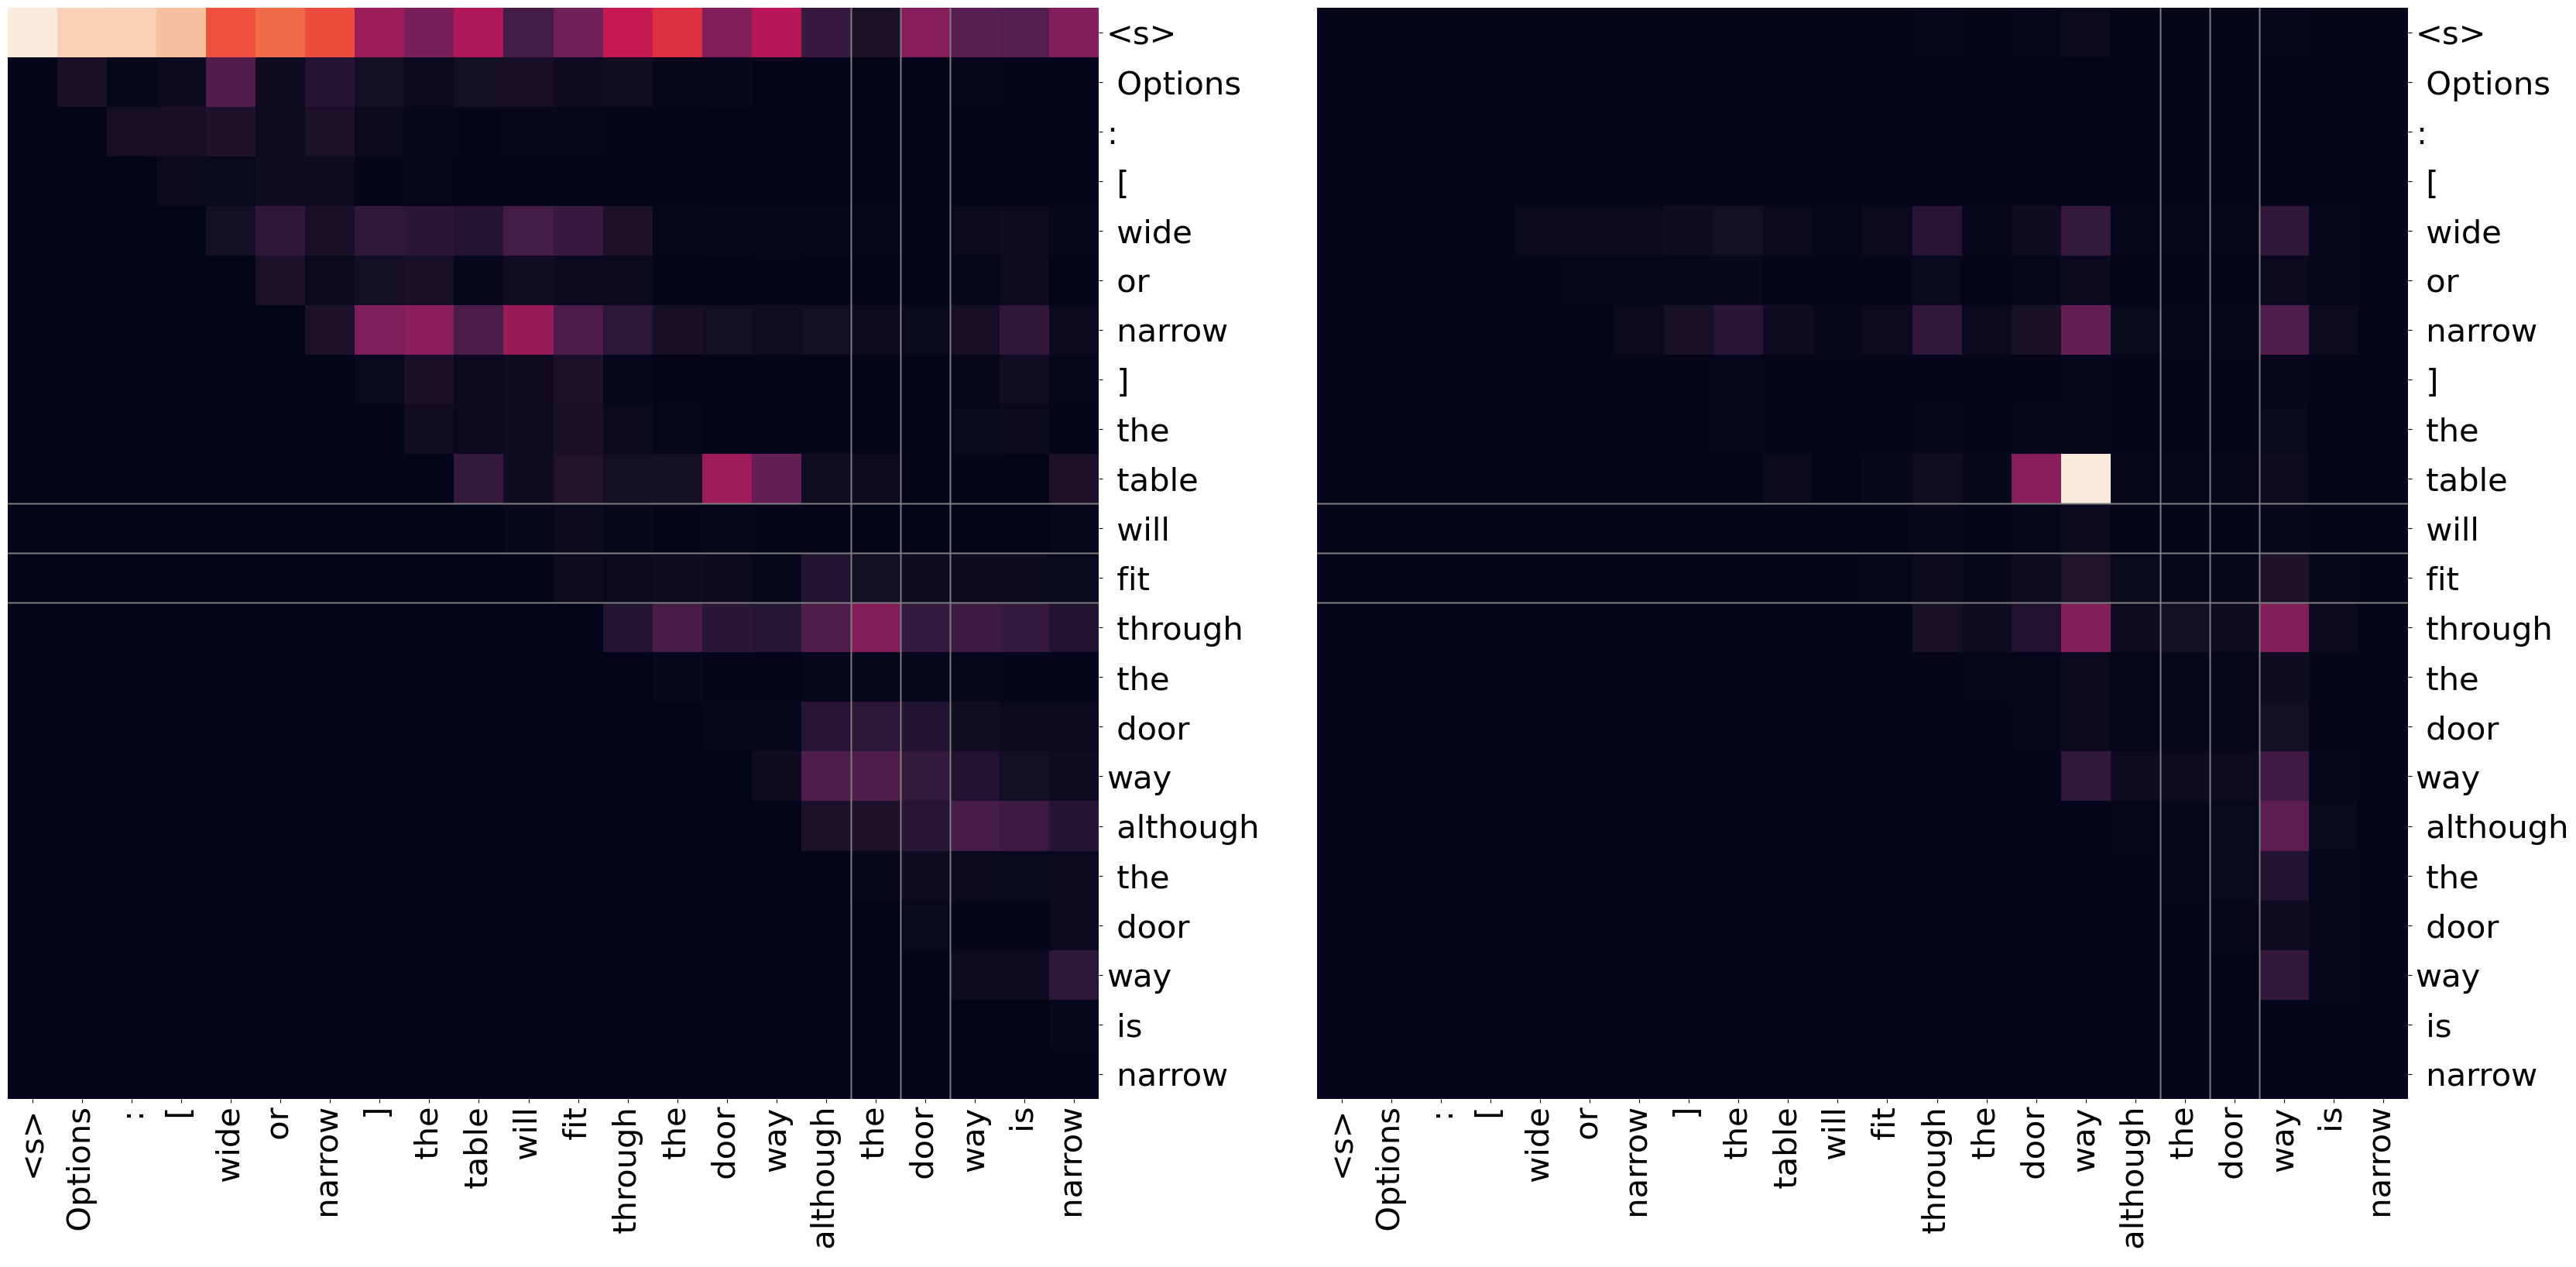

*▁hun 0.679 {'▁hun': 0.679, '▁full': 0.321, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ full or hungry ] Bill passed the half-empty plate to Amy although Bill was hungry *▁hun:0.975 ▁full:0.225
ap_scores = tensor([0.3174]) tensor(0.3174)


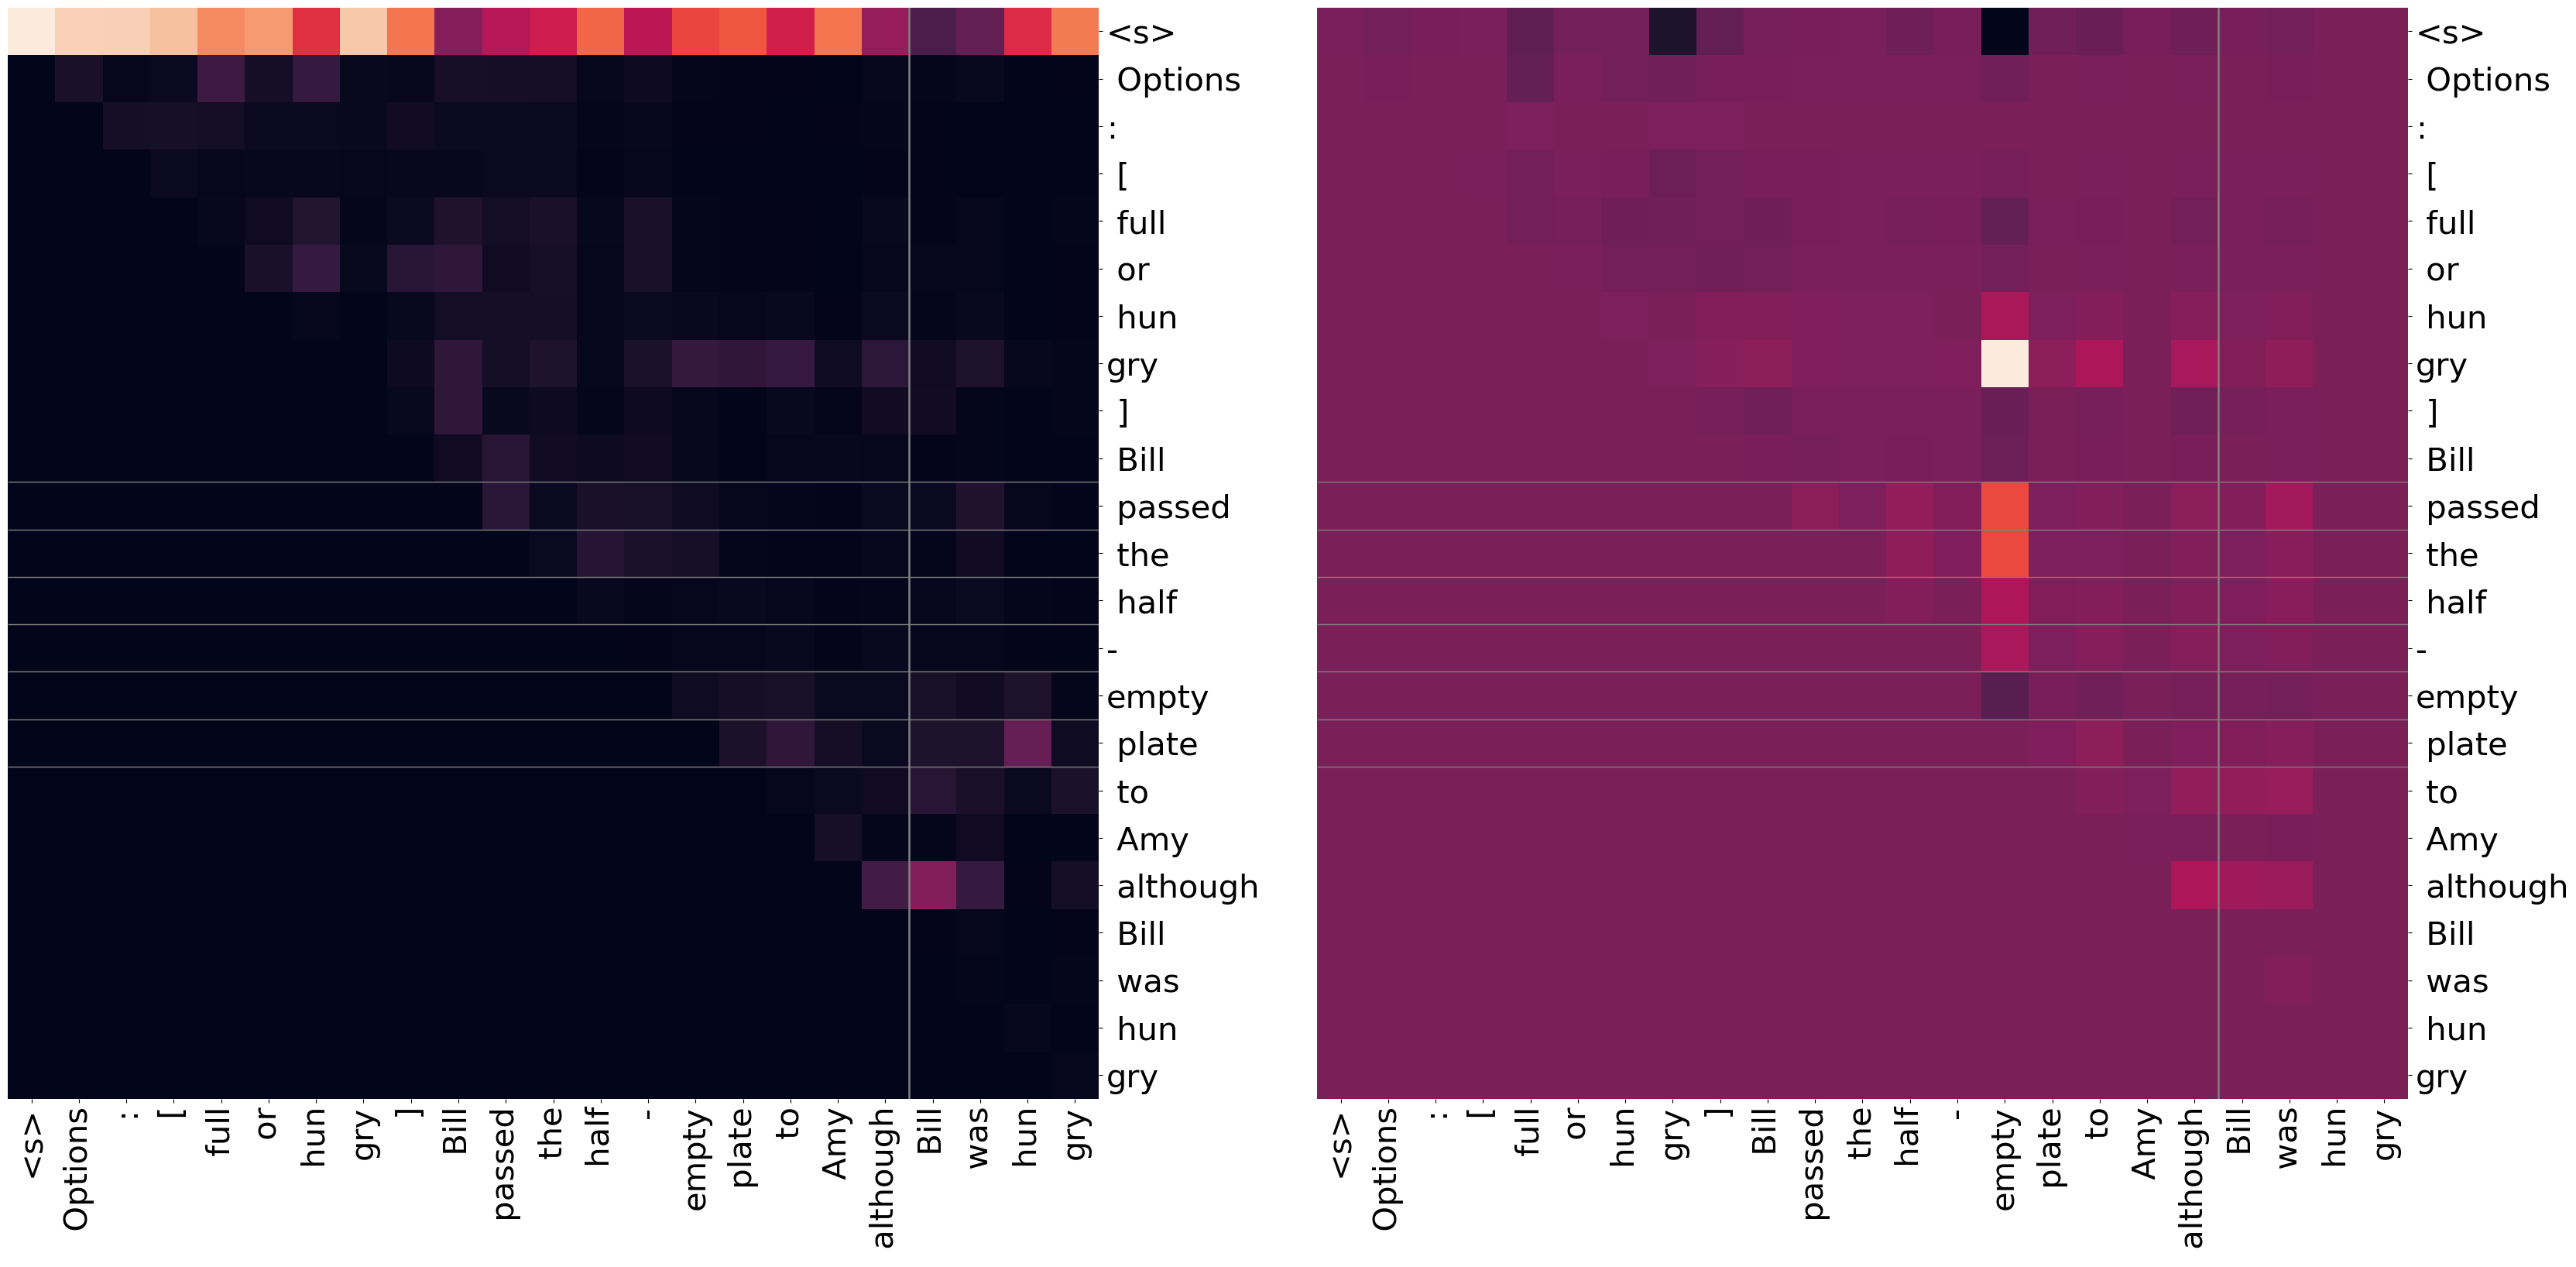

 ▁full 0.492 {'▁hun': 0.507, '▁full': 0.492, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ full or hungry ] Bill passed the half-empty plate to Amy although Amy was full ▁hun:0.425 *▁full:0.395
ap_scores = tensor([0.3078]) tensor(0.3078)


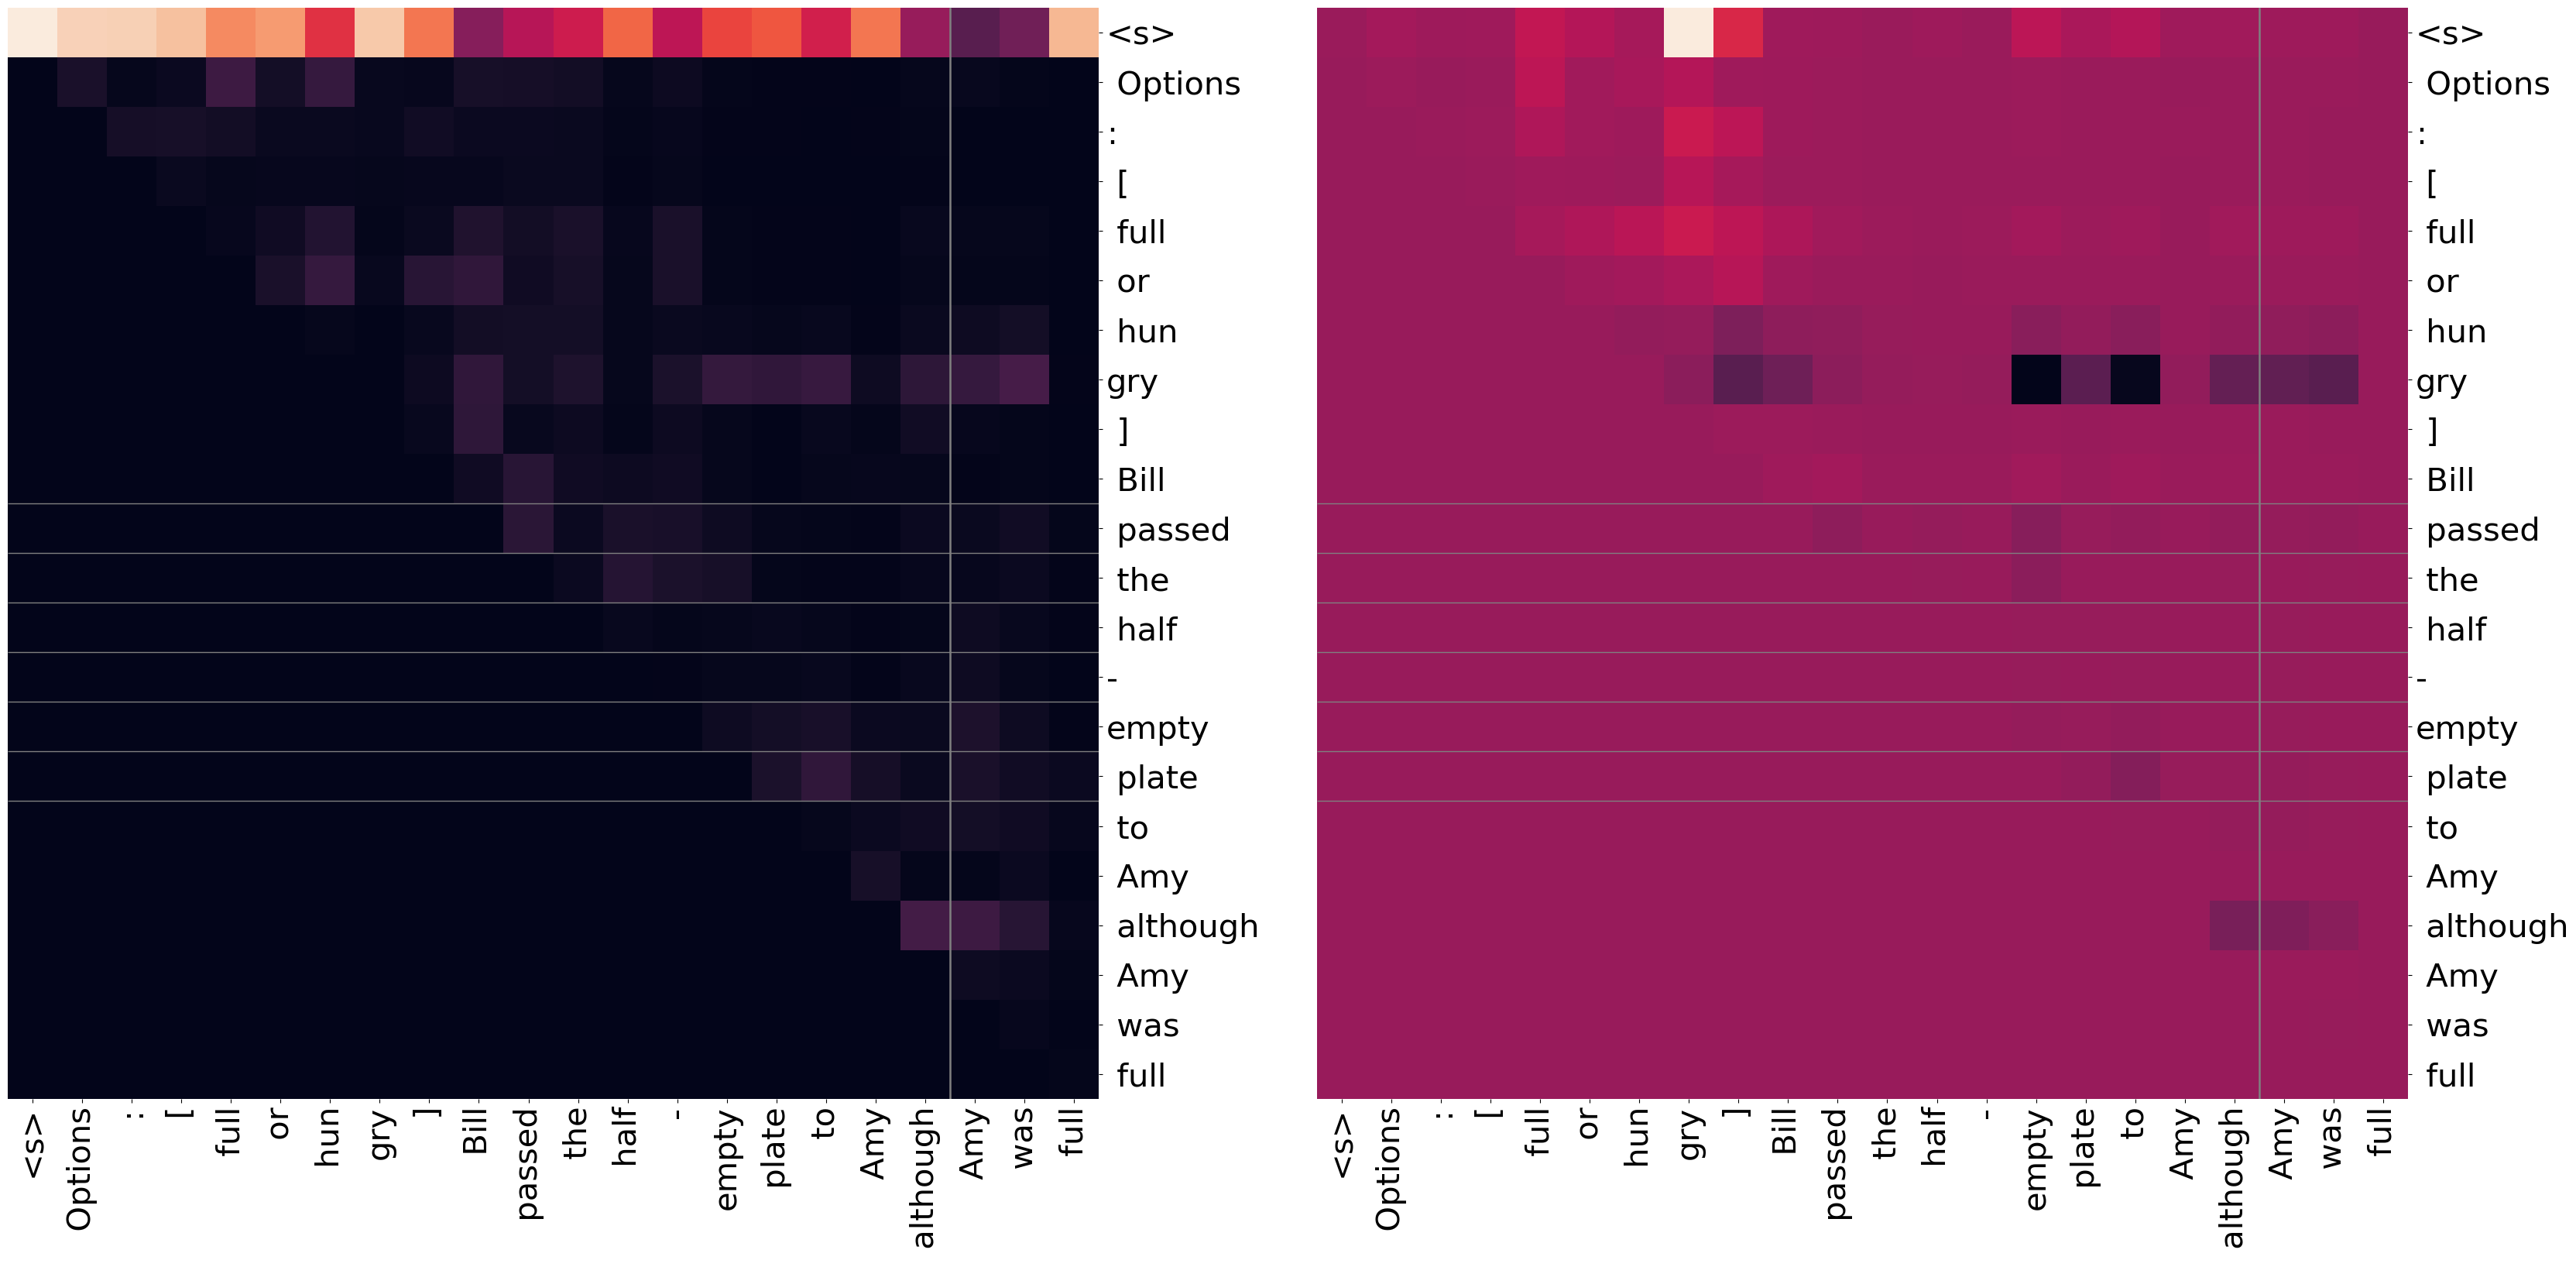

 ▁popular 0.235 {'▁not': 0.765, '▁popular': 0.235, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ notorious or popular ] James ceded the presidency to Amy although James was popular ▁not:0.026 *▁popular:-1.155
ap_scores = tensor([0.2356]) tensor(0.2356)


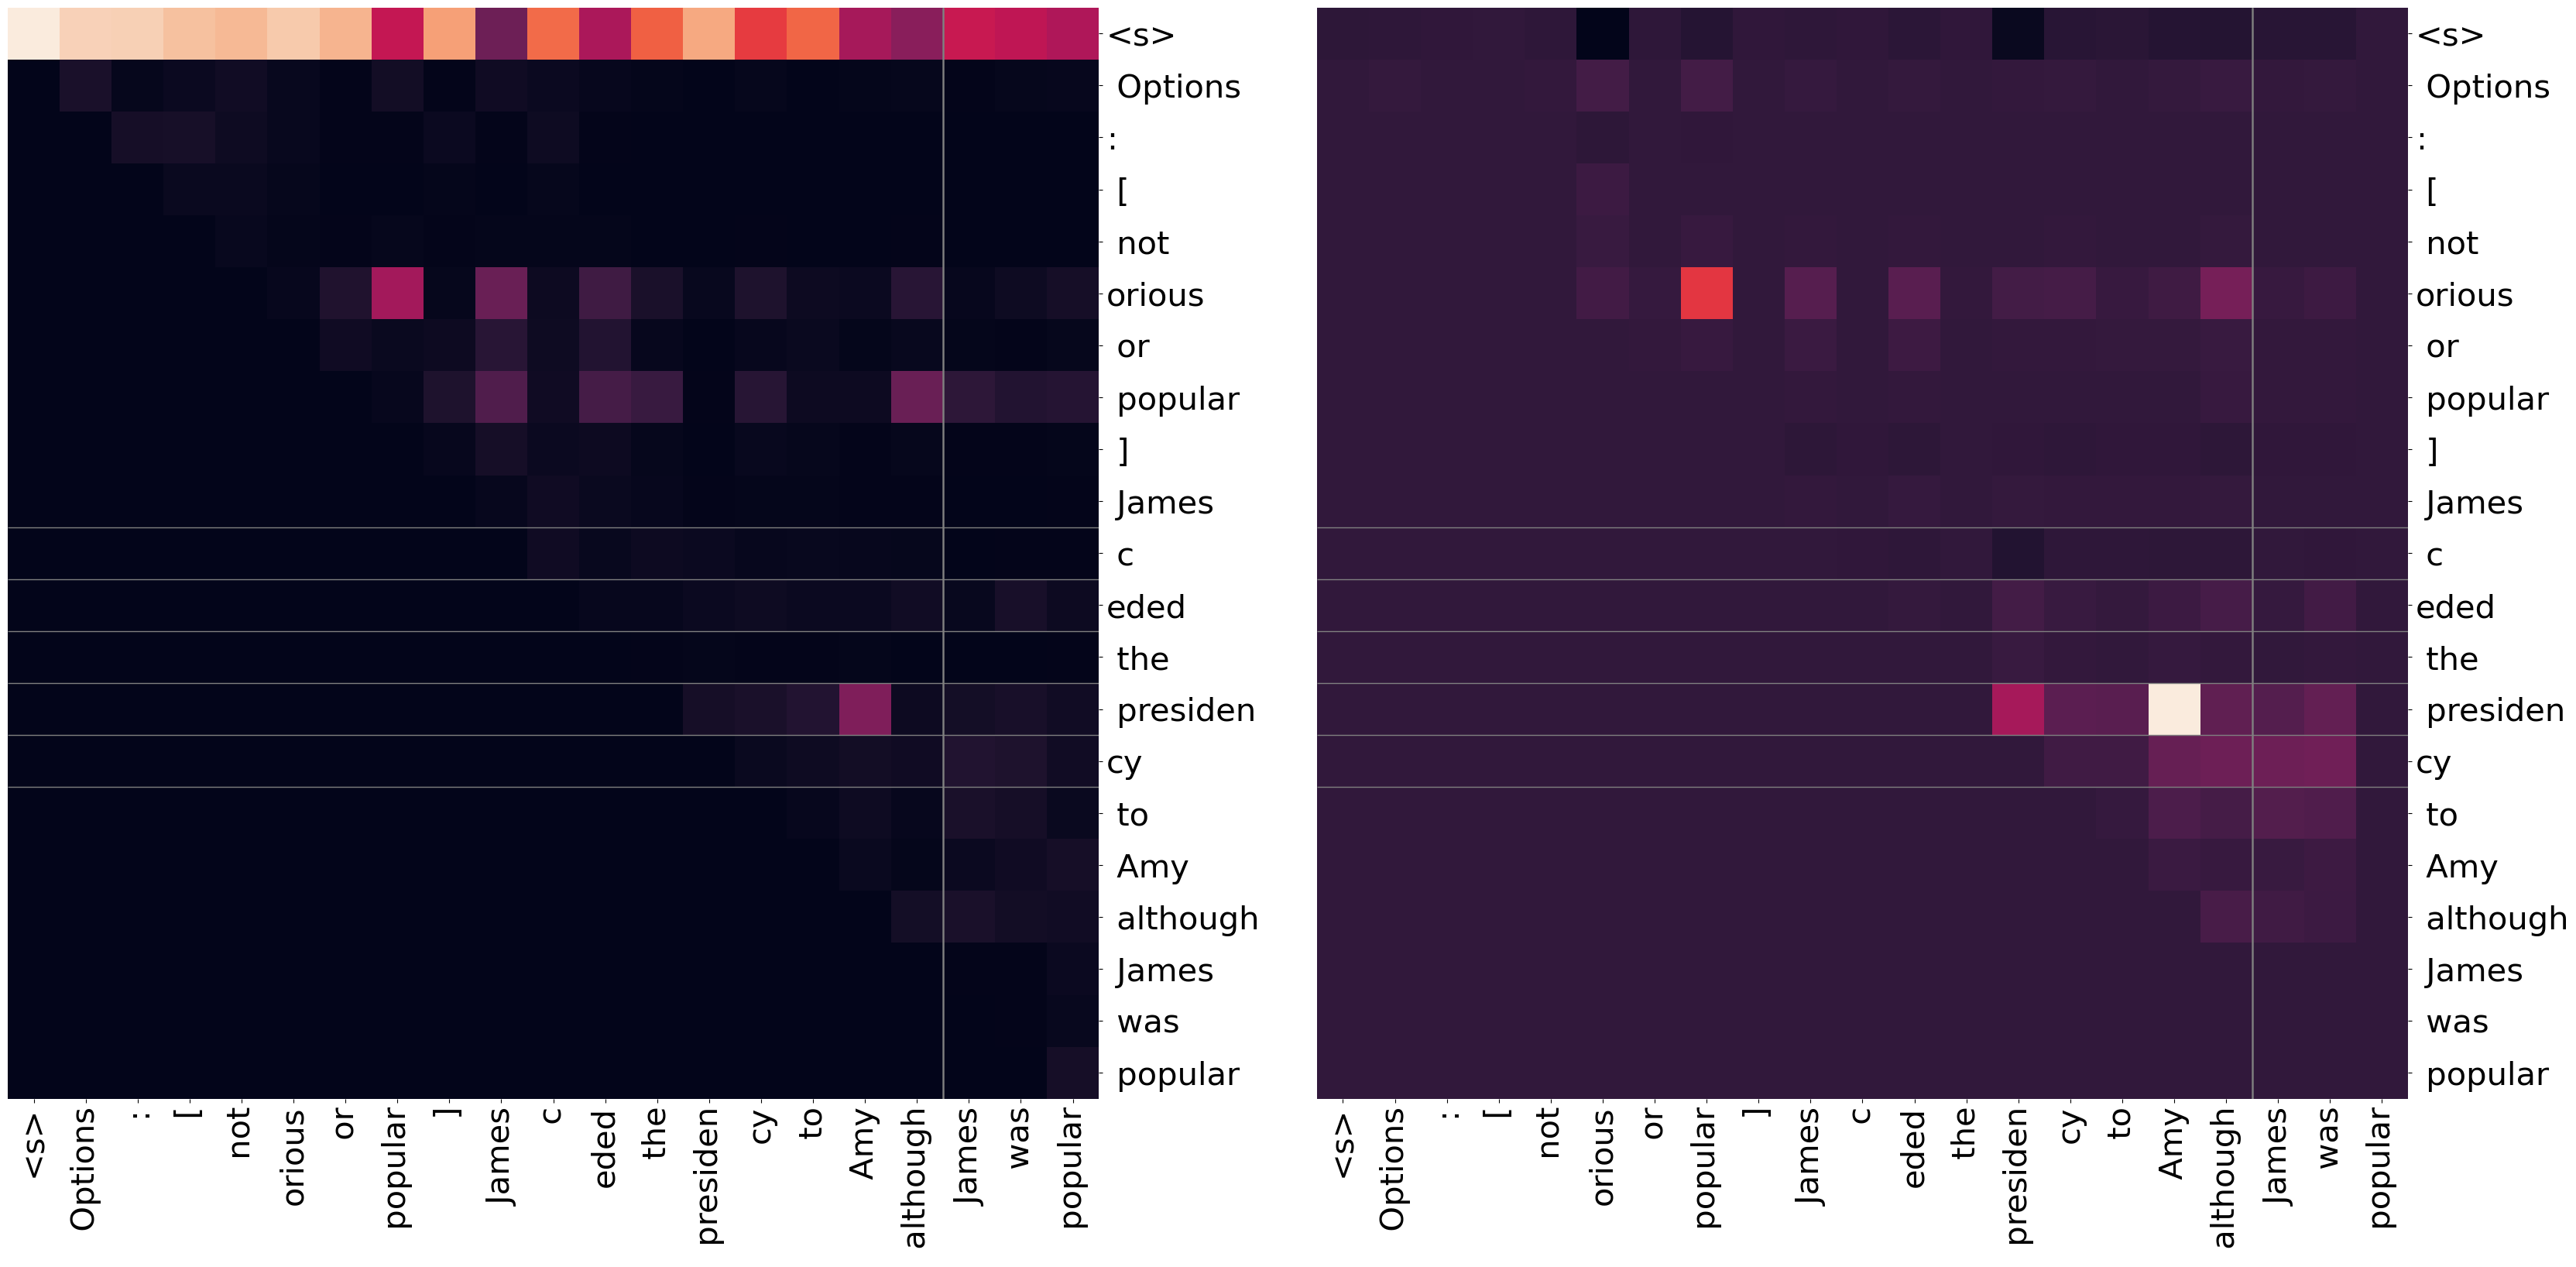

*▁not 0.797 {'▁not': 0.797, '▁popular': 0.203, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ popular or notorious ] James ceded the presidency to Amy although Amy was notorious *▁not:0.524 ▁popular:-0.843
ap_scores = tensor([0.3193]) tensor(0.3193)


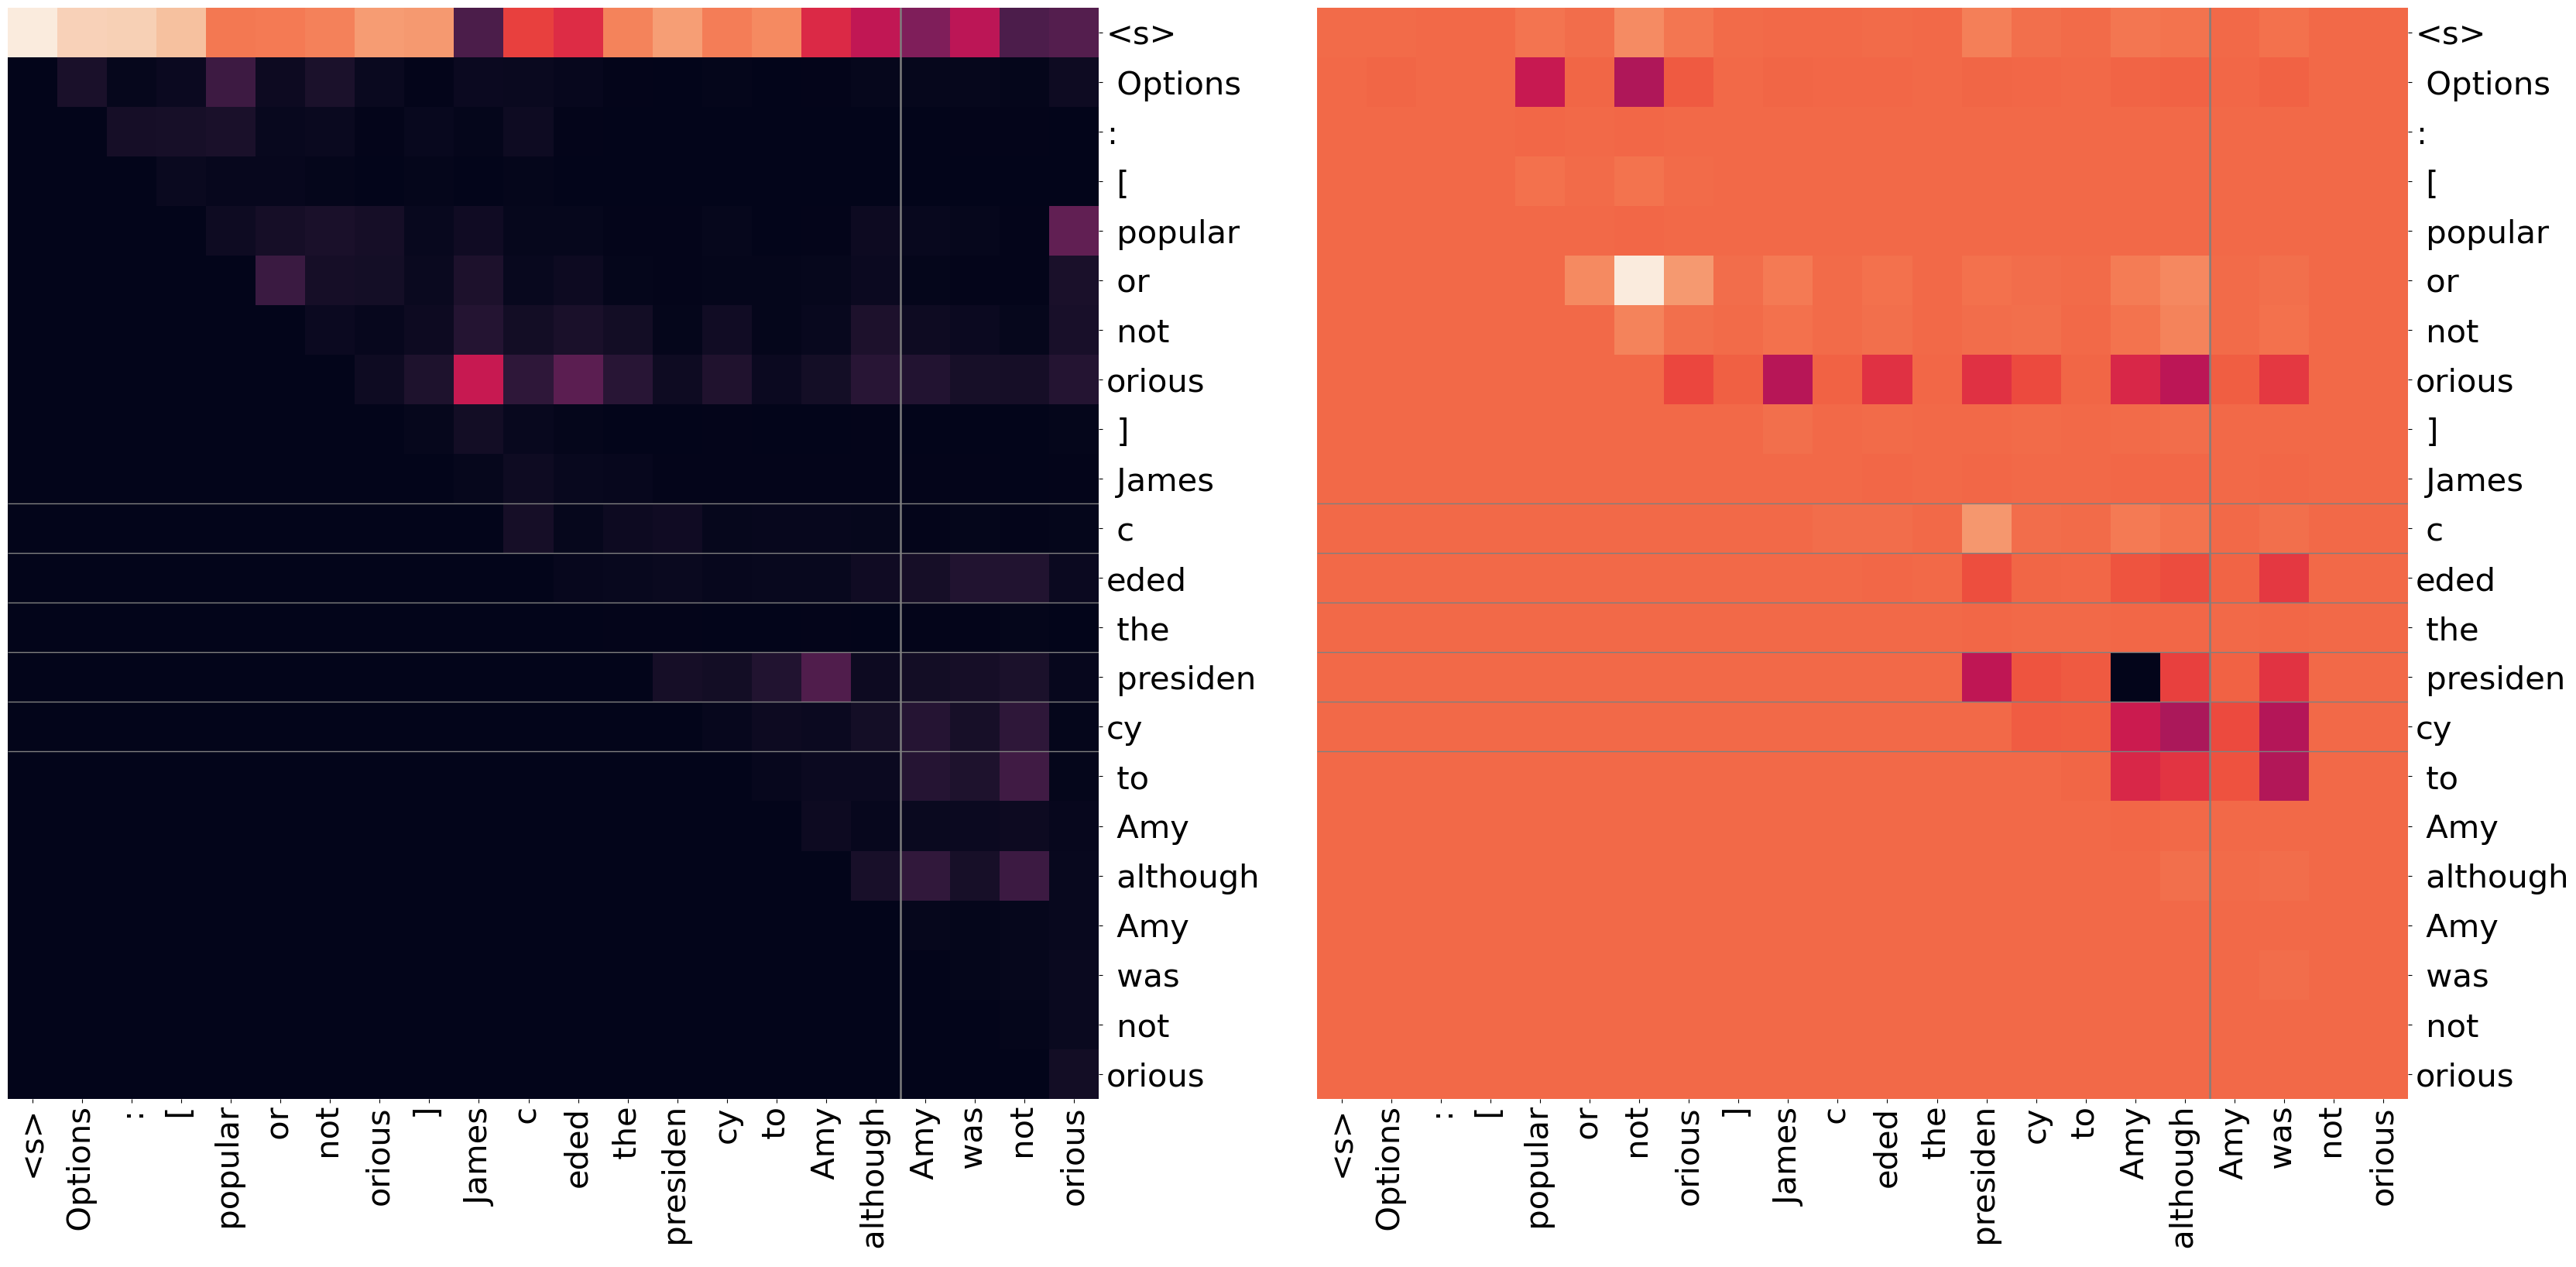

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_312124/3351429889.py", line 4, in <module>
    plot_attn_attrs(r1_al.data_tuples, model, tokenizer, node, topi=[1],attn_patterns=['s1->Ration'], k_shot=0, mix=False)
  File "/home/xd/projects/transformers/notebooks/model_utils_wab_v5.py", line 2919, in plot_attn_attrs
    pred_logits, pred_labels, ap_scores,corrects = tuple(zip(*[plot_attn_attr(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: not enough values to unpack (expected 4, got 3)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^

In [365]:
# -5 6,10,14,1,9,11,13
#5 6 9
#1 2 3 9 12
plot_attn_attrs(r1_al.data_tuples, model, tokenizer, node, topi=[1],attn_patterns=['s1->Ration'], k_shot=0, mix=False)

## winograd although before

In [369]:
winograd_al_before = Winograd('wino_al_s2before_sentences.json', 'wino_al_s2before_word_idx.json')

In [370]:
r1_al_before = None
result_al_before = {}

Options: [ small or large ] the trophy doesn't fit into the suitcase although the trophy is small
2.3914466535982988 0.6666666666666666 0.6089166666666667


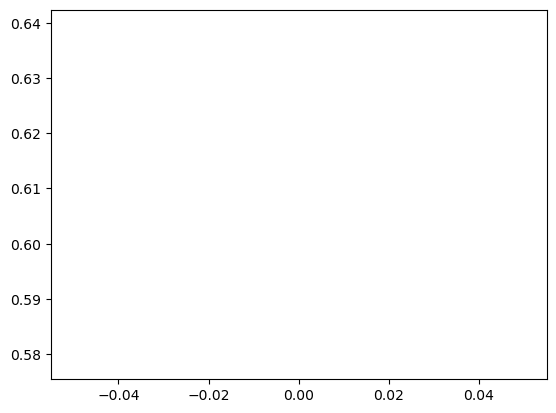

gx []
rx []


/home/xd/projects/transformers/notebooks/common_utils.py:266: RuntimeWarning: Mean of empty slice.
  m0 = y0.mean(0); m1 = y1.mean(0)
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


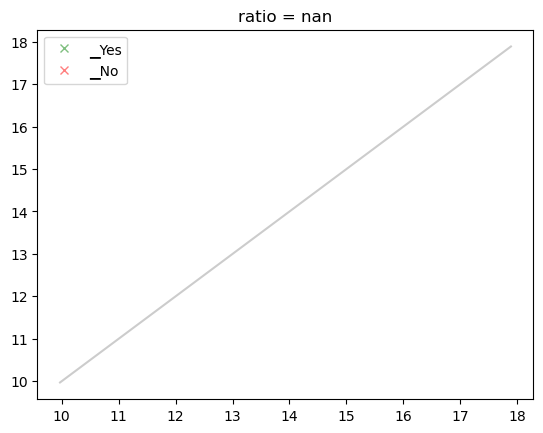

In [372]:
r1_al_before = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=12,dataset = winograd_al_before,
                                        trim=False, result=r1_al_before, verbose=False)#8tiao

In [705]:
def filter_fn_al_before(p, c):  #合并版
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1  and c.topi in [9] or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and c.topi in [5]  or #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and  c.topi in [14]or#((p.attn_pattern =='bos->bos' and c.topi in [3,4,2,5,10,12,14]) or (p.attn_pattern =='bos->s1' and c.topi in [0,5,1,13]))
       p.step == 2 and c.topi in [2] or
    p.step == 3 and c.topi in [2,3,7,8,9] or
            p.step == 4 and c.top_score>0.5 or
            p.step == 5 and c.top_score>0.7#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [710]:
if True or r1_al_before.root is None: r1_al_before.root = add_node(None, layer=L, label_type='labels')
r1_al_before.root = attribute_tree_on(r1_al_before.data_tuples, model, r1_al_before.root, 2, filter_fn_al_before, topk=15, k_shot=0, threshold_score=0.1, mix=True, device=None, verbose=True)

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:00.417543
In attribute_tree: attribute_step stage2  ... done 0:00:00.057709
In attribute_tree: topk bos->ans0 heads =
(array([26, 24, 29, 19, 53, 16, 21, 25, 26, 28]),
 array([51, 20,  0, 33, 17, 17, 38, 49, 29, 47]),
 array([0.35950693, 0.2984117 , 0.23233032, 0.2318093 , 0.23134358,
       0.22286345, 0.22044308, 0.19920063, 0.19403839, 0.18349075],
      dtype=float32))
In _add_node: add @0 43-m 100
In _add_node: add @2 45-m 52
In _add_node: add @3 31-m 50
In _add_node: add @4 26-m 50
In _add_node: add @5 49-m 45
In _add_node: add @6 35-m 44
In _add_node: add @9 39-m 34
In _add_node: add @11 59-46 28 B->B 20/9
In _add_node: add @12 25-m 27
In _add_node: add @1 42-30 74 B->A0 45/10 attn
In _add_node: add @7 45-30 42 B->A0 36/6 attn
In _add_node: add @10 40-8 31 B->A0 32/8 attn
In _add_node: add @8 44-30 40 B->nA0 17/4 attn
In _add_node: add @13 40-2 27 B->nA0 36/8 attn
In _add_node: add @14 30-43 26 B->s1 24/16 attn


In [712]:
print_tree(r1_al_before.root)

 ┌@[0,2,3,4,5,6,9,11,12] 43-m,45-m,31-m,26-m,49-m,35-m,39-m,59-46 28,25-m 27 B->B 56
 ├@[1,7,10] 42-30,45-30,40-8 B->A0 11
 ├@[8,13] 44-30,40-2 27 B->nA0 8
 ├@[14] 30-43 26 unk 0
 ├@0 43-m 100
 ├@2 45-m 52
 ├@3 31-m 50
 ├@4 26-m 50
 ├@5 49-m 45
 ├@6 35-m 44
 ├@9 39-m 34
 ├@11 59-46 28 B->B 20/9
 ├@12 25-m 27
 ├@1 42-30 74 B->A0 45/10 attn
 ├@7 45-30 42 B->A0 36/6 attn
 ├@10 40-8 31 B->A0 32/8 attn
 ├@8 44-30 40 B->nA0 17/4 attn
 ├@13 40-2 27 B->nA0 36/8 attn
 ├@14 30-43 26 B->s1 24/16 attn
 ┤
 │         ┌@[0,1,3,5,6,7,9,12,14] 24-m,27-m,22-m,35-m,29-m,28-m,31-m,36-m,21-m B->B 62
 │         ├@[2,4,13] 39-16,33-11,21-38 B->A0 8
 │         ├@[10,11] 39-25,28-34 B->nA0 6
 │         ├@[8] 34-31 unk 0
 │         ├@0 24-m 100
 │         ├@1 27-m 86
 │         ├@3 22-m 71
 │         ├@5 35-m 61
 │         ├@6 29-m 58
 │         ├@7 28-m 57
 │         ├@9 31-m 48
 │         ├@12 36-m 35
 │         ├@14 21-m 33
 │         ├@2 39-16 78 B->A0 14/5 attn
 │         ├@4 33-11 65 B->A0 19/6 attn
 │   

In [701]:
node = r1_al_before.root.children[-1].children[-1]
node.name

'35-m B->B'

39-m B->B -> 35-m B->B -> 34-50 + 25-33
gx []
rx []


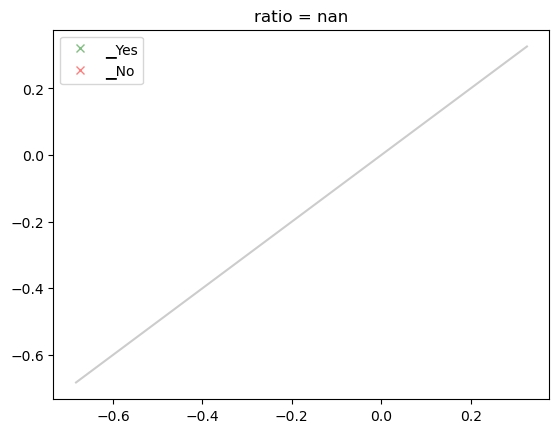

acc: 0.417 5 12
reduced_ap_scores = tensor([0.6934], device='cuda:0', dtype=torch.float16) tensor(0.6934, device='cuda:0', dtype=torch.float16)


In [704]:
# 0 1 6 10 12 13
# 2 3 4 5 9 10 11 13
# 2,5,14,12,10,13 b->b 3 4 0 1 2 3 6 10 14 5,11,14 
# 1 3 5 9
# 0 3 5 7 8 9 12 1 13
plot_attn_attrs(r1_al_before.data_tuples, model, tokenizer, node, topi=[12,14] ,attn_patterns=['s1->s2'], k_shot=0, mix=True)

###### winograd althougth after

In [545]:
winograd_al_after = Winograd('wino_al_s2after_sentences.json', 'wino_al_s2after_word_idx.json')

In [546]:
r1_al_after = None
result_al_after = {}

Options: [ large or small ] the trophy doesn't fit into the suitcase although the suitcase is large
1.9864759345849354 0.75 0.7350833333333333


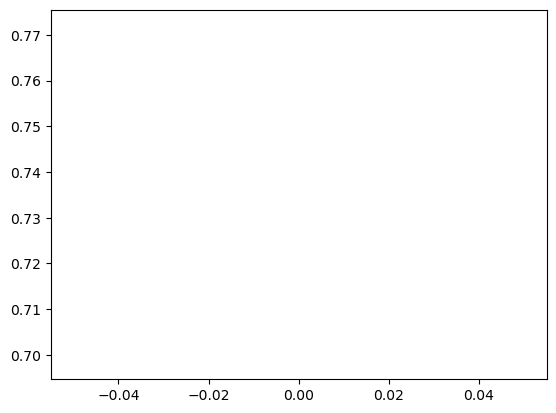

gx []
rx []


/home/xd/projects/transformers/notebooks/common_utils.py:266: RuntimeWarning: Mean of empty slice.
  m0 = y0.mean(0); m1 = y1.mean(0)
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


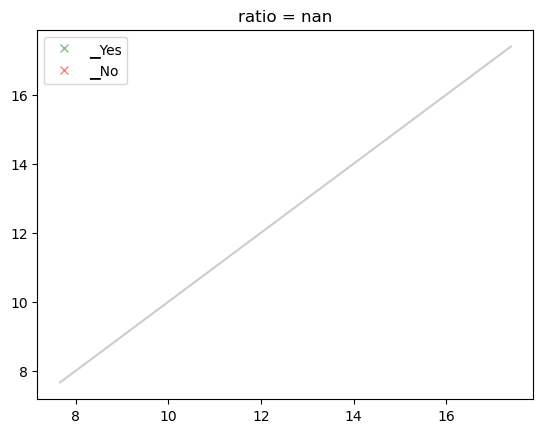

In [548]:
r1_al_after = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=12,dataset = winograd_al_after,
                                        trim=False, result=r1_al_after, verbose=False)#8tiao

In [592]:
def filter_fn_al_after(p, c):  #合并版
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1  and c.topi in [7,13] or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and c.topi in [0,1,2,3,6,11]  or #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and ((p.attn_pattern =='bos->bos' and c.topi in [3,4,2,5,10,12,14]) or (p.attn_pattern =='bos->s1' and c.topi in [0,5,1,13])) or
       p.step == 2 and c.topi in [0,1,2,3,6,10,5,11,14] or
    p.step == 3 and c.topi in [2,3,7,8,9,11,12] or
            p.step == 4 and c.top_score>0.5 or
            p.step == 5 and c.top_score>0.7#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [627]:
def filter_fn_al_after(p, c):  #合并版
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1  and c.topi in [0,2] or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and c.topi in [0,2,5]  or #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and c.topi in [0,1,2,3,4,5] or
       p.step == 2 and c.topi in [1] or
    p.step == 3 and c.topi in [2,3,7,8,9,11,12] or
            p.step == 4 and c.top_score>0.5 or
            p.step == 5 and c.top_score>0.7#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [628]:
if True or r1_al_after.root is None: r1_al_after.root = add_node(None, layer=L, label_type='labels')
r1_al_after.root = attribute_tree_on(r1_al_after.data_tuples, model, r1_al_after.root, 3, filter_fn_al_after, topk=15, k_shot=0, threshold_score=0.1, mix=True, device=None, verbose=True)

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:00.513951
In attribute_tree: attribute_step stage2  ... done 0:00:00.060820
In attribute_tree: topk bos->ans0 heads =
(array([26, 27, 53, 24, 21, 16, 26, 30, 57, 29]),
 array([51, 40, 17, 20, 12, 17, 29, 19,  4, 34]),
 array([0.24389267, 0.2106603 , 0.20564778, 0.19683711, 0.1779356 ,
       0.16322117, 0.1594162 , 0.15815862, 0.1569643 , 0.15404256],
      dtype=float32))
In _add_node: add @0 41-m 100
In _add_node: add @1 36-m 68
In _add_node: add @2 59-m 59
In _add_node: add @3 44-m 55
In _add_node: add @4 37-m 53
In _add_node: add @5 29-m 53
In _add_node: add @9 48-m 45
In _add_node: add @10 57-m 43
In _add_node: add @12 58-m 35
In _add_node: add @13 28-m 32
In _add_node: add @14 23-m 32
In _add_node: add @6 29-34 51 B->A0 42/15 attn
In _add_node: add @7 39-25 50 B->A0 37/10 attn
In _add_node: add @8 28-34 50 B->A0 37/12 attn
In _add_node: add @11 41-10 36 B->Ration 15/7 attn
In _add_node: add @[0,1,2,3,4,5,9,10,12,

In [629]:
print_tree(r1_al_after.root)

 ┌@[0,1,2,3,4,5,9,10,12,13,14] 41-m,36-m,59-m,44-m,37-m,29-m,48-m,57-m,58-m,28-m,23-m B->B 74
 ├@[6,7,8] 29-34,39-25,28-34 B->A0 9
 ├@[11] 41-10 unk 0
 ├@0 41-m 100
 ├@1 36-m 68
 ├@2 59-m 59
 ├@3 44-m 55
 ├@4 37-m 53
 ├@5 29-m 53
 ├@9 48-m 45
 ├@10 57-m 43
 ├@12 58-m 35
 ├@13 28-m 32
 ├@14 23-m 32
 ├@6 29-34 51 B->A0 42/15 attn
 ├@7 39-25 50 B->A0 37/10 attn
 ├@8 28-34 50 B->A0 37/12 attn
 ├@11 41-10 36 B->Ration 15/7 attn
 ┤
 │              ┌@:14 43-m,30-m,27-m,45-m,48-m,42-m,34-m,51-m,47-m,46-m 28,50-m 28,55-m 28,33-m 26,22-m 24 B->B 94
 │              ├@[14] 58-51 24 unk 0
 │              ├@0 43-m 100
 │              ├@1 30-m 50
 │              ├@2 27-m 45
 │              ├@3 45-m 37
 │              ├@4 48-m 35
 │              ├@5 42-m 34
 │              ├@6 34-m 34
 │              ├@7 51-m 32
 │              ├@8 47-m 31
 │              ├@9 46-m 28
 │              ├@10 50-m 28
 │              ├@11 55-m 28
 │              ├@12 33-m 26
 │              ├@13 22-m 24
 │              ├@14

In [595]:
node = r1_al_after.root.children[-1].children[-1]
node.name

'43-m,27-m,42-m B->B'

41-m,59-m B->B -> 43-m,27-m,42-m B->B -> 22-52 + 17-52 + 21-52 + 26-52 + 36-52 + 25-52
gx []
rx []


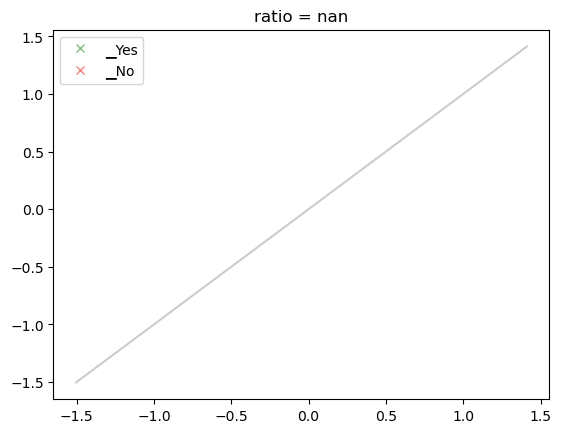

acc: 0.75 9 12
reduced_ap_scores = tensor([0.6558], device='cuda:0', dtype=torch.float16) tensor(0.6558, device='cuda:0', dtype=torch.float16)


In [623]:
# 0 1 6 10 12 13
# 2 3 4 5 9 10 11 13
# 2,5,14,12,10,13 b->b 3 4 0 1 2 3 6 10 14 5,11,14 
# 1 3 5 9
# 0 3 5 7 8 9 12 1 13
## 0  1 2 6 11
# 3 5,10,12 
plot_attn_attrs(r1_al_after.data_tuples, model, tokenizer, node, topi=[0,1,2,3,4,5] ,attn_patterns=['B->inter'], k_shot=0, mix=True)

In [ ]:
## 4 5 7 8 11 12 13